# Israel Bus Arrival Times
This notebook was created by Yoav Elkayam as part of the Data Science workshop at the Israel Open University, Spring of 2024.

## Purpose and goal definition
The purpose is to be able to predict bus arrival times based on time-series data of buses.
As a soldier in the IDF, the use of public transportation is on a weekly or even daily basis. It's no secret that public transportation in Israel is not the most punctual type. Failure to meet deadlines causes wasted time, lateness and unwanted delays.

The goal of this notebook is to predict when a bus will arrive at a station.

## Intro

The data being investigated is originated by each registered bus in the MOT (Ministry of Transportation). The data is collected by a group called "The Public Knowledge Workshop (“HASADNA”)". Hasadna collects all data from MOT than enriches it and saves it. It is publicly available by them via api - Open-Bus Stride.

The data we are going to look at is tabular data that has been enriched. In fact, at the source, the data is divided into two: 
1. Data on the planning of the bus schedule (GTFS)
2. Data taken in real time from the buses themselves.
   
The enrichment process that the data goes through connects these two parts according to different test parameters. Finally, the tabular data that is obtained appears in the form of the location of buses at a certain time at the same time as the location of the station closest to it in relation to its route and in addition to this additional data that we will see later.
In the first part of the notebook we will break down the information into these two parts so that later we can draw a route of a bus with the same number of points on the map as the number of bus stops it has to pass. As part of this process, we will calculate the arrival time to the station and this will be the variable that we will finally want to predict as part of the goal of the notebook.

It is important to note - the reason the data is re-decomposed is because it is not possible to obtain the data in its original form in a way that allows working with it. And in addition, a lot of data is used from the enrichment process that the original data goes through.
At the same time, it is important to note that an additional calculation is made of the station closest to the buses, even though, as mentioned, this figure comes with the enriched data - this is because the calculation made in the notebook is slightly more accurate.

The time frame going to be investigated will be January 2023 to October 2023.
This is in order to avoid unexpected changes in the GPS information that were created as a result of the GPS disruptions in the country as a result of the Israel–Hamas war.

## Key terms Dictionary

| Term          | Definition                                                   |
|---------------|--------------------------------------------------------------|
| siri |  Service Interface for Real Time Information. Columns that start with "siri_" has data from real time bus locations pings.|
| gtfs | General Transit Feed Specification. Columns that start with "gtfs_" has data from planned bus schedule |
| Journey | A trip a bus take from its starting station to its last station on a specific route. When a bus send its location information, its related to one journey. Each journey has many location records in the data. |
| Another Term  | Another definition goes here.                                |

# Import Dependencies


In [26]:
# Importing necessary libraries
import os
import glob
import time
import requests
import zipfile
from datetime import timedelta, date
import re

import uuid
import pyarrow.parquet as pq

import pandas as pd
import numpy as np
from geopy.distance import geodesic
import folium
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
from numba import jit
import concurrent.futures
from sqlalchemy import create_engine



from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error


# The stride client library, used to make the calls to the stride api
# import stride

### Defining Data location based on current workspace

In [27]:
DATA_FOLDER = './2023_siri_data'

In [ ]:
DATA_FOLDER = './drive/MyDrive/2023_siri_data'

In [18]:
DATA_FOLDER = 'G:\\My Drive\\2023_siri_data'

# Data Collection

Our data is sourced from the Open-Bus Stride ETL packages. These packages provide data in hourly intervals. The data includes information about bus locations, the nearest stop to each bus location, and correlations to the GTFS ride. This includes the date and time of scheduled arrival times, among other details.


## Data Download Function

In this cell, we define a function `download_files` to download and extract the data files for a given year.

The function iterates over each day and hour in the year, constructs the corresponding file URL, and sends a GET request to download the file. If the file is successfully downloaded, it is saved in the 'compressed' directory and then extracted to the 'data' directory.

If the file is not found on the server, its URL is added to a list of missing files, which is printed at the end of the function.

The function also reads and writes the last downloaded date and hour from/to a file, allowing the download process to be resumed if was interrupted.

Finally, we call the function to download the files for the year 2023.


In [28]:
def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

def download_files(year):
    start_date = date(year, 1, 1)
    end_date = date(year+1, 1, 1)
    missing_files = []

    if not os.path.exists(f'{DATA_FOLDER}/compressed'):
        os.makedirs(f'{DATA_FOLDER}/compressed')
    if not os.path.exists(f'{DATA_FOLDER}/data'):
        os.makedirs(f'{DATA_FOLDER}/data')

    # Read the start date and hour from a file
    try:
        with open(f'{DATA_FOLDER}/last_downloaded.txt', 'r') as f:
            last_downloaded = f.read().strip()
            start_date = date(int(last_downloaded[:4]), int(last_downloaded[5:7]), int(last_downloaded[8:10]))
            start_hour = int(last_downloaded[11:13])
    except FileNotFoundError:
        start_hour = 0

    for single_date in daterange(start_date, end_date):
        for hour in range(start_hour, 24):
            filename = f"{single_date.strftime('%Y-%m-%d')}.{str(hour).zfill(2)}"
            url = f"https://s3.eu-west-2.wasabisys.com/stride/stride-etl-packages/siri/{single_date.strftime('%Y/%m')}/{filename}.zip"
            response = requests.get(url)
            if response.status_code == 200:
                with open(f"{DATA_FOLDER}/compressed/{filename}.zip", 'wb') as f:
                    f.write(response.content)
                with zipfile.ZipFile(f"{DATA_FOLDER}/compressed/{filename}.zip", 'r') as zip_ref:
                    if f"{filename}.csv" in zip_ref.namelist():
                        zip_ref.extract(f"{filename}.csv", path=f'{DATA_FOLDER}/data')
                # Save the current date and hour to a file
                with open(f'{DATA_FOLDER}/last_downloaded.txt', 'w') as f:
                    f.write(f"{single_date.strftime('%Y-%m-%d')}.{str(hour).zfill(2)}")
            else:
                missing_files.append(url)
        start_hour = 0

    print("Missing files:")
    for file in missing_files:
        print(file)

In [ ]:
# download_files(2023)

## Keeping the data intact

We might have a missing file in the data folder
This function checks for missing files based on the compressed files folder


In [29]:
def extract_missing_csv(data_folder):
    zip_dir = f'{data_folder}/compressed'
    csv_dir = f'{data_folder}/data'
    # Get a list of all ZIP files
    zip_files = glob.glob(f'{zip_dir}/*.zip')
    zip_files.sort()

    for zip_file in zip_files:
        # Get the corresponding CSV file name
        csv_file_name = os.path.basename(zip_file)[:-4] + '.csv'
        csv_file_path = f'{csv_dir}/{csv_file_name}'
        
        # If the CSV file does not exist
        if not os.path.exists(csv_file_path):
            with zipfile.ZipFile(zip_file, 'r') as zip_ref:
                # Extract the CSV file
                if csv_file_name in zip_ref.namelist():
                    zip_ref.extract(csv_file_name, path=csv_dir)

In [ ]:
extract_missing_csv(DATA_FOLDER)

## Data Processing and Segmentation

This cell is designed to efficiently manage and process large datasets by breaking them down into more manageable chunks, optimizing memory usage, and enhancing data accessibility. The process involves several key steps:

1. **Data Segmentation**: The script segments large CSV files into smaller Parquet files, each containing up to 10 million rows. This segmentation facilitates easier handling of large datasets, as Parquet files are more efficient in terms of storage and speed when accessing subsets of data.

2. **Type Conversion and Cleanup**: It converts data types for specific columns to ensure consistency and optimizes memory usage. For example, it converts certain columns to string, integer, and floating-point types as needed. Additionally, it processes date columns to ensure they are in the correct datetime format.

3. **Column Removal**: To streamline the dataset, the script removes columns that are not immediately necessary for analysis. This step reduces file size and simplifies the dataset, making it easier to work with. The columns to be removed are specified in the [`columns_to_drop`](command:_github.copilot.openSymbolFromReferences?%5B%7B%22%24mid%22%3A1%2C%22fsPath%22%3A%22%2FUsers%2Fyoavelkayam%2FDocuments%2FOpenU%2F%D7%A1%D7%93%D7%A0%D7%94%20%D7%91%D7%9E%D7%93%D7%A2%D7%99%20%D7%94%D7%A0%D7%AA%D7%95%D7%A0%D7%99%D7%9D%2Fdata-science-project%2Fproject.ipynb%22%2C%22path%22%3A%22%2FUsers%2Fyoavelkayam%2FDocuments%2FOpenU%2F%D7%A1%D7%93%D7%A0%D7%94%20%D7%91%D7%9E%D7%93%D7%A2%D7%99%20%D7%94%D7%A0%D7%AA%D7%95%D7%A0%D7%99%D7%9D%2Fdata-science-project%2Fproject.ipynb%22%2C%22scheme%22%3A%22vscode-notebook-cell%22%2C%22fragment%22%3A%22X20sZmlsZQ%3D%3D%22%7D%2C%7B%22line%22%3A67%2C%22character%22%3A4%7D%5D "/Users/yoavelkayam/Documents/OpenU/סדנה במדעי הנתונים/data-science-project/project.ipynb") list.

4. **File Management**: The script includes functionality to manage files efficiently. It removes the original CSV files after processing them into Parquet format to free up storage space. It also handles the continuation of data processing from where it left off, by identifying the last processed file and its position, thus avoiding reprocessing of data.

5. **Data Deduplication**: Before appending new data to the dataset, it removes duplicate entries to ensure the uniqueness of records.

6. **Dynamic File Naming**: The output Parquet files are named dynamically based on their content, indicating the range of data they contain. This naming convention makes it easier to identify and access specific segments of data.

7. **Efficient Data Concatenation**: The script concatenates new data to an existing DataFrame until the specified row limit is reached. Once the limit is reached, the data is saved to a Parquet file, and the process continues with the remaining data.

This approach not only optimizes the processing of large datasets by reducing memory overhead but also organizes the data into a more accessible and efficient format, facilitating faster data retrieval and analysis.

In [31]:
def get_folder_size(folder_path):
    total = 0
    for path, dirs, files in os.walk(folder_path):
        for f in files:
            fp = os.path.join(path, f)
            total += os.path.getsize(fp)
    return total

def extract_number(file_name):
    match = re.search(r'output_(\d+)_from_(.+)_at_(\d+)_to_(.+)_at_(\d+)', file_name)
    return int(match.group(1)) if match else 0

def extract_variables(file_name):
    match = re.search(r'output_(\d+)_from_(.+)_at_(\d+)_to_(.+)_at_(\d+)', file_name)
    if match:
        x = int(match.group(1))
        start_file = match.group(2)
        start_pos = int(match.group(3))
        end_file = match.group(4)
        end_pos = int(match.group(5))
        return x, start_file, start_pos, end_file, end_pos
    else:
        return None

def save_df_to_parquet(df, file_counter, start_file, start_pos, last_file, end_pos, files_to_remove, location):
    print(f'Saving file {file_counter}...')
    
    dtypes = {
        'id': 'string',
        'bearing': 'int32',
        'lat': 'float64',
        'lon': 'float64',
        'gtfs_stop_lat': 'float64',
        'gtfs_stop_lon': 'float64',
        }
    
    date_cols = ['recorded_at_time', 'siri_scheduled_start_time', 'gtfs_start_time', 'gtfs_end_time', 'gtfs_arrival_time', 'gtfs_departure_time']
    
    # converting types
    df = df.astype(dtypes)
    for col in date_cols:
        df[col] = pd.to_datetime(df[col], format='%Y-%m-%dT%H:%M:%S%z')
    
    start_file_name = os.path.splitext(os.path.basename(start_file))[0]
    last_file_name = os.path.splitext(os.path.basename(last_file))[0]

    file_name = f'{location}/output_{file_counter}_from_{start_file_name}_at_{start_pos}_to_{last_file_name}_at_{end_pos}.parquet'

    df.to_parquet(file_name, index=False)

    # remove csv files
    print(f'Processed files {os.path.basename(files_to_remove[0])} to {os.path.basename(files_to_remove[-2])}. Now Deleting...')
    while len(files_to_remove) > 1:
        os.remove(files_to_remove[0])
        files_to_remove.pop(0)

    if end_pos == -1 and files_to_remove:
        os.remove(files_to_remove[0])
        files_to_remove.pop(0)

def process_files(folder_path, rows_per_file=10000000):
    print(f"Folder size before processing: {get_folder_size(folder_path)} bytes")

    output_files_folder_path = f'{folder_path}\\concatenated_data_parquet\\'

    df = pd.DataFrame()

    columns_to_drop = ['gtfs_agency_name', 'gtfs_stop_name', 'gtfs_route_long_name', 'gtfs_line_ref', 'gtfs_operator_ref', 'distance_from_siri_ride_stop_meters', 'distance_from_journey_start']

    start_file = None
    start_pos = None
    last_file = None
    end_pos = None

    csv_files = glob.glob(f'{folder_path}\\data\\*.csv')

    csv_files.sort()

    file_counter = 1

    output_files = glob.glob(f'{output_files_folder_path}output_*.parquet')

    if output_files:
        last_output_file = max(output_files, key=extract_number)
        file_counter, start_file, start_pos, last_file, end_pos = extract_variables(last_output_file)
        last_df = pd.read_parquet(last_output_file)
        # If the last output file contains less than max rows, load it into df
        if len(last_df) < rows_per_file:
            df = last_df
            os.remove(last_output_file)  # remove the last file as it will be rewritten later
        else:
            start_file = last_file
            start_pos = end_pos
            file_counter += 1
    
    if last_file is not None:
        start_index = csv_files.index(f'{folder_path}\\data\\{last_file}.csv')
    else:
        start_index = 0
        
    files_to_remove = []
    for file in csv_files[start_index:]:
        files_to_remove.append(file)
        # If the file is not empty
        if os.path.getsize(file) > 0:
            print(f'On file {file}')
            try:
                if end_pos is None:
                    end_pos = 0
                if start_file is None:
                    start_file = file

                
                if csv_files.index(file) == start_index:
                    temp_df = pd.read_csv(file, dtype='string', skiprows=range(1, end_pos))
                else:
                    temp_df = pd.read_csv(file, dtype='string')
                print(temp_df.shape[0])
                temp_df['original_file'] = os.path.basename(file)  # Add the original file name to each row
                last_file = file
                
                # Remove duplicates
                temp_df = temp_df.drop_duplicates()

                # Drop the unnecessary columns
                temp_df = temp_df.drop(columns=columns_to_drop)
                df = pd.concat([df, temp_df])
                
                # If the main DataFrame has reached max rows
                print(df.shape[0], temp_df.shape[0])
                if df.shape[0] >= rows_per_file:
                    start_pos = end_pos
                    end_pos = df.shape[0] - rows_per_file
                    save_df_to_parquet(df[:rows_per_file], file_counter, start_file, start_pos, last_file, end_pos, files_to_remove, output_files_folder_path)

                    # Keep the remaining rows in the DataFrame
                    df = df[rows_per_file:]
                    file_counter += 1
                    start_file = file

            except pd.errors.EmptyDataError:
                print(f"File {file} is empty or only contains a header.")
        
    # Write the remaining rows in the DataFrame to a parquet file
    if not df.empty:
        save_df_to_parquet(df, file_counter, start_file, start_pos, last_file, -1, files_to_remove, output_files_folder_path)

    print(f"Folder size after processing: {get_folder_size(folder_path)} bytes")

In [17]:
process_files(DATA_FOLDER)

Folder size before processing: 62382605722 bytes
Folder size after processing: 62382605722 bytes


# Data Examination

In this phase, we will focus on analyzing a single bus line, specifically line 68, which operates from Kiryat Ono terminal to Tel-Aviv central station. Our analysis will be limited to the first month of 2023.

Our primary goal is to identify instances of delays and subsequently investigate potential causes for these delays.

To facilitate this, we will prepare a DataFrame that consolidates all relevant data pertaining to this bus line.


In [32]:
def create_filtered_df(parquet_dir, line_refs, limit=0, offset=0):
    parquet_files = glob.glob(f'{parquet_dir}/output_*.parquet')

    parquet_files.sort(key=extract_number)
    
    if limit > 0:
        parquet_files = parquet_files[offset:offset+limit]
    else:
        parquet_files = parquet_files[offset:]

    df = pd.DataFrame()
    
    counter = 0

    for file in parquet_files:
        # Read the Parquet file
        temp_df = pd.read_parquet(file, filters=[('siri_line_ref', 'in', line_refs)])
        temp = temp_df.astype({'gtfs_stop_lat': float, 'gtfs_stop_lon': float, 'lat': float, 'lon': float})
        df = pd.concat([df, temp_df])
        counter += 1

        if counter % 20 == 0:
            print(f'Processed {counter} files. Current file: {os.path.basename(file)}')

    return df

In [33]:
df = create_filtered_df(f'{DATA_FOLDER}/concatenated_data_parquet', ['989'])

In [31]:
df.head()

,id,bearing,lat,lon,recorded_at_time,velocity,siri_stop_order,siri_scheduled_start_time,siri_duration_minutes,siri_journey_ref,...,gtfs_drop_off_type,gtfs_pickup_type,gtfs_shape_dist_traveled,gtfs_stop_sequence,gtfs_route_short_name,gtfs_route_type,gtfs_route_alternative,gtfs_route_direction,gtfs_route_mkt,original_file
0,1473610653,78,32.054782,34.861351,2023-01-05 12:00:00+02:00,7,8,2023-01-05 11:45:00+02:00,67,2023-01-05-231897,...,0,0,4676,8,68,3,0,2,14068,2023-01-05.12.csv
1,1473616107,76,32.054920,34.862171,2023-01-05 12:00:59+02:00,0,8,2023-01-05 11:45:00+02:00,67,2023-01-05-231897,...,0,0,4676,8,68,3,0,2,14068,2023-01-05.12.csv
2,1473621553,72,32.055068,34.863922,2023-01-05 12:02:03+02:00,0,9,2023-01-05 11:45:00+02:00,67,2023-01-05-231897,...,0,0,5072,9,68,3,0,2,14068,2023-01-05.12.csv
3,1473626930,41,32.055828,34.864608,2023-01-05 12:02:59+02:00,0,9,2023-01-05 11:45:00+02:00,67,2023-01-05-231897,...,0,0,5072,9,68,3,0,2,14068,2023-01-05.12.csv
4,1473632260,340,32.057430,34.864463,2023-01-05 12:03:58+02:00,0,10,2023-01-05 11:45:00+02:00,67,2023-01-05-231897,...,0,0,5477,10,68,3,0,2,14068,2023-01-05.12.csv


## Sorting and Formatting Data

In this step, we sort the dataframe `df` by 'siri_journey_ref' and 'recorded_at_time'. 

We then create two new dataframes:

- `df_bus_journey_stops`: This dataframe is created by selecting specific columns from `df_sorted` and dropping duplicates. It contains information about the bus journey stops.

- `df_locations`: This dataframe is created by excluding columns that start with 'gtfs' from `df_sorted`. It contains information about the bus locations from siri.


In [85]:
def process_dataframe(df):
    df_sorted = df.sort_values(['siri_journey_ref', 'recorded_at_time'])
    
    bus_journey_cols = ['id','siri_journey_ref', 'siri_vehicle_ref', 'siri_stop_code', 'siri_stop_order', 'siri_operator_ref', 'siri_line_ref', 'gtfs_journey_ref', 'gtfs_start_time', 'gtfs_end_time', 'gtfs_stop_code', 'gtfs_stop_lat', 'gtfs_stop_lon', 'gtfs_stop_city', 'gtfs_arrival_time', 'gtfs_stop_sequence', 'gtfs_route_short_name', 'gtfs_route_direction', 'gtfs_route_mkt']
    df_bus_journey_stops = df_sorted[bus_journey_cols].drop_duplicates()

    # Remove rows where 'gtfs_stop_lat' or 'gtfs_stop_lon' is NaN
    df_bus_journey_stops = df_bus_journey_stops.dropna(subset=['gtfs_stop_lat', 'gtfs_stop_lon'])

    location_cols = [col for col in df_sorted.columns if not col.startswith('gtfs')]
    df_locations = df_sorted[location_cols]

     # Remove journeys where all locations have the same lat and lon
    journey_counts = df_locations.groupby('siri_journey_ref')[['lat', 'lon']].nunique()
    journeys_to_keep = journey_counts[(journey_counts['lat'] > 2) | (journey_counts['lon'] > 2)].index
    df_locations = df_locations[df_locations['siri_journey_ref'].isin(journeys_to_keep)]
    df_bus_journey_stops = df_bus_journey_stops[df_bus_journey_stops['siri_journey_ref'].isin(journeys_to_keep)]
    df_bus_journey_stops.drop_duplicates(subset=['gtfs_stop_code', 'gtfs_stop_lat', 'gtfs_stop_lon', 'siri_journey_ref'], inplace=True)


    return df_bus_journey_stops, df_locations

In [86]:
df_bus_journey_stops, df_locations = process_dataframe(df)

## Calculating Distance and Speed

In this step, we define a function `calculate_distance_and_speed` to calculate the distance and speed for each journey.

- The `haversine` function calculates the distance between two points on the Earth's surface given their latitudes and longitudes.
- It then calculates the time difference between consecutive locations and uses this to calculate the speed.
- Any `NaN` values in the 'speed', 'distance', and 'time_diff' columns are replaced with 0.

Finally, we apply this function to our DataFrame `df_locations` using the `groupby` and `apply` methods, and reset the index.


In [8]:
# Pre-calculate constants outside the function
earth_radius = 6367 * 2 * np.pi

@jit(nopython=True)
def haversine(lat1, lon1, lat2, lon2):

    # Convert coordinates to radians (vectorized)
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula (vectorized operations)
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2.0) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0) ** 2
    c = 2 * np.arcsin(np.sqrt(a))

    return earth_radius * c

def calculate_distance_and_speed(group):
    
    lats = group['lat'].values
    lons = group['lon'].values

    # Vectorized haversine calculation
    distances = haversine(lats[:-1], lons[:-1], lats[1:], lons[1:])

    # Add distance and time difference columns
    group['distance'] = np.append(distances, np.nan)
    group['time_diff'] = (group['recorded_at_time'].shift(-1) - group['recorded_at_time']).dt.total_seconds() / 3600

    # Calculate speed
    group['speed'] = group['distance'] / np.maximum(group['time_diff'], 1e-9)

    # Replace NaN values with 0
    group['speed'] = np.nan_to_num(group['speed'])
    group['distance'] = np.nan_to_num(group['distance'])
    group['time_diff'] = np.nan_to_num(group['time_diff'])

    return group

def process_locations(df_locations):
    df_locations = df_locations.groupby('siri_journey_ref').apply(calculate_distance_and_speed)
    df_locations.reset_index(drop=True, inplace=True)
    return df_locations


In [80]:
df_locations = process_locations(df_locations)

## Calculating Arrival Times

In this step, we define several functions to calculate the estimated arrival times at each bus stop for each journey.

- The `calculate_bearing` function calculates the bearing between two points on the Earth's surface.
- The `calculate_arrival_times` function uses the above  function and the haversine function to estimate the arrival times at each bus stop for each journey. It takes into account the speed of the bus, the distance to the next stop, and the direction of the bus.

An important part of the `calculate_arrival_times` function is the calculation of the 'moving_towards_stop' field. This field is a boolean that indicates whether the bus is moving towards or away from the stop. It is calculated by comparing the bearing of the bus to the bearing of the line from the bus to the stop. If the bus's bearing is within a certain range of the bearing to the stop, then the bus is considered to be moving towards the stop. This calculation is important because it allows us to distinguish between a bus that is approaching a stop and a bus that has already passed a stop.

The 'distance_from_stop' field is the distance from the closest bus location to the stop. It is calculated using the `haversine` function.

The 'estimated_arrival_time' field is the estimated time that the bus will arrive at the stop. It is calculated by adding the estimated time to the stop (which is the distance to the stop divided by the speed of the bus) to the time that the closest location was recorded. If the bus is moving away from the stop, the estimated time to the stop is subtracted from the recorded time instead.

Finally, we call the `calculate_arrival_times` function to calculate the estimated arrival times for our data.


In [53]:
@jit(nopython=True)
def calculate_bearing(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Calculate the difference in longitudes
    dlon = lon2 - lon1

    # Calculate the bearing
    x = np.sin(dlon) * np.cos(lat2)
    y = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(dlon)
    bearing = np.degrees(np.arctan2(x, y))

    # Normalize the bearing to be between 0 and 360
    return (bearing + 360) % 360

def calculate_arrival_times(df_locations, df_bus_journey_stops, bearing_threshold=15):
    results = []

    df_locations['speed'].replace(0, np.nan, inplace=True)

    grouped_locations = df_locations.groupby('siri_journey_ref')

    for journey, journey_locations in grouped_locations:
        journey_stops = df_bus_journey_stops[df_bus_journey_stops['siri_journey_ref'] == journey]

        # Skip the journey if it only has 2 or fewer stops
        if len(journey_stops) <= 2:
            continue
        
        journey_locations = journey_locations.sort_values('recorded_at_time')

        # Interpolate to fill NaN values with the nearest non-NaN values
        journey_locations['speed'].interpolate(method='nearest', limit_direction='both', inplace=True)

        # Calculate the mean speed excluding the start and end points
        mean_speed = journey_locations['speed'][1:-1].mean()

        # Fill remaining NaN values at the start and end of the series with the mean speed
        journey_locations['speed'].fillna(mean_speed, inplace=True)

        latitudes = journey_locations['lat'].values
        longitudes = journey_locations['lon'].values

        journey_tree = KDTree(list(zip(latitudes, longitudes)), leafsize=4)

        for i, stop in journey_stops.iterrows():
            _, closest_location_idx = journey_tree.query((stop['gtfs_stop_lat'], stop['gtfs_stop_lon']))
            closest_location = journey_locations.iloc[closest_location_idx]

            bearing = calculate_bearing(closest_location['lat'], closest_location['lon'],
                                         stop['gtfs_stop_lat'], stop['gtfs_stop_lon'])

            distance_to_stop = haversine(closest_location['lat'], closest_location['lon'],
                                          stop['gtfs_stop_lat'], stop['gtfs_stop_lon'])

            moving_towards_stop = abs(closest_location['bearing'] - bearing) <= bearing_threshold

            estimated_time_to_stop = (distance_to_stop / closest_location['speed']) * 3600

            if not moving_towards_stop:
                estimated_arrival_time = closest_location['recorded_at_time'] - pd.Timedelta(seconds=estimated_time_to_stop)
            else:
                estimated_arrival_time = closest_location['recorded_at_time'] + pd.Timedelta(seconds=estimated_time_to_stop)

            results.append({
                'siri_journey_ref': journey,
                'gtfs_stop_code': stop['gtfs_stop_code'],
                'closest_location': closest_location['id'],
                'closest_location_lat': closest_location['lat'],
                'closest_location_lon': closest_location['lon'],
                'closet_location_speed': closest_location['speed'],
                'closest_location_bearing': closest_location['bearing'],
                'recorded_at_time': closest_location['recorded_at_time'],
                'distance_from_stop': distance_to_stop,
                'scheduled_arrival_time': stop['gtfs_arrival_time'],
                'estimated_arrival_time': estimated_arrival_time,
                'moving_towards_stop': moving_towards_stop,
                'arrival_time_diff': estimated_arrival_time - stop['gtfs_arrival_time']
            })

    df_results = pd.DataFrame(results)
    df_results = pd.merge(df_bus_journey_stops, df_results, on=['siri_journey_ref', 'gtfs_stop_code'])
    df_results.drop_duplicates(inplace=True)  # Deduplicate results


    return df_results

In [81]:
results = calculate_arrival_times(df_locations, df_bus_journey_stops, bearing_threshold=110)

### Visualizing Bus Locations and Stops for a Specific Journey

In this cell, we are creating a map to visualize the bus locations and stops for a specific journey. This map is centered at the mean latitude and longitude of the journey's locations.

Each bus location is marked with a blue icon, and each stop location is marked with a red icon. If the bus is moving towards the stop, the corresponding marker's popup will show 'Moving Towards Stop: Yes', otherwise it will show 'Moving Towards Stop: No'.

We also draw a blue line connecting all the bus locations and a red line connecting all the stop locations. This visual representation helps us to better understand the 'moving_towards_stop' field that was calculated earlier.

By visualizing a specific journey, we can manually verify if the 'moving_towards_stop' calculation is correct.


In [38]:
def plot_journey(siri_journey_ref, results):
    # Filter the results for the specified journey
    journey_results = results[results['siri_journey_ref'] == siri_journey_ref]

    # Create a map centered at the mean latitude and longitude of the journey's locations
    m = folium.Map(location=[journey_results['closest_location_lat'].mean(), journey_results['closest_location_lon'].mean()], zoom_start=13)

    # Add a marker for each bus location
    for _, row in journey_results.iterrows():
        # Determine whether the bus has already left the stop
        moving_towards_stop = 'Yes' if row['moving_towards_stop'] else 'No'
        
        # Add a marker with a popup showing whether the bus has left the stop
        folium.Marker([row['closest_location_lat'], row['closest_location_lon']], 
                      icon=folium.Icon(color="blue"), 
                      popup=f'Moving Towards Stop: {moving_towards_stop}').add_to(m)
        
    # Add a marker for each stop location
    for _, row in journey_results.iterrows():
        folium.Marker([row['gtfs_stop_lat'], row['gtfs_stop_lon']], icon=folium.Icon(color="red")).add_to(m)

    # Add a line for the bus locations
    bus_locations = journey_results[['closest_location_lat', 'closest_location_lon']].values.tolist()
    folium.PolyLine(bus_locations, color="blue").add_to(m)

    # Add a line for the stop locations
    stop_locations = journey_results[['gtfs_stop_lat', 'gtfs_stop_lon']].values.tolist()
    folium.PolyLine(stop_locations, color="red").add_to(m)

    # Display the map
    return m

In [82]:
plot_journey('2023-01-01-13510915', results)

## Bus Arrival Time Analysis

In this cell, we're performing several key steps to analyze bus arrival times:

1. **Calculate Arrival Time Difference**: We first calculate the difference between the estimated arrival time and the scheduled arrival time for each bus. This is done by subtracting the `scheduled_arrival_time` from the `estimated_arrival_time`. The result is stored in a new column in our DataFrame, `results`, named `arrival_time_diff`.

2. **Define Bus Classification Function**: We then define a function, `classify_bus`, that takes in the arrival time difference and a threshold (in minutes) as parameters. This function classifies the bus status into one of four categories:

   - 'Missing': If the arrival time difference is null.
   - 'Late': If the bus arrived later than the scheduled time by more than the threshold.
   - 'Early': If the bus arrived earlier than the scheduled time by more than the threshold.
   - 'On Time': If the bus arrived within the threshold window.

3. **Apply Classification Function**: We set the threshold to 3 minutes and apply the `classify_bus` function to the `arrival_time_diff` column of our DataFrame. The resulting bus status for each row is stored in a new column, `bus_status`.

This preprocessing is key step as it allows us to categorize bus arrival times and understand the distribution of 'Late', 'Early', 'On Time', and 'Missing' statuses across different bus journeys. This categorized data can then be used for further analysis, such as identifying patterns or trends in bus arrival times, or investigating the factors that might influence a bus's punctuality.


In [64]:
def classify_bus(arrival_time_diff, threshold):
    if pd.isnull(arrival_time_diff):
        return 'Missing'
    elif arrival_time_diff > pd.Timedelta(minutes=threshold):
        return 'Late'
    elif arrival_time_diff < -pd.Timedelta(minutes=threshold):
        return 'Early'
    else:
        return 'On Time'

def classify_buses(results, threshold = 3):
    results['bus_status'] = results['arrival_time_diff'].apply(lambda x: classify_bus(x, threshold))
    return  results

In [83]:
results = classify_buses(results)

## Analyzing Late Bus Stops

This cell will do the following:

1. **Filter the DataFrame**: The `results` DataFrame is filtered to only include rows where the `bus_status` is 'Late'. This filtered DataFrame, `late_buses`, includes all instances where a bus was late to a stop, regardless of whether it's the same bus or the same journey.

2. **Analyze the 'recorded_at_time' column**: The `recorded_at_time` column of the `late_buses` DataFrame is analyzed to understand the distribution of late bus stops throughout the day. This is done by extracting the hour from the `recorded_at_time` and creating a histogram.

3. **Plot Histogram**: A histogram is plotted to visualize the number of late bus stops for each hour of the day. The x-axis represents the hour of the day (24-hour format), and the y-axis represents the number of late bus stops.


In [67]:
def plot_late_buses(results):
    late_buses = results[results['bus_status'] == 'Late']
    late_buses['recorded_at_time'].dt.hour.hist()
    plt.title('Time of Day for Late Buses')
    plt.xlabel('Hour of Day')
    plt.ylabel('Number of Late Buses')
    plt.show()

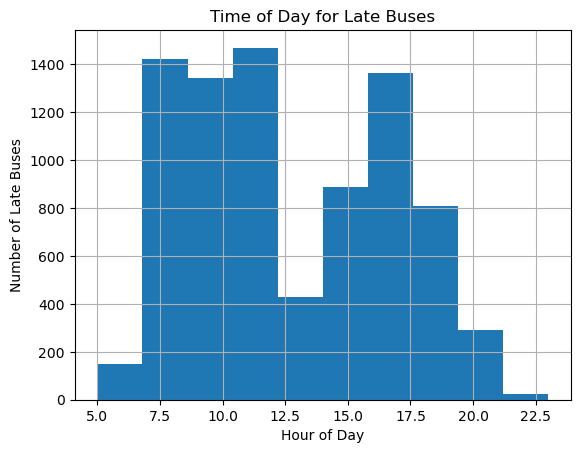

In [68]:
plot_late_buses(results)

# Data Preprocessing and Analysis

The following cell performs several data preprocessing steps on a DataFrame named `results`. Here's a breakdown of what each section does:

1. **Bus Status Conversion**: Converts the 'bus_status' column to numerical values, where 'Late' is represented as 1 and other statuses as 0.

2. **Time Feature Extraction**: Extracts day of the week and hour from 'gtfs_start_time', 'gtfs_end_time', and 'recorded_at_time' columns.


In [19]:
def time_features_extraction(results):
    results['bus_status_num'] = results['bus_status'].apply(lambda x: 1 if x == 'Late' else 0)

    results['gtfs_start_time__day_of_week'] = results['gtfs_start_time'].dt.dayofweek
    results['gtfs_start_time__hour'] = results['gtfs_start_time'].dt.hour

    results['gtfs_end_time__day_of_week'] = results['gtfs_end_time'].dt.dayofweek
    results['gtfs_end_time__hour'] = results['gtfs_end_time'].dt.hour

    results['recorded_at_time__day_of_week'] = results['recorded_at_time'].dt.dayofweek
    results['recorded_at_time__hour'] = results['recorded_at_time'].dt.hour
    results['recorded_at_time__minute'] = results['recorded_at_time'].dt.minute
    results['recorded_at_time__day_of_month'] = results['recorded_at_time'].dt.day
    results['recorded_at_time__month'] = results['recorded_at_time'].dt.month

    results.drop(columns=['gtfs_start_time', 'gtfs_end_time', 'recorded_at_time'], inplace=True)

    return results

In [69]:
results = time_features_extraction(results)

### Analyzing Bus Delays By time features
 
 This cell creates pivot tables for 'recorded_at_time', 'gtfs_start_time', and 'gtfs_end_time' with 'bus_status_num' as values. The pivot tables are indexed by day of the week and hour, and missing values are filled with 0.

The pivot tables provide a summary of the average bus status (late or not) for each hour of each day of the week, for the start time, end time, and recorded time. This can be useful for identifying patterns or trends in bus lateness.

In [70]:
def create_pivot_tables(results):
    def create_pivot_table(df, index_cols, value_col):
        pivot_table = df.pivot_table(index=index_cols, values=value_col, aggfunc='mean')
        all_days_of_week = sorted(df[index_cols[0]].unique())
        all_hours = range(24)
        index = pd.MultiIndex.from_product([all_days_of_week, all_hours], names=index_cols)
        pivot_table = pivot_table.reindex(index)
        pivot_table.fillna(0, inplace=True)
        return pivot_table

    recorded_time_pivot = create_pivot_table(results, ['recorded_at_time__day_of_week', 'recorded_at_time__hour'], 'bus_status_num')
    start_time_pivot = create_pivot_table(results, ['gtfs_start_time__day_of_week', 'gtfs_start_time__hour'], 'bus_status_num')
    end_time_pivot = create_pivot_table(results, ['gtfs_end_time__day_of_week', 'gtfs_end_time__hour'], 'bus_status_num')

    return recorded_time_pivot, start_time_pivot, end_time_pivot

In [71]:
recorded_time_pivot, start_time_pivot, end_time_pivot = create_pivot_tables(results)

#### Heatmap Visualization

This cell generates heatmaps for the pivot tables created in the previous step. The heatmaps visualize the average bus status (late or not) for each hour of each day of the week, for the start time, end time, and recorded time.

Three sets of heatmaps are created:

1. **Recorded Time Heatmaps**: These heatmaps use the pivot table indexed by the day of the week and hour of the 'recorded_at_time'. Each heatmap represents a day of the week.

2. **Start Time Heatmaps**: These heatmaps use the pivot table indexed by the day of the week and hour of the 'gtfs_start_time'. Each heatmap represents a day of the week.

3. **End Time Heatmaps**: These heatmaps use the pivot table indexed by the day of the week and hour of the 'gtfs_end_time'. Each heatmap represents a day of the week.

The color gradient in the heatmaps represents the average bus status, with lighter colors indicating a higher likelihood of the bus being late. This visualization can help identify patterns or trends in bus lateness across different times and days.


In [72]:
def plot_heatmaps(pivot_tables, titles):
    days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    for pivot_table, title in zip(pivot_tables, titles):
        fig, axs = plt.subplots(2, 4, figsize=(20, 10))

        # Remove the extra subplot
        fig.delaxes(axs[1,3])

        for i, day in enumerate(days_of_week):
            sns.heatmap(pivot_table.loc[i], cmap='viridis', ax=axs[i//4, i%4])
            axs[i//4, i%4].set_title(f'Heatmap for {day} - {title}')

        plt.tight_layout()
        plt.show()

KeyError: 4

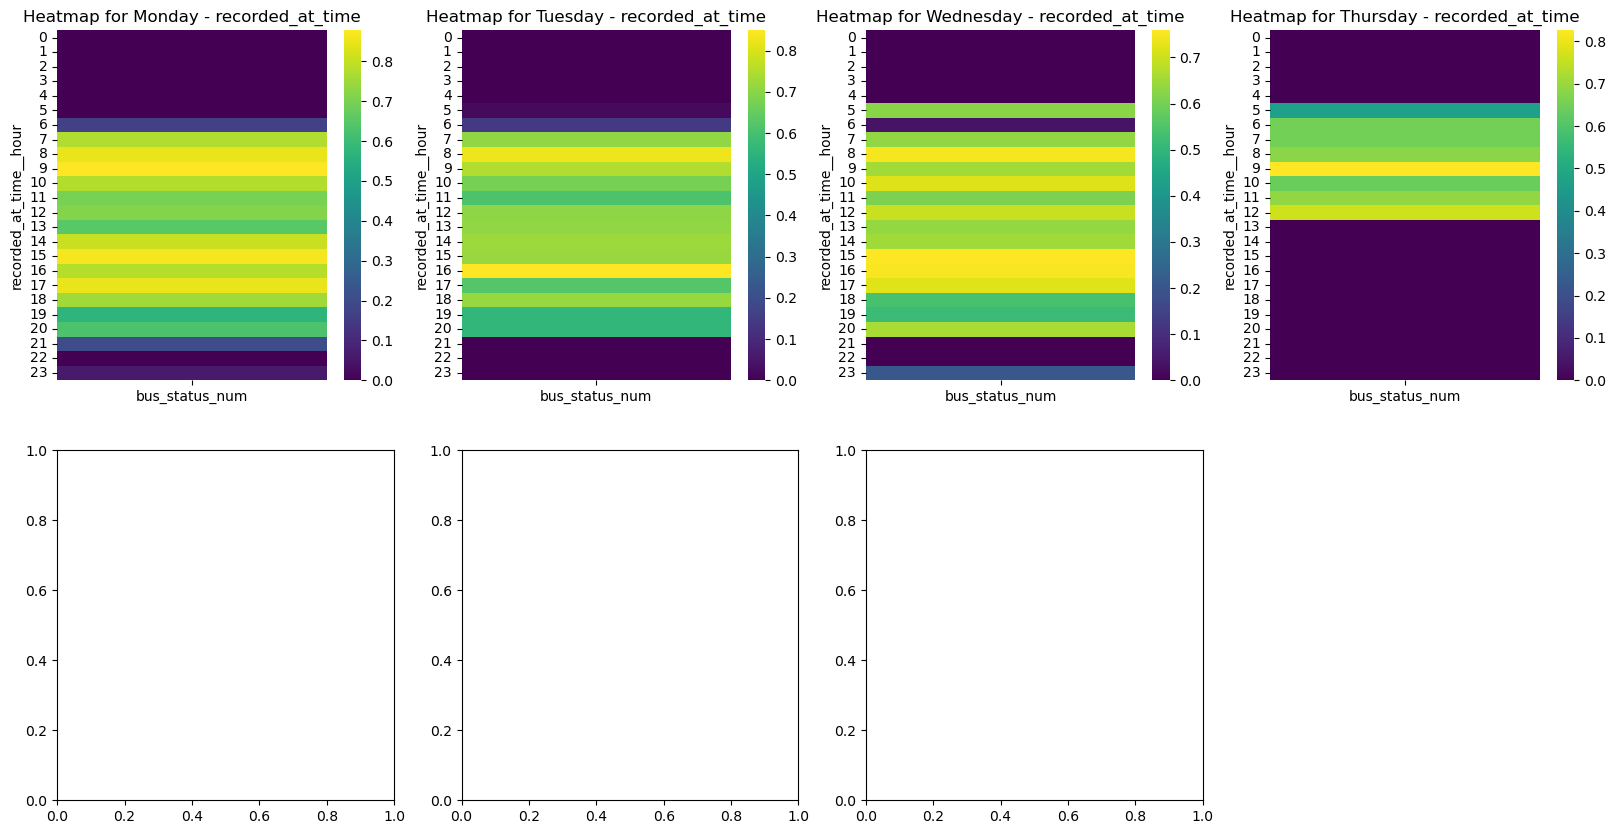

In [73]:
plot_heatmaps([recorded_time_pivot, start_time_pivot, end_time_pivot], ['recorded_at_time', 'gtfs_start_time', 'gtfs_end_time'])

### Analyzing Bus Delays by City

In this analysis, we are investigating the delay of buses across different cities.

The Python code provided creates a pivot table from the `results` DataFrame, using the 'gtfs_stop_city' column as the index and the 'bus_status_num' column as the values. The aggregation function used is 'mean', which gives us the average delay for each city.

A function `reverse_string(s)` is defined and applied to the index of the pivot table to reverse the order of the text.

A heatmap is then created using seaborn's `sns.heatmap()` function, visualizing the average delay of buses in different cities. The color intensity in the heatmap represents the magnitude of the delay.

By examining this heatmap, we can identify which cities experience the most significant bus delays.


In [75]:
def plot_city_heatmap(results):
    pivot_table_city = results.pivot_table(index='gtfs_stop_city', values='bus_status_num', aggfunc='mean')

    def reverse_string(s):
        return s[::-1]

    pivot_table_city.index = pivot_table_city.index.map(reverse_string)

    # Create the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(pivot_table_city, annot=True, cmap='coolwarm')
    plt.show()

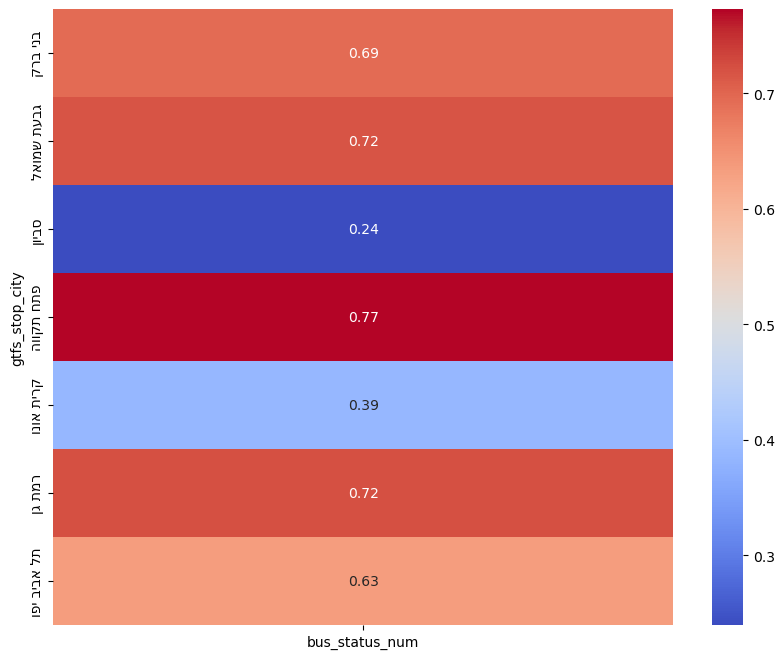

In [76]:
plot_city_heatmap(results)

# Applying Analysis to the Entire Dataset

In this section, we will apply the analysis we have developed to the entire dataset. Given the large size of the data (approximately 800GB), we will process the data in batches. This approach allows us to efficiently handle the data without overloading the memory.

When splitting into batches we can go in few different approaches:
1. Based on batch size limit - in this approach we only care about the size of the batch without any regard to its content.
2. Based on journey_ref - in this approach we will process each journey on its own. The main downside is the amount of batches - millions. which might lead to excessive overhead.
3. based on line_ref - in this approach we will process all journeys of a certain line in each batch. This could be helpful for training a model later in the notebook.
4. based on route_id - similar to the previous approach. could be better for a model training because its more unique.

## Splitting based on batch size

When first starting this part, the approach taken for splitting into batches was the first - based on batch size. 

After many hours of trial and error, many hours of data processing and many many hours of debugging - A conclusion was reached that a different approach was needed and this part must be ditched.

This code is still crucial for the project, so although it won't be used, it will not be deleted.

It should be noted that the code itself works, but every refinement needed in the created batches resulted in a very long wait time for the processing.



The steps we will follow are:

1. **Batch Creation**: We will create data batches, ensuring that each batch does not exceed a specified size limit. To maintain data integrity, we will ensure that all related lines (i.e., lines with the same 'siri_journey_ref') are included in the same batch.

2. **Batch Analysis**: We will apply our analysis to each batch individually. This includes any data cleaning, transformation, and statistical analysis we have previously defined.

3. **Results Aggregation**: After analyzing each batch, we will aggregate the results. This could involve combining the results into a single data structure, or it could involve saving the results of each batch's analysis to disk.

By processing the data in batches, we can scale our analysis to handle large datasets that would not otherwise fit into memory. Let's get started!


### Batch Creation Function

In this cell, we define a function `create_batch_df` to create data batches from the large dataset. The function takes the following parameters:

- `csv_dir`: The directory where the CSV files are stored.
- `batch_size_gb`: The maximum size of each batch in gigabytes.
- `last_journey_refs`: A set of 'siri_journey_ref' values that were included in the last batch and should be excluded from the current batch.
- `start_file`: The file to start reading from. If not specified, reading starts from the first file in the directory.
- `start_pos`: The position in the start file to start reading from.

The function works as follows:

1. It initializes an empty DataFrame for the batch and a set to keep track of the 'siri_journey_ref' values in the current batch.

2. It iterates over each file in the directory, starting from the `start_file` if specified.

3. For each file, it creates an iterator for the chunks in the file and reads the first chunk.

4. If there are any `last_journey_refs`, it excludes them from the chunk.

5. It then enters a loop where it adds the chunk to the batch if it doesn't exceed the `batch_size_gb`. If the batch size is exceeded, it adds only the rows with the same 'siri_journey_ref' as in the current batch.

6. The function returns the batch DataFrame, the set of 'siri_journey_ref' values in the current batch, the next chunk, the iterator for the next chunks, the next file, and the index of the next file.

By using this function, we can create manageable batches from the large dataset while ensuring that all related lines are included in the same batch.


In [10]:
def create_batch_df(parquet_dir, batch_size_gb, last_batch_journey_refs=None, start_file=None, start_pos=0):
    # Convert batch size from GB to bytes
    batch_size_bytes = batch_size_gb * 1024 * 1024 * 1024

    # Get a list of all output Parquet files
    parquet_files = glob.glob(f'{parquet_dir}/output_*.parquet')
    parquet_files.sort(key=extract_number)

    # If a start file is specified, start from this file
    if start_file is not None:
        parquet_files = parquet_files[parquet_files.index(start_file):]

    # Initialize an empty DataFrame for the batch
    batch_df = pd.DataFrame()

    # Initialize a set to keep track of the 'siri_journey_ref' values in the current batch
    current_journey_refs = set()

    for file in parquet_files:
        # Create an iterator for the chunks in the Parquet file
        parquet_file = pq.ParquetFile(file)
        chunk_iter = parquet_file.iter_batches(batch_size=100000)  # Adjust batch size as needed

        # Read the first chunk and convert it to a DataFrame
        chunk = pd.DataFrame(next(chunk_iter).to_pandas())

        # If there are any last journey refs, exclude them from the chunk
        if last_batch_journey_refs is not None:
            chunk = chunk[~chunk['siri_journey_ref'].isin(last_batch_journey_refs)]
        while True:
            # Add the chunk to the batch if it doesn't exceed the batch size
            if (batch_df.memory_usage(index=True, deep=True).sum() + chunk.memory_usage(index=True, deep=True).sum()) <= batch_size_bytes:
                batch_df = pd.concat([batch_df, chunk])
                current_journey_refs.update(chunk['siri_journey_ref'].unique())

            else:
                # If the batch size is exceeded, add only the rows with the same 'siri_journey_ref' as in the current batch
                current_journey_refs_in_chunk = chunk['siri_journey_ref'].isin(current_journey_refs)
                if current_journey_refs_in_chunk.any():
                    batch_df = pd.concat([batch_df, chunk[current_journey_refs_in_chunk]])
                    chunk = chunk[~current_journey_refs_in_chunk]

                # Return the current DataFrame and the set of 'siri_journey_ref' values
                return batch_df, current_journey_refs, chunk, chunk_iter, file, parquet_files.index(file)

            # Try to read the next chunk
            try:
                chunk = pd.DataFrame(next(chunk_iter).to_pandas())
            except StopIteration:
                break

    # If all files have been processed, return the current DataFrame and the set of 'siri_journey_ref' values
    return batch_df, current_journey_refs, None, None, None, None

def process_batch_df(batch_df):
    # Process the DataFrame
    df_bus_journey_stops, df_locations = process_dataframe(batch_df)

    print(f'Processed {len(df_bus_journey_stops)} bus journey stops and {len(df_locations)} locations.')
    # Process the locations
    df_locations = process_locations(df_locations)

    # Calculate the arrival times
    results = calculate_arrival_times(df_locations, df_bus_journey_stops, bearing_threshold=30)

    print(f'Calculated arrival times for {len(results)} stops.')
    # Calculate the bus stats and update the DataFrame
    results = classify_buses(results, threshold=3)

    # Process the results
    results = time_features_extraction(results)

    return results

def save_processed_batch(batch_df):
    batch_num = uuid.uuid4()
    output_file = f'{DATA_FOLDER}/processed_batches/processed_batch_{batch_num}.parquet'
    print(f'Saving processed batch to {output_file}')
    batch_df.to_parquet(output_file, index=False, engine='fastparquet')    

def process_batches_parallel(batch_dfs):
    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = list(executor.map(process_batch_df, batch_dfs))
    return results

In [11]:
def process_parquet_files(parquet_dir, batch_size_gb, num_batches):
    last_batch_journey_refs = None
    start_file = None
    start_pos = 0

    while True:
        batches = []
        for _ in range(num_batches):
            batch_df, last_batch_journey_refs, remaining_chunk, chunk_iter, start_file, start_pos = create_batch_df(parquet_dir, batch_size_gb, last_batch_journey_refs, start_file, start_pos)
            batches.append(batch_df)

            # If there are no more files to process, break the loop
            if start_file is None:
                break

        if not batches:
            break

        processes_batches =  process_batches_parallel(batches)

        for batch in processes_batches:
            save_processed_batch(batch)

        batches.clear()

    return results

In [18]:
batch_df, _, _, _, _, _ = create_batch_df(f'{DATA_FOLDER}/concatenated_data_parquet', 0.2)

In [24]:
process_parquet_files(f'{DATA_FOLDER}/concatenated_data_parquet', 0.4, 3)

In [22]:
# Specify the directory where your Parquet files are located
parquet_dir = f'{DATA_FOLDER}/concatenated_data_parquet'

# Create a batch of 1GB
batch_df, current_journey_refs, chunk, chunk_iter, file, file_index = create_batch_df(parquet_dir, batch_size_gb=0.2)

print(f'Batch DataFrame shape: {batch_df.shape}')

print(f'Batch size in GB: {batch_df.memory_usage(index=True, deep=True).sum() / 1024**3}')


In [ ]:
import cProfile

def profile_process_batch_df():

    # Use cProfile to profile the function
    profiler = cProfile.Profile()
    profiler.enable()

    # Call the function you want to profile
    process_batch_df(batch_df)

    # Disable the profiler after your function call
    profiler.disable()

    # Print the stats
    profiler.print_stats()

# Call the profiling function
profile_process_batch_df()

## Splitting based on route_id


In [12]:
# Function to establish a connection to the PostgreSQL database
def connect_to_db():
    # Replace the following with your database connection details
    user = 'postgres'
    password = 'postgres'
    host = 'localhost'
    port = '5432'
    db = 'siri_2023'
    return create_engine(f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{db}')

def process_chunk(chunk, engine, file_name):
    chunk.to_sql('raw_data', engine, if_exists='append', index=False)
    print(f'{datetime.now().strftime("%Y-%m-%d %H:%M:%S")} - Saved a chunk of {file_name} to the database.')

def process_file(file, engine):
    parquet_file = pq.ParquetFile(file)
    chunk_iter = parquet_file.iter_batches(batch_size=1000000)  # Adjust batch size as needed
    with concurrent.futures.ThreadPoolExecutor(max_workers=16) as executor:
        futures = []
        for batch in chunk_iter:
            chunk = pd.DataFrame(batch.to_pandas())
            # Submit each chunk to be processed by one of the workers
            futures.append(executor.submit(process_chunk, chunk, engine, os.path.basename(file)))
        concurrent.futures.wait(futures)

def save_to_db(parquet_dir, engine):
    parquet_files = glob.glob(f'{parquet_dir}/output_*.parquet')
    parquet_files.sort(key=lambda x: int(os.path.basename(x).split('_')[1].split('.')[0]))

    with concurrent.futures.ThreadPoolExecutor() as executor:
        # Submit each file to be processed in parallel
        futures = [executor.submit(process_file, file, engine) for file in parquet_files]
        concurrent.futures.wait(futures)



# Connect to the database
engine = connect_to_db()
# save_to_db(f'{DATA_FOLDER}/concatenated_data_parquet', engine)


### Processing Strategy

After deciding to load all data into PostgreSQL, the next step is processing it.

Processing the data still needs to be done in batches. We aim to choose a batching strategy that minimizes processing time. Because using PostgreSQL eliminates many of the complications we encountered earlier with file-based methods, we now have more flexibility in choosing processing strategies. This increased flexibility will not affect the later stages of model training.

When choosing the group, we must choose a group that include an entire journey from start to end.
For example - A group made from the `gtfs_route_mkt` is a good group because each journey has exactly one `gtfs_route_mkt`, On the other end, a group made from `siri_stop_code` is not a good group because each journey has many bus stops.

In [15]:
def process_single_value(args):
    engine, table_name, group_column, value, enable_logging = args
    def log(message):
        if enable_logging:
            print(message)
    
    fetch_start_time = time.time()
    sql_query = f"SELECT * FROM {table_name} WHERE {group_column} = '{value}' AND gtfs_arrival_time IS NOT NULL"
    df = pd.read_sql(sql_query, engine)
    fetch_end_time = time.time()
    log(f"Data for '{value}' in '{group_column}' fetched in {fetch_end_time - fetch_start_time:.2f} seconds.")
    
    group_start_time = time.time()
    
    # Process the data (assuming process_batch_df is a function you've defined to process your data)
    results = process_batch_df(df)
    
    # Save results in db
    results.to_sql('processed_data', engine, if_exists='append', index=False)
    
    group_end_time = time.time()
    log(f"Processed group '{value}' in '{group_column}' in {group_end_time - group_start_time:.2f} seconds.")

def process_data_grouped_by_column(engine, table_name, group_column, limit=None, enable_logging=False):
    start_time = time.time()
    if enable_logging:
        print(f"Starting processing for table '{table_name}' grouped by '{group_column}'")
    
    distinct_query = f"SELECT DISTINCT {group_column} FROM {table_name} WHERE {group_column} IS NOT NULL AND gtfs_arrival_time IS NOT NULL"
    distinct_values_df = pd.read_sql(distinct_query, engine)
    total_values = len(distinct_values_df)
    if enable_logging:
        print(f"Distinct query executed and fetched {total_values} distinct values.")
    
    if limit is not None:
        distinct_values_df = distinct_values_df.head(limit)
    
    args = [(engine, table_name, group_column, value, enable_logging) for value in distinct_values_df[group_column]]
    
    # Use ThreadPoolExecutor for parallel execution
    with concurrent.futures.ThreadPoolExecutor(max_workers=None) as executor:
        futures = [executor.submit(process_single_value, arg) for arg in args]
        for future in concurrent.futures.as_completed(futures):
            future.result()  # You can handle exceptions here if needed
    
    end_time = time.time()
    if enable_logging:
        print(f"Total processing time for table '{table_name}' grouped by '{group_column}': {end_time - start_time:.2f} seconds.")

In [ ]:
process_data_grouped_by_column(engine, 'raw_data', 'gtfs_route_mkt', limit=16, enable_logging=True)
# process_data_grouped_by_column(engine, 'raw_data', 'siri_journey_ref', limit=8, enable_logging=True)
# process_data_grouped_by_column(engine, 'raw_data', 'siri_vehicle_ref', limit=8, enable_logging=True)
# process_data_grouped_by_column(engine, 'raw_data', 'siri_line_ref', limit=8, enable_logging=True)

### Processing the data
After some tests with the above code, the chosen strategy is batching by gtfs_route_mkt.

In [88]:
process_data_grouped_by_column(engine, 'raw_data', 'gtfs_route_mkt', enable_logging=True)

Starting processing for table 'raw_data' grouped by 'gtfs_route_mkt'
Distinct query executed and fetched 2626 distinct values.
Data for '14850' in 'gtfs_route_mkt' fetched in 24.10 seconds.
Processed 220 bus journey stops and 484 locations.
Data for '20333' in 'gtfs_route_mkt' fetched in 27.29 seconds.
Data for '10728' in 'gtfs_route_mkt' fetched in 35.36 seconds.
Data for '12059' in 'gtfs_route_mkt' fetched in 35.56 seconds.
Calculated arrival times for 220 stops.Data for '28017' in 'gtfs_route_mkt' fetched in 36.07 seconds.
Processed 33 bus journey stops and 70 locations.
Data for '11621' in 'gtfs_route_mkt' fetched in 36.07 seconds.

Data for '11517' in 'gtfs_route_mkt' fetched in 36.29 seconds.
Processed 150 bus journey stops and 359 locations.
Data for '12377' in 'gtfs_route_mkt' fetched in 37.10 seconds.
Data for '11005' in 'gtfs_route_mkt' fetched in 37.16 seconds.
Data for '10706' in 'gtfs_route_mkt' fetched in 37.17 seconds.
Data for '14144' in 'gtfs_route_mkt' fetched in 37.2

/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 468 bus journey stops and 1408 locations.
Processed 459 bus journey stops and 820 locations.
Processed group '14850' in 'gtfs_route_mkt' in 12.90 seconds.
Processed 3543 bus journey stops and 6626 locations.
Calculated arrival times for 33 stops.
Processed group '10728' in 'gtfs_route_mkt' in 2.63 seconds.
Data for '19095' in 'gtfs_route_mkt' fetched in 38.10 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 572 bus journey stops and 1137 locations.
Processed 1868 bus journey stops and 2058 locations.
Calculated arrival times for 150 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12059' in 'gtfs_route_mkt' in 3.99 seconds.
Processed 2197 bus journey stops and 4242 locations.
Processed 6476 bus journey stops and 10592 locations.
Processed 10571 bus journey stops and 19728 locations.
Processed 9858 bus journey stops and 16550 locations.
Calculated arrival times for 468 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11621' in 'gtfs_route_mkt' in 10.77 seconds.
Calculated arrival times for 459 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '28017' in 'gtfs_route_mkt' in 11.54 seconds.
Calculated arrival times for 572 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10706' in 'gtfs_route_mkt' in 12.43 seconds.
Calculated arrival times for 1868 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11005' in 'gtfs_route_mkt' in 20.29 seconds.
Calculated arrival times for 2197 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '14144' in 'gtfs_route_mkt' in 24.86 seconds.
Calculated arrival times for 3540 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '20333' in 'gtfs_route_mkt' in 44.77 seconds.
Calculated arrival times for 6476 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12377' in 'gtfs_route_mkt' in 46.54 seconds.
Calculated arrival times for 9851 stops.
Data for '41094' in 'gtfs_route_mkt' fetched in 50.84 seconds.
Processed 40 bus journey stops and 65 locations.
Calculated arrival times for 40 stops.
Processed group '41094' in 'gtfs_route_mkt' in 0.48 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '13133' in 'gtfs_route_mkt' fetched in 51.32 seconds.
Processed 545 bus journey stops and 2593 locations.
Data for '27017' in 'gtfs_route_mkt' fetched in 52.01 seconds.
Processed 3498 bus journey stops and 5229 locations.
Calculated arrival times for 545 stops.
Calculated arrival times for 10569 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '11384' in 'gtfs_route_mkt' fetched in 49.04 seconds.
Processed group '13133' in 'gtfs_route_mkt' in 7.05 seconds.
Processed 358 bus journey stops and 1232 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '19095' in 'gtfs_route_mkt' in 59.27 seconds.
Data for '24050' in 'gtfs_route_mkt' fetched in 48.56 seconds.
Data for '11593' in 'gtfs_route_mkt' fetched in 50.77 seconds.
Processed 658 bus journey stops and 1430 locations.
Processed 1654 bus journey stops and 5384 locations.
Calculated arrival times for 357 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11384' in 'gtfs_route_mkt' in 4.94 seconds.
Data for '15056' in 'gtfs_route_mkt' fetched in 44.88 seconds.
Processed group '11517' in 'gtfs_route_mkt' in 67.11 seconds.
Processed 2721 bus journey stops and 4091 locations.
Data for '15281' in 'gtfs_route_mkt' fetched in 41.50 seconds.
Processed 978 bus journey stops and 2455 locations.
Calculated arrival times for 658 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '24050' in 'gtfs_route_mkt' in 7.23 seconds.
Calculated arrival times for 978 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '15281' in 'gtfs_route_mkt' in 5.47 seconds.
Calculated arrival times for 1654 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11593' in 'gtfs_route_mkt' in 12.06 seconds.
Calculated arrival times for 3498 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '19018' in 'gtfs_route_mkt' fetched in 42.52 seconds.
Processed group '27017' in 'gtfs_route_mkt' in 23.06 seconds.
Calculated arrival times for 2720 stops.
Processed 4089 bus journey stops and 7289 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '15056' in 'gtfs_route_mkt' in 13.98 seconds.
Data for '15139' in 'gtfs_route_mkt' fetched in 39.50 seconds.
Processed 150 bus journey stops and 267 locations.
Calculated arrival times for 150 stops.
Calculated arrival times for 4081 stops.
Processed group '15139' in 'gtfs_route_mkt' in 0.41 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '32012' in 'gtfs_route_mkt' fetched in 35.71 seconds.
Processed 386 bus journey stops and 668 locations.
Processed group '19018' in 'gtfs_route_mkt' in 10.67 seconds.
Calculated arrival times for 386 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '32012' in 'gtfs_route_mkt' in 1.22 seconds.
Data for '12275' in 'gtfs_route_mkt' fetched in 32.90 seconds.
Data for '85003' in 'gtfs_route_mkt' fetched in 34.09 seconds.
Processed 740 bus journey stops and 2150 locations.
Processed 4054 bus journey stops and 5760 locations.
Calculated arrival times for 740 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12275' in 'gtfs_route_mkt' in 2.89 seconds.
Data for '37009' in 'gtfs_route_mkt' fetched in 36.00 seconds.
Processed 6722 bus journey stops and 9085 locations.
Data for '10252' in 'gtfs_route_mkt' fetched in 16.52 seconds.
Processed 862 bus journey stops and 1870 locations.
Data for '18064' in 'gtfs_route_mkt' fetched in 11.39 seconds.
Processed 128 bus journey stops and 229 locations.
Calculated arrival times for 862 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10252' in 'gtfs_route_mkt' in 3.89 seconds.
Calculated arrival times for 128 stops.
Calculated arrival times for 4052 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '18064' in 'gtfs_route_mkt' in 1.13 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '85003' in 'gtfs_route_mkt' in 18.32 seconds.
Data for '10234' in 'gtfs_route_mkt' fetched in 49.78 seconds.
Data for '10996' in 'gtfs_route_mkt' fetched in 44.35 seconds.
Data for '12042' in 'gtfs_route_mkt' fetched in 38.87 seconds.
Processed 58 bus journey stops and 80 locations.
Processed 298 bus journey stops and 1746 locations.
Data for '10921' in 'gtfs_route_mkt' fetched in 50.17 seconds.Calculated arrival times for 58 stops.
Data for '67006' in 'gtfs_route_mkt' fetched in 46.38 seconds.

Data for '22036' in 'gtfs_route_mkt' fetched in 41.00 seconds.
Processed group '12042' in 'gtfs_route_mkt' in 0.56 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 784 bus journey stops and 14043 locations.
Processed 1576 bus journey stops and 2712 locations.
Processed 3684 bus journey stops and 5452 locations.
Processed 8779 bus journey stops and 17298 locations.
Data for '10116' in 'gtfs_route_mkt' fetched in 12.58 seconds.
Calculated arrival times for 298 stops.
Processed 206 bus journey stops and 527 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '26078' in 'gtfs_route_mkt' fetched in 35.09 seconds.
Data for '77001' in 'gtfs_route_mkt' fetched in 37.63 seconds.
Data for '11669' in 'gtfs_route_mkt' fetched in 12.38 seconds.
Processed group '10996' in 'gtfs_route_mkt' in 6.49 seconds.
Data for '13173' in 'gtfs_route_mkt' fetched in 15.69 seconds.
Processed 596 bus journey stops and 2807 locations.
Processed 4163 bus journey stops and 4903 locations.
Processed 632 bus journey stops and 4843 locations.
Calculated arrival times for 206 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10116' in 'gtfs_route_mkt' in 5.73 seconds.
Data for '28086' in 'gtfs_route_mkt' fetched in 8.56 seconds.
Processed 44 bus journey stops and 132 locations.
Processed 7286 bus journey stops and 15706 locations.
Calculated arrival times for 44 stops.
Processed group '28086' in 'gtfs_route_mkt' in 1.74 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '13008' in 'gtfs_route_mkt' fetched in 9.91 seconds.
Processed 882 bus journey stops and 1562 locations.
Calculated arrival times for 779 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 592 stops.
Data for '12366' in 'gtfs_route_mkt' fetched in 9.72 seconds.
Processed group '10234' in 'gtfs_route_mkt' in 21.17 seconds.
Processed group '26078' in 'gtfs_route_mkt' in 13.50 seconds.
Data for '23065' in 'gtfs_route_mkt' fetched in 11.46 seconds.
Processed 578 bus journey stops and 1761 locations.
Processed 1513 bus journey stops and 2292 locations.
Calculated arrival times for 630 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11669' in 'gtfs_route_mkt' in 18.38 seconds.
Calculated arrival times for 6722 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 882 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 578 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '13008' in 'gtfs_route_mkt' in 14.85 seconds.
Processed group '12366' in 'gtfs_route_mkt' in 13.02 seconds.
Processed group '37009' in 'gtfs_route_mkt' in 51.83 seconds.
Calculated arrival times for 1574 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '19073' in 'gtfs_route_mkt' fetched in 16.72 seconds.
Data for '10749' in 'gtfs_route_mkt' fetched in 16.80 seconds.
Processed 87 bus journey stops and 98 locations.
Processed group '22036' in 'gtfs_route_mkt' in 36.00 seconds.
Processed 72 bus journey stops and 142 locations.
Calculated arrival times for 72 stops.
Processed group '10749' in 'gtfs_route_mkt' in 1.09 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 87 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '19073' in 'gtfs_route_mkt' in 1.49 seconds.
Calculated arrival times for 1513 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '23065' in 'gtfs_route_mkt' in 16.59 seconds.
Data for '35010' in 'gtfs_route_mkt' fetched in 16.24 seconds.
Processed 5002 bus journey stops and 7426 locations.
Calculated arrival times for 3684 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '67006' in 'gtfs_route_mkt' in 46.78 seconds.
Calculated arrival times for 4161 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '77001' in 'gtfs_route_mkt' in 47.80 seconds.
Data for '40020' in 'gtfs_route_mkt' fetched in 25.15 seconds.
Processed 593 bus journey stops and 1471 locations.
Data for '22044' in 'gtfs_route_mkt' fetched in 21.58 seconds.
Data for '13014' in 'gtfs_route_mkt' fetched in 22.92 seconds.
Processed 1431 bus journey stops and 2900 locations.
Data for '17163' in 'gtfs_route_mkt' fetched in 29.57 seconds.
Processed 7 bus journey stops and 157 locations.
Processed 11965 bus journey stops and 19568 locations.
Data for '12291' in 'gtfs_route_mkt' fetched in 32.96 seconds.
Data for '14049' in 'gtfs_route_mkt' fetched in 18.28 seconds.
Data for '74003' in 'gtfs_route_mkt' fetched in 28.29 seconds.
Processed 139 bus journey stops and 216 locations.
Data for '30022' in 'gtfs_route_mkt' fetched in 30.56 seconds.
Processed 3522 bus journey stops and 5562 locations.
Calculated arrival times for 589 stops.
Processed 4168 bus journey stops and 10698 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '40020' in 'gtfs_route_mkt' in 14.31 seconds.
Calculated arrival times for 139 stops.
Processed group '74003' in 'gtfs_route_mkt' in 4.05 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 8777 stops.
Processed 15116 bus journey stops and 20335 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 5002 stops.
Calculated arrival times for 7278 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10921' in 'gtfs_route_mkt' in 83.35 seconds.
Processed group '35010' in 'gtfs_route_mkt' in 45.54 seconds.
Data for '12231' in 'gtfs_route_mkt' fetched in 21.89 seconds.
Data for '26053' in 'gtfs_route_mkt' fetched in 15.11 seconds.
Data for '18018' in 'gtfs_route_mkt' fetched in 33.43 seconds.
Data for '20049' in 'gtfs_route_mkt' fetched in 16.56 seconds.
Processed 265 bus journey stops and 2278 locations.
Processed 1176 bus journey stops and 1817 locations.
Processed group '13173' in 'gtfs_route_mkt' in 81.92 seconds.
Calculated arrival times for 1429 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 4698 bus journey stops and 8915 locations.
Processed group '22044' in 'gtfs_route_mkt' in 31.54 seconds.
Processed 14820 bus journey stops and 27993 locations.
Calculated arrival times for 214 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12231' in 'gtfs_route_mkt' in 6.23 seconds.
Data for '11078' in 'gtfs_route_mkt' fetched in 13.67 seconds.
Processed 58 bus journey stops and 210 locations.
Data for '10278' in 'gtfs_route_mkt' fetched in 14.21 seconds.
Calculated arrival times for 58 stops.
Processed group '11078' in 'gtfs_route_mkt' in 6.93 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 1176 stops.
Data for '62004' in 'gtfs_route_mkt' fetched in 16.77 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 1244 bus journey stops and 3015 locations.
Processed group '26053' in 'gtfs_route_mkt' in 19.10 seconds.
Data for '18019' in 'gtfs_route_mkt' fetched in 15.19 seconds.
Processed 16311 bus journey stops and 37124 locations.
Processed 15969 bus journey stops and 26700 locations.
Data for '10142' in 'gtfs_route_mkt' fetched in 23.47 seconds.
Calculated arrival times for 3522 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 663 bus journey stops and 1108 locations.
Processed group '14049' in 'gtfs_route_mkt' in 53.00 seconds.
Calculated arrival times for 1244 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10278' in 'gtfs_route_mkt' in 23.93 seconds.
Calculated arrival times for 655 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10142' in 'gtfs_route_mkt' in 14.13 seconds.
Calculated arrival times for 4167 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '20082' in 'gtfs_route_mkt' fetched in 30.60 seconds.
Processed 220 bus journey stops and 315 locations.
Data for '15316' in 'gtfs_route_mkt' fetched in 30.36 seconds.
Processed group '12291' in 'gtfs_route_mkt' in 72.45 seconds.
Processed 235 bus journey stops and 762 locations.
Calculated arrival times for 218 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '20082' in 'gtfs_route_mkt' in 3.91 seconds.
Calculated arrival times for 4696 stops.
Calculated arrival times for 235 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '15316' in 'gtfs_route_mkt' in 4.78 seconds.
Data for '80002' in 'gtfs_route_mkt' fetched in 22.77 seconds.
Processed 5505 bus journey stops and 6081 locations.
Data for '17059' in 'gtfs_route_mkt' fetched in 18.62 seconds.
Processed group '20049' in 'gtfs_route_mkt' in 58.54 seconds.Processed 398 bus journey stops and 538 locations.

Calculated arrival times for 398 stops.
Data for '11800' in 'gtfs_route_mkt' fetched in 9.02 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '17059' in 'gtfs_route_mkt' in 6.82 seconds.
Data for '35063' in 'gtfs_route_mkt' fetched in 11.82 seconds.
Processed 115 bus journey stops and 563 locations.
Data for '74001' in 'gtfs_route_mkt' fetched in 14.08 seconds.
Processed 536 bus journey stops and 1381 locations.
Calculated arrival times for 115 stops.
Processed group '11800' in 'gtfs_route_mkt' in 3.02 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '61001' in 'gtfs_route_mkt' fetched in 22.64 seconds.
Processed 4131 bus journey stops and 4584 locations.
Processed 10968 bus journey stops and 12591 locations.
Data for '78015' in 'gtfs_route_mkt' fetched in 10.27 seconds.
Data for '26064' in 'gtfs_route_mkt' fetched in 14.95 seconds.
Data for '10189' in 'gtfs_route_mkt' fetched in 8.60 seconds.
Calculated arrival times for 536 stops.
Processed 7169 bus journey stops and 10158 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '35063' in 'gtfs_route_mkt' in 15.09 seconds.
Processed 8643 bus journey stops and 16027 locations.
Processed 12632 bus journey stops and 23065 locations.
Data for '23292' in 'gtfs_route_mkt' fetched in 16.52 seconds.
Processed 1308 bus journey stops and 1966 locations.
Calculated arrival times for 11965 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '13014' in 'gtfs_route_mkt' in 138.74 seconds.
Calculated arrival times for 1308 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '23292' in 'gtfs_route_mkt' in 17.90 seconds.
Calculated arrival times for 4129 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '10487' in 'gtfs_route_mkt' fetched in 9.49 seconds.
Processed 82 bus journey stops and 339 locations.
Processed group '61001' in 'gtfs_route_mkt' in 55.55 seconds.
Data for '32091' in 'gtfs_route_mkt' fetched in 8.29 seconds.
Calculated arrival times for 79 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10487' in 'gtfs_route_mkt' in 1.99 seconds.
Processed 1495 bus journey stops and 2132 locations.
Data for '37082' in 'gtfs_route_mkt' fetched in 4.65 seconds.
Processed 33 bus journey stops and 57 locations.
Calculated arrival times for 33 stops.
Processed group '37082' in 'gtfs_route_mkt' in 0.68 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '67001' in 'gtfs_route_mkt' fetched in 5.39 seconds.
Calculated arrival times for 15114 stops.
Processed 1648 bus journey stops and 2297 locations.
Calculated arrival times for 5503 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '29097' in 'gtfs_route_mkt' fetched in 4.33 seconds.
Processed 129 bus journey stops and 180 locations.
Processed group '80002' in 'gtfs_route_mkt' in 80.29 seconds.
Calculated arrival times for 129 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '29097' in 'gtfs_route_mkt' in 4.06 seconds.
Processed group '30022' in 'gtfs_route_mkt' in 157.01 seconds.
Calculated arrival times for 1495 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '32091' in 'gtfs_route_mkt' in 21.62 seconds.
Data for '25028' in 'gtfs_route_mkt' fetched in 15.38 seconds.
Data for '13360' in 'gtfs_route_mkt' fetched in 15.81 seconds.
Processed 705 bus journey stops and 1466 locations.
Data for '11210' in 'gtfs_route_mkt' fetched in 14.51 seconds.
Processed 2305 bus journey stops and 5449 locations.
Calculated arrival times for 1648 stops.
Processed 1903 bus journey stops and 4156 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '67001' in 'gtfs_route_mkt' in 27.06 seconds.
Calculated arrival times for 7169 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '23047' in 'gtfs_route_mkt' fetched in 15.72 seconds.
Processed group '78015' in 'gtfs_route_mkt' in 86.78 seconds.
Processed 1638 bus journey stops and 3038 locations.
Calculated arrival times for 705 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '25028' in 'gtfs_route_mkt' in 13.91 seconds.
Calculated arrival times for 8643 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '26064' in 'gtfs_route_mkt' in 97.63 seconds.
Calculated arrival times for 14817 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 1903 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 1638 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11210' in 'gtfs_route_mkt' in 28.37 seconds.
Calculated arrival times for 15963 stops.
Processed group '23047' in 'gtfs_route_mkt' in 23.38 seconds.
Calculated arrival times for 2305 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '12465' in 'gtfs_route_mkt' fetched in 29.75 seconds.
Processed group '13360' in 'gtfs_route_mkt' in 34.62 seconds.
Processed group '18018' in 'gtfs_route_mkt' in 185.90 seconds.
Data for '72015' in 'gtfs_route_mkt' fetched in 28.34 seconds.
Processed 2188 bus journey stops and 4405 locations.
Processed 810 bus journey stops and 1198 locations.
Data for '14246' in 'gtfs_route_mkt' fetched in 27.45 seconds.
Processed 2669 bus journey stops and 4408 locations.
Calculated arrival times for 10967 stops.
Processed group '18019' in 'gtfs_route_mkt' in 175.73 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '48022' in 'gtfs_route_mkt' fetched in 27.27 seconds.
Calculated arrival times for 808 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '72015' in 'gtfs_route_mkt' in 11.16 seconds.
Processed group '74001' in 'gtfs_route_mkt' in 136.28 seconds.
Processed 6921 bus journey stops and 8224 locations.
Data for '11410' in 'gtfs_route_mkt' fetched in 21.22 seconds.
Data for '13291' in 'gtfs_route_mkt' fetched in 21.46 seconds.
Processed 1511 bus journey stops and 2639 locations.
Processed 160 bus journey stops and 456 locations.
Data for '52019' in 'gtfs_route_mkt' fetched in 20.42 seconds.
Data for '34015' in 'gtfs_route_mkt' fetched in 20.19 seconds.
Data for '42003' in 'gtfs_route_mkt' fetched in 12.40 seconds.
Calculated arrival times for 160 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '13291' in 'gtfs_route_mkt' in 3.77 seconds.
Processed 4899 bus journey stops and 8447 locations.
Data for '31045' in 'gtfs_route_mkt' fetched in 8.88 seconds.
Calculated arrival times for 2188 stops.
Processed 7343 bus journey stops and 9894 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12465' in 'gtfs_route_mkt' in 24.91 seconds.
Processed 5810 bus journey stops and 10291 locations.
Processed 785 bus journey stops and 1570 locations.
Calculated arrival times for 12628 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '13110' in 'gtfs_route_mkt' fetched in 6.26 seconds.
Data for '19054' in 'gtfs_route_mkt' fetched in 4.62 seconds.
Processed 194 bus journey stops and 321 locations.
Data for '29017' in 'gtfs_route_mkt' fetched in 15.54 seconds.
Calculated arrival times for 194 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '19054' in 'gtfs_route_mkt' in 2.85 seconds.
Processed 5070 bus journey stops and 6912 locations.
Processed group '10189' in 'gtfs_route_mkt' in 143.95 seconds.
Processed 6049 bus journey stops and 7761 locations.
Calculated arrival times for 785 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 1511 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '31045' in 'gtfs_route_mkt' in 11.94 seconds.
Processed group '11410' in 'gtfs_route_mkt' in 19.48 seconds.
Data for '33085' in 'gtfs_route_mkt' fetched in 6.21 seconds.
Processed 60 bus journey stops and 98 locations.
Calculated arrival times for 60 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '33085' in 'gtfs_route_mkt' in 2.60 seconds.
Data for '10133' in 'gtfs_route_mkt' fetched in 9.73 seconds.
Data for '46014' in 'gtfs_route_mkt' fetched in 7.41 seconds.
Processed 791 bus journey stops and 1468 locations.
Calculated arrival times for 2662 stops.
Data for '12260' in 'gtfs_route_mkt' fetched in 8.52 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '14246' in 'gtfs_route_mkt' in 41.06 seconds.
Processed 7845 bus journey stops and 12167 locations.
Data for '77015' in 'gtfs_route_mkt' fetched in 7.32 seconds.
Processed 1929 bus journey stops and 3707 locations.
Calculated arrival times for 16280 stops.
Data for '19142' in 'gtfs_route_mkt' fetched in 4.52 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 14790 bus journey stops and 21657 locations.
Calculated arrival times for 791 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '46014' in 'gtfs_route_mkt' in 10.74 seconds.
Processed 1355 bus journey stops and 3587 locations.
Data for '29094' in 'gtfs_route_mkt' fetched in 4.03 seconds.
Processed group '62004' in 'gtfs_route_mkt' in 225.39 seconds.
Processed 97 bus journey stops and 372 locations.
Calculated arrival times for 95 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '29094' in 'gtfs_route_mkt' in 2.83 seconds.
Data for '54013' in 'gtfs_route_mkt' fetched in 4.82 seconds.
Processed 4641 bus journey stops and 5964 locations.
Data for '53080' in 'gtfs_route_mkt' fetched in 4.52 seconds.
Calculated arrival times for 5070 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '13110' in 'gtfs_route_mkt' in 38.48 seconds.
Processed 1917 bus journey stops and 2573 locations.
Calculated arrival times for 1929 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12260' in 'gtfs_route_mkt' in 24.30 seconds.
Calculated arrival times for 1355 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '19142' in 'gtfs_route_mkt' in 19.05 seconds.
Data for '22064' in 'gtfs_route_mkt' fetched in 5.31 seconds.
Calculated arrival times for 4892 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 2051 bus journey stops and 3942 locations.
Processed group '34015' in 'gtfs_route_mkt' in 54.33 seconds.
Data for '17139' in 'gtfs_route_mkt' fetched in 6.37 seconds.
Data for '46001' in 'gtfs_route_mkt' fetched in 5.42 seconds.
Processed 2083 bus journey stops and 3741 locations.
Processed 6008 bus journey stops and 7842 locations.
Calculated arrival times for 5810 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '27004' in 'gtfs_route_mkt' fetched in 6.81 seconds.
Calculated arrival times for 1917 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 6049 stops.
Processed group '42003' in 'gtfs_route_mkt' in 63.09 seconds.
Processed group '53080' in 'gtfs_route_mkt' in 19.46 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 6921 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '29017' in 'gtfs_route_mkt' in 57.34 seconds.
Processed 24311 bus journey stops and 40297 locations.
Data for '25033' in 'gtfs_route_mkt' fetched in 6.72 seconds.
Processed group '48022' in 'gtfs_route_mkt' in 78.08 seconds.
Processed 236 bus journey stops and 301 locations.
Data for '11472' in 'gtfs_route_mkt' fetched in 8.91 seconds.
Calculated arrival times for 236 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '25033' in 'gtfs_route_mkt' in 3.85 seconds.
Calculated arrival times for 2049 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 5594 bus journey stops and 10740 locations.
Processed group '22064' in 'gtfs_route_mkt' in 24.90 seconds.
Data for '13180' in 'gtfs_route_mkt' fetched in 9.31 seconds.
Data for '17084' in 'gtfs_route_mkt' fetched in 7.63 seconds.
Processed 157 bus journey stops and 197 locations.
Processed 1677 bus journey stops and 3212 locations.
Data for '12289' in 'gtfs_route_mkt' fetched in 6.39 seconds.
Calculated arrival times for 157 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '17084' in 'gtfs_route_mkt' in 2.84 seconds.
Data for '10754' in 'gtfs_route_mkt' fetched in 4.90 seconds.
Processed 104 bus journey stops and 158 locations.
Calculated arrival times for 2083 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 104 stops.
Processed group '17139' in 'gtfs_route_mkt' in 27.82 seconds.
Processed 1072 bus journey stops and 2600 locations.
Processed group '10754' in 'gtfs_route_mkt' in 1.78 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 7330 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '13204' in 'gtfs_route_mkt' fetched in 6.47 seconds.
Data for '11449' in 'gtfs_route_mkt' fetched in 6.19 seconds.
Data for '29050' in 'gtfs_route_mkt' fetched in 6.53 seconds.
Processed group '52019' in 'gtfs_route_mkt' in 90.52 seconds.
Processed 1398 bus journey stops and 2546 locations.
Processed 451 bus journey stops and 1551 locations.
Processed 722 bus journey stops and 1159 locations.
Calculated arrival times for 1072 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12289' in 'gtfs_route_mkt' in 12.96 seconds.
Data for '12441' in 'gtfs_route_mkt' fetched in 3.99 seconds.
Calculated arrival times for 451 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11449' in 'gtfs_route_mkt' in 5.72 seconds.
Processed 54 bus journey stops and 262 locations.
Calculated arrival times for 54 stops.
Processed group '12441' in 'gtfs_route_mkt' in 1.62 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 722 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '29050' in 'gtfs_route_mkt' in 7.88 seconds.
Calculated arrival times for 7843 stops.
Data for '42087' in 'gtfs_route_mkt' fetched in 5.69 seconds.
Processed 191 bus journey stops and 211 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 4633 stops.
Calculated arrival times for 1675 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 191 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '42087' in 'gtfs_route_mkt' in 3.15 seconds.
Processed group '13180' in 'gtfs_route_mkt' in 26.11 seconds.
Data for '44082' in 'gtfs_route_mkt' fetched in 6.80 seconds.
Processed 104 bus journey stops and 138 locations.
Data for '11299' in 'gtfs_route_mkt' fetched in 8.62 seconds.
Processed 1483 bus journey stops and 2860 locations.
Calculated arrival times for 104 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '44082' in 'gtfs_route_mkt' in 2.98 seconds.
Calculated arrival times for 1395 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '13204' in 'gtfs_route_mkt' in 20.56 seconds.
Processed group '54013' in 'gtfs_route_mkt' in 66.55 seconds.
Processed group '10133' in 'gtfs_route_mkt' in 87.14 seconds.
Calculated arrival times for 5995 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 1483 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11299' in 'gtfs_route_mkt' in 10.13 seconds.
Data for '12793' in 'gtfs_route_mkt' fetched in 16.80 seconds.
Processed 302 bus journey stops and 601 locations.
Processed group '46001' in 'gtfs_route_mkt' in 60.01 seconds.
Calculated arrival times for 302 stops.
Calculated arrival times for 5590 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12793' in 'gtfs_route_mkt' in 3.04 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11472' in 'gtfs_route_mkt' in 46.99 seconds.
Calculated arrival times for 14788 stops.
Data for '21073' in 'gtfs_route_mkt' fetched in 25.96 seconds.
Processed 68 bus journey stops and 152 locations.
Calculated arrival times for 68 stops.
Processed group '21073' in 'gtfs_route_mkt' in 0.20 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '24014' in 'gtfs_route_mkt' fetched in 23.74 seconds.
Processed 15 bus journey stops and 22 locations.
Calculated arrival times for 15 stops.
Data for '14365' in 'gtfs_route_mkt' fetched in 27.18 seconds.
Processed group '24014' in 'gtfs_route_mkt' in 0.33 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 713 bus journey stops and 2486 locations.
Calculated arrival times for 712 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '14365' in 'gtfs_route_mkt' in 4.43 seconds.
Data for '20054' in 'gtfs_route_mkt' fetched in 23.67 seconds.
Processed group '77015' in 'gtfs_route_mkt' in 110.26 seconds.
Processed 511 bus journey stops and 702 locations.
Calculated arrival times for 508 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '20054' in 'gtfs_route_mkt' in 1.66 seconds.
Data for '29087' in 'gtfs_route_mkt' fetched in 36.13 seconds.
Data for '10963' in 'gtfs_route_mkt' fetched in 36.82 seconds.
Processed 318 bus journey stops and 506 locations.
Processed 348 bus journey stops and 2123 locations.
Data for '11933' in 'gtfs_route_mkt' fetched in 18.84 seconds.
Processed 63 bus journey stops and 112 locations.
Data for '10846' in 'gtfs_route_mkt' fetched in 17.83 seconds.
Calculated arrival times for 63 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11933' in 'gtfs_route_mkt' in 0.95 seconds.
Processed 260 bus journey stops and 1013 locations.
Data for '18010' in 'gtfs_route_mkt' fetched in 40.71 seconds.
Calculated arrival times for 318 stops.
Data for '10045' in 'gtfs_route_mkt' fetched in 33.70 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 336 stops.
Processed group '29087' in 'gtfs_route_mkt' in 4.37 seconds.
Processed group '10963' in 'gtfs_route_mkt' in 4.63 seconds.
Data for '47016' in 'gtfs_route_mkt' fetched in 34.83 seconds.
Processed 1983 bus journey stops and 2585 locations.
Calculated arrival times for 260 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10846' in 'gtfs_route_mkt' in 7.02 seconds.
Processed 607 bus journey stops and 1436 locations.Data for '49005' in 'gtfs_route_mkt' fetched in 20.73 seconds.

Data for '14364' in 'gtfs_route_mkt' fetched in 36.05 seconds.
Processed 16906 bus journey stops and 25377 locations.
Data for '17006' in 'gtfs_route_mkt' fetched in 18.70 seconds.
Data for '12308' in 'gtfs_route_mkt' fetched in 8.49 seconds.
Data for '10660' in 'gtfs_route_mkt' fetched in 8.05 seconds.
Processed 5792 bus journey stops and 10650 locations.
Processed 133 bus journey stops and 327 locations.
Processed 102 bus journey stops and 381 locations.
Data for '83003' in 'gtfs_route_mkt' fetched in 9.92 seconds.
Processed 12505 bus journey stops and 20715 locations.
Calculated arrival times for 102 stops.
Calculated arrival times for 133 stops.
Processed group '10660' in 'gtfs_route_mkt' in 1.40 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12308' in 'gtfs_route_mkt' in 1.61 seconds.
Processed 10722 bus journey stops and 17295 locations.
Processed 3621 bus journey stops and 6451 locations.
Data for '19036' in 'gtfs_route_mkt' fetched in 26.47 seconds.
Data for '11090' in 'gtfs_route_mkt' fetched in 6.30 seconds.
Data for '36081' in 'gtfs_route_mkt' fetched in 6.27 seconds.
Processed 139 bus journey stops and 232 locations.
Calculated arrival times for 607 stops.
Data for '14010' in 'gtfs_route_mkt' fetched in 11.58 seconds.
Processed 47 bus journey stops and 217 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '47016' in 'gtfs_route_mkt' in 14.46 seconds.
Processed 1289 bus journey stops and 2141 locations.
Calculated arrival times for 47 stops.
Processed group '36081' in 'gtfs_route_mkt' in 1.47 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 139 stops.
Processed group '11090' in 'gtfs_route_mkt' in 2.85 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 8602 bus journey stops and 12326 locations.
Data for '16012' in 'gtfs_route_mkt' fetched in 7.41 seconds.
Processed 33 bus journey stops and 93 locations.
Data for '10452' in 'gtfs_route_mkt' fetched in 7.70 seconds.
Processed 95 bus journey stops and 158 locations.
Calculated arrival times for 95 stops.
Processed group '10452' in 'gtfs_route_mkt' in 0.56 seconds.
Calculated arrival times for 1289 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '19036' in 'gtfs_route_mkt' in 10.90 seconds.
Calculated arrival times for 1981 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '13121' in 'gtfs_route_mkt' fetched in 8.10 seconds.
Processed group '10045' in 'gtfs_route_mkt' in 28.47 seconds.Processed 335 bus journey stops and 755 locations.

Calculated arrival times for 335 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '13121' in 'gtfs_route_mkt' in 3.53 seconds.
Data for '31082' in 'gtfs_route_mkt' fetched in 8.36 seconds.
Data for '17044' in 'gtfs_route_mkt' fetched in 9.32 seconds.
Processed 217 bus journey stops and 292 locations.
Processed 1098 bus journey stops and 1970 locations.
Data for '28089' in 'gtfs_route_mkt' fetched in 8.28 seconds.
Data for '15133' in 'gtfs_route_mkt' fetched in 10.72 seconds.
Calculated arrival times for 217 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '31082' in 'gtfs_route_mkt' in 3.73 seconds.
Processed 1061 bus journey stops and 2089 locations.
Processed 1318 bus journey stops and 2414 locations.
Data for '11957' in 'gtfs_route_mkt' fetched in 4.80 seconds.
Processed 14 bus journey stops and 72 locations.
Calculated arrival times for 14 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11957' in 'gtfs_route_mkt' in 0.59 seconds.
Data for '11009' in 'gtfs_route_mkt' fetched in 14.84 seconds.
Calculated arrival times for 1098 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '17044' in 'gtfs_route_mkt' in 12.46 seconds.
Processed 2857 bus journey stops and 3279 locations.
Calculated arrival times for 1061 stops.
Data for '15464' in 'gtfs_route_mkt' fetched in 4.70 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '15133' in 'gtfs_route_mkt' in 11.12 seconds.
Calculated arrival times for 5792 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 450 bus journey stops and 2595 locations.
Data for '10780' in 'gtfs_route_mkt' fetched in 4.50 seconds.
Processed 111 bus journey stops and 273 locations.
Processed group '14364' in 'gtfs_route_mkt' in 46.65 seconds.
Data for '16090' in 'gtfs_route_mkt' fetched in 4.19 seconds.
Processed 83 bus journey stops and 152 locations.
Calculated arrival times for 1318 stops.
Calculated arrival times for 111 stops.
Processed group '10780' in 'gtfs_route_mkt' in 2.13 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '28089' in 'gtfs_route_mkt' in 17.50 seconds.
Calculated arrival times for 83 stops.
Processed group '16090' in 'gtfs_route_mkt' in 1.91 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 24288 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 450 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '15464' in 'gtfs_route_mkt' in 10.32 seconds.
Data for '27050' in 'gtfs_route_mkt' fetched in 7.87 seconds.
Data for '11462' in 'gtfs_route_mkt' fetched in 9.03 seconds.
Processed 66 bus journey stops and 220 locations.
Data for '26005' in 'gtfs_route_mkt' fetched in 11.32 seconds.
Data for '15144' in 'gtfs_route_mkt' fetched in 11.17 seconds.Processed 910 bus journey stops and 3937 locations.

Calculated arrival times for 66 stops.
Processed group '27050' in 'gtfs_route_mkt' in 5.47 seconds.
Calculated arrival times for 3621 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '83003' in 'gtfs_route_mkt' in 60.69 seconds.
Processed 7892 bus journey stops and 13645 locations.
Processed 6563 bus journey stops and 9902 locations.
Processed group '27004' in 'gtfs_route_mkt' in 158.91 seconds.
Data for '29055' in 'gtfs_route_mkt' fetched in 16.10 seconds.
Processed 314 bus journey stops and 843 locations.
Data for '10848' in 'gtfs_route_mkt' fetched in 8.40 seconds.
Processed 47 bus journey stops and 153 locations.
Calculated arrival times for 47 stops.
Processed group '10848' in 'gtfs_route_mkt' in 0.97 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '11300' in 'gtfs_route_mkt' fetched in 7.67 seconds.
Processed 1016 bus journey stops and 2795 locations.
Data for '12285' in 'gtfs_route_mkt' fetched in 7.20 seconds.
Processed 408 bus journey stops and 864 locations.
Calculated arrival times for 314 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '29055' in 'gtfs_route_mkt' in 4.70 seconds.
Calculated arrival times for 909 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11462' in 'gtfs_route_mkt' in 18.66 seconds.
Calculated arrival times for 407 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 2853 stops.
Processed group '12285' in 'gtfs_route_mkt' in 4.51 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '24085' in 'gtfs_route_mkt' fetched in 6.39 seconds.
Processed 148 bus journey stops and 276 locations.
Processed group '11009' in 'gtfs_route_mkt' in 39.28 seconds.
Calculated arrival times for 148 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '24085' in 'gtfs_route_mkt' in 2.90 seconds.
Data for '10390' in 'gtfs_route_mkt' fetched in 10.30 seconds.
Data for '11358' in 'gtfs_route_mkt' fetched in 9.70 seconds.
Processed 619 bus journey stops and 4369 locations.
Processed 2866 bus journey stops and 3831 locations.Data for '11960' in 'gtfs_route_mkt' fetched in 8.72 seconds.

Calculated arrival times for 8599 stops.
Processed 144 bus journey stops and 193 locations.
Data for '12138' in 'gtfs_route_mkt' fetched in 6.92 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 1016 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 829 bus journey stops and 1194 locations.
Processed group '11300' in 'gtfs_route_mkt' in 16.02 seconds.
Calculated arrival times for 144 stops.
Processed group '11960' in 'gtfs_route_mkt' in 2.31 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '14010' in 'gtfs_route_mkt' in 79.17 seconds.
Calculated arrival times for 614 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10390' in 'gtfs_route_mkt' in 10.54 seconds.
Data for '42055' in 'gtfs_route_mkt' fetched in 7.44 seconds.
Processed 160 bus journey stops and 225 locations.
Data for '54016' in 'gtfs_route_mkt' fetched in 8.55 seconds.
Processed 1019 bus journey stops and 1484 locations.
Data for '81004' in 'gtfs_route_mkt' fetched in 8.18 seconds.
Calculated arrival times for 158 stops.
Processed group '42055' in 'gtfs_route_mkt' in 3.44 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '34070' in 'gtfs_route_mkt' fetched in 18.74 seconds.
Data for '15092' in 'gtfs_route_mkt' fetched in 4.61 seconds.
Processed 62 bus journey stops and 114 locations.
Calculated arrival times for 829 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 10719 stops.Calculated arrival times for 62 stops.
Processed group '12138' in 'gtfs_route_mkt' in 14.29 seconds.



/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '15092' in 'gtfs_route_mkt' in 1.33 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 5489 bus journey stops and 6737 locations.
Processed 8760 bus journey stops and 12685 locations.
Data for '16096' in 'gtfs_route_mkt' fetched in 7.82 seconds.
Processed group '17006' in 'gtfs_route_mkt' in 109.00 seconds.
Processed 152 bus journey stops and 267 locations.
Data for '20038' in 'gtfs_route_mkt' fetched in 10.14 seconds.
Data for '29082' in 'gtfs_route_mkt' fetched in 12.35 seconds.
Calculated arrival times for 152 stops.
Processed 1720 bus journey stops and 3674 locations.
Processed group '16096' in 'gtfs_route_mkt' in 3.19 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 12505 stops.
Calculated arrival times for 6562 stops.
Calculated arrival times for 2866 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11358' in 'gtfs_route_mkt' in 29.81 seconds.
Calculated arrival times for 1019 stops.
Processed 17587 bus journey stops and 30051 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '54016' in 'gtfs_route_mkt' in 21.49 seconds.
Data for '14475' in 'gtfs_route_mkt' fetched in 9.06 seconds.
Processed group '15144' in 'gtfs_route_mkt' in 59.89 seconds.Processed 56 bus journey stops and 245 locations.

Data for '10259' in 'gtfs_route_mkt' fetched in 7.21 seconds.
Calculated arrival times for 56 stops.
Data for '28002' in 'gtfs_route_mkt' fetched in 10.48 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '14475' in 'gtfs_route_mkt' in 3.30 seconds.
Processed group '49005' in 'gtfs_route_mkt' in 122.67 seconds.
Processed 668 bus journey stops and 1597 locations.
Processed 8374 bus journey stops and 10758 locations.
Data for '23017' in 'gtfs_route_mkt' fetched in 9.75 seconds.
Data for '12220' in 'gtfs_route_mkt' fetched in 7.51 seconds.
Processed 391 bus journey stops and 534 locations.
Data for '49004' in 'gtfs_route_mkt' fetched in 8.25 seconds.
Data for '11280' in 'gtfs_route_mkt' fetched in 8.97 seconds.
Processed 2218 bus journey stops and 4927 locations.
Calculated arrival times for 668 stops.
Processed 1015 bus journey stops and 1969 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10259' in 'gtfs_route_mkt' in 10.40 seconds.
Processed 5635 bus journey stops and 13181 locations.
Calculated arrival times for 391 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '23017' in 'gtfs_route_mkt' in 6.70 seconds.
Data for '35011' in 'gtfs_route_mkt' fetched in 7.33 seconds.
Data for '12205' in 'gtfs_route_mkt' fetched in 6.73 seconds.
Calculated arrival times for 7881 stops.
Processed 4588 bus journey stops and 7744 locations.
Calculated arrival times for 16896 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 3518 bus journey stops and 5864 locations.
Calculated arrival times for 1015 stops.
Processed group '26005' in 'gtfs_route_mkt' in 85.34 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '49004' in 'gtfs_route_mkt' in 14.20 seconds.
Calculated arrival times for 1716 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '20038' in 'gtfs_route_mkt' in 40.36 seconds.
Processed group '18010' in 'gtfs_route_mkt' in 159.47 seconds.
Data for '22147' in 'gtfs_route_mkt' fetched in 8.17 seconds.
Calculated arrival times for 2218 stops.
Data for '67011' in 'gtfs_route_mkt' fetched in 9.18 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12220' in 'gtfs_route_mkt' in 26.99 seconds.
Processed 2042 bus journey stops and 2802 locations.
Processed 8634 bus journey stops and 11908 locations.
Data for '14037' in 'gtfs_route_mkt' fetched in 7.78 seconds.
Data for '25080' in 'gtfs_route_mkt' fetched in 5.89 seconds.
Processed 3194 bus journey stops and 3928 locations.Data for '12067' in 'gtfs_route_mkt' fetched in 8.52 seconds.

Processed 653 bus journey stops and 947 locations.
Processed 12131 bus journey stops and 22823 locations.
Calculated arrival times for 653 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '25080' in 'gtfs_route_mkt' in 8.91 seconds.
Calculated arrival times for 2042 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '22147' in 'gtfs_route_mkt' in 19.94 seconds.
Calculated arrival times for 5483 stops.
Calculated arrival times for 8758 stops.
Data for '58011' in 'gtfs_route_mkt' fetched in 4.79 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '81004' in 'gtfs_route_mkt' in 77.44 seconds.
Data for '19099' in 'gtfs_route_mkt' fetched in 3.95 seconds.
Processed 36 bus journey stops and 293 locations.
Processed 4529 bus journey stops and 6270 locations.
Calculated arrival times for 28 stops.
Processed group '19099' in 'gtfs_route_mkt' in 1.53 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '34070' in 'gtfs_route_mkt' in 79.93 seconds.
Data for '14156' in 'gtfs_route_mkt' fetched in 5.14 seconds.
Processed 513 bus journey stops and 1226 locations.
Calculated arrival times for 3513 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12205' in 'gtfs_route_mkt' in 43.87 seconds.
Data for '14160' in 'gtfs_route_mkt' fetched in 6.72 seconds.
Data for '27022' in 'gtfs_route_mkt' fetched in 8.43 seconds.
Processed 752 bus journey stops and 1685 locations.
Data for '11451' in 'gtfs_route_mkt' fetched in 4.76 seconds.
Calculated arrival times for 513 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '14156' in 'gtfs_route_mkt' in 8.48 seconds.
Processed 11973 bus journey stops and 16430 locations.
Calculated arrival times for 3194 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 2659 bus journey stops and 4411 locations.
Processed group '14037' in 'gtfs_route_mkt' in 33.59 seconds.
Calculated arrival times for 4585 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 5633 stops.
Data for '11843' in 'gtfs_route_mkt' fetched in 4.32 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 120 bus journey stops and 199 locations.
Calculated arrival times for 752 stops.
Calculated arrival times for 8374 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '35011' in 'gtfs_route_mkt' in 56.11 seconds.
Processed group '14160' in 'gtfs_route_mkt' in 9.94 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 120 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11843' in 'gtfs_route_mkt' in 5.39 seconds.
Processed group '11280' in 'gtfs_route_mkt' in 68.62 seconds.
Data for '13027' in 'gtfs_route_mkt' fetched in 8.98 seconds.
Data for '10904' in 'gtfs_route_mkt' fetched in 6.27 seconds.
Processed 133 bus journey stops and 334 locations.
Data for '56082' in 'gtfs_route_mkt' fetched in 7.23 seconds.
Processed group '28002' in 'gtfs_route_mkt' in 81.23 seconds.
Processed 1435 bus journey stops and 3475 locations.
Processed 6916 bus journey stops and 11497 locations.
Calculated arrival times for 133 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10904' in 'gtfs_route_mkt' in 3.75 seconds.
Data for '10813' in 'gtfs_route_mkt' fetched in 6.63 seconds.
Data for '61080' in 'gtfs_route_mkt' fetched in 4.80 seconds.
Processed 151 bus journey stops and 493 locations.
Data for '10240' in 'gtfs_route_mkt' fetched in 11.13 seconds.
Data for '14236' in 'gtfs_route_mkt' fetched in 10.57 seconds.
Processed 158 bus journey stops and 321 locations.
Calculated arrival times for 158 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '61080' in 'gtfs_route_mkt' in 2.23 seconds.
Processed 4017 bus journey stops and 8646 locations.
Calculated arrival times for 147 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10813' in 'gtfs_route_mkt' in 3.48 seconds.
Processed 9642 bus journey stops and 18096 locations.
Data for '18022' in 'gtfs_route_mkt' fetched in 7.41 seconds.
Calculated arrival times for 1435 stops.
Data for '11132' in 'gtfs_route_mkt' fetched in 8.38 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '56082' in 'gtfs_route_mkt' in 18.81 seconds.
Processed 2873 bus journey stops and 4142 locations.
Processed 4316 bus journey stops and 6984 locations.
Calculated arrival times for 2659 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11451' in 'gtfs_route_mkt' in 34.84 seconds.
Calculated arrival times for 4529 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '14979' in 'gtfs_route_mkt' fetched in 4.20 seconds.
Processed 27 bus journey stops and 136 locations.
Processed group '58011' in 'gtfs_route_mkt' in 54.46 seconds.
Data for '14048' in 'gtfs_route_mkt' fetched in 7.34 seconds.
Calculated arrival times for 27 stops.
Processed group '14979' in 'gtfs_route_mkt' in 0.58 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 6958 bus journey stops and 14064 locations.
Calculated arrival times for 8634 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '20383' in 'gtfs_route_mkt' fetched in 6.23 seconds.
Data for '10351' in 'gtfs_route_mkt' fetched in 6.58 seconds.
Processed group '67011' in 'gtfs_route_mkt' in 83.12 seconds.
Processed 554 bus journey stops and 3219 locations.
Processed 1562 bus journey stops and 4276 locations.
Data for '12027' in 'gtfs_route_mkt' fetched in 4.21 seconds.
Processed 714 bus journey stops and 1133 locations.
Calculated arrival times for 518 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '20383' in 'gtfs_route_mkt' in 11.59 seconds.
Calculated arrival times for 714 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12027' in 'gtfs_route_mkt' in 6.64 seconds.
Calculated arrival times for 1560 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10351' in 'gtfs_route_mkt' in 14.59 seconds.
Data for '10187' in 'gtfs_route_mkt' fetched in 7.74 seconds.
Data for '49010' in 'gtfs_route_mkt' fetched in 7.73 seconds.
Processed 1789 bus journey stops and 3072 locations.
Processed 2072 bus journey stops and 3459 locations.
Calculated arrival times for 2873 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 4005 stops.
Data for '33062' in 'gtfs_route_mkt' fetched in 8.59 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '18022' in 'gtfs_route_mkt' in 39.02 seconds.
Processed group '14236' in 'gtfs_route_mkt' in 50.15 seconds.
Calculated arrival times for 4316 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 8686 bus journey stops and 17900 locations.
Processed group '11132' in 'gtfs_route_mkt' in 44.24 seconds.
Data for '21134' in 'gtfs_route_mkt' fetched in 8.07 seconds.
Data for '12302' in 'gtfs_route_mkt' fetched in 8.55 seconds.Processed 159 bus journey stops and 1011 locations.

Processed 799 bus journey stops and 2613 locations.
Calculated arrival times for 159 stops.
Processed group '21134' in 'gtfs_route_mkt' in 3.84 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 17577 stops.
Calculated arrival times for 12121 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '11119' in 'gtfs_route_mkt' fetched in 8.74 seconds.
Calculated arrival times for 1785 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 1789 bus journey stops and 3214 locations.
Processed group '10187' in 'gtfs_route_mkt' in 24.01 seconds.
Processed group '12067' in 'gtfs_route_mkt' in 120.24 seconds.
Processed group '29082' in 'gtfs_route_mkt' in 172.75 seconds.
Calculated arrival times for 798 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '30024' in 'gtfs_route_mkt' fetched in 12.20 seconds.
Processed group '12302' in 'gtfs_route_mkt' in 14.97 seconds.
Processed 856 bus journey stops and 1731 locations.
Calculated arrival times for 2072 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '11008' in 'gtfs_route_mkt' fetched in 8.84 seconds.
Processed 141 bus journey stops and 169 locations.
Data for '46002' in 'gtfs_route_mkt' fetched in 7.92 seconds.
Processed group '49010' in 'gtfs_route_mkt' in 36.29 seconds.
Data for '16011' in 'gtfs_route_mkt' fetched in 14.22 seconds.
Data for '15048' in 'gtfs_route_mkt' fetched in 8.48 seconds.Calculated arrival times for 141 stops.

Processed group '11008' in 'gtfs_route_mkt' in 2.26 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 3337 bus journey stops and 5168 locations.
Processed 1348 bus journey stops and 2205 locations.
Calculated arrival times for 856 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '30024' in 'gtfs_route_mkt' in 13.63 seconds.
Data for '45002' in 'gtfs_route_mkt' fetched in 4.78 seconds.
Calculated arrival times for 11965 stops.Data for '13026' in 'gtfs_route_mkt' fetched in 6.22 seconds.

Processed 18656 bus journey stops and 31085 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 2134 bus journey stops and 3060 locations.
Calculated arrival times for 1787 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11119' in 'gtfs_route_mkt' in 27.97 seconds.
Data for '23015' in 'gtfs_route_mkt' fetched in 4.95 seconds.
Processed 12317 bus journey stops and 17825 locations.
Processed group '27022' in 'gtfs_route_mkt' in 116.59 seconds.
Processed 3220 bus journey stops and 4192 locations.
Calculated arrival times for 6915 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '10949' in 'gtfs_route_mkt' fetched in 5.58 seconds.
Processed group '13027' in 'gtfs_route_mkt' in 108.52 seconds.
Data for '16022' in 'gtfs_route_mkt' fetched in 6.19 seconds.
Processed 645 bus journey stops and 2903 locations.
Calculated arrival times for 6957 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 2914 bus journey stops and 4245 locations.
Processed group '14048' in 'gtfs_route_mkt' in 84.41 seconds.
Data for '33044' in 'gtfs_route_mkt' fetched in 4.03 seconds.
Calculated arrival times for 9636 stops.
Processed 411 bus journey stops and 732 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 1348 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '15048' in 'gtfs_route_mkt' in 23.04 seconds.
Data for '34025' in 'gtfs_route_mkt' fetched in 4.39 seconds.
Processed group '10240' in 'gtfs_route_mkt' in 107.52 seconds.
Processed 559 bus journey stops and 918 locations.
Calculated arrival times for 645 stops.
Data for '13087' in 'gtfs_route_mkt' fetched in 4.37 seconds.
Processed 4 bus journey stops and 31 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10949' in 'gtfs_route_mkt' in 12.93 seconds.
Calculated arrival times for 411 stops.
Calculated arrival times for 2133 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '33044' in 'gtfs_route_mkt' in 8.24 seconds.
Processed group '45002' in 'gtfs_route_mkt' in 25.56 seconds.
Calculated arrival times for 3334 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '13011' in 'gtfs_route_mkt' fetched in 7.36 seconds.
Calculated arrival times for 555 stops.
Processed 2028 bus journey stops and 2928 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '34025' in 'gtfs_route_mkt' in 9.08 seconds.
Processed group '46002' in 'gtfs_route_mkt' in 36.72 seconds.
Data for '34026' in 'gtfs_route_mkt' fetched in 9.30 seconds.
Processed 1727 bus journey stops and 2455 locations.
Data for '39006' in 'gtfs_route_mkt' fetched in 11.28 seconds.
Data for '18479' in 'gtfs_route_mkt' fetched in 10.01 seconds.
Processed 20 bus journey stops and 58 locations.
Calculated arrival times for 20 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '18479' in 'gtfs_route_mkt' in 0.59 seconds.
Data for '18059' in 'gtfs_route_mkt' fetched in 6.24 seconds.
Processed 11483 bus journey stops and 16444 locations.
Data for '24028' in 'gtfs_route_mkt' fetched in 7.98 seconds.
Processed 562 bus journey stops and 1214 locations.
Processed 4576 bus journey stops and 7348 locations.
Data for '22003' in 'gtfs_route_mkt' fetched in 5.36 seconds.
Data for '32022' in 'gtfs_route_mkt' fetched in 15.83 seconds.
Processed 35 bus journey stops and 79 locations.
Processed 1301 bus journey stops and 1852 locations.
Calculated arrival times for 35 stops.
Processed group '32022' in 'gtfs_route_mkt' in 1.08 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 561 stops.
Calculated arrival times for 2914 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 3220 stops.
Processed group '18059' in 'gtfs_route_mkt' in 8.41 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '23062' in 'gtfs_route_mkt' fetched in 4.31 seconds.
Processed group '16022' in 'gtfs_route_mkt' in 35.10 seconds.
Processed 203 bus journey stops and 499 locations.
Processed group '23015' in 'gtfs_route_mkt' in 42.61 seconds.
Calculated arrival times for 2028 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 1726 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 203 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '23062' in 'gtfs_route_mkt' in 3.02 seconds.
Processed group '13011' in 'gtfs_route_mkt' in 22.77 seconds.
Processed group '34026' in 'gtfs_route_mkt' in 18.70 seconds.
Calculated arrival times for 8672 stops.
Data for '50087' in 'gtfs_route_mkt' fetched in 8.00 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 2586 bus journey stops and 4558 locations.
Data for '13608' in 'gtfs_route_mkt' fetched in 10.78 seconds.
Data for '11274' in 'gtfs_route_mkt' fetched in 11.25 seconds.
Processed group '33062' in 'gtfs_route_mkt' in 98.47 seconds.
Calculated arrival times for 1300 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '10825' in 'gtfs_route_mkt' fetched in 10.54 seconds.
Processed group '22003' in 'gtfs_route_mkt' in 20.41 seconds.
Processed 4561 bus journey stops and 9941 locations.
Processed 12384 bus journey stops and 22136 locations.
Processed 4044 bus journey stops and 15811 locations.
Data for '19066' in 'gtfs_route_mkt' fetched in 15.87 seconds.
Data for '12408' in 'gtfs_route_mkt' fetched in 6.46 seconds.Data for '13324' in 'gtfs_route_mkt' fetched in 16.56 seconds.

Data for '62002' in 'gtfs_route_mkt' fetched in 7.58 seconds.
Processed 1250 bus journey stops and 2076 locations.
Processed 2162 bus journey stops and 4447 locations.
Processed 1091 bus journey stops and 3700 locations.
Processed 7027 bus journey stops and 8751 locations.
Calculated arrival times for 1250 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '19066' in 'gtfs_route_mkt' in 10.94 seconds.
Calculated arrival times for 1066 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12408' in 'gtfs_route_mkt' in 11.38 seconds.
Calculated arrival times for 2581 stops.
Calculated arrival times for 4574 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '14860' in 'gtfs_route_mkt' fetched in 4.89 seconds.
Processed 115 bus journey stops and 191 locations.
Processed group '50087' in 'gtfs_route_mkt' in 30.05 seconds.
Data for '10496' in 'gtfs_route_mkt' fetched in 5.36 seconds.
Processed group '24028' in 'gtfs_route_mkt' in 47.70 seconds.
Calculated arrival times for 115 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '14860' in 'gtfs_route_mkt' in 2.81 seconds.
Processed 474 bus journey stops and 2245 locations.
Calculated arrival times for 2162 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '13324' in 'gtfs_route_mkt' in 21.72 seconds.
Data for '13006' in 'gtfs_route_mkt' fetched in 7.36 seconds.
Data for '11461' in 'gtfs_route_mkt' fetched in 7.61 seconds.
Data for '76015' in 'gtfs_route_mkt' fetched in 9.83 seconds.
Processed 618 bus journey stops and 813 locations.
Calculated arrival times for 474 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10496' in 'gtfs_route_mkt' in 10.00 seconds.
Data for '24043' in 'gtfs_route_mkt' fetched in 5.61 seconds.
Processed 1567 bus journey stops and 4944 locations.
Processed 1256 bus journey stops and 2342 locations.
Processed 16780 bus journey stops and 29716 locations.
Data for '10078' in 'gtfs_route_mkt' fetched in 5.18 seconds.
Processed 4648 bus journey stops and 5893 locations.
Calculated arrival times for 618 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '13006' in 'gtfs_route_mkt' in 11.11 seconds.
Calculated arrival times for 4559 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '13608' in 'gtfs_route_mkt' in 48.93 seconds.
Calculated arrival times for 12314 stops.
Calculated arrival times for 1256 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '24043' in 'gtfs_route_mkt' in 14.84 seconds.
Calculated arrival times for 4040 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 1566 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '13026' in 'gtfs_route_mkt' in 116.80 seconds.
Processed group '11461' in 'gtfs_route_mkt' in 24.19 seconds.
Processed group '10825' in 'gtfs_route_mkt' in 59.30 seconds.
Data for '19046' in 'gtfs_route_mkt' fetched in 14.31 seconds.
Processed 852 bus journey stops and 1876 locations.
Data for '11164' in 'gtfs_route_mkt' fetched in 19.80 seconds.
Data for '10361' in 'gtfs_route_mkt' fetched in 14.84 seconds.
Processed 4727 bus journey stops and 11252 locations.
Data for '15125' in 'gtfs_route_mkt' fetched in 8.87 seconds.
Data for '18463' in 'gtfs_route_mkt' fetched in 6.81 seconds.
Processed 494 bus journey stops and 970 locations.
Data for '19311' in 'gtfs_route_mkt' fetched in 10.63 seconds.
Processed 16279 bus journey stops and 32483 locations.
Processed 1126 bus journey stops and 2313 locations.
Processed 671 bus journey stops and 1958 locations.
Calculated arrival times for 851 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '19046' in 'gtfs_route_mkt' in 11.64 seconds.
Calculated arrival times for 494 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '15125' in 'gtfs_route_mkt' in 7.40 seconds.
Data for '10407' in 'gtfs_route_mkt' fetched in 5.04 seconds.
Calculated arrival times for 1126 stops.
Data for '32040' in 'gtfs_route_mkt' fetched in 5.13 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '18463' in 'gtfs_route_mkt' in 12.29 seconds.
Processed 347 bus journey stops and 1686 locations.
Calculated arrival times for 671 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '19311' in 'gtfs_route_mkt' in 12.72 seconds.
Processed 3266 bus journey stops and 3595 locations.
Data for '37023' in 'gtfs_route_mkt' fetched in 4.84 seconds.
Calculated arrival times for 347 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 7027 stops.
Processed group '10407' in 'gtfs_route_mkt' in 6.53 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 1416 bus journey stops and 1986 locations.
Data for '81003' in 'gtfs_route_mkt' fetched in 5.29 seconds.
Processed group '62002' in 'gtfs_route_mkt' in 80.67 seconds.
Processed 4546 bus journey stops and 5513 locations.
Calculated arrival times for 11477 stops.
Data for '14101' in 'gtfs_route_mkt' fetched in 4.37 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 217 bus journey stops and 569 locations.
Calculated arrival times for 4648 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 217 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '14101' in 'gtfs_route_mkt' in 4.61 seconds.
Processed group '10078' in 'gtfs_route_mkt' in 55.04 seconds.Data for '10038' in 'gtfs_route_mkt' fetched in 6.41 seconds.

Processed group '39006' in 'gtfs_route_mkt' in 121.05 seconds.
Processed 3780 bus journey stops and 4240 locations.
Data for '33023' in 'gtfs_route_mkt' fetched in 7.65 seconds.Data for '10081' in 'gtfs_route_mkt' fetched in 6.22 seconds.

Processed 40 bus journey stops and 129 locations.
Data for '12053' in 'gtfs_route_mkt' fetched in 7.25 seconds.
Calculated arrival times for 33 stops.
Processed group '10081' in 'gtfs_route_mkt' in 1.44 seconds.
Processed 3032 bus journey stops and 4371 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 12375 stops.Processed 4564 bus journey stops and 6287 locations.



/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 1416 stops.
Calculated arrival times for 18651 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '37023' in 'gtfs_route_mkt' in 21.14 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '10930' in 'gtfs_route_mkt' fetched in 5.46 seconds.
Calculated arrival times for 4727 stops.
Processed group '11274' in 'gtfs_route_mkt' in 110.97 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 3266 stops.
Processed 170 bus journey stops and 2348 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '32040' in 'gtfs_route_mkt' in 33.93 seconds.
Processed group '10361' in 'gtfs_route_mkt' in 50.82 seconds.
Data for '11431' in 'gtfs_route_mkt' fetched in 11.24 seconds.
Calculated arrival times for 154 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10930' in 'gtfs_route_mkt' in 9.69 seconds.
Processed group '16011' in 'gtfs_route_mkt' in 183.42 seconds.
Processed 3868 bus journey stops and 5785 locations.
Data for '47006' in 'gtfs_route_mkt' fetched in 11.95 seconds.
Processed 11261 bus journey stops and 12982 locations.
Data for '21056' in 'gtfs_route_mkt' fetched in 12.95 seconds.
Processed 230 bus journey stops and 294 locations.
Data for '81001' in 'gtfs_route_mkt' fetched in 16.84 seconds.
Calculated arrival times for 230 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '21056' in 'gtfs_route_mkt' in 3.29 seconds.
Processed 23675 bus journey stops and 44595 locations.
Data for '15173' in 'gtfs_route_mkt' fetched in 16.34 seconds.
Processed 1809 bus journey stops and 2766 locations.
Data for '37005' in 'gtfs_route_mkt' fetched in 18.85 seconds.
Calculated arrival times for 3780 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10038' in 'gtfs_route_mkt' in 45.03 seconds.
Calculated arrival times for 3032 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '33023' in 'gtfs_route_mkt' in 41.26 seconds.
Processed 15537 bus journey stops and 17222 locations.
Data for '10426' in 'gtfs_route_mkt' fetched in 14.14 seconds.
Calculated arrival times for 4546 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 1476 bus journey stops and 5285 locations.
Processed group '81003' in 'gtfs_route_mkt' in 63.17 seconds.
Data for '71011' in 'gtfs_route_mkt' fetched in 11.31 seconds.
Processed 83 bus journey stops and 176 locations.
Calculated arrival times for 4562 stops.
Calculated arrival times for 83 stops.
Processed group '71011' in 'gtfs_route_mkt' in 1.48 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 3868 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '12270' in 'gtfs_route_mkt' fetched in 11.83 seconds.
Calculated arrival times for 1809 stops.
Processed group '12053' in 'gtfs_route_mkt' in 53.33 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 301 bus journey stops and 723 locations.
Processed group '11431' in 'gtfs_route_mkt' in 39.86 seconds.
Processed group '15173' in 'gtfs_route_mkt' in 22.26 seconds.
Calculated arrival times for 301 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12270' in 'gtfs_route_mkt' in 3.85 seconds.
Data for '15088' in 'gtfs_route_mkt' fetched in 11.71 seconds.
Processed 24 bus journey stops and 63 locations.
Calculated arrival times for 24 stops.
Processed group '15088' in 'gtfs_route_mkt' in 0.40 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 1475 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10426' in 'gtfs_route_mkt' in 16.60 seconds.
Data for '15057' in 'gtfs_route_mkt' fetched in 13.81 seconds.
Processed 4086 bus journey stops and 5870 locations.
Data for '34081' in 'gtfs_route_mkt' fetched in 12.79 seconds.
Processed 83 bus journey stops and 196 locations.
Calculated arrival times for 83 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '34081' in 'gtfs_route_mkt' in 1.37 seconds.
Data for '20048' in 'gtfs_route_mkt' fetched in 16.41 seconds.
Data for '44005' in 'gtfs_route_mkt' fetched in 21.36 seconds.
Data for '20143' in 'gtfs_route_mkt' fetched in 21.36 seconds.
Data for '10255' in 'gtfs_route_mkt' fetched in 19.59 seconds.
Data for '55013' in 'gtfs_route_mkt' fetched in 16.13 seconds.
Data for '26088' in 'gtfs_route_mkt' fetched in 9.31 seconds.
Processed 1056 bus journey stops and 2081 locations.
Processed 2730 bus journey stops and 3858 locations.
Processed 2580 bus journey stops and 3285 locations.
Calculated arrival times for 16769 stops.
Processed 7943 bus journey stops and 13551 locations.
Processed 8624 bus journey stops and 14545 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 13021 bus journey stops and 19206 locations.
Processed group '76015' in 'gtfs_route_mkt' in 154.33 seconds.
Calculated arrival times for 1054 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10255' in 'gtfs_route_mkt' in 14.82 seconds.
Data for '12160' in 'gtfs_route_mkt' fetched in 7.07 seconds.
Processed 157 bus journey stops and 495 locations.
Calculated arrival times for 157 stops.
Processed group '12160' in 'gtfs_route_mkt' in 1.94 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 2730 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '20150' in 'gtfs_route_mkt' fetched in 7.86 seconds.
Processed group '20143' in 'gtfs_route_mkt' in 23.03 seconds.
Calculated arrival times for 4085 stops.
Data for '10481' in 'gtfs_route_mkt' fetched in 4.85 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 410 bus journey stops and 1592 locations.
Processed group '15057' in 'gtfs_route_mkt' in 36.99 seconds.
Processed 3630 bus journey stops and 5860 locations.
Calculated arrival times for 2580 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '55013' in 'gtfs_route_mkt' in 26.22 seconds.
Calculated arrival times for 404 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10481' in 'gtfs_route_mkt' in 6.29 seconds.
Data for '10124' in 'gtfs_route_mkt' fetched in 13.09 seconds.
Data for '27097' in 'gtfs_route_mkt' fetched in 11.39 seconds.
Processed 2075 bus journey stops and 3391 locations.
Processed 16 bus journey stops and 75 locations.
Data for '16020' in 'gtfs_route_mkt' fetched in 13.20 seconds.
Calculated arrival times for 6 stops.
Processed group '27097' in 'gtfs_route_mkt' in 0.55 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '41081' in 'gtfs_route_mkt' fetched in 11.72 seconds.
Calculated arrival times for 16276 stops.
Processed 10653 bus journey stops and 13404 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 3003 bus journey stops and 7058 locations.
Data for '10130' in 'gtfs_route_mkt' fetched in 6.13 seconds.
Processed 501 bus journey stops and 1167 locations.
Processed group '11164' in 'gtfs_route_mkt' in 164.59 seconds.
Data for '13295' in 'gtfs_route_mkt' fetched in 4.20 seconds.
Processed 51 bus journey stops and 239 locations.
Calculated arrival times for 51 stops.
Processed group '13295' in 'gtfs_route_mkt' in 0.96 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 2073 stops.Calculated arrival times for 501 stops.



/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10130' in 'gtfs_route_mkt' in 11.36 seconds.
Processed group '10124' in 'gtfs_route_mkt' in 20.99 seconds.
Calculated arrival times for 3630 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 11255 stops.
Data for '17027' in 'gtfs_route_mkt' fetched in 6.64 seconds.
Processed group '20150' in 'gtfs_route_mkt' in 39.26 seconds.
Data for '14059' in 'gtfs_route_mkt' fetched in 6.29 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 1095 bus journey stops and 1614 locations.
Data for '19013' in 'gtfs_route_mkt' fetched in 6.18 seconds.
Processed 582 bus journey stops and 1107 locations.
Processed 809 bus journey stops and 1582 locations.
Data for '25029' in 'gtfs_route_mkt' fetched in 5.20 seconds.
Processed group '47006' in 'gtfs_route_mkt' in 123.53 seconds.
Processed 603 bus journey stops and 994 locations.
Data for '11278' in 'gtfs_route_mkt' fetched in 3.91 seconds.
Calculated arrival times for 581 stops.
Processed 65 bus journey stops and 505 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '14059' in 'gtfs_route_mkt' in 9.68 seconds.Calculated arrival times for 3003 stops.



/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '41081' in 'gtfs_route_mkt' in 32.09 seconds.
Calculated arrival times for 1095 stops.
Calculated arrival times for 603 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 7942 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '17027' in 'gtfs_route_mkt' in 13.04 seconds.
Processed group '25029' in 'gtfs_route_mkt' in 7.92 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 8618 stops.
Calculated arrival times for 809 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '19013' in 'gtfs_route_mkt' in 13.99 seconds.
Data for '11056' in 'gtfs_route_mkt' fetched in 8.33 seconds.
Data for '69002' in 'gtfs_route_mkt' fetched in 8.21 seconds.
Processed group '44005' in 'gtfs_route_mkt' in 83.46 seconds.
Processed 153 bus journey stops and 268 locations.
Processed 1779 bus journey stops and 3676 locations.
Data for '12014' in 'gtfs_route_mkt' fetched in 10.44 seconds.
Processed group '20048' in 'gtfs_route_mkt' in 85.99 seconds.
Data for '14124' in 'gtfs_route_mkt' fetched in 10.96 seconds.
Calculated arrival times for 149 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '69002' in 'gtfs_route_mkt' in 3.91 seconds.
Processed 9165 bus journey stops and 12133 locations.
Processed 1676 bus journey stops and 3979 locations.
Data for '29091' in 'gtfs_route_mkt' fetched in 6.73 seconds.
Processed 47 bus journey stops and 108 locations.
Data for '25021' in 'gtfs_route_mkt' fetched in 6.56 seconds.
Data for '19072' in 'gtfs_route_mkt' fetched in 11.56 seconds.
Calculated arrival times for 38 stops.
Processed group '29091' in 'gtfs_route_mkt' in 3.02 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 691 bus journey stops and 1096 locations.
Data for '17007' in 'gtfs_route_mkt' fetched in 18.49 seconds.
Data for '13311' in 'gtfs_route_mkt' fetched in 20.82 seconds.
Processed 5253 bus journey stops and 8242 locations.
Processed 12383 bus journey stops and 21186 locations.
Processed 6799 bus journey stops and 11878 locations.
Calculated arrival times for 15533 stops.
Calculated arrival times for 691 stops.
Data for '10821' in 'gtfs_route_mkt' fetched in 5.26 seconds.
Calculated arrival times for 1779 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '25021' in 'gtfs_route_mkt' in 7.62 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11056' in 'gtfs_route_mkt' in 21.53 seconds.
Processed 3687 bus journey stops and 8171 locations.
Calculated arrival times for 13021 stops.
Data for '25013' in 'gtfs_route_mkt' fetched in 4.88 seconds.
Processed 58 bus journey stops and 89 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '10740' in 'gtfs_route_mkt' fetched in 5.04 seconds.
Calculated arrival times for 58 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '25013' in 'gtfs_route_mkt' in 1.63 seconds.
Processed 75 bus journey stops and 124 locations.
Processed group '37005' in 'gtfs_route_mkt' in 149.58 seconds.
Calculated arrival times for 75 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10740' in 'gtfs_route_mkt' in 2.17 seconds.
Calculated arrival times for 1674 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '14124' in 'gtfs_route_mkt' in 25.33 seconds.
Processed group '26088' in 'gtfs_route_mkt' in 112.86 seconds.
Data for '26006' in 'gtfs_route_mkt' fetched in 8.70 seconds.
Data for '11943' in 'gtfs_route_mkt' fetched in 7.41 seconds.
Data for '26056' in 'gtfs_route_mkt' fetched in 7.89 seconds.
Processed 410 bus journey stops and 1490 locations.
Processed 2393 bus journey stops and 3236 locations.
Processed 842 bus journey stops and 1424 locations.
Data for '63080' in 'gtfs_route_mkt' fetched in 8.70 seconds.
Processed 1246 bus journey stops and 2140 locations.
Calculated arrival times for 410 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11943' in 'gtfs_route_mkt' in 4.89 seconds.
Calculated arrival times for 842 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '26056' in 'gtfs_route_mkt' in 9.79 seconds.
Data for '13471' in 'gtfs_route_mkt' fetched in 5.80 seconds.
Data for '10254' in 'gtfs_route_mkt' fetched in 14.27 seconds.
Processed 2585 bus journey stops and 4759 locations.
Processed 2704 bus journey stops and 11749 locations.
Data for '37004' in 'gtfs_route_mkt' fetched in 4.71 seconds.
Processed 4009 bus journey stops and 5025 locations.
Calculated arrival times for 10645 stops.
Calculated arrival times for 1244 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '63080' in 'gtfs_route_mkt' in 16.80 seconds.
Calculated arrival times for 3685 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10821' in 'gtfs_route_mkt' in 38.40 seconds.
Processed group '16020' in 'gtfs_route_mkt' in 104.10 seconds.
Calculated arrival times for 2393 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '32090' in 'gtfs_route_mkt' fetched in 5.07 seconds.
Data for '17113' in 'gtfs_route_mkt' fetched in 7.69 seconds.
Processed 312 bus journey stops and 360 locations.
Processed group '26006' in 'gtfs_route_mkt' in 28.54 seconds.
Calculated arrival times for 5252 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 312 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 3722 bus journey stops and 6266 locations.
Processed group '32090' in 'gtfs_route_mkt' in 4.34 seconds.
Data for '17240' in 'gtfs_route_mkt' fetched in 6.93 seconds.
Processed group '17007' in 'gtfs_route_mkt' in 55.28 seconds.
Processed 2147 bus journey stops and 4071 locations.
Calculated arrival times for 2585 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '13471' in 'gtfs_route_mkt' in 29.03 seconds.
Calculated arrival times for 23613 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '17148' in 'gtfs_route_mkt' fetched in 17.96 seconds.
Processed 1860 bus journey stops and 4675 locations.
Data for '24024' in 'gtfs_route_mkt' fetched in 17.71 seconds.
Processed 52 bus journey stops and 106 locations.
Calculated arrival times for 52 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '24024' in 'gtfs_route_mkt' in 1.66 seconds.
Data for '12452' in 'gtfs_route_mkt' fetched in 17.10 seconds.
Calculated arrival times for 9165 stops.
Processed 1056 bus journey stops and 2146 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '19042' in 'gtfs_route_mkt' fetched in 18.70 seconds.
Processed group '81001' in 'gtfs_route_mkt' in 225.26 seconds.
Processed 391 bus journey stops and 943 locations.
Processed group '12014' in 'gtfs_route_mkt' in 94.61 seconds.
Calculated arrival times for 6799 stops.
Calculated arrival times for 2147 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 2692 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '17240' in 'gtfs_route_mkt' in 31.77 seconds.
Processed group '10254' in 'gtfs_route_mkt' in 55.57 seconds.
Calculated arrival times for 391 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '19042' in 'gtfs_route_mkt' in 9.05 seconds.
Calculated arrival times for 1055 stops.
Processed group '13311' in 'gtfs_route_mkt' in 90.36 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12452' in 'gtfs_route_mkt' in 18.98 seconds.
Calculated arrival times for 3720 stops.
Calculated arrival times for 4009 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 1860 stops.
Processed group '17113' in 'gtfs_route_mkt' in 45.81 seconds.
Data for '21008' in 'gtfs_route_mkt' fetched in 22.35 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '37004' in 'gtfs_route_mkt' in 59.36 seconds.
Processed 4251 bus journey stops and 6652 locations.
Processed group '17148' in 'gtfs_route_mkt' in 28.58 seconds.
Data for '26085' in 'gtfs_route_mkt' fetched in 15.53 seconds.
Processed 531 bus journey stops and 675 locations.
Data for '12245' in 'gtfs_route_mkt' fetched in 15.14 seconds.
Processed 830 bus journey stops and 1324 locations.
Calculated arrival times for 530 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '26085' in 'gtfs_route_mkt' in 3.10 seconds.
Calculated arrival times for 828 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12245' in 'gtfs_route_mkt' in 3.57 seconds.
Calculated arrival times for 12377 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '44055' in 'gtfs_route_mkt' fetched in 18.79 seconds.
Processed 2771 bus journey stops and 3226 locations.
Calculated arrival times for 4248 stops.
Processed group '19072' in 'gtfs_route_mkt' in 109.18 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '21008' in 'gtfs_route_mkt' in 15.33 seconds.
Calculated arrival times for 2771 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '44055' in 'gtfs_route_mkt' in 8.09 seconds.
Data for '10221' in 'gtfs_route_mkt' fetched in 28.63 seconds.
Processed 3793 bus journey stops and 5308 locations.
Data for '69001' in 'gtfs_route_mkt' fetched in 30.04 seconds.
Data for '30055' in 'gtfs_route_mkt' fetched in 28.61 seconds.
Processed 5548 bus journey stops and 7284 locations.
Processed 603 bus journey stops and 1432 locations.
Data for '21086' in 'gtfs_route_mkt' fetched in 29.14 seconds.
Processed 148 bus journey stops and 217 locations.
Calculated arrival times for 148 stops.
Processed group '21086' in 'gtfs_route_mkt' in 0.80 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 603 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '30055' in 'gtfs_route_mkt' in 3.59 seconds.
Data for '29030' in 'gtfs_route_mkt' fetched in 28.89 seconds.
Processed 398 bus journey stops and 1171 locations.
Calculated arrival times for 396 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '29030' in 'gtfs_route_mkt' in 3.26 seconds.
Calculated arrival times for 3793 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10221' in 'gtfs_route_mkt' in 12.74 seconds.
Data for '11424' in 'gtfs_route_mkt' fetched in 34.58 seconds.
Processed 1191 bus journey stops and 1849 locations.
Calculated arrival times for 5548 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 1191 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11424' in 'gtfs_route_mkt' in 2.65 seconds.
Data for '11330' in 'gtfs_route_mkt' fetched in 38.63 seconds.
Processed 533 bus journey stops and 1023 locations.
Processed group '69001' in 'gtfs_route_mkt' in 15.04 seconds.
Calculated arrival times for 533 stops.
Processed group '11330' in 'gtfs_route_mkt' in 0.69 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '19062' in 'gtfs_route_mkt' fetched in 38.52 seconds.
Processed 197 bus journey stops and 387 locations.
Calculated arrival times for 197 stops.
Data for '16054' in 'gtfs_route_mkt' fetched in 37.48 seconds.
Processed group '19062' in 'gtfs_route_mkt' in 0.67 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 10352 bus journey stops and 18103 locations.
Data for '11474' in 'gtfs_route_mkt' fetched in 33.85 seconds.
Processed 652 bus journey stops and 1466 locations.
Calculated arrival times for 652 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11474' in 'gtfs_route_mkt' in 1.79 seconds.
Data for '10524' in 'gtfs_route_mkt' fetched in 19.30 seconds.
Processed 2189 bus journey stops and 3831 locations.
Data for '28098' in 'gtfs_route_mkt' fetched in 11.51 seconds.
Data for '11522' in 'gtfs_route_mkt' fetched in 38.38 seconds.
Processed 87 bus journey stops and 143 locations.
Data for '13045' in 'gtfs_route_mkt' fetched in 41.40 seconds.
Calculated arrival times for 87 stops.
Processed 1518 bus journey stops and 2766 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '28098' in 'gtfs_route_mkt' in 0.94 seconds.
Processed 7659 bus journey stops and 14229 locations.
Calculated arrival times for 2189 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '13390' in 'gtfs_route_mkt' fetched in 10.81 seconds.
Processed group '10524' in 'gtfs_route_mkt' in 9.59 seconds.
Processed 482 bus journey stops and 1571 locations.
Data for '20009' in 'gtfs_route_mkt' fetched in 35.64 seconds.
Data for '15026' in 'gtfs_route_mkt' fetched in 34.65 seconds.
Processed 3316 bus journey stops and 3998 locations.
Processed 2691 bus journey stops and 3808 locations.
Calculated arrival times for 482 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '13390' in 'gtfs_route_mkt' in 5.79 seconds.
Data for '10378' in 'gtfs_route_mkt' fetched in 31.87 seconds.
Data for '10150' in 'gtfs_route_mkt' fetched in 28.14 seconds.
Data for '33054' in 'gtfs_route_mkt' fetched in 27.47 seconds.
Data for '15301' in 'gtfs_route_mkt' fetched in 5.51 seconds.
Processed 236 bus journey stops and 287 locations.
Data for '56004' in 'gtfs_route_mkt' fetched in 27.25 seconds.
Data for '10013' in 'gtfs_route_mkt' fetched in 9.95 seconds.
Processed 425 bus journey stops and 1892 locations.
Processed 677 bus journey stops and 1141 locations.
Calculated arrival times for 1518 stops.
Processed 764 bus journey stops and 1143 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11522' in 'gtfs_route_mkt' in 11.83 seconds.
Calculated arrival times for 236 stops.
Processed 2852 bus journey stops and 4192 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '15301' in 'gtfs_route_mkt' in 2.18 seconds.
Processed 16147 bus journey stops and 21107 locations.
Data for '10364' in 'gtfs_route_mkt' fetched in 7.08 seconds.
Data for '10368' in 'gtfs_route_mkt' fetched in 7.44 seconds.
Calculated arrival times for 421 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '10561' in 'gtfs_route_mkt' fetched in 7.52 seconds.Processed group '10378' in 'gtfs_route_mkt' in 10.06 seconds.

Processed 3262 bus journey stops and 7771 locations.
Calculated arrival times for 677 stops.
Processed 1257 bus journey stops and 4160 locations.
Processed group '33054' in 'gtfs_route_mkt' in 10.87 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 764 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10150' in 'gtfs_route_mkt' in 13.69 seconds.
Processed 7484 bus journey stops and 13290 locations.
Calculated arrival times for 10342 stops.
Data for '31090' in 'gtfs_route_mkt' fetched in 4.48 seconds.
Processed 86 bus journey stops and 129 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 86 stops.
Data for '51019' in 'gtfs_route_mkt' fetched in 5.37 seconds.
Processed group '31090' in 'gtfs_route_mkt' in 2.07 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 1292 bus journey stops and 2479 locations.
Processed group '16054' in 'gtfs_route_mkt' in 41.63 seconds.
Data for '50009' in 'gtfs_route_mkt' fetched in 6.37 seconds.
Data for '13146' in 'gtfs_route_mkt' fetched in 6.46 seconds.
Processed 3996 bus journey stops and 6231 locations.
Data for '84001' in 'gtfs_route_mkt' fetched in 4.51 seconds.
Calculated arrival times for 2691 stops.
Calculated arrival times for 3316 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 6876 bus journey stops and 15856 locations.Processed group '15026' in 'gtfs_route_mkt' in 29.51 seconds.

Processed group '20009' in 'gtfs_route_mkt' in 30.10 seconds.
Processed 3105 bus journey stops and 4102 locations.
Calculated arrival times for 1257 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10368' in 'gtfs_route_mkt' in 18.46 seconds.
Data for '40096' in 'gtfs_route_mkt' fetched in 6.68 seconds.
Processed 37 bus journey stops and 71 locations.
Data for '26034' in 'gtfs_route_mkt' fetched in 7.61 seconds.
Calculated arrival times for 37 stops.
Processed group '40096' in 'gtfs_route_mkt' in 0.88 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 6304 bus journey stops and 7531 locations.
Data for '24296' in 'gtfs_route_mkt' fetched in 10.04 seconds.
Processed 153 bus journey stops and 468 locations.
Calculated arrival times for 153 stops.
Processed group '24296' in 'gtfs_route_mkt' in 1.87 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 1292 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '51019' in 'gtfs_route_mkt' in 26.04 seconds.
Calculated arrival times for 3262 stops.Data for '10605' in 'gtfs_route_mkt' fetched in 9.43 seconds.



/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10364' in 'gtfs_route_mkt' in 38.66 seconds.
Processed 7832 bus journey stops and 17798 locations.
Data for '83015' in 'gtfs_route_mkt' fetched in 7.97 seconds.
Data for '34083' in 'gtfs_route_mkt' fetched in 6.43 seconds.
Processed 103 bus journey stops and 199 locations.
Processed 4115 bus journey stops and 4984 locations.
Calculated arrival times for 103 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '34083' in 'gtfs_route_mkt' in 1.76 seconds.
Data for '52018' in 'gtfs_route_mkt' fetched in 7.65 seconds.
Calculated arrival times for 2852 stops.
Calculated arrival times for 3994 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '10455' in 'gtfs_route_mkt' fetched in 5.12 seconds.
Processed group '56004' in 'gtfs_route_mkt' in 55.40 seconds.
Processed group '50009' in 'gtfs_route_mkt' in 35.65 seconds.
Processed 7142 bus journey stops and 9390 locations.
Processed 244 bus journey stops and 655 locations.
Calculated arrival times for 7657 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 244 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10455' in 'gtfs_route_mkt' in 5.33 seconds.
Calculated arrival times for 3105 stops.
Data for '10007' in 'gtfs_route_mkt' fetched in 5.64 seconds.
Data for '21019' in 'gtfs_route_mkt' fetched in 5.63 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '84001' in 'gtfs_route_mkt' in 38.49 seconds.
Processed 358 bus journey stops and 515 locations.
Processed group '13045' in 'gtfs_route_mkt' in 73.40 seconds.
Processed 568 bus journey stops and 1025 locations.
Data for '27091' in 'gtfs_route_mkt' fetched in 5.94 seconds.
Processed 628 bus journey stops and 1011 locations.
Data for '25038' in 'gtfs_route_mkt' fetched in 6.17 seconds.
Calculated arrival times for 568 stops.
Processed group '21019' in 'gtfs_route_mkt' in 8.03 seconds.
Data for '14051' in 'gtfs_route_mkt' fetched in 5.91 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 336 bus journey stops and 642 locations.
Calculated arrival times for 355 stops.
Processed 505 bus journey stops and 835 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10007' in 'gtfs_route_mkt' in 9.07 seconds.
Data for '24063' in 'gtfs_route_mkt' fetched in 4.59 seconds.
Processed 185 bus journey stops and 462 locations.
Calculated arrival times for 505 stops.
Calculated arrival times for 628 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '14051' in 'gtfs_route_mkt' in 5.87 seconds.
Processed group '27091' in 'gtfs_route_mkt' in 8.48 seconds.
Data for '15255' in 'gtfs_route_mkt' fetched in 5.50 seconds.
Calculated arrival times for 185 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '24063' in 'gtfs_route_mkt' in 2.41 seconds.
Calculated arrival times for 336 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '25038' in 'gtfs_route_mkt' in 8.42 seconds.
Processed 1731 bus journey stops and 3537 locations.
Calculated arrival times for 6871 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 7478 stops.
Data for '23022' in 'gtfs_route_mkt' fetched in 8.10 seconds.Data for '11376' in 'gtfs_route_mkt' fetched in 7.88 seconds.

Data for '10092' in 'gtfs_route_mkt' fetched in 7.10 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 94 bus journey stops and 123 locations.
Processed group '13146' in 'gtfs_route_mkt' in 62.77 seconds.
Calculated arrival times for 94 stops.
Processed group '10092' in 'gtfs_route_mkt' in 2.75 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 549 bus journey stops and 1503 locations.
Processed 2097 bus journey stops and 2537 locations.
Data for '11156' in 'gtfs_route_mkt' fetched in 9.71 seconds.
Processed group '10561' in 'gtfs_route_mkt' in 78.28 seconds.
Calculated arrival times for 4115 stops.Processed 1687 bus journey stops and 2679 locations.



/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '10789' in 'gtfs_route_mkt' fetched in 6.51 seconds.
Processed group '83015' in 'gtfs_route_mkt' in 45.55 seconds.
Processed 84 bus journey stops and 106 locations.
Data for '49003' in 'gtfs_route_mkt' fetched in 8.66 seconds.
Calculated arrival times for 1731 stops.
Calculated arrival times for 6302 stops.
Calculated arrival times for 84 stops.
Processed group '10789' in 'gtfs_route_mkt' in 2.05 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '10968' in 'gtfs_route_mkt' fetched in 7.02 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '15255' in 'gtfs_route_mkt' in 19.74 seconds.
Calculated arrival times for 549 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 4792 bus journey stops and 6408 locations.
Processed 925 bus journey stops and 4250 locations.
Processed group '11376' in 'gtfs_route_mkt' in 13.85 seconds.
Data for '12091' in 'gtfs_route_mkt' fetched in 6.89 seconds.
Processed 204 bus journey stops and 282 locations.Processed group '26034' in 'gtfs_route_mkt' in 69.04 seconds.

Data for '11138' in 'gtfs_route_mkt' fetched in 6.89 seconds.
Data for '82001' in 'gtfs_route_mkt' fetched in 10.43 seconds.
Calculated arrival times for 204 stops.Processed 564 bus journey stops and 1280 locations.

Processed group '12091' in 'gtfs_route_mkt' in 2.13 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '68005' in 'gtfs_route_mkt' fetched in 9.68 seconds.
Calculated arrival times for 2097 stops.
Calculated arrival times for 1687 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '19007' in 'gtfs_route_mkt' fetched in 6.50 seconds.Processed group '23022' in 'gtfs_route_mkt' in 25.64 seconds.

Processed 17013 bus journey stops and 19851 locations.
Processed group '11156' in 'gtfs_route_mkt' in 22.18 seconds.
Calculated arrival times for 903 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '18075' in 'gtfs_route_mkt' fetched in 6.38 seconds.
Processed group '10968' in 'gtfs_route_mkt' in 15.44 seconds.
Calculated arrival times for 564 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 5773 bus journey stops and 8478 locations.
Processed group '11138' in 'gtfs_route_mkt' in 9.31 seconds.
Processed 1886 bus journey stops and 4415 locations.
Processed 7049 bus journey stops and 10331 locations.
Data for '18151' in 'gtfs_route_mkt' fetched in 7.98 seconds.
Data for '10431' in 'gtfs_route_mkt' fetched in 8.52 seconds.
Data for '32074' in 'gtfs_route_mkt' fetched in 7.15 seconds.
Processed 190 bus journey stops and 248 locations.
Processed 957 bus journey stops and 1795 locations.
Calculated arrival times for 190 stops.
Processed group '32074' in 'gtfs_route_mkt' in 2.05 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 645 bus journey stops and 5926 locations.
Data for '35012' in 'gtfs_route_mkt' fetched in 9.45 seconds.
Data for '10093' in 'gtfs_route_mkt' fetched in 3.70 seconds.
Processed 101 bus journey stops and 127 locations.
Processed 7638 bus journey stops and 10157 locations.
Calculated arrival times for 101 stops.
Processed group '10093' in 'gtfs_route_mkt' in 1.05 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 955 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '18151' in 'gtfs_route_mkt' in 8.38 seconds.
Calculated arrival times for 1885 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '18075' in 'gtfs_route_mkt' in 18.03 seconds.
Data for '19021' in 'gtfs_route_mkt' fetched in 5.61 seconds.
Calculated arrival times for 7828 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '16353' in 'gtfs_route_mkt' fetched in 5.85 seconds.
Processed 1051 bus journey stops and 1789 locations.
Data for '10537' in 'gtfs_route_mkt' fetched in 4.89 seconds.
Processed group '10605' in 'gtfs_route_mkt' in 90.58 seconds.
Processed 2754 bus journey stops and 4651 locations.
Calculated arrival times for 16139 stops.
Processed 870 bus journey stops and 1683 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 7131 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '17057' in 'gtfs_route_mkt' fetched in 4.32 seconds.
Processed group '52018' in 'gtfs_route_mkt' in 85.52 seconds.
Processed 240 bus journey stops and 383 locations.
Processed group '10013' in 'gtfs_route_mkt' in 140.04 seconds.
Calculated arrival times for 633 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10431' in 'gtfs_route_mkt' in 23.63 seconds.
Calculated arrival times for 1051 stops.
Calculated arrival times for 870 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 239 stops.
Processed group '10537' in 'gtfs_route_mkt' in 10.11 seconds.
Processed group '19021' in 'gtfs_route_mkt' in 13.24 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '17057' in 'gtfs_route_mkt' in 6.25 seconds.
Data for '30030' in 'gtfs_route_mkt' fetched in 6.01 seconds.
Processed 3874 bus journey stops and 6001 locations.
Calculated arrival times for 4791 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '22085' in 'gtfs_route_mkt' fetched in 9.75 seconds.
Processed 49 bus journey stops and 81 locations.
Calculated arrival times for 49 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '22085' in 'gtfs_route_mkt' in 1.12 seconds.
Calculated arrival times for 5769 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '14038' in 'gtfs_route_mkt' fetched in 11.15 seconds.
Processed 1225 bus journey stops and 1751 locations.
Processed group '49003' in 'gtfs_route_mkt' in 60.21 seconds.
Calculated arrival times for 2753 stops.
Data for '16149' in 'gtfs_route_mkt' fetched in 13.45 seconds.
Data for '27080' in 'gtfs_route_mkt' fetched in 5.66 seconds.
Data for '10461' in 'gtfs_route_mkt' fetched in 13.78 seconds.
Processed 48 bus journey stops and 97 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '68005' in 'gtfs_route_mkt' in 51.31 seconds.
Calculated arrival times for 48 stops.
Processed group '16353' in 'gtfs_route_mkt' in 27.22 seconds.
Processed group '27080' in 'gtfs_route_mkt' in 1.45 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 431 bus journey stops and 794 locations.
Processed 5825 bus journey stops and 9523 locations.
Data for '24025' in 'gtfs_route_mkt' fetched in 6.28 seconds.
Processed 611 bus journey stops and 1055 locations.
Calculated arrival times for 431 stops.
Calculated arrival times for 1225 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '16149' in 'gtfs_route_mkt' in 6.27 seconds.
Processed group '14038' in 'gtfs_route_mkt' in 11.63 seconds.
Calculated arrival times for 611 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '24025' in 'gtfs_route_mkt' in 5.75 seconds.
Data for '27065' in 'gtfs_route_mkt' fetched in 8.94 seconds.
Processed 257 bus journey stops and 387 locations.
Data for '10345' in 'gtfs_route_mkt' fetched in 24.31 seconds.
Data for '69012' in 'gtfs_route_mkt' fetched in 10.46 seconds.
Processed 955 bus journey stops and 3840 locations.
Data for '10817' in 'gtfs_route_mkt' fetched in 7.18 seconds.
Processed 39 bus journey stops and 111 locations.
Calculated arrival times for 3872 stops.
Data for '44017' in 'gtfs_route_mkt' fetched in 12.65 seconds.
Calculated arrival times for 39 stops.
Processed group '10817' in 'gtfs_route_mkt' in 1.04 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 7154 bus journey stops and 8075 locations.
Calculated arrival times for 257 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '27065' in 'gtfs_route_mkt' in 4.55 seconds.
Data for '12821' in 'gtfs_route_mkt' fetched in 5.50 seconds.
Processed 138 bus journey stops and 225 locations.
Processed group '30030' in 'gtfs_route_mkt' in 29.31 seconds.
Calculated arrival times for 138 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 7397 bus journey stops and 9116 locations.Processed group '12821' in 'gtfs_route_mkt' in 2.44 seconds.

Calculated arrival times for 7049 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '22090' in 'gtfs_route_mkt' fetched in 7.04 seconds.
Processed 290 bus journey stops and 398 locations.
Data for '12159' in 'gtfs_route_mkt' fetched in 7.41 seconds.
Processed 413 bus journey stops and 664 locations.
Processed group '19007' in 'gtfs_route_mkt' in 75.08 seconds.
Data for '10457' in 'gtfs_route_mkt' fetched in 9.49 seconds.
Calculated arrival times for 290 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '22090' in 'gtfs_route_mkt' in 6.13 seconds.
Data for '15031' in 'gtfs_route_mkt' fetched in 12.01 seconds.
Data for '21085' in 'gtfs_route_mkt' fetched in 21.72 seconds.
Processed 1015 bus journey stops and 1691 locations.
Calculated arrival times for 952 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10345' in 'gtfs_route_mkt' in 19.49 seconds.
Calculated arrival times for 413 stops.
Processed 11593 bus journey stops and 20172 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12159' in 'gtfs_route_mkt' in 9.24 seconds.
Processed 17200 bus journey stops and 29183 locations.
Calculated arrival times for 1015 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 7633 stops.
Processed group '10457' in 'gtfs_route_mkt' in 13.08 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '35012' in 'gtfs_route_mkt' in 83.01 seconds.
Data for '11468' in 'gtfs_route_mkt' fetched in 20.30 seconds.
Processed 201 bus journey stops and 485 locations.
Calculated arrival times for 201 stops.
Processed group '11468' in 'gtfs_route_mkt' in 1.93 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '13340' in 'gtfs_route_mkt' fetched in 22.02 seconds.
Data for '23066' in 'gtfs_route_mkt' fetched in 19.53 seconds.
Data for '24080' in 'gtfs_route_mkt' fetched in 19.17 seconds.Processed 1734 bus journey stops and 3968 locations.

Processed 92 bus journey stops and 126 locations.
Calculated arrival times for 92 stops.
Processed 520 bus journey stops and 1447 locations.
Processed group '24080' in 'gtfs_route_mkt' in 1.02 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 5823 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10461' in 'gtfs_route_mkt' in 55.58 seconds.
Calculated arrival times for 520 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '23066' in 'gtfs_route_mkt' in 8.67 seconds.
Data for '19033' in 'gtfs_route_mkt' fetched in 22.10 seconds.
Processed 2071 bus journey stops and 3100 locations.
Data for '11900' in 'gtfs_route_mkt' fetched in 15.59 seconds.
Data for '12186' in 'gtfs_route_mkt' fetched in 13.03 seconds.
Data for '10212' in 'gtfs_route_mkt' fetched in 17.77 seconds.
Processed 2241 bus journey stops and 4469 locations.
Calculated arrival times for 1734 stops.
Processed 2506 bus journey stops and 6166 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '13340' in 'gtfs_route_mkt' in 17.83 seconds.
Processed 6460 bus journey stops and 10451 locations.
Data for '12035' in 'gtfs_route_mkt' fetched in 15.28 seconds.
Data for '11186' in 'gtfs_route_mkt' fetched in 4.73 seconds.
Processed 509 bus journey stops and 1575 locations.
Processed 8917 bus journey stops and 12489 locations.
Data for '10034' in 'gtfs_route_mkt' fetched in 15.09 seconds.
Processed 3044 bus journey stops and 3506 locations.
Calculated arrival times for 2071 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '19033' in 'gtfs_route_mkt' in 17.95 seconds.
Calculated arrival times for 507 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11186' in 'gtfs_route_mkt' in 8.80 seconds.
Calculated arrival times for 7154 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 2241 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12186' in 'gtfs_route_mkt' in 20.13 seconds.
Data for '20057' in 'gtfs_route_mkt' fetched in 6.34 seconds.
Data for '10960' in 'gtfs_route_mkt' fetched in 6.21 seconds.
Processed group '69012' in 'gtfs_route_mkt' in 75.51 seconds.
Processed 1966 bus journey stops and 3077 locations.
Processed 322 bus journey stops and 5024 locations.
Data for '10082' in 'gtfs_route_mkt' fetched in 5.19 seconds.
Processed 248 bus journey stops and 386 locations.
Data for '15342' in 'gtfs_route_mkt' fetched in 4.81 seconds.
Calculated arrival times for 7397 stops.Calculated arrival times for 248 stops.



/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10082' in 'gtfs_route_mkt' in 3.06 seconds.
Processed 1895 bus journey stops and 3104 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '44017' in 'gtfs_route_mkt' in 82.45 seconds.
Data for '12083' in 'gtfs_route_mkt' fetched in 3.83 seconds.
Processed 52 bus journey stops and 67 locations.
Calculated arrival times for 52 stops.
Processed group '12083' in 'gtfs_route_mkt' in 0.77 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '10840' in 'gtfs_route_mkt' fetched in 5.10 seconds.
Calculated arrival times for 311 stops.
Processed group '10960' in 'gtfs_route_mkt' in 15.10 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '10281' in 'gtfs_route_mkt' fetched in 4.47 seconds.
Processed 114 bus journey stops and 246 locations.
Processed 727 bus journey stops and 1781 locations.
Calculated arrival times for 114 stops.
Processed group '10281' in 'gtfs_route_mkt' in 1.02 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 1966 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '20057' in 'gtfs_route_mkt' in 19.21 seconds.
Calculated arrival times for 3040 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 2483 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10034' in 'gtfs_route_mkt' in 35.72 seconds.
Calculated arrival times for 727 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 1895 stops.
Data for '12237' in 'gtfs_route_mkt' fetched in 9.33 seconds.
Processed group '10840' in 'gtfs_route_mkt' in 9.98 seconds.
Processed group '11900' in 'gtfs_route_mkt' in 46.85 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '15018' in 'gtfs_route_mkt' fetched in 9.89 seconds.
Processed 1966 bus journey stops and 6497 locations.
Processed group '15342' in 'gtfs_route_mkt' in 21.46 seconds.
Processed 5978 bus journey stops and 9559 locations.
Data for '10031' in 'gtfs_route_mkt' fetched in 12.73 seconds.
Data for '11159' in 'gtfs_route_mkt' fetched in 8.66 seconds.
Processed 196 bus journey stops and 439 locations.
Data for '21352' in 'gtfs_route_mkt' fetched in 8.63 seconds.
Processed 4571 bus journey stops and 6341 locations.
Calculated arrival times for 196 stops.
Processed group '11159' in 'gtfs_route_mkt' in 2.57 seconds.
Data for '18001' in 'gtfs_route_mkt' fetched in 9.44 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 11589 stops.
Calculated arrival times for 17009 stops.
Processed 1270 bus journey stops and 2593 locations.
Calculated arrival times for 6458 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 948 bus journey stops and 1555 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10212' in 'gtfs_route_mkt' in 61.22 seconds.
Data for '12451' in 'gtfs_route_mkt' fetched in 5.66 seconds.
Processed group '21085' in 'gtfs_route_mkt' in 98.26 seconds.
Data for '19047' in 'gtfs_route_mkt' fetched in 16.60 seconds.
Processed 1396 bus journey stops and 2846 locations.
Data for '13159' in 'gtfs_route_mkt' fetched in 5.14 seconds.
Data for '22092' in 'gtfs_route_mkt' fetched in 4.72 seconds.
Processed group '82001' in 'gtfs_route_mkt' in 186.11 seconds.
Processed 85 bus journey stops and 133 locations.
Calculated arrival times for 85 stops.
Processed 521 bus journey stops and 1388 locations.
Processed group '22092' in 'gtfs_route_mkt' in 1.18 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 7970 bus journey stops and 14661 locations.
Data for '22025' in 'gtfs_route_mkt' fetched in 5.01 seconds.
Data for '11388' in 'gtfs_route_mkt' fetched in 4.90 seconds.
Calculated arrival times for 948 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 544 bus journey stops and 1544 locations.Processed group '18001' in 'gtfs_route_mkt' in 17.47 seconds.

Calculated arrival times for 1270 stops.
Processed 413 bus journey stops and 1293 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 521 stops.
Processed group '21352' in 'gtfs_route_mkt' in 19.12 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '13159' in 'gtfs_route_mkt' in 8.17 seconds.
Calculated arrival times for 1966 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12237' in 'gtfs_route_mkt' in 32.10 seconds.
Calculated arrival times for 413 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11388' in 'gtfs_route_mkt' in 6.44 seconds.
Data for '22054' in 'gtfs_route_mkt' fetched in 6.48 seconds.
Calculated arrival times for 1396 stops.
Processed 493 bus journey stops and 1154 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '29076' in 'gtfs_route_mkt' fetched in 7.17 seconds.
Calculated arrival times for 544 stops.
Data for '17058' in 'gtfs_route_mkt' fetched in 7.04 seconds.
Processed 41 bus journey stops and 100 locations.
Processed 142 bus journey stops and 165 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12451' in 'gtfs_route_mkt' in 20.38 seconds.
Processed group '22025' in 'gtfs_route_mkt' in 10.13 seconds.
Calculated arrival times for 41 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '17058' in 'gtfs_route_mkt' in 1.30 seconds.
Calculated arrival times for 142 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '29076' in 'gtfs_route_mkt' in 2.29 seconds.
Calculated arrival times for 8913 stops.
Calculated arrival times for 493 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '22054' in 'gtfs_route_mkt' in 5.70 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '10373' in 'gtfs_route_mkt' fetched in 9.94 seconds.
Calculated arrival times for 4571 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 1762 bus journey stops and 3036 locations.
Data for '10794' in 'gtfs_route_mkt' fetched in 10.12 seconds.
Processed group '12035' in 'gtfs_route_mkt' in 88.12 seconds.
Processed 96 bus journey stops and 208 locations.
Processed group '10031' in 'gtfs_route_mkt' in 41.74 seconds.
Data for '32032' in 'gtfs_route_mkt' fetched in 16.55 seconds.
Calculated arrival times for 96 stops.
Data for '13067' in 'gtfs_route_mkt' fetched in 13.52 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10794' in 'gtfs_route_mkt' in 3.25 seconds.
Calculated arrival times for 17199 stops.
Processed 8698 bus journey stops and 11081 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 14740 bus journey stops and 24681 locations.
Data for '13248' in 'gtfs_route_mkt' fetched in 23.77 seconds.
Calculated arrival times for 1760 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '23036' in 'gtfs_route_mkt' fetched in 24.25 seconds.
Processed group '10373' in 'gtfs_route_mkt' in 21.03 seconds.
Data for '21037' in 'gtfs_route_mkt' fetched in 27.56 seconds.
Processed 556 bus journey stops and 1285 locations.
Data for '18201' in 'gtfs_route_mkt' fetched in 17.42 seconds.
Processed group '15031' in 'gtfs_route_mkt' in 148.11 seconds.
Calculated arrival times for 5975 stops.
Processed 1253 bus journey stops and 1856 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 8397 bus journey stops and 12751 locations.
Processed 10703 bus journey stops and 15759 locations.Processed group '15018' in 'gtfs_route_mkt' in 67.45 seconds.

Data for '32080' in 'gtfs_route_mkt' fetched in 22.96 seconds.
Processed 75 bus journey stops and 127 locations.
Calculated arrival times for 556 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '13248' in 'gtfs_route_mkt' in 11.66 seconds.
Calculated arrival times for 75 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '32080' in 'gtfs_route_mkt' in 2.76 seconds.
Data for '37044' in 'gtfs_route_mkt' fetched in 25.55 seconds.
Processed 4444 bus journey stops and 6770 locations.
Data for '11283' in 'gtfs_route_mkt' fetched in 8.33 seconds.
Data for '52003' in 'gtfs_route_mkt' fetched in 17.48 seconds.
Data for '74015' in 'gtfs_route_mkt' fetched in 16.18 seconds.
Processed 220 bus journey stops and 612 locations.
Calculated arrival times for 1253 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '23036' in 'gtfs_route_mkt' in 19.11 seconds.
Data for '72005' in 'gtfs_route_mkt' fetched in 8.13 seconds.
Processed 5999 bus journey stops and 7240 locations.
Calculated arrival times for 220 stops.
Processed group '11283' in 'gtfs_route_mkt' in 2.44 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 5854 bus journey stops and 8686 locations.
Processed 7568 bus journey stops and 8456 locations.
Data for '21069' in 'gtfs_route_mkt' fetched in 18.41 seconds.
Processed 629 bus journey stops and 1084 locations.
Data for '11205' in 'gtfs_route_mkt' fetched in 5.76 seconds.
Data for '17164' in 'gtfs_route_mkt' fetched in 7.07 seconds.
Processed 2636 bus journey stops and 4925 locations.
Processed 3515 bus journey stops and 8766 locations.
Calculated arrival times for 7961 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '19047' in 'gtfs_route_mkt' in 78.15 seconds.
Calculated arrival times for 629 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '21069' in 'gtfs_route_mkt' in 9.99 seconds.
Data for '10980' in 'gtfs_route_mkt' fetched in 5.42 seconds.
Data for '29010' in 'gtfs_route_mkt' fetched in 5.30 seconds.
Processed 980 bus journey stops and 3270 locations.
Processed 2996 bus journey stops and 3807 locations.
Calculated arrival times for 2636 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11205' in 'gtfs_route_mkt' in 21.72 seconds.
Calculated arrival times for 978 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10980' in 'gtfs_route_mkt' in 10.60 seconds.
Calculated arrival times for 4434 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '61006' in 'gtfs_route_mkt' fetched in 6.41 seconds.
Data for '24086' in 'gtfs_route_mkt' fetched in 5.33 seconds.
Processed 172 bus journey stops and 226 locations.Processed group '37044' in 'gtfs_route_mkt' in 43.85 seconds.

Processed 4334 bus journey stops and 6075 locations.
Calculated arrival times for 172 stops.
Processed group '24086' in 'gtfs_route_mkt' in 2.51 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 8698 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '34063' in 'gtfs_route_mkt' fetched in 5.27 seconds.
Data for '10397' in 'gtfs_route_mkt' fetched in 5.93 seconds.
Processed 2282 bus journey stops and 3628 locations.
Processed group '32032' in 'gtfs_route_mkt' in 77.98 seconds.
Calculated arrival times for 2996 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 1015 bus journey stops and 5851 locations.
Processed group '29010' in 'gtfs_route_mkt' in 26.55 seconds.
Calculated arrival times for 5999 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '13012' in 'gtfs_route_mkt' fetched in 6.67 seconds.
Processed group '74015' in 'gtfs_route_mkt' in 53.32 seconds.
Data for '15101' in 'gtfs_route_mkt' fetched in 5.64 seconds.
Processed 1397 bus journey stops and 4548 locations.
Processed 6271 bus journey stops and 8330 locations.
Data for '17045' in 'gtfs_route_mkt' fetched in 4.33 seconds.
Calculated arrival times for 3431 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 1333 bus journey stops and 2242 locations.
Processed group '17164' in 'gtfs_route_mkt' in 51.03 seconds.
Calculated arrival times for 8394 stops.
Calculated arrival times for 1009 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10397' in 'gtfs_route_mkt' in 15.65 seconds.
Processed group '21037' in 'gtfs_route_mkt' in 81.67 seconds.
Data for '11323' in 'gtfs_route_mkt' fetched in 6.03 seconds.
Data for '36026' in 'gtfs_route_mkt' fetched in 4.74 seconds.
Processed 1 bus journey stops and 40 locations.
Calculated arrival times for 2282 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 2938 bus journey stops and 5414 locations.
Calculated arrival times for 5850 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '34063' in 'gtfs_route_mkt' in 26.72 seconds.
Data for '29020' in 'gtfs_route_mkt' fetched in 5.10 seconds.
Processed 49 bus journey stops and 107 locations.
Data for '10575' in 'gtfs_route_mkt' fetched in 6.93 seconds.
Processed group '52003' in 'gtfs_route_mkt' in 71.77 seconds.
Calculated arrival times for 38 stops.
Processed group '29020' in 'gtfs_route_mkt' in 2.10 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 3359 bus journey stops and 7096 locations.
Data for '10432' in 'gtfs_route_mkt' fetched in 5.22 seconds.
Processed 220 bus journey stops and 405 locations.
Calculated arrival times for 1397 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '15101' in 'gtfs_route_mkt' in 22.93 seconds.Calculated arrival times for 1333 stops.



/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 220 stops.
Processed group '10432' in 'gtfs_route_mkt' in 3.06 seconds.
Processed group '17045' in 'gtfs_route_mkt' in 21.29 seconds.
Data for '10043' in 'gtfs_route_mkt' fetched in 8.10 seconds.
Calculated arrival times for 7566 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 3502 bus journey stops and 5110 locations.
Data for '21088' in 'gtfs_route_mkt' fetched in 11.29 seconds.
Data for '15150' in 'gtfs_route_mkt' fetched in 7.31 seconds.
Processed 705 bus journey stops and 1120 locations.
Data for '10433' in 'gtfs_route_mkt' fetched in 9.55 seconds.
Processed group '72005' in 'gtfs_route_mkt' in 85.98 seconds.Data for '10601' in 'gtfs_route_mkt' fetched in 8.31 seconds.

Processed 12950 bus journey stops and 22690 locations.
Processed 4497 bus journey stops and 11757 locations.
Processed 6696 bus journey stops and 12849 locations.
Data for '11178' in 'gtfs_route_mkt' fetched in 5.39 seconds.
Processed 603 bus journey stops and 1369 locations.
Calculated arrival times for 10698 stops.
Calculated arrival times for 2938 stops.
Calculated arrival times for 703 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '15150' in 'gtfs_route_mkt' in 13.74 seconds.
Calculated arrival times for 4334 stops.
Processed group '11323' in 'gtfs_route_mkt' in 33.15 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '61006' in 'gtfs_route_mkt' in 65.58 seconds.
Calculated arrival times for 599 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11178' in 'gtfs_route_mkt' in 10.06 seconds.
Processed group '18201' in 'gtfs_route_mkt' in 120.69 seconds.
Calculated arrival times for 14725 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '14067' in 'gtfs_route_mkt' fetched in 8.79 seconds.
Data for '92004' in 'gtfs_route_mkt' fetched in 9.73 seconds.
Processed 394 bus journey stops and 609 locations.
Processed 471 bus journey stops and 1016 locations.
Data for '13035' in 'gtfs_route_mkt' fetched in 8.06 seconds.
Data for '49021' in 'gtfs_route_mkt' fetched in 8.13 seconds.
Processed 23 bus journey stops and 59 locations.
Calculated arrival times for 3357 stops.
Calculated arrival times for 23 stops.
Processed 1669 bus journey stops and 3051 locations.
Processed group '49021' in 'gtfs_route_mkt' in 1.23 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '13067' in 'gtfs_route_mkt' in 144.93 seconds.
Calculated arrival times for 394 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '14067' in 'gtfs_route_mkt' in 6.61 seconds.
Calculated arrival times for 6269 stops.
Processed group '10575' in 'gtfs_route_mkt' in 43.33 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 471 stops.
Calculated arrival times for 3502 stops.
Processed group '92004' in 'gtfs_route_mkt' in 8.08 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10043' in 'gtfs_route_mkt' in 38.48 seconds.
Processed group '13012' in 'gtfs_route_mkt' in 69.03 seconds.
Data for '13152' in 'gtfs_route_mkt' fetched in 9.85 seconds.
Data for '11251' in 'gtfs_route_mkt' fetched in 9.57 seconds.
Data for '15143' in 'gtfs_route_mkt' fetched in 8.59 seconds.
Data for '18052' in 'gtfs_route_mkt' fetched in 18.43 seconds.
Processed 61 bus journey stops and 88 locations.
Processed 1138 bus journey stops and 2709 locations.
Calculated arrival times for 61 stops.
Processed 3089 bus journey stops and 6339 locations.
Processed 1323 bus journey stops and 3900 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '15143' in 'gtfs_route_mkt' in 1.23 seconds.
Calculated arrival times for 1663 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '13035' in 'gtfs_route_mkt' in 16.41 seconds.
Data for '23094' in 'gtfs_route_mkt' fetched in 7.38 seconds.
Processed 71 bus journey stops and 162 locations.
Data for '35028' in 'gtfs_route_mkt' fetched in 6.38 seconds.
Data for '13111' in 'gtfs_route_mkt' fetched in 16.47 seconds.Calculated arrival times for 71 stops.

Processed group '23094' in 'gtfs_route_mkt' in 2.49 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 444 bus journey stops and 804 locations.
Data for '13374' in 'gtfs_route_mkt' fetched in 7.17 seconds.
Processed 14077 bus journey stops and 19004 locations.
Calculated arrival times for 1138 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '13251' in 'gtfs_route_mkt' fetched in 16.30 seconds.
Processed group '11251' in 'gtfs_route_mkt' in 13.51 seconds.
Processed 51 bus journey stops and 424 locations.
Processed 1435 bus journey stops and 2902 locations.
Data for '35097' in 'gtfs_route_mkt' fetched in 20.58 seconds.
Data for '22053' in 'gtfs_route_mkt' fetched in 4.98 seconds.
Calculated arrival times for 4475 stops.
Calculated arrival times for 444 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '35028' in 'gtfs_route_mkt' in 6.51 seconds.
Calculated arrival times for 51 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '13251' in 'gtfs_route_mkt' in 1.68 seconds.
Processed 1159 bus journey stops and 2012 locations.
Processed 9667 bus journey stops and 16349 locations.
Calculated arrival times for 1323 stops.Processed group '10433' in 'gtfs_route_mkt' in 54.08 seconds.



/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '18052' in 'gtfs_route_mkt' in 20.60 seconds.
Data for '22130' in 'gtfs_route_mkt' fetched in 8.38 seconds.
Data for '25095' in 'gtfs_route_mkt' fetched in 6.70 seconds.
Processed 108 bus journey stops and 153 locations.
Data for '10640' in 'gtfs_route_mkt' fetched in 7.97 seconds.
Calculated arrival times for 108 stops.
Processed group '25095' in 'gtfs_route_mkt' in 1.39 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 2638 bus journey stops and 4256 locations.
Processed 3867 bus journey stops and 8182 locations.
Data for '11176' in 'gtfs_route_mkt' fetched in 5.33 seconds.
Data for '10471' in 'gtfs_route_mkt' fetched in 7.55 seconds.
Processed 63 bus journey stops and 247 locations.
Calculated arrival times for 63 stops.Calculated arrival times for 1159 stops.

Processed 398 bus journey stops and 609 locations.
Processed group '10471' in 'gtfs_route_mkt' in 0.70 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '22053' in 'gtfs_route_mkt' in 13.71 seconds.
Calculated arrival times for 6679 stops.
Calculated arrival times for 1435 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 3089 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '13374' in 'gtfs_route_mkt' in 17.70 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 396 stops.
Data for '16057' in 'gtfs_route_mkt' fetched in 8.18 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '13152' in 'gtfs_route_mkt' in 32.31 seconds.
Processed group '11176' in 'gtfs_route_mkt' in 6.10 seconds.
Processed 9866 bus journey stops and 14610 locations.
Processed group '10601' in 'gtfs_route_mkt' in 71.62 seconds.
Data for '24070' in 'gtfs_route_mkt' fetched in 9.67 seconds.
Data for '25040' in 'gtfs_route_mkt' fetched in 10.64 seconds.
Processed 3371 bus journey stops and 5793 locations.
Processed 2633 bus journey stops and 5200 locations.
Data for '25060' in 'gtfs_route_mkt' fetched in 14.56 seconds.
Processed 6727 bus journey stops and 10433 locations.
Data for '33080' in 'gtfs_route_mkt' fetched in 15.85 seconds.
Processed 94 bus journey stops and 128 locations.
Calculated arrival times for 94 stops.
Processed group '33080' in 'gtfs_route_mkt' in 0.90 seconds.
Data for '24029' in 'gtfs_route_mkt' fetched in 16.74 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 91 bus journey stops and 183 locations.
Calculated arrival times for 91 stops.
Processed group '24029' in 'gtfs_route_mkt' in 1.10 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 2638 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '22130' in 'gtfs_route_mkt' in 31.53 seconds.
Data for '43072' in 'gtfs_route_mkt' fetched in 19.62 seconds.
Processed 4160 bus journey stops and 6451 locations.
Data for '28053' in 'gtfs_route_mkt' fetched in 9.73 seconds.
Data for '30075' in 'gtfs_route_mkt' fetched in 11.25 seconds.
Processed 796 bus journey stops and 1561 locations.
Processed 5083 bus journey stops and 7230 locations.
Calculated arrival times for 3867 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10640' in 'gtfs_route_mkt' in 41.47 seconds.
Calculated arrival times for 2633 stops.
Data for '19048' in 'gtfs_route_mkt' fetched in 10.98 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '25040' in 'gtfs_route_mkt' in 27.14 seconds.
Processed 1468 bus journey stops and 3064 locations.
Calculated arrival times for 796 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '28053' in 'gtfs_route_mkt' in 8.98 seconds.
Calculated arrival times for 12946 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '20094' in 'gtfs_route_mkt' fetched in 7.68 seconds.
Data for '50014' in 'gtfs_route_mkt' fetched in 9.31 seconds.
Processed 263 bus journey stops and 323 locations.
Processed group '21088' in 'gtfs_route_mkt' in 115.19 seconds.
Processed 3711 bus journey stops and 4984 locations.
Calculated arrival times for 263 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '20094' in 'gtfs_route_mkt' in 4.97 seconds.
Calculated arrival times for 3369 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '24070' in 'gtfs_route_mkt' in 44.46 seconds.
Data for '94001' in 'gtfs_route_mkt' fetched in 12.58 seconds.
Processed 3304 bus journey stops and 5866 locations.
Calculated arrival times for 1468 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '19048' in 'gtfs_route_mkt' in 20.55 seconds.
Data for '11436' in 'gtfs_route_mkt' fetched in 10.03 seconds.
Processed 929 bus journey stops and 2013 locations.
Data for '28001' in 'gtfs_route_mkt' fetched in 12.23 seconds.
Data for '45005' in 'gtfs_route_mkt' fetched in 12.79 seconds.
Processed 7464 bus journey stops and 9301 locations.
Data for '24100' in 'gtfs_route_mkt' fetched in 12.06 seconds.
Processed 15445 bus journey stops and 22360 locations.
Calculated arrival times for 929 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11436' in 'gtfs_route_mkt' in 12.61 seconds.
Calculated arrival times for 6727 stops.
Processed 1974 bus journey stops and 11251 locations.
Calculated arrival times for 9667 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '25060' in 'gtfs_route_mkt' in 60.59 seconds.
Processed group '35097' in 'gtfs_route_mkt' in 92.31 seconds.
Calculated arrival times for 4158 stops.Data for '26062' in 'gtfs_route_mkt' fetched in 14.44 seconds.



/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 703 bus journey stops and 1722 locations.
Processed group '43072' in 'gtfs_route_mkt' in 58.32 seconds.
Calculated arrival times for 3707 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 5083 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '50014' in 'gtfs_route_mkt' in 42.84 seconds.
Data for '12080' in 'gtfs_route_mkt' fetched in 14.44 seconds.
Processed group '30075' in 'gtfs_route_mkt' in 58.78 seconds.
Data for '87005' in 'gtfs_route_mkt' fetched in 13.49 seconds.
Processed 320 bus journey stops and 547 locations.
Processed 73 bus journey stops and 2969 locations.
Calculated arrival times for 9866 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 703 stops.
Calculated arrival times for 320 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '26062' in 'gtfs_route_mkt' in 10.73 seconds.
Processed group '12080' in 'gtfs_route_mkt' in 5.08 seconds.
Data for '21039' in 'gtfs_route_mkt' fetched in 11.07 seconds.
Processed group '16057' in 'gtfs_route_mkt' in 99.52 seconds.
Data for '21030' in 'gtfs_route_mkt' fetched in 8.31 seconds.
Data for '10236' in 'gtfs_route_mkt' fetched in 14.90 seconds.
Data for '18007' in 'gtfs_route_mkt' fetched in 16.44 seconds.
Processed 739 bus journey stops and 1292 locations.
Processed 3380 bus journey stops and 6011 locations.
Calculated arrival times for 3299 stops.
Calculated arrival times for 14075 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 7103 bus journey stops and 12169 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '94001' in 'gtfs_route_mkt' in 52.62 seconds.
Calculated arrival times for 1921 stops.
Processed 12803 bus journey stops and 21301 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '24100' in 'gtfs_route_mkt' in 40.96 seconds.
Data for '17079' in 'gtfs_route_mkt' fetched in 14.10 seconds.
Processed 75 bus journey stops and 119 locations.
Data for '18055' in 'gtfs_route_mkt' fetched in 4.71 seconds.
Processed 111 bus journey stops and 122 locations.
Data for '10619' in 'gtfs_route_mkt' fetched in 8.63 seconds.Data for '45015' in 'gtfs_route_mkt' fetched in 15.69 seconds.

Calculated arrival times for 75 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '17079' in 'gtfs_route_mkt' in 2.64 seconds.
Calculated arrival times for 111 stops.
Processed group '18055' in 'gtfs_route_mkt' in 2.01 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 1122 bus journey stops and 1908 locations.
Processed group '13111' in 'gtfs_route_mkt' in 134.87 seconds.
Data for '10843' in 'gtfs_route_mkt' fetched in 5.39 seconds.
Processed 5891 bus journey stops and 15919 locations.
Processed 768 bus journey stops and 2007 locations.
Data for '38098' in 'gtfs_route_mkt' fetched in 6.78 seconds.
Data for '43003' in 'gtfs_route_mkt' fetched in 6.78 seconds.
Processed 1197 bus journey stops and 1795 locations.
Processed 1733 bus journey stops and 2812 locations.
Data for '17046' in 'gtfs_route_mkt' fetched in 6.08 seconds.
Calculated arrival times for 768 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10843' in 'gtfs_route_mkt' in 6.35 seconds.
Calculated arrival times for 739 stops.
Processed 3791 bus journey stops and 6635 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '21039' in 'gtfs_route_mkt' in 21.65 seconds.
Calculated arrival times for 1122 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '45015' in 'gtfs_route_mkt' in 18.00 seconds.
Calculated arrival times for 1197 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '38098' in 'gtfs_route_mkt' in 11.47 seconds.
Data for '10335' in 'gtfs_route_mkt' fetched in 13.19 seconds.
Data for '16143' in 'gtfs_route_mkt' fetched in 12.87 seconds.
Calculated arrival times for 1733 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 1315 bus journey stops and 1794 locations.
Processed group '43003' in 'gtfs_route_mkt' in 17.67 seconds.
Processed 506 bus journey stops and 1080 locations.
Calculated arrival times for 7464 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '10889' in 'gtfs_route_mkt' fetched in 11.28 seconds.
Processed 58 bus journey stops and 78 locations.
Processed group '28001' in 'gtfs_route_mkt' in 79.46 seconds.
Calculated arrival times for 58 stops.
Processed group '10889' in 'gtfs_route_mkt' in 1.10 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 3380 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 506 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '16143' in 'gtfs_route_mkt' in 8.21 seconds.
Processed group '21030' in 'gtfs_route_mkt' in 42.85 seconds.
Calculated arrival times for 1315 stops.
Data for '10567' in 'gtfs_route_mkt' fetched in 18.65 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10335' in 'gtfs_route_mkt' in 15.37 seconds.
Processed 9042 bus journey stops and 20446 locations.
Data for '22031' in 'gtfs_route_mkt' fetched in 16.34 seconds.
Data for '15471' in 'gtfs_route_mkt' fetched in 12.81 seconds.
Data for '13113' in 'gtfs_route_mkt' fetched in 12.89 seconds.
Processed 399 bus journey stops and 974 locations.
Processed 790 bus journey stops and 2689 locations.
Processed 4223 bus journey stops and 6971 locations.
Data for '10330' in 'gtfs_route_mkt' fetched in 11.87 seconds.
Calculated arrival times for 399 stops.
Processed group '15471' in 'gtfs_route_mkt' in 5.21 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 3791 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 3261 bus journey stops and 7623 locations.
Processed group '17046' in 'gtfs_route_mkt' in 39.77 seconds.
Data for '13140' in 'gtfs_route_mkt' fetched in 16.74 seconds.
Processed 698 bus journey stops and 1831 locations.
Data for '26032' in 'gtfs_route_mkt' fetched in 12.61 seconds.
Processed 137 bus journey stops and 180 locations.
Calculated arrival times for 137 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '26032' in 'gtfs_route_mkt' in 1.49 seconds.
Data for '21004' in 'gtfs_route_mkt' fetched in 6.66 seconds.
Data for '44080' in 'gtfs_route_mkt' fetched in 4.99 seconds.
Calculated arrival times for 790 stops.
Processed 1246 bus journey stops and 3704 locations.
Calculated arrival times for 7101 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '13113' in 'gtfs_route_mkt' in 13.35 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 9310 bus journey stops and 17589 locations.
Processed group '10236' in 'gtfs_route_mkt' in 69.01 seconds.
Data for '13039' in 'gtfs_route_mkt' fetched in 7.34 seconds.
Data for '61013' in 'gtfs_route_mkt' fetched in 4.37 seconds.
Calculated arrival times for 698 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '13140' in 'gtfs_route_mkt' in 11.74 seconds.
Processed 1007 bus journey stops and 1568 locations.
Data for '10822' in 'gtfs_route_mkt' fetched in 4.18 seconds.
Processed 119 bus journey stops and 171 locations.
Processed 11041 bus journey stops and 18329 locations.
Calculated arrival times for 119 stops.Data for '10097' in 'gtfs_route_mkt' fetched in 4.33 seconds.



/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10822' in 'gtfs_route_mkt' in 1.94 seconds.
Processed 371 bus journey stops and 453 locations.
Calculated arrival times for 5888 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 371 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10097' in 'gtfs_route_mkt' in 6.24 seconds.
Processed group '10619' in 'gtfs_route_mkt' in 73.35 seconds.
Data for '17071' in 'gtfs_route_mkt' fetched in 8.03 seconds.
Calculated arrival times for 1244 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 1007 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '44080' in 'gtfs_route_mkt' in 20.80 seconds.
Processed group '61013' in 'gtfs_route_mkt' in 15.56 seconds.
Processed 19306 bus journey stops and 32941 locations.
Data for '22076' in 'gtfs_route_mkt' fetched in 6.65 seconds.
Processed 197 bus journey stops and 251 locations.
Data for '12278' in 'gtfs_route_mkt' fetched in 8.17 seconds.
Calculated arrival times for 197 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '22076' in 'gtfs_route_mkt' in 2.46 seconds.
Data for '11343' in 'gtfs_route_mkt' fetched in 6.75 seconds.
Calculated arrival times for 3259 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 2759 bus journey stops and 6616 locations.
Processed group '10330' in 'gtfs_route_mkt' in 38.46 seconds.
Processed 1371 bus journey stops and 2145 locations.
Data for '15102' in 'gtfs_route_mkt' fetched in 8.66 seconds.
Calculated arrival times for 4213 stops.
Data for '33022' in 'gtfs_route_mkt' fetched in 4.36 seconds.
Processed 41 bus journey stops and 72 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 41 stops.
Processed 661 bus journey stops and 3425 locations.
Processed group '33022' in 'gtfs_route_mkt' in 1.05 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '22031' in 'gtfs_route_mkt' in 47.12 seconds.
Data for '63006' in 'gtfs_route_mkt' fetched in 7.16 seconds.
Data for '12153' in 'gtfs_route_mkt' fetched in 5.01 seconds.
Processed 419 bus journey stops and 902 locations.
Processed 7925 bus journey stops and 12086 locations.
Calculated arrival times for 15437 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '38008' in 'gtfs_route_mkt' fetched in 7.15 seconds.
Calculated arrival times for 1371 stops.
Calculated arrival times for 413 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12153' in 'gtfs_route_mkt' in 6.70 seconds.
Processed group '11343' in 'gtfs_route_mkt' in 17.98 seconds.
Processed group '45005' in 'gtfs_route_mkt' in 148.08 seconds.
Calculated arrival times for 659 stops.
Processed 15567 bus journey stops and 22432 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '15102' in 'gtfs_route_mkt' in 19.38 seconds.
Data for '15391' in 'gtfs_route_mkt' fetched in 7.05 seconds.
Data for '14240' in 'gtfs_route_mkt' fetched in 7.15 seconds.
Processed 259 bus journey stops and 1100 locations.
Data for '10080' in 'gtfs_route_mkt' fetched in 6.25 seconds.
Processed 813 bus journey stops and 1450 locations.
Processed 177 bus journey stops and 478 locations.
Calculated arrival times for 174 stops.
Calculated arrival times for 259 stops.
Data for '32025' in 'gtfs_route_mkt' fetched in 6.74 seconds.
Processed group '10080' in 'gtfs_route_mkt' in 2.48 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 12801 stops.
Processed group '15391' in 'gtfs_route_mkt' in 4.69 seconds.
Processed 56 bus journey stops and 139 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 56 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '32025' in 'gtfs_route_mkt' in 3.31 seconds.
Data for '27095' in 'gtfs_route_mkt' fetched in 5.02 seconds.
Processed 51 bus journey stops and 247 locations.Data for '36086' in 'gtfs_route_mkt' fetched in 8.89 seconds.

Data for '23008' in 'gtfs_route_mkt' fetched in 8.81 seconds.
Processed group '18007' in 'gtfs_route_mkt' in 129.52 seconds.
Calculated arrival times for 50 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '27095' in 'gtfs_route_mkt' in 1.73 seconds.
Calculated arrival times for 2755 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 813 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '14240' in 'gtfs_route_mkt' in 15.27 seconds.
Processed group '12278' in 'gtfs_route_mkt' in 42.30 seconds.
Processed 6073 bus journey stops and 8880 locations.
Processed 10056 bus journey stops and 12979 locations.
Data for '47012' in 'gtfs_route_mkt' fetched in 7.90 seconds.
Data for '10730' in 'gtfs_route_mkt' fetched in 8.18 seconds.
Data for '36002' in 'gtfs_route_mkt' fetched in 7.38 seconds.
Processed 2211 bus journey stops and 2921 locations.
Data for '65005' in 'gtfs_route_mkt' fetched in 8.64 seconds.
Processed 4087 bus journey stops and 7661 locations.
Processed 978 bus journey stops and 1637 locations.
Processed 5208 bus journey stops and 6374 locations.
Calculated arrival times for 9037 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10567' in 'gtfs_route_mkt' in 104.40 seconds.
Calculated arrival times for 978 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '65005' in 'gtfs_route_mkt' in 11.46 seconds.
Calculated arrival times for 9297 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 2211 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '21004' in 'gtfs_route_mkt' in 96.50 seconds.
Data for '21092' in 'gtfs_route_mkt' fetched in 9.20 seconds.
Processed 51 bus journey stops and 88 locations.
Processed group '47012' in 'gtfs_route_mkt' in 23.08 seconds.
Data for '97003' in 'gtfs_route_mkt' fetched in 8.97 seconds.
Calculated arrival times for 51 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '21092' in 'gtfs_route_mkt' in 1.44 seconds.
Processed 885 bus journey stops and 1801 locations.
Data for '26036' in 'gtfs_route_mkt' fetched in 6.74 seconds.
Data for '57002' in 'gtfs_route_mkt' fetched in 7.87 seconds.
Data for '31052' in 'gtfs_route_mkt' fetched in 6.57 seconds.
Processed 1055 bus journey stops and 2025 locations.
Calculated arrival times for 11034 stops.
Processed 3519 bus journey stops and 4484 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 5631 bus journey stops and 7696 locations.
Calculated arrival times for 885 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '13039' in 'gtfs_route_mkt' in 106.23 seconds.
Processed group '97003' in 'gtfs_route_mkt' in 14.80 seconds.
Calculated arrival times for 4083 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10730' in 'gtfs_route_mkt' in 41.63 seconds.
Calculated arrival times for 1055 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '26036' in 'gtfs_route_mkt' in 13.20 seconds.
Calculated arrival times for 7922 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '10447' in 'gtfs_route_mkt' fetched in 15.48 seconds.
Processed group '63006' in 'gtfs_route_mkt' in 90.73 seconds.
Data for '29013' in 'gtfs_route_mkt' fetched in 15.83 seconds.
Processed 242 bus journey stops and 765 locations.
Calculated arrival times for 5206 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 3808 bus journey stops and 6200 locations.
Data for '10752' in 'gtfs_route_mkt' fetched in 15.09 seconds.
Calculated arrival times for 240 stops.
Processed group '36002' in 'gtfs_route_mkt' in 56.21 seconds.
Processed 84 bus journey stops and 142 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10447' in 'gtfs_route_mkt' in 4.32 seconds.
Data for '16060' in 'gtfs_route_mkt' fetched in 15.34 seconds.
Processed 1133 bus journey stops and 1685 locations.
Calculated arrival times for 84 stops.
Processed group '10752' in 'gtfs_route_mkt' in 2.36 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 6072 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '30077' in 'gtfs_route_mkt' fetched in 13.03 seconds.
Processed 109 bus journey stops and 399 locations.
Calculated arrival times for 1133 stops.
Processed group '23008' in 'gtfs_route_mkt' in 79.60 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '16060' in 'gtfs_route_mkt' in 13.08 seconds.
Data for '70013' in 'gtfs_route_mkt' fetched in 13.84 seconds.
Data for '42016' in 'gtfs_route_mkt' fetched in 13.67 seconds.
Calculated arrival times for 109 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '30077' in 'gtfs_route_mkt' in 5.49 seconds.
Calculated arrival times for 3519 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 8200 bus journey stops and 11567 locations.
Processed 9834 bus journey stops and 12685 locations.
Processed group '31052' in 'gtfs_route_mkt' in 44.60 seconds.
Data for '22077' in 'gtfs_route_mkt' fetched in 17.54 seconds.
Processed 314 bus journey stops and 532 locations.
Calculated arrival times for 314 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '22077' in 'gtfs_route_mkt' in 5.50 seconds.
Data for '18073' in 'gtfs_route_mkt' fetched in 13.14 seconds.
Processed 23 bus journey stops and 66 locations.
Calculated arrival times for 23 stops.
Data for '14036' in 'gtfs_route_mkt' fetched in 13.23 seconds.
Processed group '18073' in 'gtfs_route_mkt' in 0.77 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '47014' in 'gtfs_route_mkt' fetched in 13.13 seconds.
Processed 951 bus journey stops and 2105 locations.
Processed 2108 bus journey stops and 3040 locations.
Calculated arrival times for 10056 stops.
Data for '14275' in 'gtfs_route_mkt' fetched in 6.70 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '34088' in 'gtfs_route_mkt' fetched in 17.21 seconds.
Data for '23089' in 'gtfs_route_mkt' fetched in 9.98 seconds.
Processed 304 bus journey stops and 434 locations.
Processed 1948 bus journey stops and 2419 locations.
Processed 3908 bus journey stops and 7275 locations.
Processed group '36086' in 'gtfs_route_mkt' in 104.47 seconds.
Calculated arrival times for 951 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '14036' in 'gtfs_route_mkt' in 12.22 seconds.
Calculated arrival times for 304 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '23089' in 'gtfs_route_mkt' in 5.41 seconds.
Calculated arrival times for 3807 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '10210' in 'gtfs_route_mkt' fetched in 5.80 seconds.
Processed group '29013' in 'gtfs_route_mkt' in 48.08 seconds.
Calculated arrival times for 5627 stops.
Processed 965 bus journey stops and 1132 locations.
Data for '15256' in 'gtfs_route_mkt' fetched in 6.19 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '15103' in 'gtfs_route_mkt' fetched in 5.87 seconds.
Processed 254 bus journey stops and 855 locations.
Processed 156 bus journey stops and 263 locations.
Calculated arrival times for 2108 stops.
Processed group '57002' in 'gtfs_route_mkt' in 75.03 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 15560 stops.
Processed group '47014' in 'gtfs_route_mkt' in 21.57 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '30044' in 'gtfs_route_mkt' fetched in 5.29 seconds.
Calculated arrival times for 156 stops.
Processed group '15103' in 'gtfs_route_mkt' in 3.88 seconds.
Processed 1811 bus journey stops and 2172 locations.
Calculated arrival times for 19299 stops.
Calculated arrival times for 246 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '15256' in 'gtfs_route_mkt' in 7.31 seconds.
Calculated arrival times for 965 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '16385' in 'gtfs_route_mkt' fetched in 6.56 seconds.
Processed group '10210' in 'gtfs_route_mkt' in 10.60 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 437 bus journey stops and 797 locations.
Data for '10039' in 'gtfs_route_mkt' fetched in 10.10 seconds.
Data for '17021' in 'gtfs_route_mkt' fetched in 11.66 seconds.
Data for '22022' in 'gtfs_route_mkt' fetched in 9.32 seconds.
Data for '99005' in 'gtfs_route_mkt' fetched in 8.00 seconds.
Calculated arrival times for 435 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '16385' in 'gtfs_route_mkt' in 8.62 seconds.
Processed group '38008' in 'gtfs_route_mkt' in 153.10 seconds.
Processed 661 bus journey stops and 1089 locations.
Processed 3488 bus journey stops and 4339 locations.
Calculated arrival times for 1946 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '34088' in 'gtfs_route_mkt' in 31.97 seconds.
Processed 6997 bus journey stops and 9343 locations.
Processed 6034 bus journey stops and 9113 locations.
Processed group '17071' in 'gtfs_route_mkt' in 180.62 seconds.
Calculated arrival times for 1811 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '30044' in 'gtfs_route_mkt' in 24.00 seconds.
Data for '10450' in 'gtfs_route_mkt' fetched in 11.35 seconds.
Processed 306 bus journey stops and 1107 locations.
Data for '14102' in 'gtfs_route_mkt' fetched in 11.73 seconds.
Data for '11199' in 'gtfs_route_mkt' fetched in 8.94 seconds.
Processed 60 bus journey stops and 145 locations.
Processed 1011 bus journey stops and 3333 locations.
Calculated arrival times for 60 stops.
Processed group '11199' in 'gtfs_route_mkt' in 0.91 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 304 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 655 stops.
Processed group '10450' in 'gtfs_route_mkt' in 3.44 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '22022' in 'gtfs_route_mkt' in 16.40 seconds.
Data for '16391' in 'gtfs_route_mkt' fetched in 7.95 seconds.
Data for '10468' in 'gtfs_route_mkt' fetched in 13.17 seconds.
Processed 653 bus journey stops and 2774 locations.
Data for '42099' in 'gtfs_route_mkt' fetched in 5.54 seconds.
Processed 1096 bus journey stops and 3771 locations.
Processed 47 bus journey stops and 151 locations.
Data for '13400' in 'gtfs_route_mkt' fetched in 7.58 seconds.
Calculated arrival times for 47 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '42099' in 'gtfs_route_mkt' in 1.08 seconds.
Calculated arrival times for 8200 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 2842 bus journey stops and 13375 locations.
Processed group '42016' in 'gtfs_route_mkt' in 75.51 seconds.
Calculated arrival times for 1011 stops.
Data for '11632' in 'gtfs_route_mkt' fetched in 5.15 seconds.
Calculated arrival times for 3907 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '14102' in 'gtfs_route_mkt' in 15.29 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 2137 bus journey stops and 4802 locations.
Calculated arrival times for 653 stops.
Data for '10607' in 'gtfs_route_mkt' fetched in 13.58 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '16391' in 'gtfs_route_mkt' in 11.22 seconds.
Processed group '14275' in 'gtfs_route_mkt' in 59.47 seconds.
Processed 390 bus journey stops and 841 locations.
Calculated arrival times for 3487 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '28087' in 'gtfs_route_mkt' fetched in 5.50 seconds.
Processed 35 bus journey stops and 49 locations.
Calculated arrival times for 35 stops.
Calculated arrival times for 390 stops.
Processed group '28087' in 'gtfs_route_mkt' in 1.11 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10607' in 'gtfs_route_mkt' in 4.64 seconds.Calculated arrival times for 1095 stops.



/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10039' in 'gtfs_route_mkt' in 38.45 seconds.
Data for '24035' in 'gtfs_route_mkt' fetched in 7.60 seconds.
Processed group '10468' in 'gtfs_route_mkt' in 16.77 seconds.
Processed 1086 bus journey stops and 2150 locations.
Data for '11207' in 'gtfs_route_mkt' fetched in 10.93 seconds.
Data for '19051' in 'gtfs_route_mkt' fetched in 8.10 seconds.
Processed 50 bus journey stops and 91 locations.
Data for '11093' in 'gtfs_route_mkt' fetched in 7.92 seconds.
Calculated arrival times for 50 stops.
Processed group '19051' in 'gtfs_route_mkt' in 0.91 seconds.
Processed 199 bus journey stops and 251 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '96005' in 'gtfs_route_mkt' fetched in 12.22 seconds.
Processed 2755 bus journey stops and 8389 locations.
Calculated arrival times for 199 stops.
Processed group '11093' in 'gtfs_route_mkt' in 2.11 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 2137 stops.
Processed 4652 bus journey stops and 6937 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 1086 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '24035' in 'gtfs_route_mkt' in 12.15 seconds.
Processed group '11632' in 'gtfs_route_mkt' in 20.65 seconds.
Data for '27025' in 'gtfs_route_mkt' fetched in 6.68 seconds.
Processed 864 bus journey stops and 1512 locations.
Data for '12089' in 'gtfs_route_mkt' fetched in 6.34 seconds.
Processed 103 bus journey stops and 165 locations.
Data for '39001' in 'gtfs_route_mkt' fetched in 9.57 seconds.
Data for '11152' in 'gtfs_route_mkt' fetched in 18.95 seconds.
Calculated arrival times for 9832 stops.
Data for '40097' in 'gtfs_route_mkt' fetched in 18.63 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 103 stops.
Processed group '12089' in 'gtfs_route_mkt' in 1.61 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 682 bus journey stops and 1204 locations.
Calculated arrival times for 864 stops.Processed 1289 bus journey stops and 2544 locations.

Processed 7353 bus journey stops and 10464 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '27025' in 'gtfs_route_mkt' in 9.42 seconds.
Data for '52004' in 'gtfs_route_mkt' fetched in 11.40 seconds.
Processed group '70013' in 'gtfs_route_mkt' in 109.05 seconds.
Calculated arrival times for 2773 stops.
Data for '15507' in 'gtfs_route_mkt' fetched in 5.41 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '13400' in 'gtfs_route_mkt' in 41.12 seconds.
Processed 857 bus journey stops and 2550 locations.
Calculated arrival times for 6022 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '10010' in 'gtfs_route_mkt' fetched in 6.13 seconds.
Processed 15105 bus journey stops and 22141 locations.
Processed group '99005' in 'gtfs_route_mkt' in 67.70 seconds.
Data for '62003' in 'gtfs_route_mkt' fetched in 8.73 seconds.
Processed 2549 bus journey stops and 3786 locations.
Calculated arrival times for 682 stops.
Data for '33002' in 'gtfs_route_mkt' fetched in 7.07 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11152' in 'gtfs_route_mkt' in 15.84 seconds.
Processed 13063 bus journey stops and 20238 locations.
Processed 10485 bus journey stops and 14368 locations.
Calculated arrival times for 1289 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '43085' in 'gtfs_route_mkt' fetched in 5.69 seconds.
Processed group '40097' in 'gtfs_route_mkt' in 21.15 seconds.
Processed 90 bus journey stops and 164 locations.
Data for '12039' in 'gtfs_route_mkt' fetched in 8.56 seconds.
Calculated arrival times for 2747 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 857 stops.
Calculated arrival times for 6995 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '15507' in 'gtfs_route_mkt' in 16.90 seconds.
Processed group '11207' in 'gtfs_route_mkt' in 36.71 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 90 stops.
Processed group '43085' in 'gtfs_route_mkt' in 2.37 seconds.
Processed 12914 bus journey stops and 27028 locations.
Processed group '17021' in 'gtfs_route_mkt' in 82.99 seconds.
Data for '18061' in 'gtfs_route_mkt' fetched in 8.87 seconds.
Processed 206 bus journey stops and 321 locations.
Calculated arrival times for 206 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '18076' in 'gtfs_route_mkt' fetched in 9.09 seconds.
Processed group '18061' in 'gtfs_route_mkt' in 2.11 seconds.
Processed 88 bus journey stops and 289 locations.
Data for '15289' in 'gtfs_route_mkt' fetched in 9.43 seconds.
Calculated arrival times for 88 stops.
Processed group '18076' in 'gtfs_route_mkt' in 1.00 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 979 bus journey stops and 2444 locations.
Data for '18016' in 'gtfs_route_mkt' fetched in 10.90 seconds.
Processed 489 bus journey stops and 988 locations.
Calculated arrival times for 2549 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10010' in 'gtfs_route_mkt' in 27.14 seconds.
Data for '11398' in 'gtfs_route_mkt' fetched in 6.13 seconds.
Processed 41 bus journey stops and 168 locations.
Calculated arrival times for 41 stops.
Processed group '11398' in 'gtfs_route_mkt' in 1.39 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '71012' in 'gtfs_route_mkt' fetched in 6.67 seconds.
Processed 3346 bus journey stops and 4416 locations.
Calculated arrival times for 489 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '18016' in 'gtfs_route_mkt' in 8.15 seconds.Data for '36010' in 'gtfs_route_mkt' fetched in 5.47 seconds.

Processed 191 bus journey stops and 327 locations.
Calculated arrival times for 4644 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '35032' in 'gtfs_route_mkt' fetched in 20.01 seconds.Calculated arrival times for 191 stops.

Data for '21055' in 'gtfs_route_mkt' fetched in 8.12 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '36010' in 'gtfs_route_mkt' in 5.49 seconds.
Data for '53012' in 'gtfs_route_mkt' fetched in 6.09 seconds.
Processed group '96005' in 'gtfs_route_mkt' in 60.50 seconds.
Calculated arrival times for 979 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '15289' in 'gtfs_route_mkt' in 17.29 seconds.
Processed 8204 bus journey stops and 11814 locations.
Processed 9779 bus journey stops and 15650 locations.
Processed 6776 bus journey stops and 10088 locations.
Data for '10970' in 'gtfs_route_mkt' fetched in 9.02 seconds.
Data for '38093' in 'gtfs_route_mkt' fetched in 8.66 seconds.
Processed 42 bus journey stops and 58 locations.
Calculated arrival times for 42 stops.
Processed group '38093' in 'gtfs_route_mkt' in 0.57 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 1178 bus journey stops and 5691 locations.
Data for '10755' in 'gtfs_route_mkt' fetched in 12.56 seconds.
Processed 39 bus journey stops and 76 locations.
Calculated arrival times for 39 stops.
Processed group '10755' in 'gtfs_route_mkt' in 0.56 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '43018' in 'gtfs_route_mkt' fetched in 10.21 seconds.
Data for '40052' in 'gtfs_route_mkt' fetched in 7.21 seconds.
Processed 8308 bus journey stops and 10061 locations.
Calculated arrival times for 3346 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '71012' in 'gtfs_route_mkt' in 33.52 seconds.
Calculated arrival times for 1176 stops.
Processed 8094 bus journey stops and 11927 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10970' in 'gtfs_route_mkt' in 17.06 seconds.
Data for '10774' in 'gtfs_route_mkt' fetched in 4.81 seconds.
Processed 116 bus journey stops and 199 locations.
Calculated arrival times for 116 stops.Data for '14047' in 'gtfs_route_mkt' fetched in 5.40 seconds.

Processed group '10774' in 'gtfs_route_mkt' in 1.66 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 2223 bus journey stops and 3933 locations.
Data for '15136' in 'gtfs_route_mkt' fetched in 3.77 seconds.
Processed 160 bus journey stops and 334 locations.
Calculated arrival times for 160 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '15136' in 'gtfs_route_mkt' in 1.55 seconds.
Calculated arrival times for 7349 stops.
Data for '10391' in 'gtfs_route_mkt' fetched in 4.05 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 180 bus journey stops and 1253 locations.
Processed group '39001' in 'gtfs_route_mkt' in 93.66 seconds.
Calculated arrival times for 177 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10391' in 'gtfs_route_mkt' in 4.84 seconds.
Data for '13147' in 'gtfs_route_mkt' fetched in 5.18 seconds.
Data for '13059' in 'gtfs_route_mkt' fetched in 6.92 seconds.
Processed 592 bus journey stops and 1289 locations.
Calculated arrival times for 10484 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 12968 bus journey stops and 23144 locations.
Calculated arrival times for 2223 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '14047' in 'gtfs_route_mkt' in 27.37 seconds.
Processed group '33002' in 'gtfs_route_mkt' in 91.98 seconds.
Calculated arrival times for 592 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '13147' in 'gtfs_route_mkt' in 9.35 seconds.
Calculated arrival times for 6776 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '10703' in 'gtfs_route_mkt' fetched in 6.61 seconds.
Processed 86 bus journey stops and 172 locations.
Data for '10705' in 'gtfs_route_mkt' fetched in 6.94 seconds.
Calculated arrival times for 86 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10703' in 'gtfs_route_mkt' in 2.45 seconds.
Processed group '53012' in 'gtfs_route_mkt' in 67.76 seconds.
Data for '11136' in 'gtfs_route_mkt' fetched in 9.68 seconds.
Processed 1893 bus journey stops and 3164 locations.
Processed 13184 bus journey stops and 22131 locations.
Data for '17161' in 'gtfs_route_mkt' fetched in 5.32 seconds.
Calculated arrival times for 13051 stops.
Processed 2 bus journey stops and 90 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '10852' in 'gtfs_route_mkt' fetched in 7.01 seconds.
Calculated arrival times for 8200 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '10310' in 'gtfs_route_mkt' fetched in 4.43 seconds.
Processed 382 bus journey stops and 818 locations.
Processed group '21055' in 'gtfs_route_mkt' in 81.90 seconds.
Processed group '62003' in 'gtfs_route_mkt' in 115.46 seconds.
Processed 8458 bus journey stops and 18425 locations.
Calculated arrival times for 382 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10310' in 'gtfs_route_mkt' in 6.01 seconds.
Calculated arrival times for 9779 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 12911 stops.
Calculated arrival times for 15103 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '35032' in 'gtfs_route_mkt' in 93.12 seconds.
Calculated arrival times for 1893 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10705' in 'gtfs_route_mkt' in 26.93 seconds.
Data for '22086' in 'gtfs_route_mkt' fetched in 19.39 seconds.
Processed group '12039' in 'gtfs_route_mkt' in 128.03 seconds.
Data for '11774' in 'gtfs_route_mkt' fetched in 20.30 seconds.
Processed 122 bus journey stops and 277 locations.
Data for '12209' in 'gtfs_route_mkt' fetched in 18.84 seconds.
Processed 697 bus journey stops and 2205 locations.
Processed group '52004' in 'gtfs_route_mkt' in 148.14 seconds.
Calculated arrival times for 122 stops.
Processed group '22086' in 'gtfs_route_mkt' in 4.51 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 2000 bus journey stops and 5190 locations.
Calculated arrival times for 8308 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 8081 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '11165' in 'gtfs_route_mkt' fetched in 18.97 seconds.
Processed group '43018' in 'gtfs_route_mkt' in 92.54 seconds.
Calculated arrival times for 697 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11774' in 'gtfs_route_mkt' in 11.39 seconds.
Processed 3412 bus journey stops and 5226 locations.
Data for '10796' in 'gtfs_route_mkt' fetched in 19.98 seconds.
Processed group '40052' in 'gtfs_route_mkt' in 92.98 seconds.
Processed 605 bus journey stops and 1658 locations.
Calculated arrival times for 605 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10796' in 'gtfs_route_mkt' in 5.97 seconds.
Data for '11363' in 'gtfs_route_mkt' fetched in 17.46 seconds.
Data for '55007' in 'gtfs_route_mkt' fetched in 17.80 seconds.
Processed 2492 bus journey stops and 4453 locations.Processed 1205 bus journey stops and 2014 locations.

Data for '13416' in 'gtfs_route_mkt' fetched in 22.92 seconds.
Data for '15285' in 'gtfs_route_mkt' fetched in 13.15 seconds.
Calculated arrival times for 2000 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '34084' in 'gtfs_route_mkt' fetched in 6.08 seconds.
Processed group '12209' in 'gtfs_route_mkt' in 23.11 seconds.
Processed 1222 bus journey stops and 3309 locations.
Processed 2331 bus journey stops and 12018 locations.
Processed 1317 bus journey stops and 2114 locations.
Data for '10083' in 'gtfs_route_mkt' fetched in 17.48 seconds.
Processed 64 bus journey stops and 235 locations.
Data for '29083' in 'gtfs_route_mkt' fetched in 4.34 seconds.
Processed 152 bus journey stops and 294 locations.
Data for '10771' in 'gtfs_route_mkt' fetched in 16.42 seconds.
Processed 76 bus journey stops and 162 locations.
Calculated arrival times for 64 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10083' in 'gtfs_route_mkt' in 1.91 seconds.
Calculated arrival times for 76 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 150 stops.
Processed group '10771' in 'gtfs_route_mkt' in 2.19 seconds.
Processed group '29083' in 'gtfs_route_mkt' in 2.70 seconds.
Calculated arrival times for 1205 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 3412 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '55007' in 'gtfs_route_mkt' in 12.66 seconds.
Calculated arrival times for 1317 stops.
Processed group '11165' in 'gtfs_route_mkt' in 27.78 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '42051' in 'gtfs_route_mkt' fetched in 7.46 seconds.
Processed 584 bus journey stops and 1129 locations.Calculated arrival times for 1220 stops.

Calculated arrival times for 2492 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '34084' in 'gtfs_route_mkt' in 14.70 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '15285' in 'gtfs_route_mkt' in 16.23 seconds.
Data for '39054' in 'gtfs_route_mkt' fetched in 8.73 seconds.
Processed group '11363' in 'gtfs_route_mkt' in 22.78 seconds.
Processed 583 bus journey stops and 753 locations.
Data for '15016' in 'gtfs_route_mkt' fetched in 11.53 seconds.
Calculated arrival times for 584 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '42051' in 'gtfs_route_mkt' in 7.73 seconds.
Processed 9714 bus journey stops and 16801 locations.
Calculated arrival times for 583 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '39054' in 'gtfs_route_mkt' in 7.14 seconds.
Data for '12592' in 'gtfs_route_mkt' fetched in 15.11 seconds.
Data for '10552' in 'gtfs_route_mkt' fetched in 9.49 seconds.
Processed 447 bus journey stops and 1435 locations.
Processed 478 bus journey stops and 1338 locations.
Data for '52005' in 'gtfs_route_mkt' fetched in 13.31 seconds.
Data for '46055' in 'gtfs_route_mkt' fetched in 8.80 seconds.
Processed 1299 bus journey stops and 1978 locations.
Data for '52016' in 'gtfs_route_mkt' fetched in 6.97 seconds.
Calculated arrival times for 447 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12592' in 'gtfs_route_mkt' in 4.19 seconds.
Calculated arrival times for 478 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10552' in 'gtfs_route_mkt' in 4.65 seconds.
Calculated arrival times for 8456 stops.
Processed 80 bus journey stops and 2874 locations.
Processed 12400 bus journey stops and 20259 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '26075' in 'gtfs_route_mkt' fetched in 8.31 seconds.
Processed 137 bus journey stops and 201 locations.
Calculated arrival times for 137 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '26075' in 'gtfs_route_mkt' in 2.01 seconds.
Data for '55017' in 'gtfs_route_mkt' fetched in 19.98 seconds.
Data for '13085' in 'gtfs_route_mkt' fetched in 5.81 seconds.
Processed 108 bus journey stops and 135 locations.
Calculated arrival times for 2328 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 639 bus journey stops and 987 locations.
Data for '11253' in 'gtfs_route_mkt' fetched in 7.42 seconds.
Calculated arrival times for 108 stops.Processed group '10852' in 'gtfs_route_mkt' in 88.79 seconds.

Processed group '13416' in 'gtfs_route_mkt' in 39.88 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '13085' in 'gtfs_route_mkt' in 3.18 seconds.
Processed 748 bus journey stops and 1640 locations.
Data for '21094' in 'gtfs_route_mkt' fetched in 6.53 seconds.
Processed 150 bus journey stops and 191 locations.
Data for '48002' in 'gtfs_route_mkt' fetched in 8.00 seconds.
Calculated arrival times for 639 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 2957 bus journey stops and 3810 locations.
Calculated arrival times for 150 stops.
Processed group '21094' in 'gtfs_route_mkt' in 1.85 seconds.
Processed group '55017' in 'gtfs_route_mkt' in 8.76 seconds.
Calculated arrival times for 748 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11253' in 'gtfs_route_mkt' in 8.33 seconds.
Data for '14382' in 'gtfs_route_mkt' fetched in 8.13 seconds.
Processed 1200 bus journey stops and 3891 locations.
Calculated arrival times for 1299 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '46055' in 'gtfs_route_mkt' in 24.41 seconds.
Data for '11182' in 'gtfs_route_mkt' fetched in 9.76 seconds.
Data for '45027' in 'gtfs_route_mkt' fetched in 11.01 seconds.
Data for '17009' in 'gtfs_route_mkt' fetched in 16.57 seconds.
Data for '10551' in 'gtfs_route_mkt' fetched in 8.85 seconds.
Processed 1287 bus journey stops and 3019 locations.
Calculated arrival times for 12964 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 5404 bus journey stops and 8112 locations.
Data for '11286' in 'gtfs_route_mkt' fetched in 5.48 seconds.
Processed 4175 bus journey stops and 7493 locations.
Data for '12294' in 'gtfs_route_mkt' fetched in 19.25 seconds.
Processed 14590 bus journey stops and 22942 locations.
Processed group '13059' in 'gtfs_route_mkt' in 136.54 seconds.
Processed 2746 bus journey stops and 6973 locations.
Processed 2374 bus journey stops and 4848 locations.
Calculated arrival times for 1192 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '14382' in 'gtfs_route_mkt' in 18.00 seconds.
Calculated arrival times for 13182 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 2957 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '48002' in 'gtfs_route_mkt' in 25.94 seconds.
Data for '39060' in 'gtfs_route_mkt' fetched in 6.69 seconds.
Data for '12361' in 'gtfs_route_mkt' fetched in 5.61 seconds.
Processed group '11136' in 'gtfs_route_mkt' in 128.88 seconds.
Processed 1418 bus journey stops and 2452 locations.
Calculated arrival times for 1287 stops.
Data for '24059' in 'gtfs_route_mkt' fetched in 4.04 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 6069 bus journey stops and 9079 locations.
Processed group '11182' in 'gtfs_route_mkt' in 18.86 seconds.
Processed 973 bus journey stops and 1671 locations.
Data for '12151' in 'gtfs_route_mkt' fetched in 5.33 seconds.
Data for '11255' in 'gtfs_route_mkt' fetched in 6.45 seconds.
Processed 328 bus journey stops and 752 locations.
Processed 5021 bus journey stops and 8554 locations.
Calculated arrival times for 1418 stops.
Calculated arrival times for 973 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12361' in 'gtfs_route_mkt' in 12.28 seconds.
Calculated arrival times for 326 stops.
Processed group '24059' in 'gtfs_route_mkt' in 10.19 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12151' in 'gtfs_route_mkt' in 4.82 seconds.
Data for '35079' in 'gtfs_route_mkt' fetched in 7.36 seconds.
Processed 109 bus journey stops and 224 locations.
Data for '10623' in 'gtfs_route_mkt' fetched in 8.24 seconds.
Data for '14506' in 'gtfs_route_mkt' fetched in 9.32 seconds.
Calculated arrival times for 109 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '35079' in 'gtfs_route_mkt' in 2.39 seconds.
Processed 2547 bus journey stops and 4649 locations.
Calculated arrival times for 2373 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11286' in 'gtfs_route_mkt' in 36.97 seconds.
Processed 6578 bus journey stops and 14173 locations.
Calculated arrival times for 4175 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '38006' in 'gtfs_route_mkt' fetched in 4.17 seconds.
Processed 91 bus journey stops and 171 locations.
Processed group '10551' in 'gtfs_route_mkt' in 42.55 seconds.
Calculated arrival times for 2746 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '19081' in 'gtfs_route_mkt' fetched in 4.54 seconds.
Processed 93 bus journey stops and 226 locations.
Processed group '12294' in 'gtfs_route_mkt' in 42.12 seconds.
Calculated arrival times for 93 stops.
Calculated arrival times for 79 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '19081' in 'gtfs_route_mkt' in 1.65 seconds.
Processed group '38006' in 'gtfs_route_mkt' in 4.23 seconds.
Calculated arrival times for 9712 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '28111' in 'gtfs_route_mkt' fetched in 5.44 seconds.
Processed 387 bus journey stops and 737 locations.
Calculated arrival times for 387 stops.
Data for '17018' in 'gtfs_route_mkt' fetched in 6.43 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '28111' in 'gtfs_route_mkt' in 4.72 seconds.
Data for '50012' in 'gtfs_route_mkt' fetched in 7.84 seconds.
Processed 872 bus journey stops and 1325 locations.
Processed group '15016' in 'gtfs_route_mkt' in 89.68 seconds.
Data for '17285' in 'gtfs_route_mkt' fetched in 8.95 seconds.
Processed 2785 bus journey stops and 3945 locations.
Processed 1028 bus journey stops and 2134 locations.
Data for '19041' in 'gtfs_route_mkt' fetched in 5.18 seconds.
Data for '10554' in 'gtfs_route_mkt' fetched in 4.72 seconds.
Processed 801 bus journey stops and 1873 locations.
Processed 194 bus journey stops and 797 locations.
Calculated arrival times for 194 stops.
Calculated arrival times for 2547 stops.
Processed group '10554' in 'gtfs_route_mkt' in 2.84 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 6069 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10623' in 'gtfs_route_mkt' in 27.77 seconds.
Calculated arrival times for 872 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '17018' in 'gtfs_route_mkt' in 13.77 seconds.
Data for '17293' in 'gtfs_route_mkt' fetched in 4.57 seconds.
Processed group '39060' in 'gtfs_route_mkt' in 52.63 seconds.
Processed 130 bus journey stops and 448 locations.
Calculated arrival times for 5404 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 130 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 1026 stops.
Processed group '17293' in 'gtfs_route_mkt' in 2.09 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 801 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '17285' in 'gtfs_route_mkt' in 14.91 seconds.
Processed group '19041' in 'gtfs_route_mkt' in 12.78 seconds.
Data for '20034' in 'gtfs_route_mkt' fetched in 9.24 seconds.
Processed group '45027' in 'gtfs_route_mkt' in 74.22 seconds.Calculated arrival times for 5021 stops.



/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '11554' in 'gtfs_route_mkt' fetched in 8.09 seconds.
Processed 85 bus journey stops and 188 locations.
Processed 9198 bus journey stops and 12592 locations.
Data for '66011' in 'gtfs_route_mkt' fetched in 9.35 seconds.
Calculated arrival times for 12392 stops.
Calculated arrival times for 85 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11554' in 'gtfs_route_mkt' in 1.72 seconds.
Processed 3500 bus journey stops and 4256 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '29092' in 'gtfs_route_mkt' fetched in 8.18 seconds.
Processed 195 bus journey stops and 437 locations.
Processed group '11255' in 'gtfs_route_mkt' in 57.01 seconds.
Calculated arrival times for 195 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '29092' in 'gtfs_route_mkt' in 5.03 seconds.
Data for '17049' in 'gtfs_route_mkt' fetched in 14.85 seconds.
Data for '11336' in 'gtfs_route_mkt' fetched in 10.04 seconds.
Processed 588 bus journey stops and 870 locations.
Processed 6798 bus journey stops and 12022 locations.
Data for '12085' in 'gtfs_route_mkt' fetched in 8.27 seconds.
Data for '10881' in 'gtfs_route_mkt' fetched in 11.95 seconds.
Processed 55 bus journey stops and 91 locations.
Processed group '52005' in 'gtfs_route_mkt' in 116.60 seconds.
Calculated arrival times for 55 stops.
Processed group '12085' in 'gtfs_route_mkt' in 0.87 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 588 stops.
Processed 1035 bus journey stops and 2787 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11336' in 'gtfs_route_mkt' in 6.26 seconds.
Data for '12253' in 'gtfs_route_mkt' fetched in 20.74 seconds.
Processed 1388 bus journey stops and 3074 locations.
Data for '34087' in 'gtfs_route_mkt' fetched in 9.47 seconds.
Calculated arrival times for 2785 stops.
Processed 69 bus journey stops and 167 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 67 stops.
Processed group '34087' in 'gtfs_route_mkt' in 2.19 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '50012' in 'gtfs_route_mkt' in 43.56 seconds.
Data for '24076' in 'gtfs_route_mkt' fetched in 9.08 seconds.
Processed 159 bus journey stops and 265 locations.
Data for '18005' in 'gtfs_route_mkt' fetched in 10.36 seconds.
Data for '12184' in 'gtfs_route_mkt' fetched in 8.90 seconds.
Calculated arrival times for 1035 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 159 stops.
Processed group '10881' in 'gtfs_route_mkt' in 11.41 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '24076' in 'gtfs_route_mkt' in 1.75 seconds.
Processed 920 bus journey stops and 1914 locations.
Processed 5737 bus journey stops and 7647 locations.
Calculated arrival times for 6578 stops.
Calculated arrival times for 1388 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12253' in 'gtfs_route_mkt' in 15.60 seconds.
Data for '11434' in 'gtfs_route_mkt' fetched in 9.75 seconds.
Data for '36095' in 'gtfs_route_mkt' fetched in 9.68 seconds.
Processed group '14506' in 'gtfs_route_mkt' in 74.76 seconds.
Calculated arrival times for 3495 stops.
Data for '21078' in 'gtfs_route_mkt' fetched in 17.42 seconds.
Data for '11256' in 'gtfs_route_mkt' fetched in 16.04 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 920 stops.
Processed 2333 bus journey stops and 4634 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12184' in 'gtfs_route_mkt' in 14.73 seconds.
Data for '82011' in 'gtfs_route_mkt' fetched in 7.08 seconds.
Processed group '66011' in 'gtfs_route_mkt' in 39.13 seconds.
Processed 2926 bus journey stops and 7752 locations.
Processed 3407 bus journey stops and 5380 locations.
Data for '21044' in 'gtfs_route_mkt' fetched in 4.69 seconds.
Processed 400 bus journey stops and 495 locations.
Processed 17095 bus journey stops and 30162 locations.
Processed 8400 bus journey stops and 14324 locations.
Calculated arrival times for 400 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '21044' in 'gtfs_route_mkt' in 6.79 seconds.
Data for '54003' in 'gtfs_route_mkt' fetched in 9.19 seconds.
Data for '18074' in 'gtfs_route_mkt' fetched in 8.92 seconds.
Calculated arrival times for 14580 stops.
Data for '14091' in 'gtfs_route_mkt' fetched in 4.15 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 191 bus journey stops and 288 locations.
Processed 16612 bus journey stops and 27978 locations.
Processed 18295 bus journey stops and 21379 locations.
Calculated arrival times for 191 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '14091' in 'gtfs_route_mkt' in 4.81 seconds.
Processed group '17009' in 'gtfs_route_mkt' in 132.91 seconds.
Data for '19086' in 'gtfs_route_mkt' fetched in 4.79 seconds.
Processed 232 bus journey stops and 291 locations.
Data for '47007' in 'gtfs_route_mkt' fetched in 5.25 seconds.
Processed 3796 bus journey stops and 4632 locations.
Calculated arrival times for 2333 stops.
Calculated arrival times for 232 stops.
Processed group '19086' in 'gtfs_route_mkt' in 3.62 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11434' in 'gtfs_route_mkt' in 31.81 seconds.
Calculated arrival times for 6796 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 2926 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 5737 stops.
Processed group '36095' in 'gtfs_route_mkt' in 38.68 seconds.
Data for '13450' in 'gtfs_route_mkt' fetched in 7.96 seconds.
Data for '18017' in 'gtfs_route_mkt' fetched in 7.13 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '17049' in 'gtfs_route_mkt' in 65.43 seconds.
Processed group '18005' in 'gtfs_route_mkt' in 52.39 seconds.
Processed 5245 bus journey stops and 10363 locations.
Processed 6792 bus journey stops and 11662 locations.
Data for '13445' in 'gtfs_route_mkt' fetched in 7.65 seconds.
Data for '10442' in 'gtfs_route_mkt' fetched in 7.39 seconds.
Calculated arrival times for 9195 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 1556 bus journey stops and 4950 locations.
Calculated arrival times for 3407 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '29068' in 'gtfs_route_mkt' fetched in 8.22 seconds.
Processed 4454 bus journey stops and 8196 locations.
Processed group '11256' in 'gtfs_route_mkt' in 49.61 seconds.
Processed group '20034' in 'gtfs_route_mkt' in 89.43 seconds.
Processed 13001 bus journey stops and 21790 locations.
Data for '21097' in 'gtfs_route_mkt' fetched in 11.96 seconds.
Data for '21111' in 'gtfs_route_mkt' fetched in 12.61 seconds.
Processed 648 bus journey stops and 814 locations.
Processed 4259 bus journey stops and 6069 locations.
Calculated arrival times for 3796 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 1556 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '47007' in 'gtfs_route_mkt' in 40.81 seconds.
Processed group '13445' in 'gtfs_route_mkt' in 23.20 seconds.
Calculated arrival times for 648 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '21097' in 'gtfs_route_mkt' in 7.83 seconds.
Data for '16034' in 'gtfs_route_mkt' fetched in 12.13 seconds.
Data for '18122' in 'gtfs_route_mkt' fetched in 11.89 seconds.
Processed 1264 bus journey stops and 2843 locations.
Data for '24090' in 'gtfs_route_mkt' fetched in 10.47 seconds.
Processed 1918 bus journey stops and 3109 locations.
Processed 212 bus journey stops and 350 locations.
Calculated arrival times for 211 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '24090' in 'gtfs_route_mkt' in 3.02 seconds.
Calculated arrival times for 4454 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10442' in 'gtfs_route_mkt' in 44.52 seconds.
Calculated arrival times for 5245 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '13450' in 'gtfs_route_mkt' in 56.68 seconds.
Calculated arrival times for 1248 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '16034' in 'gtfs_route_mkt' in 15.87 seconds.
Data for '12257' in 'gtfs_route_mkt' fetched in 12.27 seconds.
Data for '39063' in 'gtfs_route_mkt' fetched in 7.32 seconds.
Calculated arrival times for 6791 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 887 bus journey stops and 2574 locations.
Calculated arrival times for 1918 stops.
Calculated arrival times for 8389 stops.
Processed 1272 bus journey stops and 1930 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '10816' in 'gtfs_route_mkt' fetched in 5.87 seconds.
Processed 18 bus journey stops and 70 locations.
Processed group '18122' in 'gtfs_route_mkt' in 20.19 seconds.
Calculated arrival times for 17 stops.
Processed group '10816' in 'gtfs_route_mkt' in 0.73 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '29059' in 'gtfs_route_mkt' fetched in 5.80 seconds.
Processed group '18017' in 'gtfs_route_mkt' in 64.53 seconds.
Processed 576 bus journey stops and 1056 locations.
Calculated arrival times for 4259 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '24170' in 'gtfs_route_mkt' fetched in 5.89 seconds.
Processed 16 bus journey stops and 127 locations.
Processed group '82011' in 'gtfs_route_mkt' in 103.01 seconds.
Calculated arrival times for 16 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '24170' in 'gtfs_route_mkt' in 1.42 seconds.Data for '18095' in 'gtfs_route_mkt' fetched in 6.98 seconds.

Processed 130 bus journey stops and 176 locations.
Processed group '21111' in 'gtfs_route_mkt' in 46.69 seconds.
Calculated arrival times for 130 stops.
Data for '23023' in 'gtfs_route_mkt' fetched in 9.12 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '18095' in 'gtfs_route_mkt' in 3.52 seconds.
Calculated arrival times for 887 stops.
Data for '33083' in 'gtfs_route_mkt' fetched in 5.73 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 32 bus journey stops and 105 locations.
Calculated arrival times for 19 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12257' in 'gtfs_route_mkt' in 16.73 seconds.Processed group '33083' in 'gtfs_route_mkt' in 1.09 seconds.

Calculated arrival times for 576 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 13832 bus journey stops and 16262 locations.
Processed group '29059' in 'gtfs_route_mkt' in 14.47 seconds.
Calculated arrival times for 1272 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '12065' in 'gtfs_route_mkt' fetched in 9.78 seconds.
Processed group '39063' in 'gtfs_route_mkt' in 21.50 seconds.
Data for '17026' in 'gtfs_route_mkt' fetched in 9.67 seconds.
Processed 10475 bus journey stops and 19365 locations.
Processed 3419 bus journey stops and 4861 locations.
Data for '10758' in 'gtfs_route_mkt' fetched in 7.92 seconds.
Processed 48 bus journey stops and 116 locations.
Calculated arrival times for 47 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10758' in 'gtfs_route_mkt' in 2.07 seconds.
Data for '11013' in 'gtfs_route_mkt' fetched in 13.14 seconds.
Data for '10814' in 'gtfs_route_mkt' fetched in 6.37 seconds.
Data for '13003' in 'gtfs_route_mkt' fetched in 9.03 seconds.
Processed 44 bus journey stops and 154 locations.
Calculated arrival times for 42 stops.
Processed group '10814' in 'gtfs_route_mkt' in 0.74 seconds.
Processed 2301 bus journey stops and 3043 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 6019 bus journey stops and 8740 locations.
Data for '69005' in 'gtfs_route_mkt' fetched in 6.32 seconds.
Data for '10096' in 'gtfs_route_mkt' fetched in 17.17 seconds.
Data for '45006' in 'gtfs_route_mkt' fetched in 5.62 seconds.
Processed 623 bus journey stops and 832 locations.
Processed 4210 bus journey stops and 4985 locations.
Processed 5938 bus journey stops and 7400 locations.
Calculated arrival times for 622 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10096' in 'gtfs_route_mkt' in 6.99 seconds.
Data for '15049' in 'gtfs_route_mkt' fetched in 4.30 seconds.
Calculated arrival times for 2301 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 1233 bus journey stops and 2211 locations.
Processed group '11013' in 'gtfs_route_mkt' in 19.64 seconds.
Calculated arrival times for 3419 stops.
Calculated arrival times for 16608 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '13093' in 'gtfs_route_mkt' fetched in 4.22 seconds.
Processed 94 bus journey stops and 121 locations.
Processed group '17026' in 'gtfs_route_mkt' in 28.74 seconds.
Calculated arrival times for 94 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '13093' in 'gtfs_route_mkt' in 1.89 seconds.
Data for '22071' in 'gtfs_route_mkt' fetched in 4.87 seconds.
Processed 173 bus journey stops and 385 locations.
Processed group '18074' in 'gtfs_route_mkt' in 144.25 seconds.
Data for '10768' in 'gtfs_route_mkt' fetched in 6.34 seconds.
Calculated arrival times for 173 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '22071' in 'gtfs_route_mkt' in 3.63 seconds.
Processed 3124 bus journey stops and 4948 locations.
Calculated arrival times for 1233 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '15049' in 'gtfs_route_mkt' in 18.66 seconds.
Data for '11505' in 'gtfs_route_mkt' fetched in 5.05 seconds.
Data for '12312' in 'gtfs_route_mkt' fetched in 5.22 seconds.
Processed 478 bus journey stops and 1064 locations.
Processed 797 bus journey stops and 1211 locations.
Data for '31085' in 'gtfs_route_mkt' fetched in 4.32 seconds.
Processed 265 bus journey stops and 412 locations.
Calculated arrival times for 478 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11505' in 'gtfs_route_mkt' in 6.08 seconds.
Calculated arrival times for 263 stops.
Processed group '31085' in 'gtfs_route_mkt' in 4.36 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 4201 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 797 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 6018 stops.
Processed group '12312' in 'gtfs_route_mkt' in 8.53 seconds.
Calculated arrival times for 17090 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '69005' in 'gtfs_route_mkt' in 44.44 seconds.
Data for '15148' in 'gtfs_route_mkt' fetched in 6.36 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '13003' in 'gtfs_route_mkt' in 52.16 seconds.
Processed 998 bus journey stops and 3080 locations.
Data for '36014' in 'gtfs_route_mkt' fetched in 8.10 seconds.
Data for '13297' in 'gtfs_route_mkt' fetched in 6.04 seconds.
Data for '34010' in 'gtfs_route_mkt' fetched in 9.04 seconds.
Processed 589 bus journey stops and 1294 locations.
Data for '25026' in 'gtfs_route_mkt' fetched in 6.38 seconds.
Processed 7232 bus journey stops and 9974 locations.
Processed group '21078' in 'gtfs_route_mkt' in 183.33 seconds.
Processed 8904 bus journey stops and 11708 locations.
Calculated arrival times for 3124 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10768' in 'gtfs_route_mkt' in 30.10 seconds.
Processed 12858 bus journey stops and 16535 locations.
Calculated arrival times for 589 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '13297' in 'gtfs_route_mkt' in 9.67 seconds.
Data for '38021' in 'gtfs_route_mkt' fetched in 5.60 seconds.
Data for '20067' in 'gtfs_route_mkt' fetched in 4.56 seconds.
Calculated arrival times for 5935 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 430 bus journey stops and 704 locations.
Calculated arrival times for 12997 stops.
Processed 5655 bus journey stops and 6520 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '45006' in 'gtfs_route_mkt' in 63.39 seconds.
Data for '13100' in 'gtfs_route_mkt' fetched in 4.93 seconds.
Calculated arrival times for 18285 stops.
Calculated arrival times for 998 stops.
Processed 1484 bus journey stops and 3709 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '15148' in 'gtfs_route_mkt' in 24.88 seconds.
Processed group '29068' in 'gtfs_route_mkt' in 150.85 seconds.
Data for '14386' in 'gtfs_route_mkt' fetched in 5.25 seconds.
Calculated arrival times for 430 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '20067' in 'gtfs_route_mkt' in 9.60 seconds.
Processed 1224 bus journey stops and 3879 locations.
Data for '14039' in 'gtfs_route_mkt' fetched in 6.30 seconds.
Processed 424 bus journey stops and 636 locations.
Data for '10542' in 'gtfs_route_mkt' fetched in 7.89 seconds.
Processed group '54003' in 'gtfs_route_mkt' in 195.42 seconds.
Data for '28071' in 'gtfs_route_mkt' fetched in 6.67 seconds.
Processed 3663 bus journey stops and 7357 locations.Calculated arrival times for 424 stops.



/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '14039' in 'gtfs_route_mkt' in 3.73 seconds.
Processed 5861 bus journey stops and 8699 locations.
Data for '10625' in 'gtfs_route_mkt' fetched in 5.59 seconds.
Data for '14384' in 'gtfs_route_mkt' fetched in 5.08 seconds.
Calculated arrival times for 1224 stops.
Processed 3467 bus journey stops and 5271 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 13830 stops.
Processed group '14386' in 'gtfs_route_mkt' in 15.35 seconds.
Processed 1447 bus journey stops and 3903 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 1484 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '13100' in 'gtfs_route_mkt' in 22.95 seconds.
Data for '11095' in 'gtfs_route_mkt' fetched in 4.36 seconds.
Processed 180 bus journey stops and 244 locations.
Data for '10746' in 'gtfs_route_mkt' fetched in 4.29 seconds.
Processed group '23023' in 'gtfs_route_mkt' in 111.07 seconds.
Processed 8 bus journey stops and 68 locations.
Calculated arrival times for 180 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11095' in 'gtfs_route_mkt' in 3.59 seconds.
Calculated arrival times for 10473 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '12093' in 'gtfs_route_mkt' fetched in 6.15 seconds.
Processed 86 bus journey stops and 120 locations.
Data for '10998' in 'gtfs_route_mkt' fetched in 7.49 seconds.
Data for '13586' in 'gtfs_route_mkt' fetched in 8.36 seconds.
Calculated arrival times for 86 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12093' in 'gtfs_route_mkt' in 2.05 seconds.
Processed group '12065' in 'gtfs_route_mkt' in 114.62 seconds.
Processed 1565 bus journey stops and 5630 locations.
Processed 2552 bus journey stops and 8225 locations.
Data for '12195' in 'gtfs_route_mkt' fetched in 4.70 seconds.
Calculated arrival times for 1445 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '14384' in 'gtfs_route_mkt' in 22.95 seconds.
Processed 627 bus journey stops and 1222 locations.
Data for '14137' in 'gtfs_route_mkt' fetched in 5.83 seconds.
Processed 5583 bus journey stops and 9099 locations.
Data for '13095' in 'gtfs_route_mkt' fetched in 3.67 seconds.
Processed 199 bus journey stops and 326 locations.
Calculated arrival times for 3663 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10542' in 'gtfs_route_mkt' in 35.72 seconds.
Calculated arrival times for 199 stops.
Processed group '13095' in 'gtfs_route_mkt' in 3.90 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 3467 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10625' in 'gtfs_route_mkt' in 34.24 seconds.
Calculated arrival times for 627 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '26012' in 'gtfs_route_mkt' fetched in 5.44 seconds.
Processed group '12195' in 'gtfs_route_mkt' in 12.19 seconds.
Calculated arrival times for 1563 stops.
Processed 2104 bus journey stops and 4152 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10998' in 'gtfs_route_mkt' in 21.59 seconds.
Data for '43055' in 'gtfs_route_mkt' fetched in 5.23 seconds.
Data for '12301' in 'gtfs_route_mkt' fetched in 8.00 seconds.
Processed 121 bus journey stops and 140 locations.
Data for '32092' in 'gtfs_route_mkt' fetched in 5.31 seconds.
Calculated arrival times for 121 stops.
Processed group '43055' in 'gtfs_route_mkt' in 1.32 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 455 bus journey stops and 501 locations.
Processed 9574 bus journey stops and 17091 locations.
Data for '12240' in 'gtfs_route_mkt' fetched in 5.52 seconds.
Calculated arrival times for 5861 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 455 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '32092' in 'gtfs_route_mkt' in 6.62 seconds.
Processed 1946 bus journey stops and 3273 locations.
Data for '22005' in 'gtfs_route_mkt' fetched in 6.99 seconds.
Calculated arrival times for 2550 stops.
Processed group '28071' in 'gtfs_route_mkt' in 53.97 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '13586' in 'gtfs_route_mkt' in 32.89 seconds.
Calculated arrival times for 5653 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '16097' in 'gtfs_route_mkt' fetched in 5.21 seconds.
Processed 59 bus journey stops and 147 locations.
Calculated arrival times for 7232 stops.
Processed 14825 bus journey stops and 20173 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 59 stops.
Data for '24021' in 'gtfs_route_mkt' fetched in 6.12 seconds.
Processed group '16097' in 'gtfs_route_mkt' in 2.18 seconds.
Processed group '38021' in 'gtfs_route_mkt' in 77.86 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '11795' in 'gtfs_route_mkt' fetched in 5.40 seconds.
Processed 43 bus journey stops and 81 locations.
Processed 853 bus journey stops and 1584 locations.
Calculated arrival times for 43 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11795' in 'gtfs_route_mkt' in 1.27 seconds.
Processed group '36014' in 'gtfs_route_mkt' in 95.13 seconds.
Data for '10377' in 'gtfs_route_mkt' fetched in 8.59 seconds.
Calculated arrival times for 2101 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '12150' in 'gtfs_route_mkt' fetched in 9.33 seconds.
Processed group '26012' in 'gtfs_route_mkt' in 29.65 seconds.
Data for '43015' in 'gtfs_route_mkt' fetched in 7.92 seconds.
Processed 885 bus journey stops and 3741 locations.
Processed 2171 bus journey stops and 3391 locations.
Processed 6765 bus journey stops and 11388 locations.
Data for '20023' in 'gtfs_route_mkt' fetched in 8.72 seconds.
Calculated arrival times for 853 stops.
Calculated arrival times for 1946 stops.
Processed 476 bus journey stops and 754 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '24021' in 'gtfs_route_mkt' in 14.42 seconds.
Processed group '12240' in 'gtfs_route_mkt' in 25.82 seconds.
Data for '10424' in 'gtfs_route_mkt' fetched in 5.71 seconds.
Processed 50 bus journey stops and 224 locations.
Calculated arrival times for 50 stops.
Processed group '10424' in 'gtfs_route_mkt' in 0.69 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 8900 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 5583 stops.
Calculated arrival times for 476 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '20023' in 'gtfs_route_mkt' in 7.18 seconds.
Calculated arrival times for 883 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10377' in 'gtfs_route_mkt' in 15.07 seconds.
Data for '10772' in 'gtfs_route_mkt' fetched in 8.72 seconds.
Processed 60 bus journey stops and 93 locations.
Processed group '14137' in 'gtfs_route_mkt' in 55.64 seconds.
Data for '10497' in 'gtfs_route_mkt' fetched in 11.32 seconds.
Processed group '34010' in 'gtfs_route_mkt' in 114.23 seconds.
Data for '16024' in 'gtfs_route_mkt' fetched in 12.38 seconds.
Calculated arrival times for 60 stops.
Calculated arrival times for 12853 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10772' in 'gtfs_route_mkt' in 1.50 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 3370 bus journey stops and 8471 locations.
Processed 10428 bus journey stops and 17114 locations.
Data for '28084' in 'gtfs_route_mkt' fetched in 8.65 seconds.
Processed 61 bus journey stops and 256 locations.
Data for '15371' in 'gtfs_route_mkt' fetched in 10.65 seconds.
Data for '17033' in 'gtfs_route_mkt' fetched in 13.77 seconds.
Data for '16071' in 'gtfs_route_mkt' fetched in 17.13 seconds.
Processed group '25026' in 'gtfs_route_mkt' in 122.37 seconds.Calculated arrival times for 61 stops.

Processed group '28084' in 'gtfs_route_mkt' in 2.87 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 976 bus journey stops and 2480 locations.
Processed 10824 bus journey stops and 18173 locations.
Processed 14117 bus journey stops and 29250 locations.
Data for '10541' in 'gtfs_route_mkt' fetched in 17.31 seconds.
Data for '10282' in 'gtfs_route_mkt' fetched in 7.09 seconds.
Data for '12149' in 'gtfs_route_mkt' fetched in 7.28 seconds.
Processed 2755 bus journey stops and 5549 locations.
Processed 3680 bus journey stops and 7189 locations.
Processed 10574 bus journey stops and 21495 locations.
Calculated arrival times for 2171 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '43015' in 'gtfs_route_mkt' in 40.18 seconds.
Calculated arrival times for 976 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '15371' in 'gtfs_route_mkt' in 15.26 seconds.
Data for '17464' in 'gtfs_route_mkt' fetched in 5.38 seconds.
Processed 650 bus journey stops and 1518 locations.
Data for '16115' in 'gtfs_route_mkt' fetched in 6.04 seconds.
Processed 4974 bus journey stops and 13733 locations.
Calculated arrival times for 3370 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 650 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10497' in 'gtfs_route_mkt' in 37.47 seconds.
Processed group '17464' in 'gtfs_route_mkt' in 8.31 seconds.
Calculated arrival times for 2755 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10541' in 'gtfs_route_mkt' in 27.49 seconds.
Data for '10296' in 'gtfs_route_mkt' fetched in 10.34 seconds.
Processed 66 bus journey stops and 165 locations.
Data for '13112' in 'gtfs_route_mkt' fetched in 12.03 seconds.
Calculated arrival times for 64 stops.
Processed group '10296' in 'gtfs_route_mkt' in 1.57 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 6763 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 3680 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10282' in 'gtfs_route_mkt' in 37.29 seconds.
Processed 16852 bus journey stops and 23193 locations.
Processed group '12150' in 'gtfs_route_mkt' in 73.69 seconds.
Data for '22141' in 'gtfs_route_mkt' fetched in 11.71 seconds.
Data for '10784' in 'gtfs_route_mkt' fetched in 7.64 seconds.
Processed 105 bus journey stops and 311 locations.
Calculated arrival times for 9563 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 105 stops.
Processed group '10784' in 'gtfs_route_mkt' in 2.19 seconds.
Processed 8175 bus journey stops and 13690 locations.
Data for '13272' in 'gtfs_route_mkt' fetched in 9.09 seconds.
Processed group '12301' in 'gtfs_route_mkt' in 107.36 seconds.
Processed 247 bus journey stops and 564 locations.
Data for '18013' in 'gtfs_route_mkt' fetched in 9.76 seconds.
Data for '23082' in 'gtfs_route_mkt' fetched in 7.35 seconds.
Processed 220 bus journey stops and 524 locations.
Calculated arrival times for 220 stops.
Processed group '23082' in 'gtfs_route_mkt' in 2.08 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 9792 bus journey stops and 15406 locations.
Calculated arrival times for 247 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '13272' in 'gtfs_route_mkt' in 5.11 seconds.
Data for '15009' in 'gtfs_route_mkt' fetched in 9.01 seconds.
Data for '12087' in 'gtfs_route_mkt' fetched in 5.94 seconds.
Processed 137 bus journey stops and 215 locations.
Data for '32058' in 'gtfs_route_mkt' fetched in 7.69 seconds.
Processed 9277 bus journey stops and 14070 locations.
Calculated arrival times for 137 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12087' in 'gtfs_route_mkt' in 1.79 seconds.
Processed 6299 bus journey stops and 8800 locations.
Data for '11166' in 'gtfs_route_mkt' fetched in 6.03 seconds.
Calculated arrival times for 10425 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 4162 bus journey stops and 6400 locations.
Processed group '16024' in 'gtfs_route_mkt' in 88.25 seconds.
Calculated arrival times for 4972 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '16115' in 'gtfs_route_mkt' in 62.81 seconds.
Data for '30088' in 'gtfs_route_mkt' fetched in 9.71 seconds.
Processed 263 bus journey stops and 480 locations.
Calculated arrival times for 263 stops.
Processed group '30088' in 'gtfs_route_mkt' in 3.15 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '12450' in 'gtfs_route_mkt' fetched in 10.19 seconds.
Processed 3329 bus journey stops and 6915 locations.
Calculated arrival times for 10813 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '32014' in 'gtfs_route_mkt' fetched in 10.89 seconds.
Processed group '17033' in 'gtfs_route_mkt' in 101.78 seconds.
Calculated arrival times for 14821 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 6820 bus journey stops and 8897 locations.
Processed group '22005' in 'gtfs_route_mkt' in 152.51 seconds.
Calculated arrival times for 10568 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '11213' in 'gtfs_route_mkt' fetched in 9.88 seconds.
Processed 713 bus journey stops and 1366 locations.
Calculated arrival times for 4162 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12149' in 'gtfs_route_mkt' in 107.29 seconds.
Processed group '11166' in 'gtfs_route_mkt' in 43.60 seconds.
Data for '12180' in 'gtfs_route_mkt' fetched in 10.46 seconds.
Processed 5732 bus journey stops and 11553 locations.
Calculated arrival times for 713 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11213' in 'gtfs_route_mkt' in 11.75 seconds.
Calculated arrival times for 8172 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '22141' in 'gtfs_route_mkt' in 83.49 seconds.
Data for '11032' in 'gtfs_route_mkt' fetched in 12.81 seconds.
Data for '12238' in 'gtfs_route_mkt' fetched in 14.47 seconds.
Processed 982 bus journey stops and 1985 locations.
Calculated arrival times for 6293 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 10188 bus journey stops and 18353 locations.
Processed group '32058' in 'gtfs_route_mkt' in 68.91 seconds.
Data for '22012' in 'gtfs_route_mkt' fetched in 13.09 seconds.
Processed 479 bus journey stops and 689 locations.
Data for '21042' in 'gtfs_route_mkt' fetched in 5.73 seconds.
Calculated arrival times for 3321 stops.
Data for '17017' in 'gtfs_route_mkt' fetched in 12.45 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 14113 stops.
Processed 1456 bus journey stops and 2605 locations.
Processed group '12450' in 'gtfs_route_mkt' in 50.53 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 982 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 479 stops.
Processed group '11032' in 'gtfs_route_mkt' in 16.76 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '22012' in 'gtfs_route_mkt' in 10.51 seconds.
Processed 10853 bus journey stops and 18603 locations.
Processed group '16071' in 'gtfs_route_mkt' in 153.31 seconds.
Data for '16025' in 'gtfs_route_mkt' fetched in 11.69 seconds.
Data for '24099' in 'gtfs_route_mkt' fetched in 9.85 seconds.
Processed 14 bus journey stops and 59 locations.
Data for '11030' in 'gtfs_route_mkt' fetched in 9.57 seconds.
Processed 2200 bus journey stops and 3271 locations.
Processed 873 bus journey stops and 1854 locations.
Calculated arrival times for 1456 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '21042' in 'gtfs_route_mkt' in 18.83 seconds.
Calculated arrival times for 9277 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '20108' in 'gtfs_route_mkt' fetched in 8.84 seconds.
Data for '12620' in 'gtfs_route_mkt' fetched in 6.71 seconds.
Processed group '15009' in 'gtfs_route_mkt' in 101.08 seconds.
Processed 448 bus journey stops and 2204 locations.
Data for '44074' in 'gtfs_route_mkt' fetched in 6.38 seconds.
Processed 3026 bus journey stops and 7590 locations.
Processed 5480 bus journey stops and 7040 locations.
Data for '32047' in 'gtfs_route_mkt' fetched in 4.24 seconds.
Calculated arrival times for 873 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11030' in 'gtfs_route_mkt' in 13.65 seconds.
Calculated arrival times for 9786 stops.
Processed 2771 bus journey stops and 4460 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 448 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '20108' in 'gtfs_route_mkt' in 12.41 seconds.
Processed group '18013' in 'gtfs_route_mkt' in 119.75 seconds.
Data for '28011' in 'gtfs_route_mkt' fetched in 5.09 seconds.
Processed 3774 bus journey stops and 4690 locations.
Calculated arrival times for 2200 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '16025' in 'gtfs_route_mkt' in 23.47 seconds.
Data for '12038' in 'gtfs_route_mkt' fetched in 6.43 seconds.
Data for '13054' in 'gtfs_route_mkt' fetched in 7.26 seconds.
Processed 551 bus journey stops and 958 locations.
Calculated arrival times for 6820 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 6724 bus journey stops and 12418 locations.
Data for '10115' in 'gtfs_route_mkt' fetched in 8.01 seconds.
Processed group '32014' in 'gtfs_route_mkt' in 87.41 seconds.
Calculated arrival times for 551 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12038' in 'gtfs_route_mkt' in 7.67 seconds.
Calculated arrival times for 5724 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 16852 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 19207 bus journey stops and 25864 locations.
Processed group '12180' in 'gtfs_route_mkt' in 74.79 seconds.
Data for '22058' in 'gtfs_route_mkt' fetched in 12.58 seconds.
Data for '46003' in 'gtfs_route_mkt' fetched in 13.55 seconds.
Processed group '13112' in 'gtfs_route_mkt' in 165.01 seconds.
Data for '30097' in 'gtfs_route_mkt' fetched in 11.66 seconds.
Processed 2280 bus journey stops and 3680 locations.
Processed 8393 bus journey stops and 9248 locations.
Calculated arrival times for 2771 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 4785 bus journey stops and 7890 locations.Processed group '32047' in 'gtfs_route_mkt' in 38.12 seconds.

Data for '19076' in 'gtfs_route_mkt' fetched in 6.65 seconds.
Processed 1316 bus journey stops and 2026 locations.
Data for '45023' in 'gtfs_route_mkt' fetched in 4.88 seconds.
Calculated arrival times for 2999 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12620' in 'gtfs_route_mkt' in 50.23 seconds.
Processed 900 bus journey stops and 3173 locations.
Calculated arrival times for 3774 stops.
Data for '12295' in 'gtfs_route_mkt' fetched in 3.87 seconds.
Processed 71 bus journey stops and 107 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 71 stops.
Processed group '28011' in 'gtfs_route_mkt' in 43.12 seconds.
Processed group '12295' in 'gtfs_route_mkt' in 1.35 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 1316 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '19076' in 'gtfs_route_mkt' in 11.26 seconds.
Calculated arrival times for 2280 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 897 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '45023' in 'gtfs_route_mkt' in 13.00 seconds.
Processed group '22058' in 'gtfs_route_mkt' in 23.48 seconds.
Data for '23088' in 'gtfs_route_mkt' fetched in 5.23 seconds.Data for '10961' in 'gtfs_route_mkt' fetched in 8.45 seconds.

Processed 164 bus journey stops and 286 locations.
Calculated arrival times for 10182 stops.
Processed 2128 bus journey stops and 5525 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '22004' in 'gtfs_route_mkt' fetched in 9.89 seconds.
Calculated arrival times for 164 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '23088' in 'gtfs_route_mkt' in 2.29 seconds.
Calculated arrival times for 5478 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '10200' in 'gtfs_route_mkt' fetched in 6.50 seconds.
Data for '10692' in 'gtfs_route_mkt' fetched in 6.98 seconds.
Processed group '12238' in 'gtfs_route_mkt' in 103.45 seconds.
Processed group '44074' in 'gtfs_route_mkt' in 68.81 seconds.
Processed 1318 bus journey stops and 1597 locations.
Processed 999 bus journey stops and 2137 locations.
Processed 16008 bus journey stops and 23110 locations.
Data for '18099' in 'gtfs_route_mkt' fetched in 6.49 seconds.
Calculated arrival times for 10849 stops.
Data for '46081' in 'gtfs_route_mkt' fetched in 4.19 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 284 bus journey stops and 321 locations.
Data for '42023' in 'gtfs_route_mkt' fetched in 4.63 seconds.
Processed 728 bus journey stops and 1260 locations.
Processed 9365 bus journey stops and 16168 locations.
Processed group '17017' in 'gtfs_route_mkt' in 99.36 seconds.
Calculated arrival times for 284 stops.
Processed group '46081' in 'gtfs_route_mkt' in 5.64 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 1318 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '17246' in 'gtfs_route_mkt' fetched in 5.53 seconds.
Processed group '10200' in 'gtfs_route_mkt' in 15.11 seconds.
Data for '14298' in 'gtfs_route_mkt' fetched in 4.42 seconds.
Processed 325 bus journey stops and 807 locations.
Calculated arrival times for 2123 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 995 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10692' in 'gtfs_route_mkt' in 17.26 seconds.
Processed group '10961' in 'gtfs_route_mkt' in 22.70 seconds.
Processed 4023 bus journey stops and 9504 locations.
Calculated arrival times for 728 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '42023' in 'gtfs_route_mkt' in 12.51 seconds.
Calculated arrival times for 325 stops.
Processed group '14298' in 'gtfs_route_mkt' in 4.60 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 4785 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '11140' in 'gtfs_route_mkt' fetched in 7.47 seconds.
Calculated arrival times for 6722 stops.
Processed 3248 bus journey stops and 10360 locations.
Processed group '30097' in 'gtfs_route_mkt' in 51.61 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '46085' in 'gtfs_route_mkt' fetched in 9.18 seconds.
Data for '41054' in 'gtfs_route_mkt' fetched in 10.18 seconds.
Processed group '13054' in 'gtfs_route_mkt' in 79.68 seconds.
Data for '67008' in 'gtfs_route_mkt' fetched in 10.17 seconds.
Processed 3099 bus journey stops and 4090 locations.
Processed 644 bus journey stops and 1162 locations.
Processed 5292 bus journey stops and 7913 locations.
Data for '10555' in 'gtfs_route_mkt' fetched in 9.62 seconds.
Data for '16050' in 'gtfs_route_mkt' fetched in 15.85 seconds.
Processed 705 bus journey stops and 3741 locations.
Data for '19026' in 'gtfs_route_mkt' fetched in 6.45 seconds.
Processed 1640 bus journey stops and 2397 locations.
Processed 1976 bus journey stops and 3472 locations.
Calculated arrival times for 640 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '67008' in 'gtfs_route_mkt' in 10.36 seconds.
Calculated arrival times for 701 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10555' in 'gtfs_route_mkt' in 9.07 seconds.
Data for '26090' in 'gtfs_route_mkt' fetched in 3.96 seconds.
Processed 26 bus journey stops and 58 locations.
Calculated arrival times for 26 stops.
Processed group '26090' in 'gtfs_route_mkt' in 0.60 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 8391 stops.
Data for '14087' in 'gtfs_route_mkt' fetched in 4.74 seconds.
Processed 369 bus journey stops and 452 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 1640 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '24062' in 'gtfs_route_mkt' fetched in 5.19 seconds.
Processed group '16050' in 'gtfs_route_mkt' in 15.12 seconds.
Processed group '46003' in 'gtfs_route_mkt' in 81.37 seconds.
Processed 1236 bus journey stops and 2339 locations.
Calculated arrival times for 3099 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 369 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '14087' in 'gtfs_route_mkt' in 7.73 seconds.
Processed group '46085' in 'gtfs_route_mkt' in 29.39 seconds.
Data for '19019' in 'gtfs_route_mkt' fetched in 5.46 seconds.Calculated arrival times for 1976 stops.



/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '25069' in 'gtfs_route_mkt' fetched in 5.28 seconds.
Processed group '19026' in 'gtfs_route_mkt' in 21.68 seconds.
Processed 490 bus journey stops and 1038 locations.
Processed 3476 bus journey stops and 4440 locations.
Calculated arrival times for 4020 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '11953' in 'gtfs_route_mkt' fetched in 5.52 seconds.
Processed group '17246' in 'gtfs_route_mkt' in 49.10 seconds.
Processed 96 bus journey stops and 211 locations.
Data for '10430' in 'gtfs_route_mkt' fetched in 7.97 seconds.
Data for '33004' in 'gtfs_route_mkt' fetched in 8.49 seconds.
Calculated arrival times for 3238 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 96 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11953' in 'gtfs_route_mkt' in 1.62 seconds.
Calculated arrival times for 490 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11140' in 'gtfs_route_mkt' in 43.32 seconds.
Processed group '25069' in 'gtfs_route_mkt' in 8.88 seconds.
Processed 3805 bus journey stops and 7799 locations.
Processed 7670 bus journey stops and 10710 locations.
Calculated arrival times for 1236 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '24062' in 'gtfs_route_mkt' in 19.73 seconds.
Data for '25077' in 'gtfs_route_mkt' fetched in 7.21 seconds.
Processed 65 bus journey stops and 156 locations.Data for '11305' in 'gtfs_route_mkt' fetched in 7.92 seconds.

Data for '20036' in 'gtfs_route_mkt' fetched in 10.20 seconds.
Calculated arrival times for 65 stops.
Processed group '25077' in 'gtfs_route_mkt' in 1.65 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 1292 bus journey stops and 1995 locations.
Data for '12022' in 'gtfs_route_mkt' fetched in 11.04 seconds.
Processed 7651 bus journey stops and 13151 locations.
Data for '19096' in 'gtfs_route_mkt' fetched in 3.87 seconds.
Processed 48 bus journey stops and 71 locations.
Calculated arrival times for 48 stops.
Processed group '19096' in 'gtfs_route_mkt' in 0.93 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 12551 bus journey stops and 21525 locations.
Calculated arrival times for 5288 stops.
Data for '17022' in 'gtfs_route_mkt' fetched in 12.91 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 894 bus journey stops and 2030 locations.
Processed group '41054' in 'gtfs_route_mkt' in 57.67 seconds.
Data for '39050' in 'gtfs_route_mkt' fetched in 6.35 seconds.
Calculated arrival times for 1292 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11305' in 'gtfs_route_mkt' in 14.28 seconds.
Processed 3368 bus journey stops and 8061 locations.
Calculated arrival times for 3474 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 9363 stops.
Calculated arrival times for 894 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '17022' in 'gtfs_route_mkt' in 13.18 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '19019' in 'gtfs_route_mkt' in 39.84 seconds.
Calculated arrival times for 3805 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '18099' in 'gtfs_route_mkt' in 99.92 seconds.
Processed group '10430' in 'gtfs_route_mkt' in 39.50 seconds.
Data for '20385' in 'gtfs_route_mkt' fetched in 18.84 seconds.
Data for '10689' in 'gtfs_route_mkt' fetched in 17.60 seconds.
Processed 1003 bus journey stops and 2293 locations.
Processed 274 bus journey stops and 988 locations.
Data for '16499' in 'gtfs_route_mkt' fetched in 13.16 seconds.Data for '27013' in 'gtfs_route_mkt' fetched in 13.82 seconds.

Calculated arrival times for 274 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10689' in 'gtfs_route_mkt' in 5.00 seconds.
Processed 1337 bus journey stops and 4161 locations.
Data for '50011' in 'gtfs_route_mkt' fetched in 7.54 seconds.
Processed 6286 bus journey stops and 9977 locations.
Processed 2290 bus journey stops and 3154 locations.
Calculated arrival times for 1003 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '20385' in 'gtfs_route_mkt' in 9.52 seconds.
Data for '34091' in 'gtfs_route_mkt' fetched in 4.35 seconds.
Processed 451 bus journey stops and 608 locations.
Data for '14094' in 'gtfs_route_mkt' fetched in 4.30 seconds.
Data for '63004' in 'gtfs_route_mkt' fetched in 14.39 seconds.
Processed 357 bus journey stops and 636 locations.
Calculated arrival times for 451 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '34091' in 'gtfs_route_mkt' in 5.23 seconds.
Processed 2758 bus journey stops and 4423 locations.
Calculated arrival times for 357 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '14094' in 'gtfs_route_mkt' in 5.39 seconds.
Data for '35055' in 'gtfs_route_mkt' fetched in 3.93 seconds.
Calculated arrival times for 1337 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '16499' in 'gtfs_route_mkt' in 14.98 seconds.
Processed 491 bus journey stops and 833 locations.
Calculated arrival times for 2290 stops.
Data for '80001' in 'gtfs_route_mkt' fetched in 4.32 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '19016' in 'gtfs_route_mkt' fetched in 6.21 seconds.
Processed group '50011' in 'gtfs_route_mkt' in 18.52 seconds.
Calculated arrival times for 3358 stops.
Processed 509 bus journey stops and 1025 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 19200 stops.
Processed group '39050' in 'gtfs_route_mkt' in 45.68 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 491 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '35055' in 'gtfs_route_mkt' in 8.89 seconds.
Processed 10469 bus journey stops and 16554 locations.
Data for '14352' in 'gtfs_route_mkt' fetched in 7.07 seconds.
Data for '10614' in 'gtfs_route_mkt' fetched in 6.29 seconds.
Calculated arrival times for 509 stops.
Data for '10439' in 'gtfs_route_mkt' fetched in 7.30 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '80001' in 'gtfs_route_mkt' in 10.99 seconds.
Processed 1888 bus journey stops and 3961 locations.
Processed group '10115' in 'gtfs_route_mkt' in 186.09 seconds.
Processed 1543 bus journey stops and 3493 locations.
Calculated arrival times for 7670 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 1778 bus journey stops and 6761 locations.
Data for '11577' in 'gtfs_route_mkt' fetched in 5.05 seconds.
Data for '10476' in 'gtfs_route_mkt' fetched in 4.74 seconds.
Processed group '33004' in 'gtfs_route_mkt' in 81.77 seconds.
Processed 328 bus journey stops and 520 locations.
Processed 983 bus journey stops and 3626 locations.
Calculated arrival times for 7651 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 328 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10476' in 'gtfs_route_mkt' in 3.86 seconds.
Processed group '20036' in 'gtfs_route_mkt' in 75.82 seconds.
Data for '40074' in 'gtfs_route_mkt' fetched in 4.94 seconds.
Calculated arrival times for 16002 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 2267 bus journey stops and 3783 locations.
Data for '38091' in 'gtfs_route_mkt' fetched in 5.15 seconds.
Data for '32095' in 'gtfs_route_mkt' fetched in 5.19 seconds.
Processed 107 bus journey stops and 190 locations.
Processed 563 bus journey stops and 795 locations.
Calculated arrival times for 1543 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 107 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10614' in 'gtfs_route_mkt' in 20.99 seconds.
Processed group '38091' in 'gtfs_route_mkt' in 3.88 seconds.
Processed group '22004' in 'gtfs_route_mkt' in 163.42 seconds.
Calculated arrival times for 983 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 6286 stops.
Processed group '11577' in 'gtfs_route_mkt' in 16.33 seconds.
Calculated arrival times for 1888 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 561 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '14352' in 'gtfs_route_mkt' in 26.87 seconds.
Processed group '32095' in 'gtfs_route_mkt' in 8.82 seconds.
Data for '11273' in 'gtfs_route_mkt' fetched in 8.20 seconds.
Calculated arrival times for 2752 stops.
Processed group '27013' in 'gtfs_route_mkt' in 58.36 seconds.
Data for '21347' in 'gtfs_route_mkt' fetched in 9.51 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '10445' in 'gtfs_route_mkt' fetched in 8.45 seconds.
Processed 241 bus journey stops and 525 locations.
Processed 4 bus journey stops and 518 locations.
Calculated arrival times for 1744 stops.
Processed 1097 bus journey stops and 1819 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '63004' in 'gtfs_route_mkt' in 51.72 seconds.
Calculated arrival times for 241 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11273' in 'gtfs_route_mkt' in 3.82 seconds.
Processed group '10439' in 'gtfs_route_mkt' in 31.31 seconds.
Calculated arrival times for 2267 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 1097 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '40074' in 'gtfs_route_mkt' in 24.73 seconds.
Processed group '21347' in 'gtfs_route_mkt' in 8.21 seconds.Data for '32013' in 'gtfs_route_mkt' fetched in 14.95 seconds.

Data for '70004' in 'gtfs_route_mkt' fetched in 8.84 seconds.
Processed 190 bus journey stops and 320 locations.
Calculated arrival times for 12551 stops.
Calculated arrival times for 190 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '70004' in 'gtfs_route_mkt' in 0.72 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 16712 bus journey stops and 20746 locations.
Data for '11276' in 'gtfs_route_mkt' fetched in 10.70 seconds.
Processed 106 bus journey stops and 453 locations.
Calculated arrival times for 106 stops.
Data for '60001' in 'gtfs_route_mkt' fetched in 12.53 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11276' in 'gtfs_route_mkt' in 1.24 seconds.
Processed 3096 bus journey stops and 4164 locations.
Processed group '12022' in 'gtfs_route_mkt' in 110.77 seconds.
Data for '14040' in 'gtfs_route_mkt' fetched in 10.37 seconds.
Processed 1386 bus journey stops and 2700 locations.
Data for '10964' in 'gtfs_route_mkt' fetched in 25.20 seconds.
Processed 48 bus journey stops and 231 locations.
Data for '22070' in 'gtfs_route_mkt' fetched in 25.75 seconds.
Calculated arrival times for 48 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 252 bus journey stops and 411 locations.
Processed group '10964' in 'gtfs_route_mkt' in 1.52 seconds.
Data for '11202' in 'gtfs_route_mkt' fetched in 15.29 seconds.
Data for '10982' in 'gtfs_route_mkt' fetched in 9.50 seconds.
Calculated arrival times for 252 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '22070' in 'gtfs_route_mkt' in 2.09 seconds.
Processed 1004 bus journey stops and 3144 locations.
Processed 615 bus journey stops and 2710 locations.
Calculated arrival times for 615 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10982' in 'gtfs_route_mkt' in 5.31 seconds.
Data for '49054' in 'gtfs_route_mkt' fetched in 25.97 seconds.
Data for '40011' in 'gtfs_route_mkt' fetched in 26.35 seconds.
Processed 476 bus journey stops and 764 locations.
Data for '16510' in 'gtfs_route_mkt' fetched in 9.71 seconds.
Data for '30001' in 'gtfs_route_mkt' fetched in 7.25 seconds.
Processed 256 bus journey stops and 309 locations.
Processed 1081 bus journey stops and 2281 locations.
Calculated arrival times for 10463 stops.
Processed 1245 bus journey stops and 3347 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '52082' in 'gtfs_route_mkt' fetched in 4.20 seconds.
Processed 53 bus journey stops and 150 locations.
Data for '35003' in 'gtfs_route_mkt' fetched in 25.05 seconds.
Data for '19075' in 'gtfs_route_mkt' fetched in 9.91 seconds.
Calculated arrival times for 53 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '52082' in 'gtfs_route_mkt' in 1.16 seconds.Calculated arrival times for 3096 stops.



/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 256 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '30001' in 'gtfs_route_mkt' in 5.79 seconds.
Processed group '60001' in 'gtfs_route_mkt' in 22.63 seconds.
Calculated arrival times for 1004 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 1386 stops.
Processed group '19016' in 'gtfs_route_mkt' in 76.29 seconds.
Processed 8308 bus journey stops and 11495 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 476 stops.
Processed group '11202' in 'gtfs_route_mkt' in 15.49 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '14040' in 'gtfs_route_mkt' in 19.52 seconds.Processed group '49054' in 'gtfs_route_mkt' in 10.46 seconds.

Processed 15274 bus journey stops and 28362 locations.
Data for '29024' in 'gtfs_route_mkt' fetched in 7.32 seconds.
Processed 615 bus journey stops and 1272 locations.
Calculated arrival times for 1079 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '40011' in 'gtfs_route_mkt' in 14.36 seconds.
Data for '22049' in 'gtfs_route_mkt' fetched in 12.30 seconds.
Data for '18046' in 'gtfs_route_mkt' fetched in 6.38 seconds.
Data for '12125' in 'gtfs_route_mkt' fetched in 15.02 seconds.
Processed 288 bus journey stops and 500 locations.
Processed 568 bus journey stops and 1014 locations.
Data for '19067' in 'gtfs_route_mkt' fetched in 12.79 seconds.
Calculated arrival times for 615 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '29024' in 'gtfs_route_mkt' in 10.71 seconds.
Calculated arrival times for 1245 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 8787 bus journey stops and 14641 locations.
Calculated arrival times for 288 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '16510' in 'gtfs_route_mkt' in 24.53 seconds.
Processed group '18046' in 'gtfs_route_mkt' in 3.96 seconds.
Processed 18936 bus journey stops and 30511 locations.
Calculated arrival times for 568 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '15039' in 'gtfs_route_mkt' fetched in 18.36 seconds.
Processed 61 bus journey stops and 155 locations.
Processed group '22049' in 'gtfs_route_mkt' in 8.74 seconds.
Data for '23074' in 'gtfs_route_mkt' fetched in 18.27 seconds.
Processed 119 bus journey stops and 169 locations.
Calculated arrival times for 61 stops.
Data for '10182' in 'gtfs_route_mkt' fetched in 18.83 seconds.
Processed group '15039' in 'gtfs_route_mkt' in 1.46 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 306 bus journey stops and 702 locations.
Calculated arrival times for 119 stops.
Processed group '23074' in 'gtfs_route_mkt' in 5.96 seconds.
Data for '36079' in 'gtfs_route_mkt' fetched in 9.78 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '12111' in 'gtfs_route_mkt' fetched in 11.58 seconds.
Data for '54010' in 'gtfs_route_mkt' fetched in 9.94 seconds.
Calculated arrival times for 306 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10182' in 'gtfs_route_mkt' in 6.07 seconds.
Processed 2816 bus journey stops and 4337 locations.
Processed 7497 bus journey stops and 10385 locations.
Data for '12993' in 'gtfs_route_mkt' fetched in 8.44 seconds.
Processed 4687 bus journey stops and 15111 locations.
Processed 89 bus journey stops and 662 locations.
Calculated arrival times for 85 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12993' in 'gtfs_route_mkt' in 2.98 seconds.
Data for '21017' in 'gtfs_route_mkt' fetched in 6.91 seconds.
Data for '23076' in 'gtfs_route_mkt' fetched in 7.69 seconds.
Data for '11464' in 'gtfs_route_mkt' fetched in 14.33 seconds.
Data for '49022' in 'gtfs_route_mkt' fetched in 4.11 seconds.
Processed 594 bus journey stops and 1308 locations.
Processed 6089 bus journey stops and 9051 locations.
Processed 276 bus journey stops and 642 locations.
Processed 8872 bus journey stops and 14161 locations.
Calculated arrival times for 276 stops.
Processed group '49022' in 'gtfs_route_mkt' in 4.52 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 594 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11464' in 'gtfs_route_mkt' in 7.59 seconds.
Data for '40022' in 'gtfs_route_mkt' fetched in 4.15 seconds.
Processed 1097 bus journey stops and 3197 locations.
Data for '35051' in 'gtfs_route_mkt' fetched in 4.05 seconds.
Processed 657 bus journey stops and 1347 locations.
Calculated arrival times for 2816 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '36079' in 'gtfs_route_mkt' in 24.93 seconds.
Calculated arrival times for 657 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '35051' in 'gtfs_route_mkt' in 8.07 seconds.
Calculated arrival times for 1097 stops.
Data for '12112' in 'gtfs_route_mkt' fetched in 4.04 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '40022' in 'gtfs_route_mkt' in 11.44 seconds.
Processed 254 bus journey stops and 1114 locations.
Data for '16072' in 'gtfs_route_mkt' fetched in 4.39 seconds.
Calculated arrival times for 254 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12112' in 'gtfs_route_mkt' in 4.40 seconds.Processed 252 bus journey stops and 328 locations.

Data for '23095' in 'gtfs_route_mkt' fetched in 4.53 seconds.
Processed 387 bus journey stops and 480 locations.
Calculated arrival times for 252 stops.
Processed group '16072' in 'gtfs_route_mkt' in 2.31 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 387 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '23095' in 'gtfs_route_mkt' in 4.40 seconds.
Data for '16056' in 'gtfs_route_mkt' fetched in 9.13 seconds.
Calculated arrival times for 8308 stops.
Data for '65008' in 'gtfs_route_mkt' fetched in 8.80 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '36044' in 'gtfs_route_mkt' fetched in 7.28 seconds.
Processed 11730 bus journey stops and 19738 locations.
Processed group '35003' in 'gtfs_route_mkt' in 77.91 seconds.
Processed 513 bus journey stops and 1270 locations.
Processed 5162 bus journey stops and 8682 locations.
Calculated arrival times for 16700 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '48007' in 'gtfs_route_mkt' fetched in 7.97 seconds.
Processed group '32013' in 'gtfs_route_mkt' in 112.14 seconds.
Processed 1018 bus journey stops and 1374 locations.
Calculated arrival times for 8787 stops.
Calculated arrival times for 513 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '36044' in 'gtfs_route_mkt' in 12.73 seconds.
Processed group '19067' in 'gtfs_route_mkt' in 74.92 seconds.
Calculated arrival times for 7494 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '19141' in 'gtfs_route_mkt' fetched in 9.61 seconds.
Data for '22017' in 'gtfs_route_mkt' fetched in 8.89 seconds.
Processed group '54010' in 'gtfs_route_mkt' in 67.88 seconds.
Processed 1789 bus journey stops and 2899 locations.
Calculated arrival times for 1018 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 1826 bus journey stops and 2603 locations.
Processed group '48007' in 'gtfs_route_mkt' in 13.90 seconds.
Data for '10006' in 'gtfs_route_mkt' fetched in 7.86 seconds.
Calculated arrival times for 4679 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 1540 bus journey stops and 2339 locations.
Processed group '12111' in 'gtfs_route_mkt' in 72.74 seconds.
Data for '11777' in 'gtfs_route_mkt' fetched in 7.51 seconds.
Data for '32073' in 'gtfs_route_mkt' fetched in 6.92 seconds.
Processed 102 bus journey stops and 139 locations.
Processed 616 bus journey stops and 2896 locations.
Calculated arrival times for 102 stops.
Processed group '32073' in 'gtfs_route_mkt' in 0.86 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 6078 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '17032' in 'gtfs_route_mkt' fetched in 6.69 seconds.
Processed 556 bus journey stops and 1397 locations.
Processed group '21017' in 'gtfs_route_mkt' in 74.21 seconds.
Data for '77003' in 'gtfs_route_mkt' fetched in 6.83 seconds.
Calculated arrival times for 1539 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 1789 stops.
Data for '35091' in 'gtfs_route_mkt' fetched in 4.24 seconds.
Processed group '10006' in 'gtfs_route_mkt' in 16.26 seconds.
Calculated arrival times for 1824 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 322 bus journey stops and 384 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '19141' in 'gtfs_route_mkt' in 20.21 seconds.
Processed group '22017' in 'gtfs_route_mkt' in 19.80 seconds.
Calculated arrival times for 616 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 8872 stops.
Processed 6566 bus journey stops and 9675 locations.
Calculated arrival times for 556 stops.
Processed group '11777' in 'gtfs_route_mkt' in 12.83 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '17032' in 'gtfs_route_mkt' in 9.52 seconds.
Calculated arrival times for 322 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '35091' in 'gtfs_route_mkt' in 8.12 seconds.
Data for '33088' in 'gtfs_route_mkt' fetched in 7.98 seconds.
Processed 32 bus journey stops and 91 locations.
Calculated arrival times for 20 stops.
Data for '14170' in 'gtfs_route_mkt' fetched in 9.64 seconds.
Processed group '33088' in 'gtfs_route_mkt' in 1.21 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 5160 stops.
Processed 2329 bus journey stops and 4247 locations.
Calculated arrival times for 15272 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '23076' in 'gtfs_route_mkt' in 90.13 seconds.
Data for '17292' in 'gtfs_route_mkt' fetched in 11.35 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 75 bus journey stops and 372 locations.
Processed group '65008' in 'gtfs_route_mkt' in 56.88 seconds.
Calculated arrival times for 75 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '17292' in 'gtfs_route_mkt' in 2.85 seconds.
Data for '50020' in 'gtfs_route_mkt' fetched in 15.72 seconds.
Processed 2241 bus journey stops and 3539 locations.
Data for '14023' in 'gtfs_route_mkt' fetched in 13.81 seconds.
Data for '16059' in 'gtfs_route_mkt' fetched in 7.54 seconds.
Data for '26099' in 'gtfs_route_mkt' fetched in 13.31 seconds.
Processed group '19075' in 'gtfs_route_mkt' in 139.82 seconds.
Processed 102 bus journey stops and 1335 locations.
Data for '13250' in 'gtfs_route_mkt' fetched in 21.73 seconds.
Processed 5901 bus journey stops and 8688 locations.
Processed 5963 bus journey stops and 8972 locations.
Processed 3356 bus journey stops and 5832 locations.
Data for '19074' in 'gtfs_route_mkt' fetched in 5.54 seconds.
Data for '11092' in 'gtfs_route_mkt' fetched in 17.73 seconds.
Processed 105 bus journey stops and 205 locations.
Processed 281 bus journey stops and 409 locations.
Calculated arrival times for 105 stops.
Processed group '19074' in 'gtf

/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '40087' in 'gtfs_route_mkt' fetched in 4.93 seconds.
Processed 143 bus journey stops and 237 locations.
Data for '10845' in 'gtfs_route_mkt' fetched in 16.96 seconds.
Calculated arrival times for 143 stops.
Processed group '40087' in 'gtfs_route_mkt' in 2.02 seconds.
Calculated arrival times for 281 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11092' in 'gtfs_route_mkt' in 4.16 seconds.
Processed 3550 bus journey stops and 13339 locations.
Data for '13053' in 'gtfs_route_mkt' fetched in 4.54 seconds.
Processed 45 bus journey stops and 69 locations.
Calculated arrival times for 45 stops.
Processed group '13053' in 'gtfs_route_mkt' in 0.52 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 2329 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '14170' in 'gtfs_route_mkt' in 30.93 seconds.
Data for '10163' in 'gtfs_route_mkt' fetched in 7.98 seconds.
Data for '14001' in 'gtfs_route_mkt' fetched in 7.82 seconds.
Data for '21058' in 'gtfs_route_mkt' fetched in 5.87 seconds.
Processed 1217 bus journey stops and 3127 locations.
Processed 1778 bus journey stops and 3343 locations.
Processed 5547 bus journey stops and 7830 locations.
Calculated arrival times for 18928 stops.
Data for '10315' in 'gtfs_route_mkt' fetched in 4.53 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 2241 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 1694 bus journey stops and 4558 locations.
Processed group '50020' in 'gtfs_route_mkt' in 31.71 seconds.
Processed group '12125' in 'gtfs_route_mkt' in 151.88 seconds.
Data for '10650' in 'gtfs_route_mkt' fetched in 5.67 seconds.
Data for '13280' in 'gtfs_route_mkt' fetched in 3.90 seconds.
Calculated arrival times for 1217 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10163' in 'gtfs_route_mkt' in 15.69 seconds.
Processed 511 bus journey stops and 892 locations.
Calculated arrival times for 11730 stops.
Processed 5154 bus journey stops and 12906 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 1778 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '21058' in 'gtfs_route_mkt' in 18.01 seconds.
Data for '10251' in 'gtfs_route_mkt' fetched in 6.03 seconds.Processed group '16056' in 'gtfs_route_mkt' in 106.46 seconds.

Calculated arrival times for 3356 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '15065' in 'gtfs_route_mkt' fetched in 4.39 seconds.
Calculated arrival times for 511 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '13280' in 'gtfs_route_mkt' in 8.31 seconds.
Processed group '13250' in 'gtfs_route_mkt' in 40.04 seconds.
Processed 993 bus journey stops and 1684 locations.
Processed 4908 bus journey stops and 6840 locations.
Calculated arrival times for 3548 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '25055' in 'gtfs_route_mkt' fetched in 4.99 seconds.
Processed 76 bus journey stops and 111 locations.
Processed group '10845' in 'gtfs_route_mkt' in 37.11 seconds.
Calculated arrival times for 76 stops.
Data for '10952' in 'gtfs_route_mkt' fetched in 6.05 seconds.
Processed group '25055' in 'gtfs_route_mkt' in 2.89 seconds.
Data for '11377' in 'gtfs_route_mkt' fetched in 6.06 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 61 bus journey stops and 391 locations.
Processed 348 bus journey stops and 646 locations.
Calculated arrival times for 6562 stops.
Calculated arrival times for 61 stops.
Processed group '10952' in 'gtfs_route_mkt' in 1.78 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 1694 stops.
Calculated arrival times for 993 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 348 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10315' in 'gtfs_route_mkt' in 30.03 seconds.
Processed group '11377' in 'gtfs_route_mkt' in 4.56 seconds.
Processed group '15065' in 'gtfs_route_mkt' in 11.64 seconds.
Data for '18015' in 'gtfs_route_mkt' fetched in 6.29 seconds.
Processed 414 bus journey stops and 1397 locations.
Processed group '77003' in 'gtfs_route_mkt' in 82.14 seconds.
Calculated arrival times for 5900 stops.
Data for '44004' in 'gtfs_route_mkt' fetched in 9.67 seconds.
Data for '30070' in 'gtfs_route_mkt' fetched in 8.05 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 982 bus journey stops and 1712 locations.
Data for '10742' in 'gtfs_route_mkt' fetched in 7.02 seconds.
Processed 79 bus journey stops and 114 locations.
Calculated arrival times for 79 stops.
Calculated arrival times for 5957 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 12470 bus journey stops and 13682 locations.
Processed group '10742' in 'gtfs_route_mkt' in 1.40 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '14023' in 'gtfs_route_mkt' in 63.58 seconds.
Calculated arrival times for 405 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '18015' in 'gtfs_route_mkt' in 11.45 seconds.
Data for '38002' in 'gtfs_route_mkt' fetched in 11.84 seconds.
Data for '10268' in 'gtfs_route_mkt' fetched in 7.29 seconds.
Processed 1188 bus journey stops and 2832 locations.
Processed 4721 bus journey stops and 5694 locations.
Processed group '26099' in 'gtfs_route_mkt' in 67.68 seconds.
Data for '12716' in 'gtfs_route_mkt' fetched in 7.21 seconds.
Calculated arrival times for 5547 stops.Calculated arrival times for 982 stops.



/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 856 bus journey stops and 1232 locations.
Processed group '30070' in 'gtfs_route_mkt' in 12.69 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '17173' in 'gtfs_route_mkt' fetched in 19.99 seconds.
Data for '24093' in 'gtfs_route_mkt' fetched in 5.07 seconds.
Processed 23 bus journey stops and 29 locations.
Data for '33077' in 'gtfs_route_mkt' fetched in 9.01 seconds.
Data for '25090' in 'gtfs_route_mkt' fetched in 10.56 seconds.
Calculated arrival times for 23 stops.
Processed group '24093' in 'gtfs_route_mkt' in 0.62 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 977 bus journey stops and 1473 locations.
Processed group '14001' in 'gtfs_route_mkt' in 56.25 seconds.
Processed 4505 bus journey stops and 8169 locations.
Data for '18065' in 'gtfs_route_mkt' fetched in 6.13 seconds.
Processed 7712 bus journey stops and 15147 locations.
Calculated arrival times for 1188 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10268' in 'gtfs_route_mkt' in 13.66 seconds.
Processed 2387 bus journey stops and 4465 locations.
Calculated arrival times for 854 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12716' in 'gtfs_route_mkt' in 11.55 seconds.Data for '12750' in 'gtfs_route_mkt' fetched in 5.81 seconds.

Data for '11425' in 'gtfs_route_mkt' fetched in 5.80 seconds.
Processed 1435 bus journey stops and 2930 locations.
Processed 1555 bus journey stops and 3852 locations.
Data for '13257' in 'gtfs_route_mkt' fetched in 5.11 seconds.
Processed 565 bus journey stops and 1406 locations.
Calculated arrival times for 975 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '17173' in 'gtfs_route_mkt' in 12.95 seconds.
Data for '90011' in 'gtfs_route_mkt' fetched in 6.90 seconds.
Calculated arrival times for 4908 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10251' in 'gtfs_route_mkt' in 49.36 seconds.
Processed 8386 bus journey stops and 11746 locations.
Calculated arrival times for 5147 stops.
Calculated arrival times for 565 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '13257' in 'gtfs_route_mkt' in 7.28 seconds.
Data for '39005' in 'gtfs_route_mkt' fetched in 7.90 seconds.
Processed group '10650' in 'gtfs_route_mkt' in 62.70 seconds.
Data for '11901' in 'gtfs_route_mkt' fetched in 5.29 seconds.
Processed 122 bus journey stops and 321 locations.
Data for '38011' in 'gtfs_route_mkt' fetched in 7.06 seconds.
Calculated arrival times for 1435 stops.
Calculated arrival times for 1555 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12750' in 'gtfs_route_mkt' in 18.31 seconds.
Processed 9555 bus journey stops and 13613 locations.
Processed group '11425' in 'gtfs_route_mkt' in 17.71 seconds.
Calculated arrival times for 122 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11901' in 'gtfs_route_mkt' in 2.68 seconds.
Calculated arrival times for 2387 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 7543 bus journey stops and 9904 locations.
Processed group '18065' in 'gtfs_route_mkt' in 24.64 seconds.
Data for '38087' in 'gtfs_route_mkt' fetched in 8.16 seconds.
Processed 4659 bus journey stops and 7923 locations.
Data for '10313' in 'gtfs_route_mkt' fetched in 9.29 seconds.
Data for '39056' in 'gtfs_route_mkt' fetched in 9.24 seconds.
Data for '23006' in 'gtfs_route_mkt' fetched in 10.87 seconds.
Data for '30066' in 'gtfs_route_mkt' fetched in 8.22 seconds.
Processed 1890 bus journey stops and 3299 locations.
Processed 2660 bus journey stops and 4285 locations.
Processed 4854 bus journey stops and 8858 locations.
Processed 7881 bus journey stops and 11747 locations.
Calculated arrival times for 4721 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 4501 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '38002' in 'gtfs_route_mkt' in 54.94 seconds.
Processed group '33077' in 'gtfs_route_mkt' in 47.13 seconds.
Calculated arrival times for 1890 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10313' in 'gtfs_route_mkt' in 15.54 seconds.
Data for '12005' in 'gtfs_route_mkt' fetched in 8.94 seconds.
Processed 2281 bus journey stops and 2706 locations.
Data for '12143' in 'gtfs_route_mkt' fetched in 12.05 seconds.Data for '66002' in 'gtfs_route_mkt' fetched in 9.86 seconds.

Processed 17494 bus journey stops and 19700 locations.
Processed 10611 bus journey stops and 28582 locations.
Calculated arrival times for 2660 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '39056' in 'gtfs_route_mkt' in 32.88 seconds.
Calculated arrival times for 4659 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '38087' in 'gtfs_route_mkt' in 43.33 seconds.
Calculated arrival times for 7709 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 2281 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12005' in 'gtfs_route_mkt' in 24.35 seconds.
Data for '27069' in 'gtfs_route_mkt' fetched in 12.21 seconds.
Processed group '25090' in 'gtfs_route_mkt' in 80.69 seconds.
Processed 9423 bus journey stops and 14494 locations.
Data for '10183' in 'gtfs_route_mkt' fetched in 10.49 seconds.
Calculated arrival times for 4841 stops.
Processed 1760 bus journey stops and 3725 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '23006' in 'gtfs_route_mkt' in 52.44 seconds.
Data for '15381' in 'gtfs_route_mkt' fetched in 10.03 seconds.
Data for '14967' in 'gtfs_route_mkt' fetched in 9.44 seconds.
Processed 1840 bus journey stops and 5100 locations.
Processed 861 bus journey stops and 2654 locations.
Calculated arrival times for 8382 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 7543 stops.
Processed group '90011' in 'gtfs_route_mkt' in 87.53 seconds.
Data for '47020' in 'gtfs_route_mkt' fetched in 12.00 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 859 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '14967' in 'gtfs_route_mkt' in 12.20 seconds.
Calculated arrival times for 9551 stops.
Processed group '38011' in 'gtfs_route_mkt' in 80.88 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 7258 bus journey stops and 13297 locations.
Calculated arrival times for 1760 stops.
Data for '49002' in 'gtfs_route_mkt' fetched in 5.21 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '12069' in 'gtfs_route_mkt' fetched in 9.04 seconds.
Processed 317 bus journey stops and 408 locations.
Processed group '10183' in 'gtfs_route_mkt' in 26.42 seconds.
Processed group '39005' in 'gtfs_route_mkt' in 90.28 seconds.
Data for '10565' in 'gtfs_route_mkt' fetched in 8.18 seconds.
Calculated arrival times for 317 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '49002' in 'gtfs_route_mkt' in 3.21 seconds.
Processed 3419 bus journey stops and 7273 locations.
Processed 4238 bus journey stops and 7871 locations.
Calculated arrival times for 1834 stops.
Calculated arrival times for 7878 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '30023' in 'gtfs_route_mkt' fetched in 5.77 seconds.Data for '11794' in 'gtfs_route_mkt' fetched in 5.74 seconds.

Processed group '15381' in 'gtfs_route_mkt' in 26.88 seconds.
Processed 101 bus journey stops and 206 locations.
Processed 153 bus journey stops and 327 locations.
Calculated arrival times for 153 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11794' in 'gtfs_route_mkt' in 3.24 seconds.
Processed group '30066' in 'gtfs_route_mkt' in 83.41 seconds.
Calculated arrival times for 101 stops.
Data for '40091' in 'gtfs_route_mkt' fetched in 7.61 seconds.
Processed group '30023' in 'gtfs_route_mkt' in 4.10 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '11453' in 'gtfs_route_mkt' fetched in 5.94 seconds.
Processed 5445 bus journey stops and 10541 locations.
Processed 64 bus journey stops and 225 locations.Data for '16041' in 'gtfs_route_mkt' fetched in 6.18 seconds.

Data for '11277' in 'gtfs_route_mkt' fetched in 10.26 seconds.
Calculated arrival times for 64 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11453' in 'gtfs_route_mkt' in 1.43 seconds.
Processed 1230 bus journey stops and 1834 locations.
Data for '11118' in 'gtfs_route_mkt' fetched in 7.60 seconds.
Calculated arrival times for 12460 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 933 bus journey stops and 2004 locations.
Processed 9024 bus journey stops and 23336 locations.
Processed group '44004' in 'gtfs_route_mkt' in 148.90 seconds.
Data for '30009' in 'gtfs_route_mkt' fetched in 7.35 seconds.
Processed 13545 bus journey stops and 19082 locations.
Data for '30062' in 'gtfs_route_mkt' fetched in 6.74 seconds.
Calculated arrival times for 1230 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '16041' in 'gtfs_route_mkt' in 15.21 seconds.
Calculated arrival times for 933 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11118' in 'gtfs_route_mkt' in 13.85 seconds.
Processed 9613 bus journey stops and 18516 locations.
Data for '35075' in 'gtfs_route_mkt' fetched in 4.58 seconds.
Processed 13 bus journey stops and 33 locations.
Calculated arrival times for 3 stops.
Processed group '35075' in 'gtfs_route_mkt' in 0.99 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '16327' in 'gtfs_route_mkt' fetched in 5.10 seconds.
Processed 946 bus journey stops and 1760 locations.
Data for '33087' in 'gtfs_route_mkt' fetched in 3.62 seconds.
Processed 19 bus journey stops and 74 locations.
Calculated arrival times for 9 stops.
Calculated arrival times for 3418 stops.
Processed group '33087' in 'gtfs_route_mkt' in 0.61 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10565' in 'gtfs_route_mkt' in 41.51 seconds.
Calculated arrival times for 4238 stops.
Data for '11062' in 'gtfs_route_mkt' fetched in 4.09 seconds.
Processed 48 bus journey stops and 74 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 48 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11062' in 'gtfs_route_mkt' in 1.68 seconds.
Processed group '12069' in 'gtfs_route_mkt' in 47.64 seconds.
Calculated arrival times for 946 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '16327' in 'gtfs_route_mkt' in 11.53 seconds.
Data for '17053' in 'gtfs_route_mkt' fetched in 13.57 seconds.
Calculated arrival times for 7256 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 2065 bus journey stops and 3499 locations.
Calculated arrival times for 10611 stops.
Data for '23090' in 'gtfs_route_mkt' fetched in 12.79 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 65 bus journey stops and 211 locations.
Data for '11170' in 'gtfs_route_mkt' fetched in 14.39 seconds.
Processed group '47020' in 'gtfs_route_mkt' in 71.18 seconds.
Data for '10079' in 'gtfs_route_mkt' fetched in 13.75 seconds.
Calculated arrival times for 59 stops.Processed 761 bus journey stops and 839 locations.



/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '23090' in 'gtfs_route_mkt' in 3.16 seconds.
Calculated arrival times for 9421 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12143' in 'gtfs_route_mkt' in 115.82 seconds.
Processed 3796 bus journey stops and 6183 locations.
Processed group '27069' in 'gtfs_route_mkt' in 99.56 seconds.
Calculated arrival times for 761 stops.
Calculated arrival times for 5441 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10079' in 'gtfs_route_mkt' in 10.00 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '12145' in 'gtfs_route_mkt' fetched in 14.05 seconds.
Processed group '40091' in 'gtfs_route_mkt' in 66.07 seconds.
Data for '11421' in 'gtfs_route_mkt' fetched in 12.85 seconds.
Processed 139 bus journey stops and 429 locations.
Calculated arrival times for 2065 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 1435 bus journey stops and 2561 locations.
Processed group '17053' in 'gtfs_route_mkt' in 22.40 seconds.
Calculated arrival times for 139 stops.
Processed group '11421' in 'gtfs_route_mkt' in 4.05 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '27024' in 'gtfs_route_mkt' fetched in 15.30 seconds.
Processed 7978 bus journey stops and 11136 locations.
Data for '10475' in 'gtfs_route_mkt' fetched in 16.32 seconds.
Processed 2697 bus journey stops and 4734 locations.
Data for '15134' in 'gtfs_route_mkt' fetched in 13.86 seconds.
Data for '48087' in 'gtfs_route_mkt' fetched in 15.77 seconds.
Calculated arrival times for 1435 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12145' in 'gtfs_route_mkt' in 16.57 seconds.
Data for '10384' in 'gtfs_route_mkt' fetched in 13.16 seconds.
Processed 785 bus journey stops and 1415 locations.
Processed 1882 bus journey stops and 2824 locations.
Data for '11142' in 'gtfs_route_mkt' fetched in 21.88 seconds.
Processed 531 bus journey stops and 2084 locations.
Calculated arrival times for 3796 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11170' in 'gtfs_route_mkt' in 35.25 seconds.
Processed 4624 bus journey stops and 9611 locations.
Calculated arrival times for 785 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '15134' in 'gtfs_route_mkt' in 8.82 seconds.
Calculated arrival times for 531 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10384' in 'gtfs_route_mkt' in 8.69 seconds.
Data for '17473' in 'gtfs_route_mkt' fetched in 11.31 seconds.
Calculated arrival times for 17474 stops.
Processed 705 bus journey stops and 1649 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 2697 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10475' in 'gtfs_route_mkt' in 23.53 seconds.
Calculated arrival times for 9020 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '11313' in 'gtfs_route_mkt' fetched in 16.78 seconds.
Processed group '66002' in 'gtfs_route_mkt' in 166.42 seconds.
Data for '11964' in 'gtfs_route_mkt' fetched in 15.12 seconds.
Processed 69 bus journey stops and 93 locations.
Processed 923 bus journey stops and 1605 locations.
Processed group '11277' in 'gtfs_route_mkt' in 101.39 seconds.
Calculated arrival times for 69 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '10123' in 'gtfs_route_mkt' fetched in 18.20 seconds.
Processed group '11964' in 'gtfs_route_mkt' in 1.80 seconds.
Data for '10494' in 'gtfs_route_mkt' fetched in 10.53 seconds.
Calculated arrival times for 1882 stops.
Processed 567 bus journey stops and 2171 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 705 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '17473' in 'gtfs_route_mkt' in 17.21 seconds.Processed group '48087' in 'gtfs_route_mkt' in 29.25 seconds.

Processed 14632 bus journey stops and 21940 locations.
Calculated arrival times for 923 stops.Data for '16016' in 'gtfs_route_mkt' fetched in 8.03 seconds.



/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 567 stops.
Processed 1500 bus journey stops and 2140 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11313' in 'gtfs_route_mkt' in 11.88 seconds.
Data for '12034' in 'gtfs_route_mkt' fetched in 7.21 seconds.
Processed 250 bus journey stops and 328 locations.
Processed group '10494' in 'gtfs_route_mkt' in 6.24 seconds.
Calculated arrival times for 9611 stops.
Calculated arrival times for 250 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '97001' in 'gtfs_route_mkt' fetched in 10.43 seconds.
Processed group '12034' in 'gtfs_route_mkt' in 4.49 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 6376 bus journey stops and 7502 locations.
Data for '10042' in 'gtfs_route_mkt' fetched in 12.78 seconds.
Data for '23010' in 'gtfs_route_mkt' fetched in 9.15 seconds.
Data for '36006' in 'gtfs_route_mkt' fetched in 8.92 seconds.
Data for '26070' in 'gtfs_route_mkt' fetched in 5.54 seconds.
Processed 96 bus journey stops and 118 locations.
Processed group '30062' in 'gtfs_route_mkt' in 106.32 seconds.
Processed 2358 bus journey stops and 3265 locations.
Calculated arrival times for 96 stops.
Processed 2636 bus journey stops and 3812 locations.
Processed group '26070' in 'gtfs_route_mkt' in 1.56 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 4457 bus journey stops and 5958 locations.
Data for '39087' in 'gtfs_route_mkt' fetched in 17.05 seconds.
Processed 163 bus journey stops and 355 locations.
Calculated arrival times for 1500 stops.
Calculated arrival times for 163 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '39087' in 'gtfs_route_mkt' in 1.65 seconds.
Processed group '16016' in 'gtfs_route_mkt' in 16.75 seconds.
Data for '12870' in 'gtfs_route_mkt' fetched in 5.14 seconds.
Processed 177 bus journey stops and 315 locations.
Data for '27061' in 'gtfs_route_mkt' fetched in 7.04 seconds.
Calculated arrival times for 177 stops.
Calculated arrival times for 7976 stops.
Processed group '12870' in 'gtfs_route_mkt' in 2.60 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 10463 bus journey stops and 15568 locations.
Data for '17016' in 'gtfs_route_mkt' fetched in 7.20 seconds.
Processed group '27024' in 'gtfs_route_mkt' in 68.99 seconds.
Data for '25093' in 'gtfs_route_mkt' fetched in 5.97 seconds.
Processed 464 bus journey stops and 618 locations.
Data for '22018' in 'gtfs_route_mkt' fetched in 11.39 seconds.
Processed 4240 bus journey stops and 6288 locations.
Calculated arrival times for 4611 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11142' in 'gtfs_route_mkt' in 62.81 seconds.
Data for '17072' in 'gtfs_route_mkt' fetched in 7.73 seconds.
Processed 21118 bus journey stops and 33668 locations.
Calculated arrival times for 464 stops.
Processed group '25093' in 'gtfs_route_mkt' in 9.00 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 2636 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 2358 stops.
Processed group '23010' in 'gtfs_route_mkt' in 27.27 seconds.
Data for '16150' in 'gtfs_route_mkt' fetched in 4.69 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 18495 bus journey stops and 31592 locations.
Processed group '10042' in 'gtfs_route_mkt' in 28.80 seconds.
Processed 1039 bus journey stops and 2271 locations.
Data for '40016' in 'gtfs_route_mkt' fetched in 8.49 seconds.
Data for '81005' in 'gtfs_route_mkt' fetched in 9.04 seconds.
Data for '14139' in 'gtfs_route_mkt' fetched in 8.18 seconds.
Processed 10905 bus journey stops and 18346 locations.
Processed 7201 bus journey stops and 8884 locations.
Processed 2107 bus journey stops and 8197 locations.
Calculated arrival times for 1033 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '16150' in 'gtfs_route_mkt' in 15.51 seconds.
Calculated arrival times for 4457 stops.
Data for '57014' in 'gtfs_route_mkt' fetched in 5.91 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '36006' in 'gtfs_route_mkt' in 49.98 seconds.
Processed 2260 bus journey stops and 2985 locations.
Calculated arrival times for 13542 stops.
Data for '12090' in 'gtfs_route_mkt' fetched in 5.37 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 84 bus journey stops and 128 locations.
Calculated arrival times for 83 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12090' in 'gtfs_route_mkt' in 2.50 seconds.
Calculated arrival times for 2107 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '30009' in 'gtfs_route_mkt' in 170.87 seconds.
Processed group '14139' in 'gtfs_route_mkt' in 24.67 seconds.
Calculated arrival times for 4240 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 6374 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '23081' in 'gtfs_route_mkt' fetched in 6.41 seconds.
Processed group '17016' in 'gtfs_route_mkt' in 52.10 seconds.
Processed 156 bus journey stops and 270 locations.
Calculated arrival times for 156 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '23081' in 'gtfs_route_mkt' in 3.63 seconds.
Processed group '97001' in 'gtfs_route_mkt' in 75.31 seconds.
Data for '81002' in 'gtfs_route_mkt' fetched in 9.81 seconds.
Data for '23007' in 'gtfs_route_mkt' fetched in 9.50 seconds.
Data for '13090' in 'gtfs_route_mkt' fetched in 7.33 seconds.
Processed 114 bus journey stops and 174 locations.
Processed 3095 bus journey stops and 4756 locations.
Calculated arrival times for 2260 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '57014' in 'gtfs_route_mkt' in 25.49 seconds.
Processed 7733 bus journey stops and 9775 locations.
Calculated arrival times for 114 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '13090' in 'gtfs_route_mkt' in 2.42 seconds.
Data for '56055' in 'gtfs_route_mkt' fetched in 10.09 seconds.
Data for '10003' in 'gtfs_route_mkt' fetched in 5.86 seconds.
Processed 63 bus journey stops and 81 locations.
Data for '22002' in 'gtfs_route_mkt' fetched in 9.56 seconds.
Data for '11087' in 'gtfs_route_mkt' fetched in 5.51 seconds.
Processed 66 bus journey stops and 87 locations.
Calculated arrival times for 66 stops.
Processed group '11087' in 'gtfs_route_mkt' in 0.80 seconds.
Calculated arrival times for 63 stops.
Processed 1260 bus journey stops and 2403 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10003' in 'gtfs_route_mkt' in 1.28 seconds.
Processed 8826 bus journey stops and 10618 locations.
Data for '23140' in 'gtfs_route_mkt' fetched in 5.69 seconds.
Data for '47085' in 'gtfs_route_mkt' fetched in 6.43 seconds.
Processed 1236 bus journey stops and 1958 locations.
Processed 9177 bus journey stops and 13262 locations.
Calculated arrival times for 1260 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 1236 stops.
Processed group '56055' in 'gtfs_route_mkt' in 18.05 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '23140' in 'gtfs_route_mkt' in 9.65 seconds.
Data for '16058' in 'gtfs_route_mkt' fetched in 11.05 seconds.
Data for '19039' in 'gtfs_route_mkt' fetched in 10.87 seconds.
Calculated arrival times for 10463 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 3934 bus journey stops and 6218 locations.
Processed 5261 bus journey stops and 7443 locations.
Calculated arrival times for 3095 stops.
Calculated arrival times for 7201 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '27061' in 'gtfs_route_mkt' in 102.44 seconds.
Processed group '81002' in 'gtfs_route_mkt' in 42.30 seconds.
Processed group '81005' in 'gtfs_route_mkt' in 79.50 seconds.
Data for '24097' in 'gtfs_route_mkt' fetched in 6.28 seconds.
Processed 259 bus journey stops and 319 locations.
Data for '84004' in 'gtfs_route_mkt' fetched in 6.53 seconds.
Calculated arrival times for 14625 stops.
Calculated arrival times for 259 stops.
Calculated arrival times for 10900 stops.
Processed group '24097' in 'gtfs_route_mkt' in 3.19 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '15213' in 'gtfs_route_mkt' fetched in 5.99 seconds.
Processed 4606 bus journey stops and 5789 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 2245 bus journey stops and 3900 locations.
Processed group '40016' in 'gtfs_route_mkt' in 96.56 seconds.
Data for '72001' in 'gtfs_route_mkt' fetched in 8.90 seconds.
Processed group '10123' in 'gtfs_route_mkt' in 145.95 seconds.
Processed 14260 bus journey stops and 16585 locations.
Data for '10421' in 'gtfs_route_mkt' fetched in 4.55 seconds.
Data for '50006' in 'gtfs_route_mkt' fetched in 5.69 seconds.
Processed 128 bus journey stops and 641 locations.
Calculated arrival times for 126 stops.
Processed 7158 bus journey stops and 8953 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10421' in 'gtfs_route_mkt' in 3.01 seconds.
Data for '12348' in 'gtfs_route_mkt' fetched in 5.06 seconds.
Calculated arrival times for 2245 stops.
Processed 1707 bus journey stops and 6162 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '15213' in 'gtfs_route_mkt' in 23.46 seconds.
Calculated arrival times for 3934 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '16058' in 'gtfs_route_mkt' in 41.57 seconds.
Data for '16065' in 'gtfs_route_mkt' fetched in 5.70 seconds.
Data for '24067' in 'gtfs_route_mkt' fetched in 5.05 seconds.
Processed 10326 bus journey stops and 14179 locations.
Processed 1040 bus journey stops and 1841 locations.
Calculated arrival times for 7733 stops.
Calculated arrival times for 8825 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '23007' in 'gtfs_route_mkt' in 89.42 seconds.
Calculated arrival times for 5261 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '22002' in 'gtfs_route_mkt' in 82.93 seconds.
Processed group '19039' in 'gtfs_route_mkt' in 56.61 seconds.
Calculated arrival times for 1040 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '24067' in 'gtfs_route_mkt' in 13.29 seconds.
Calculated arrival times for 1703 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12348' in 'gtfs_route_mkt' in 28.38 seconds.
Data for '11215' in 'gtfs_route_mkt' fetched in 12.09 seconds.
Calculated arrival times for 9177 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 1417 bus journey stops and 2999 locations.
Data for '33016' in 'gtfs_route_mkt' fetched in 11.61 seconds.
Processed 650 bus journey stops and 1396 locations.
Processed group '47085' in 'gtfs_route_mkt' in 89.52 seconds.
Data for '37050' in 'gtfs_route_mkt' fetched in 14.78 seconds.
Data for '10348' in 'gtfs_route_mkt' fetched in 12.44 seconds.
Calculated arrival times for 4602 stops.
Processed 7870 bus journey stops and 9915 locations.Data for '12081' in 'gtfs_route_mkt' fetched in 4.30 seconds.

Processed 3285 bus journey stops and 5658 locations.
Processed 84 bus journey stops and 141 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 84 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12081' in 'gtfs_route_mkt' in 1.42 seconds.
Calculated arrival times for 18491 stops.
Processed group '84004' in 'gtfs_route_mkt' in 64.34 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 650 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '33016' in 'gtfs_route_mkt' in 11.36 seconds.
Data for '28093' in 'gtfs_route_mkt' fetched in 15.19 seconds.
Processed 38 bus journey stops and 78 locations.
Calculated arrival times for 38 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '28093' in 'gtfs_route_mkt' in 1.02 seconds.
Data for '27052' in 'gtfs_route_mkt' fetched in 6.54 seconds.
Processed 672 bus journey stops and 1339 locations.
Data for '22048' in 'gtfs_route_mkt' fetched in 7.63 seconds.
Calculated arrival times for 1417 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '14080' in 'gtfs_route_mkt' fetched in 6.56 seconds.
Processed group '11215' in 'gtfs_route_mkt' in 22.19 seconds.
Data for '35007' in 'gtfs_route_mkt' fetched in 8.62 seconds.
Processed 348 bus journey stops and 478 locations.
Processed 4271 bus journey stops and 6452 locations.
Processed group '17072' in 'gtfs_route_mkt' in 173.22 seconds.
Calculated arrival times for 348 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '14080' in 'gtfs_route_mkt' in 5.75 seconds.
Processed 16027 bus journey stops and 23170 locations.
Data for '17282' in 'gtfs_route_mkt' fetched in 7.11 seconds.
Calculated arrival times for 672 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '27052' in 'gtfs_route_mkt' in 13.33 seconds.
Data for '56001' in 'gtfs_route_mkt' fetched in 6.54 seconds.
Processed 1878 bus journey stops and 2470 locations.
Processed 3093 bus journey stops and 5150 locations.
Data for '17137' in 'gtfs_route_mkt' fetched in 6.15 seconds.
Data for '50001' in 'gtfs_route_mkt' fetched in 5.51 seconds.
Processed 1082 bus journey stops and 2588 locations.
Processed 3622 bus journey stops and 4549 locations.
Calculated arrival times for 7156 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 21106 stops.
Processed group '50006' in 'gtfs_route_mkt' in 81.50 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 1878 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '56001' in 'gtfs_route_mkt' in 17.09 seconds.
Data for '20053' in 'gtfs_route_mkt' fetched in 4.36 seconds.
Calculated arrival times for 1074 stops.
Processed 32 bus journey stops and 51 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 32 stops.
Processed group '17137' in 'gtfs_route_mkt' in 15.89 seconds.
Processed group '20053' in 'gtfs_route_mkt' in 1.01 seconds.
Calculated arrival times for 3279 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10348' in 'gtfs_route_mkt' in 46.68 seconds.
Data for '23037' in 'gtfs_route_mkt' fetched in 6.66 seconds.
Processed 570 bus journey stops and 1341 locations.
Data for '11961' in 'gtfs_route_mkt' fetched in 6.53 seconds.
Data for '11326' in 'gtfs_route_mkt' fetched in 6.68 seconds.
Processed 266 bus journey stops and 297 locations.
Processed group '22018' in 'gtfs_route_mkt' in 212.05 seconds.
Processed 179 bus journey stops and 521 locations.
Calculated arrival times for 179 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11326' in 'gtfs_route_mkt' in 3.26 seconds.
Calculated arrival times for 266 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11961' in 'gtfs_route_mkt' in 3.99 seconds.
Data for '11240' in 'gtfs_route_mkt' fetched in 6.60 seconds.
Calculated arrival times for 3083 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 570 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 2327 bus journey stops and 5314 locations.
Processed group '23037' in 'gtfs_route_mkt' in 7.97 seconds.
Data for '31078' in 'gtfs_route_mkt' fetched in 5.72 seconds.
Processed 54 bus journey stops and 85 locations.
Processed group '17282' in 'gtfs_route_mkt' in 34.59 seconds.
Calculated arrival times for 54 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '31078' in 'gtfs_route_mkt' in 1.13 seconds.
Calculated arrival times for 4269 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '14174' in 'gtfs_route_mkt' fetched in 8.10 seconds.
Processed 114 bus journey stops and 440 locations.
Processed group '22048' in 'gtfs_route_mkt' in 50.95 seconds.
Data for '10272' in 'gtfs_route_mkt' fetched in 10.46 seconds.
Calculated arrival times for 114 stops.
Processed group '14174' in 'gtfs_route_mkt' in 2.76 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '35004' in 'gtfs_route_mkt' fetched in 9.72 seconds.
Data for '56003' in 'gtfs_route_mkt' fetched in 12.39 seconds.
Processed 3594 bus journey stops and 9055 locations.
Calculated arrival times for 7866 stops.
Processed 4201 bus journey stops and 5968 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '44007' in 'gtfs_route_mkt' fetched in 6.83 seconds.Calculated arrival times for 10326 stops.

Data for '29049' in 'gtfs_route_mkt' fetched in 5.88 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '37050' in 'gtfs_route_mkt' in 72.70 seconds.
Processed 8828 bus journey stops and 10630 locations.
Data for '21033' in 'gtfs_route_mkt' fetched in 15.81 seconds.
Processed 4030 bus journey stops and 4828 locations.
Processed group '16065' in 'gtfs_route_mkt' in 103.66 seconds.
Processed 8706 bus journey stops and 12092 locations.
Processed 3102 bus journey stops and 4996 locations.
Calculated arrival times for 2327 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11240' in 'gtfs_route_mkt' in 23.44 seconds.
Data for '92002' in 'gtfs_route_mkt' fetched in 4.95 seconds.
Calculated arrival times for 3622 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 14190 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '10495' in 'gtfs_route_mkt' fetched in 4.62 seconds.
Processed 1502 bus journey stops and 3768 locations.
Processed group '50001' in 'gtfs_route_mkt' in 51.10 seconds.
Processed 155 bus journey stops and 606 locations.
Data for '17029' in 'gtfs_route_mkt' fetched in 5.61 seconds.
Calculated arrival times for 155 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10495' in 'gtfs_route_mkt' in 4.06 seconds.
Data for '17177' in 'gtfs_route_mkt' fetched in 4.92 seconds.
Processed 1143 bus journey stops and 1921 locations.
Processed group '72001' in 'gtfs_route_mkt' in 134.56 seconds.
Processed 420 bus journey stops and 1442 locations.
Data for '34056' in 'gtfs_route_mkt' fetched in 4.53 seconds.
Processed 1183 bus journey stops and 1439 locations.
Calculated arrival times for 420 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '17177' in 'gtfs_route_mkt' in 5.43 seconds.
Data for '80005' in 'gtfs_route_mkt' fetched in 5.04 seconds.
Processed 6024 bus journey stops and 7009 locations.
Data for '10953' in 'gtfs_route_mkt' fetched in 4.98 seconds.
Calculated arrival times for 1143 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '17029' in 'gtfs_route_mkt' in 13.28 seconds.
Processed 607 bus journey stops and 5413 locations.
Calculated arrival times for 3100 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '21033' in 'gtfs_route_mkt' in 27.44 seconds.
Data for '14620' in 'gtfs_route_mkt' fetched in 5.74 seconds.
Calculated arrival times for 1183 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '34056' in 'gtfs_route_mkt' in 14.04 seconds.
Processed 1043 bus journey stops and 3568 locations.
Calculated arrival times for 3590 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '10376' in 'gtfs_route_mkt' fetched in 4.61 seconds.
Processed group '10272' in 'gtfs_route_mkt' in 42.39 seconds.
Processed 145 bus journey stops and 341 locations.
Calculated arrival times for 145 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10376' in 'gtfs_route_mkt' in 2.43 seconds.
Data for '32051' in 'gtfs_route_mkt' fetched in 5.44 seconds.
Calculated arrival times for 4030 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 4199 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 4756 bus journey stops and 5633 locations.
Processed group '29049' in 'gtfs_route_mkt' in 40.30 seconds.
Data for '26077' in 'gtfs_route_mkt' fetched in 5.85 seconds.
Processed group '35004' in 'gtfs_route_mkt' in 45.69 seconds.
Calculated arrival times for 579 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10953' in 'gtfs_route_mkt' in 17.79 seconds.
Processed 632 bus journey stops and 1437 locations.
Data for '16010' in 'gtfs_route_mkt' fetched in 7.31 seconds.
Processed 4594 bus journey stops and 6024 locations.
Data for '11185' in 'gtfs_route_mkt' fetched in 7.65 seconds.
Data for '16019' in 'gtfs_route_mkt' fetched in 6.41 seconds.
Data for '18077' in 'gtfs_route_mkt' fetched in 5.72 seconds.
Processed 18 bus journey stops and 94 locations.
Calculated arrival times for 1496 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 18 stops.
Processed group '18077' in 'gtfs_route_mkt' in 0.78 seconds.
Processed group '92002' in 'gtfs_route_mkt' in 42.42 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 1043 stops.
Processed 656 bus journey stops and 1746 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 632 stops.
Processed group '14620' in 'gtfs_route_mkt' in 18.88 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 3743 bus journey stops and 8217 locations.
Processed group '26077' in 'gtfs_route_mkt' in 9.44 seconds.
Data for '10812' in 'gtfs_route_mkt' fetched in 7.92 seconds.
Data for '38084' in 'gtfs_route_mkt' fetched in 7.95 seconds.
Processed 171 bus journey stops and 332 locations.
Processed 442 bus journey stops and 483 locations.
Calculated arrival times for 655 stops.Data for '11128' in 'gtfs_route_mkt' fetched in 8.77 seconds.



/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '16019' in 'gtfs_route_mkt' in 10.92 seconds.
Data for '12317' in 'gtfs_route_mkt' fetched in 9.47 seconds.Calculated arrival times for 170 stops.

Processed group '10812' in 'gtfs_route_mkt' in 3.26 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 442 stops.
Processed 5596 bus journey stops and 8561 locations.
Processed 730 bus journey stops and 2038 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '38084' in 'gtfs_route_mkt' in 4.57 seconds.
Data for '37056' in 'gtfs_route_mkt' fetched in 7.64 seconds.
Data for '15004' in 'gtfs_route_mkt' fetched in 8.01 seconds.
Processed 3076 bus journey stops and 4656 locations.
Data for '14020' in 'gtfs_route_mkt' fetched in 8.41 seconds.
Calculated arrival times for 730 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12317' in 'gtfs_route_mkt' in 10.36 seconds.
Calculated arrival times for 6022 stops.
Processed 5088 bus journey stops and 6267 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '80005' in 'gtfs_route_mkt' in 54.30 seconds.
Processed 12242 bus journey stops and 22538 locations.
Data for '25054' in 'gtfs_route_mkt' fetched in 5.76 seconds.
Processed 610 bus journey stops and 1144 locations.
Data for '24006' in 'gtfs_route_mkt' fetched in 5.90 seconds.
Calculated arrival times for 8706 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 4594 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 10527 bus journey stops and 14920 locations.
Processed group '44007' in 'gtfs_route_mkt' in 85.73 seconds.
Processed group '16010' in 'gtfs_route_mkt' in 41.39 seconds.
Calculated arrival times for 610 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '25054' in 'gtfs_route_mkt' in 10.39 seconds.
Calculated arrival times for 8828 stops.
Calculated arrival times for 4753 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 16020 stops.
Data for '10688' in 'gtfs_route_mkt' fetched in 6.70 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '32051' in 'gtfs_route_mkt' in 55.86 seconds.
Data for '10558' in 'gtfs_route_mkt' fetched in 6.73 seconds.
Data for '73008' in 'gtfs_route_mkt' fetched in 8.57 seconds.
Processed 390 bus journey stops and 1157 locations.
Processed group '56003' in 'gtfs_route_mkt' in 97.91 seconds.
Processed 421 bus journey stops and 1832 locations.
Processed 3552 bus journey stops and 5787 locations.
Data for '23032' in 'gtfs_route_mkt' fetched in 5.14 seconds.
Data for '41007' in 'gtfs_route_mkt' fetched in 5.08 seconds.Processed group '35007' in 'gtfs_route_mkt' in 155.36 seconds.

Calculated arrival times for 390 stops.Processed 2321 bus journey stops and 3088 locations.

Calculated arrival times for 420 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10688' in 'gtfs_route_mkt' in 8.51 seconds.
Processed group '10558' in 'gtfs_route_mkt' in 7.89 seconds.
Calculated arrival times for 3739 stops.
Processed 2810 bus journey stops and 3394 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11185' in 'gtfs_route_mkt' in 58.23 seconds.
Data for '40012' in 'gtfs_route_mkt' fetched in 6.55 seconds.
Processed 943 bus journey stops and 2002 locations.
Data for '10066' in 'gtfs_route_mkt' fetched in 6.50 seconds.
Data for '10213' in 'gtfs_route_mkt' fetched in 6.84 seconds.
Processed 217 bus journey stops and 340 locations.
Processed 711 bus journey stops and 1728 locations.
Data for '13220' in 'gtfs_route_mkt' fetched in 4.62 seconds.
Calculated arrival times for 3074 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 5596 stops.
Processed 1037 bus journey stops and 2136 locations.
Processed group '37056' in 'gtfs_route_mkt' in 45.75 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 217 stops.
Processed group '10066' in 'gtfs_route_mkt' in 5.36 seconds.
Processed group '11128' in 'gtfs_route_mkt' in 57.21 seconds.
Calculated arrival times for 943 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '40012' in 'gtfs_route_mkt' in 11.61 seconds.
Calculated arrival times for 708 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10213' in 'gtfs_route_mkt' in 11.23 seconds.
Calculated arrival times for 5082 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 1035 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '15004' in 'gtfs_route_mkt' in 56.47 seconds.
Processed group '13220' in 'gtfs_route_mkt' in 14.80 seconds.
Calculated arrival times for 2810 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '41007' in 'gtfs_route_mkt' in 28.49 seconds.
Calculated arrival times for 2316 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '23032' in 'gtfs_route_mkt' in 33.26 seconds.
Calculated arrival times for 3552 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '21041' in 'gtfs_route_mkt' fetched in 21.40 seconds.
Processed 1758 bus journey stops and 2496 locations.
Processed group '73008' in 'gtfs_route_mkt' in 41.27 seconds.
Data for '19031' in 'gtfs_route_mkt' fetched in 22.31 seconds.
Processed 2890 bus journey stops and 4414 locations.
Data for '13167' in 'gtfs_route_mkt' fetched in 21.90 seconds.
Data for '10786' in 'gtfs_route_mkt' fetched in 20.97 seconds.
Processed 6578 bus journey stops and 10132 locations.
Processed 248 bus journey stops and 479 locations.
Calculated arrival times for 248 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10786' in 'gtfs_route_mkt' in 3.36 seconds.
Calculated arrival times for 1758 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '21041' in 'gtfs_route_mkt' in 13.82 seconds.
Data for '17078' in 'gtfs_route_mkt' fetched in 28.55 seconds.
Data for '10451' in 'gtfs_route_mkt' fetched in 23.33 seconds.
Processed 133 bus journey stops and 401 locations.
Processed 2966 bus journey stops and 4660 locations.
Data for '17031' in 'gtfs_route_mkt' fetched in 25.49 seconds.
Data for '10750' in 'gtfs_route_mkt' fetched in 21.86 seconds.
Calculated arrival times for 133 stops.
Processed 75 bus journey stops and 206 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10451' in 'gtfs_route_mkt' in 2.03 seconds.
Data for '39032' in 'gtfs_route_mkt' fetched in 16.22 seconds.
Processed 195 bus journey stops and 501 locations.
Calculated arrival times for 75 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10750' in 'gtfs_route_mkt' in 1.39 seconds.
Calculated arrival times for 10526 stops.
Processed 6995 bus journey stops and 13246 locations.
Calculated arrival times for 195 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '39032' in 'gtfs_route_mkt' in 2.45 seconds.
Calculated arrival times for 2890 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '10293' in 'gtfs_route_mkt' fetched in 9.54 seconds.
Data for '51030' in 'gtfs_route_mkt' fetched in 15.05 seconds.
Data for '10504' in 'gtfs_route_mkt' fetched in 26.36 seconds.
Processed group '19031' in 'gtfs_route_mkt' in 23.59 seconds.
Data for '64009' in 'gtfs_route_mkt' fetched in 8.85 seconds.
Data for '18044' in 'gtfs_route_mkt' fetched in 8.62 seconds.Processed 661 bus journey stops and 1314 locations.

Processed 95 bus journey stops and 165 locations.
Processed group '24006' in 'gtfs_route_mkt' in 80.42 seconds.
Processed 1702 bus journey stops and 4184 locations.
Processed 6586 bus journey stops and 10462 locations.
Calculated arrival times for 12232 stops.
Calculated arrival times for 95 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '18044' in 'gtfs_route_mkt' in 2.65 seconds.
Processed 6882 bus journey stops and 9885 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '10783' in 'gtfs_route_mkt' fetched in 4.95 seconds.
Processed 83 bus journey stops and 206 locations.
Calculated arrival times for 83 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10783' in 'gtfs_route_mkt' in 2.22 seconds.
Data for '19057' in 'gtfs_route_mkt' fetched in 5.49 seconds.
Processed 261 bus journey stops and 368 locations.
Calculated arrival times for 661 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10293' in 'gtfs_route_mkt' in 11.09 seconds.Data for '37080' in 'gtfs_route_mkt' fetched in 14.86 seconds.

Processed 15 bus journey stops and 47 locations.
Calculated arrival times for 15 stops.
Processed group '37080' in 'gtfs_route_mkt' in 0.91 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '12131' in 'gtfs_route_mkt' fetched in 6.79 seconds.
Calculated arrival times for 259 stops.
Processed 382 bus journey stops and 1877 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '19057' in 'gtfs_route_mkt' in 4.71 seconds.
Processed group '14020' in 'gtfs_route_mkt' in 102.58 seconds.
Data for '20012' in 'gtfs_route_mkt' fetched in 6.80 seconds.
Processed 764 bus journey stops and 1646 locations.
Calculated arrival times for 2964 stops.
Calculated arrival times for 382 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12131' in 'gtfs_route_mkt' in 7.30 seconds.
Data for '16300' in 'gtfs_route_mkt' fetched in 8.36 seconds.
Processed 735 bus journey stops and 1449 locations.
Processed group '17078' in 'gtfs_route_mkt' in 31.45 seconds.
Data for '23024' in 'gtfs_route_mkt' fetched in 10.83 seconds.
Data for '12144' in 'gtfs_route_mkt' fetched in 6.73 seconds.
Data for '20076' in 'gtfs_route_mkt' fetched in 9.01 seconds.
Processed 317 bus journey stops and 1342 locations.
Processed 207 bus journey stops and 435 locations.
Calculated arrival times for 1702 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10504' in 'gtfs_route_mkt' in 24.07 seconds.
Processed 8865 bus journey stops and 12963 locations.
Data for '21045' in 'gtfs_route_mkt' fetched in 5.56 seconds.
Calculated arrival times for 207 stops.
Data for '21025' in 'gtfs_route_mkt' fetched in 7.70 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '20076' in 'gtfs_route_mkt' in 5.17 seconds.
Calculated arrival times for 735 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 915 bus journey stops and 1767 locations.
Calculated arrival times for 764 stops.
Processed group '16300' in 'gtfs_route_mkt' in 9.04 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '49023' in 'gtfs_route_mkt' fetched in 4.80 seconds.
Processed group '20012' in 'gtfs_route_mkt' in 14.19 seconds.
Calculated arrival times for 317 stops.
Processed group '12144' in 'gtfs_route_mkt' in 8.38 seconds.
Processed 749 bus journey stops and 1373 locations.
Processed 13785 bus journey stops and 18548 locations.
Data for '12437' in 'gtfs_route_mkt' fetched in 7.13 seconds.
Processed 376 bus journey stops and 1247 locations.
Data for '19112' in 'gtfs_route_mkt' fetched in 7.48 seconds.
Calculated arrival times for 749 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '49023' in 'gtfs_route_mkt' in 8.27 seconds.
Data for '12600' in 'gtfs_route_mkt' fetched in 8.91 seconds.
Calculated arrival times for 915 stops.
Processed 179 bus journey stops and 1282 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '21045' in 'gtfs_route_mkt' in 11.76 seconds.
Data for '31012' in 'gtfs_route_mkt' fetched in 8.78 seconds.
Calculated arrival times for 375 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12437' in 'gtfs_route_mkt' in 6.03 seconds.
Processed 1634 bus journey stops and 2557 locations.
Processed 3227 bus journey stops and 13486 locations.
Calculated arrival times for 179 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '19112' in 'gtfs_route_mkt' in 5.40 seconds.
Data for '42002' in 'gtfs_route_mkt' fetched in 5.37 seconds.
Processed 140 bus journey stops and 161 locations.
Calculated arrival times for 6572 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '25034' in 'gtfs_route_mkt' fetched in 6.22 seconds.
Calculated arrival times for 140 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '42002' in 'gtfs_route_mkt' in 2.23 seconds.
Processed 437 bus journey stops and 850 locations.
Data for '77004' in 'gtfs_route_mkt' fetched in 6.96 seconds.
Processed group '13167' in 'gtfs_route_mkt' in 69.06 seconds.
Processed 548 bus journey stops and 880 locations.
Data for '11614' in 'gtfs_route_mkt' fetched in 5.77 seconds.
Data for '58082' in 'gtfs_route_mkt' fetched in 8.80 seconds.
Calculated arrival times for 437 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '25034' in 'gtfs_route_mkt' in 6.77 seconds.
Processed 821 bus journey stops and 1538 locations.
Processed 1129 bus journey stops and 2025 locations.
Calculated arrival times for 6584 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '22083' in 'gtfs_route_mkt' fetched in 7.34 seconds.
Calculated arrival times for 548 stops.
Data for '10600' in 'gtfs_route_mkt' fetched in 5.63 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '77004' in 'gtfs_route_mkt' in 10.12 seconds.
Processed group '51030' in 'gtfs_route_mkt' in 58.55 seconds.
Calculated arrival times for 821 stops.
Processed 2381 bus journey stops and 6178 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 6880 stops.
Processed group '11614' in 'gtfs_route_mkt' in 9.62 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 12690 bus journey stops and 21956 locations.
Calculated arrival times for 1634 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '31012' in 'gtfs_route_mkt' in 25.27 seconds.
Data for '69081' in 'gtfs_route_mkt' fetched in 8.74 seconds.
Processed group '64009' in 'gtfs_route_mkt' in 65.96 seconds.
Data for '23021' in 'gtfs_route_mkt' fetched in 7.44 seconds.
Data for '40044' in 'gtfs_route_mkt' fetched in 10.08 seconds.
Processed 1806 bus journey stops and 2954 locations.
Calculated arrival times for 6986 stops.
Data for '10836' in 'gtfs_route_mkt' fetched in 5.79 seconds.
Processed 1955 bus journey stops and 2513 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 1129 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '58082' in 'gtfs_route_mkt' in 20.76 seconds.
Processed group '17031' in 'gtfs_route_mkt' in 80.35 seconds.
Processed 2413 bus journey stops and 7777 locations.
Processed 12841 bus journey stops and 20850 locations.
Data for '11994' in 'gtfs_route_mkt' fetched in 6.41 seconds.
Processed 500 bus journey stops and 1635 locations.
Data for '41002' in 'gtfs_route_mkt' fetched in 6.25 seconds.
Data for '11020' in 'gtfs_route_mkt' fetched in 5.46 seconds.
Processed 556 bus journey stops and 942 locations.
Processed 4209 bus journey stops and 5320 locations.
Calculated arrival times for 500 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11994' in 'gtfs_route_mkt' in 5.66 seconds.
Calculated arrival times for 556 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11020' in 'gtfs_route_mkt' in 5.05 seconds.
Calculated arrival times for 2375 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10600' in 'gtfs_route_mkt' in 28.00 seconds.
Calculated arrival times for 1955 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '31018' in 'gtfs_route_mkt' fetched in 7.60 seconds.
Processed group '23021' in 'gtfs_route_mkt' in 19.76 seconds.
Processed 5575 bus journey stops and 8393 locations.
Data for '11167' in 'gtfs_route_mkt' fetched in 9.39 seconds.
Data for '11201' in 'gtfs_route_mkt' fetched in 8.28 seconds.
Processed 575 bus journey stops and 1517 locations.
Processed 4606 bus journey stops and 7527 locations.
Calculated arrival times for 3221 stops.
Data for '12157' in 'gtfs_route_mkt' fetched in 7.77 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12600' in 'gtfs_route_mkt' in 58.87 seconds.
Calculated arrival times for 2404 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 2109 bus journey stops and 3490 locations.Processed group '10836' in 'gtfs_route_mkt' in 28.15 seconds.

Calculated arrival times for 1803 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '69081' in 'gtfs_route_mkt' in 32.74 seconds.
Calculated arrival times for 571 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11201' in 'gtfs_route_mkt' in 7.36 seconds.
Calculated arrival times for 8863 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '34043' in 'gtfs_route_mkt' fetched in 7.65 seconds.
Processed 751 bus journey stops and 1154 locations.
Data for '68003' in 'gtfs_route_mkt' fetched in 10.03 seconds.
Data for '10815' in 'gtfs_route_mkt' fetched in 8.82 seconds.
Processed 92 bus journey stops and 196 locations.
Processed group '23024' in 'gtfs_route_mkt' in 87.81 seconds.
Calculated arrival times for 90 stops.
Processed group '10815' in 'gtfs_route_mkt' in 1.67 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 4453 bus journey stops and 4988 locations.
Data for '12171' in 'gtfs_route_mkt' fetched in 14.65 seconds.
Data for '10465' in 'gtfs_route_mkt' fetched in 7.23 seconds.
Data for '23005' in 'gtfs_route_mkt' fetched in 7.67 seconds.
Calculated arrival times for 751 stops.
Processed 555 bus journey stops and 1541 locations.
Processed group '34043' in 'gtfs_route_mkt' in 13.51 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 14065 bus journey stops and 30278 locations.
Processed 10085 bus journey stops and 14467 locations.
Calculated arrival times for 2109 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12157' in 'gtfs_route_mkt' in 26.53 seconds.
Data for '11484' in 'gtfs_route_mkt' fetched in 5.05 seconds.Calculated arrival times for 555 stops.



/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10465' in 'gtfs_route_mkt' in 6.81 seconds.
Processed 591 bus journey stops and 4272 locations.
Calculated arrival times for 4207 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '13239' in 'gtfs_route_mkt' fetched in 6.57 seconds.
Processed group '41002' in 'gtfs_route_mkt' in 52.22 seconds.
Data for '20070' in 'gtfs_route_mkt' fetched in 8.55 seconds.
Processed 2181 bus journey stops and 3970 locations.
Processed 10568 bus journey stops and 18760 locations.
Data for '10940' in 'gtfs_route_mkt' fetched in 4.19 seconds.
Processed 189 bus journey stops and 4729 locations.
Calculated arrival times for 4606 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 13781 stops.
Calculated arrival times for 591 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11484' in 'gtfs_route_mkt' in 15.68 seconds.
Processed group '11167' in 'gtfs_route_mkt' in 46.45 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '11295' in 'gtfs_route_mkt' fetched in 5.92 seconds.
Processed group '21025' in 'gtfs_route_mkt' in 119.64 seconds.
Processed 297 bus journey stops and 716 locations.
Data for '13068' in 'gtfs_route_mkt' fetched in 8.75 seconds.
Calculated arrival times for 156 stops.
Processed group '10940' in 'gtfs_route_mkt' in 13.37 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 297 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11295' in 'gtfs_route_mkt' in 5.14 seconds.
Processed 15968 bus journey stops and 30793 locations.
Calculated arrival times for 2180 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '12287' in 'gtfs_route_mkt' fetched in 6.30 seconds.
Processed group '13239' in 'gtfs_route_mkt' in 23.48 seconds.
Data for '42024' in 'gtfs_route_mkt' fetched in 5.90 seconds.
Processed 690 bus journey stops and 1664 locations.
Processed 208 bus journey stops and 1584 locations.
Calculated arrival times for 5572 stops.
Data for '13611' in 'gtfs_route_mkt' fetched in 5.86 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '10743' in 'gtfs_route_mkt' fetched in 4.07 seconds.
Processed 72 bus journey stops and 97 locations.
Processed group '31018' in 'gtfs_route_mkt' in 70.86 seconds.
Calculated arrival times for 72 stops.
Processed 1815 bus journey stops and 4400 locations.
Processed group '10743' in 'gtfs_route_mkt' in 1.65 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 206 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '42024' in 'gtfs_route_mkt' in 8.79 seconds.
Calculated arrival times for 4453 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '13488' in 'gtfs_route_mkt' fetched in 6.94 seconds.
Data for '10448' in 'gtfs_route_mkt' fetched in 6.73 seconds.
Processed group '68003' in 'gtfs_route_mkt' in 58.79 seconds.
Processed 788 bus journey stops and 2677 locations.
Processed 2080 bus journey stops and 3445 locations.
Data for '47054' in 'gtfs_route_mkt' fetched in 5.40 seconds.
Calculated arrival times for 12679 stops.
Calculated arrival times for 689 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12287' in 'gtfs_route_mkt' in 15.61 seconds.
Processed 1467 bus journey stops and 1949 locations.
Data for '12890' in 'gtfs_route_mkt' fetched in 4.33 seconds.
Processed 108 bus journey stops and 189 locations.
Calculated arrival times for 108 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12890' in 'gtfs_route_mkt' in 3.08 seconds.
Processed group '22083' in 'gtfs_route_mkt' in 117.83 seconds.
Data for '17010' in 'gtfs_route_mkt' fetched in 5.66 seconds.
Processed 2734 bus journey stops and 3728 locations.
Calculated arrival times for 1813 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '22030' in 'gtfs_route_mkt' fetched in 4.67 seconds.
Data for '13932' in 'gtfs_route_mkt' fetched in 4.59 seconds.
Processed group '13611' in 'gtfs_route_mkt' in 22.96 seconds.
Processed 33 bus journey stops and 77 locations.
Processed 119 bus journey stops and 249 locations.
Calculated arrival times for 33 stops.
Processed group '13932' in 'gtfs_route_mkt' in 0.62 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 783 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 12836 stops.
Processed group '10448' in 'gtfs_route_mkt' in 14.75 seconds.
Calculated arrival times for 119 stops.
Processed group '22030' in 'gtfs_route_mkt' in 2.24 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 2080 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '13488' in 'gtfs_route_mkt' in 20.09 seconds.
Data for '68004' in 'gtfs_route_mkt' fetched in 10.60 seconds.
Data for '23070' in 'gtfs_route_mkt' fetched in 8.76 seconds.
Data for '10244' in 'gtfs_route_mkt' fetched in 10.48 seconds.Processed 15 bus journey stops and 67 locations.

Processed group '40044' in 'gtfs_route_mkt' in 122.88 seconds.
Data for '13064' in 'gtfs_route_mkt' fetched in 10.88 seconds.
Processed 4556 bus journey stops and 5974 locations.
Processed 5588 bus journey stops and 10408 locations.
Calculated arrival times for 1463 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 11264 bus journey stops and 20082 locations.
Data for '43080' in 'gtfs_route_mkt' fetched in 5.47 seconds.
Processed group '47054' in 'gtfs_route_mkt' in 28.84 seconds.
Processed 189 bus journey stops and 405 locations.
Data for '16045' in 'gtfs_route_mkt' fetched in 6.02 seconds.
Processed 1811 bus journey stops and 2769 locations.
Data for '32096' in 'gtfs_route_mkt' fetched in 12.86 seconds.
Processed 73 bus journey stops and 111 locations.
Calculated arrival times for 73 stops.
Calculated arrival times for 189 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '32096' in 'gtfs_route_mkt' in 0.81 seconds.
Processed group '43080' in 'gtfs_route_mkt' in 3.17 seconds.
Calculated arrival times for 10085 stops.
Data for '19320' in 'gtfs_route_mkt' fetched in 5.62 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 1218 bus journey stops and 1859 locations.
Data for '34057' in 'gtfs_route_mkt' fetched in 5.92 seconds.
Data for '32050' in 'gtfs_route_mkt' fetched in 5.81 seconds.
Calculated arrival times for 2734 stops.
Processed group '23005' in 'gtfs_route_mkt' in 89.67 seconds.
Processed 841 bus journey stops and 1399 locations.
Processed 649 bus journey stops and 1784 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '17010' in 'gtfs_route_mkt' in 33.81 seconds.
Data for '10708' in 'gtfs_route_mkt' fetched in 4.54 seconds.
Processed 225 bus journey stops and 382 locations.
Calculated arrival times for 1811 stops.
Data for '10144' in 'gtfs_route_mkt' fetched in 4.82 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 225 stops.
Calculated arrival times for 645 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '16045' in 'gtfs_route_mkt' in 16.41 seconds.
Processed group '10708' in 'gtfs_route_mkt' in 2.03 seconds.
Processed group '32050' in 'gtfs_route_mkt' in 8.84 seconds.
Calculated arrival times for 1218 stops.
Processed 672 bus journey stops and 1470 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '19320' in 'gtfs_route_mkt' in 13.65 seconds.
Calculated arrival times for 672 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10144' in 'gtfs_route_mkt' in 7.60 seconds.
Data for '89011' in 'gtfs_route_mkt' fetched in 8.13 seconds.Data for '13188' in 'gtfs_route_mkt' fetched in 7.78 seconds.

Processed 149 bus journey stops and 403 locations.
Processed 224 bus journey stops and 422 locations.
Data for '28055' in 'gtfs_route_mkt' fetched in 9.22 seconds.
Calculated arrival times for 149 stops.
Calculated arrival times for 841 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '13188' in 'gtfs_route_mkt' in 2.00 seconds.
Calculated arrival times for 224 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '89011' in 'gtfs_route_mkt' in 2.41 seconds.
Processed group '34057' in 'gtfs_route_mkt' in 19.28 seconds.
Processed 9272 bus journey stops and 16582 locations.
Data for '16152' in 'gtfs_route_mkt' fetched in 10.61 seconds.
Processed 770 bus journey stops and 1374 locations.
Calculated arrival times for 10565 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '13294' in 'gtfs_route_mkt' fetched in 9.42 seconds.
Data for '19028' in 'gtfs_route_mkt' fetched in 10.98 seconds.
Processed 156 bus journey stops and 562 locations.
Calculated arrival times for 770 stops.
Data for '12142' in 'gtfs_route_mkt' fetched in 11.58 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '16152' in 'gtfs_route_mkt' in 9.65 seconds.
Processed group '20070' in 'gtfs_route_mkt' in 105.81 seconds.
Data for '17151' in 'gtfs_route_mkt' fetched in 16.26 seconds.
Calculated arrival times for 156 stops.
Processed group '13294' in 'gtfs_route_mkt' in 3.70 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 4382 bus journey stops and 6369 locations.
Processed 831 bus journey stops and 1428 locations.
Calculated arrival times for 4556 stops.Calculated arrival times for 5588 stops.



/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 13686 bus journey stops and 22135 locations.
Data for '16001' in 'gtfs_route_mkt' fetched in 7.59 seconds.
Processed group '10244' in 'gtfs_route_mkt' in 54.77 seconds.
Processed group '68004' in 'gtfs_route_mkt' in 55.34 seconds.
Data for '14978' in 'gtfs_route_mkt' fetched in 7.75 seconds.
Data for '10072' in 'gtfs_route_mkt' fetched in 9.16 seconds.
Processed 990 bus journey stops and 1162 locations.
Processed 746 bus journey stops and 3183 locations.
Calculated arrival times for 831 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '17151' in 'gtfs_route_mkt' in 12.35 seconds.
Processed 6392 bus journey stops and 8344 locations.
Calculated arrival times for 14058 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '20020' in 'gtfs_route_mkt' fetched in 6.99 seconds.
Data for '12148' in 'gtfs_route_mkt' fetched in 6.98 seconds.
Data for '42053' in 'gtfs_route_mkt' fetched in 6.25 seconds.
Processed 6070 bus journey stops and 8033 locations.
Processed 5465 bus journey stops and 8387 locations.
Processed group '12171' in 'gtfs_route_mkt' in 141.14 seconds.
Calculated arrival times for 746 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '14978' in 'gtfs_route_mkt' in 13.94 seconds.
Processed 6735 bus journey stops and 12291 locations.
Calculated arrival times for 990 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '16015' in 'gtfs_route_mkt' fetched in 4.00 seconds.
Processed 27 bus journey stops and 38 locations.
Processed group '16001' in 'gtfs_route_mkt' in 16.75 seconds.
Calculated arrival times for 27 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '16015' in 'gtfs_route_mkt' in 0.33 seconds.
Data for '12192' in 'gtfs_route_mkt' fetched in 7.87 seconds.
Processed 1773 bus journey stops and 4434 locations.
Data for '24091' in 'gtfs_route_mkt' fetched in 9.86 seconds.
Processed 270 bus journey stops and 480 locations.Calculated arrival times for 4382 stops.



/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '19006' in 'gtfs_route_mkt' fetched in 10.93 seconds.
Processed group '19028' in 'gtfs_route_mkt' in 38.67 seconds.
Processed 6302 bus journey stops and 8435 locations.
Calculated arrival times for 270 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '24091' in 'gtfs_route_mkt' in 4.92 seconds.
Data for '16180' in 'gtfs_route_mkt' fetched in 6.16 seconds.
Processed 629 bus journey stops and 1635 locations.
Data for '39082' in 'gtfs_route_mkt' fetched in 5.75 seconds.
Processed 177 bus journey stops and 298 locations.
Calculated arrival times for 175 stops.
Processed group '39082' in 'gtfs_route_mkt' in 3.17 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 1773 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12192' in 'gtfs_route_mkt' in 19.42 seconds.
Data for '10804' in 'gtfs_route_mkt' fetched in 5.13 seconds.
Processed 77 bus journey stops and 253 locations.
Data for '11395' in 'gtfs_route_mkt' fetched in 4.53 seconds.
Calculated arrival times for 77 stops.
Processed 83 bus journey stops and 120 locations.
Processed group '10804' in 'gtfs_route_mkt' in 1.58 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 83 stops.
Processed group '11395' in 'gtfs_route_mkt' in 1.00 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 599 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 11259 stops.
Processed group '16180' in 'gtfs_route_mkt' in 14.81 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '18148' in 'gtfs_route_mkt' fetched in 5.39 seconds.
Calculated arrival times for 5465 stops.Data for '22074' in 'gtfs_route_mkt' fetched in 5.83 seconds.

Processed 523 bus journey stops and 1014 locations.
Processed 279 bus journey stops and 428 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '10060' in 'gtfs_route_mkt' fetched in 4.97 seconds.
Processed 62 bus journey stops and 82 locations.
Calculated arrival times for 9270 stops.
Processed group '13064' in 'gtfs_route_mkt' in 109.15 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12148' in 'gtfs_route_mkt' in 49.30 seconds.
Calculated arrival times for 62 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10060' in 'gtfs_route_mkt' in 2.15 seconds.
Calculated arrival times for 279 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '22074' in 'gtfs_route_mkt' in 4.51 seconds.
Calculated arrival times for 523 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '18148' in 'gtfs_route_mkt' in 8.16 seconds.
Calculated arrival times for 6068 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 6391 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 15963 stops.
Processed group '28055' in 'gtfs_route_mkt' in 87.65 seconds.
Data for '18012' in 'gtfs_route_mkt' fetched in 9.37 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '20020' in 'gtfs_route_mkt' in 62.26 seconds.
Data for '14226' in 'gtfs_route_mkt' fetched in 12.92 seconds.
Data for '13016' in 'gtfs_route_mkt' fetched in 13.67 seconds.
Processed group '10072' in 'gtfs_route_mkt' in 69.30 seconds.
Data for '51055' in 'gtfs_route_mkt' fetched in 4.48 seconds.
Processed 487 bus journey stops and 1121 locations.
Data for '10017' in 'gtfs_route_mkt' fetched in 13.00 seconds.
Processed 298 bus journey stops and 516 locations.
Processed 3949 bus journey stops and 9481 locations.
Processed 7874 bus journey stops and 11725 locations.
Data for '15087' in 'gtfs_route_mkt' fetched in 15.59 seconds.
Processed 70 bus journey stops and 103 locations.
Calculated arrival times for 298 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '12284' in 'gtfs_route_mkt' fetched in 6.60 seconds.
Processed group '51055' in 'gtfs_route_mkt' in 6.50 seconds.
Processed 13471 bus journey stops and 19165 locations.
Processed group '13068' in 'gtfs_route_mkt' in 175.41 seconds.
Calculated arrival times for 70 stops.
Data for '27015' in 'gtfs_route_mkt' fetched in 8.69 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '15087' in 'gtfs_route_mkt' in 2.43 seconds.
Calculated arrival times for 487 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '18012' in 'gtfs_route_mkt' in 13.07 seconds.
Processed 1702 bus journey stops and 4249 locations.
Processed 16562 bus journey stops and 20547 locations.
Data for '37077' in 'gtfs_route_mkt' fetched in 7.40 seconds.
Processed 30 bus journey stops and 58 locations.
Calculated arrival times for 30 stops.
Processed group '37077' in 'gtfs_route_mkt' in 1.27 seconds.
Data for '13139' in 'gtfs_route_mkt' fetched in 9.07 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '43081' in 'gtfs_route_mkt' fetched in 7.82 seconds.
Data for '14065' in 'gtfs_route_mkt' fetched in 10.66 seconds.
Processed 248 bus journey stops and 411 locations.
Calculated arrival times for 6721 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 3229 bus journey stops and 6009 locations.
Processed group '42053' in 'gtfs_route_mkt' in 79.59 seconds.
Data for '10760' in 'gtfs_route_mkt' fetched in 3.63 seconds.
Calculated arrival times for 248 stops.
Processed group '43081' in 'gtfs_route_mkt' in 3.72 seconds.
Processed 119 bus journey stops and 286 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 9615 bus journey stops and 17149 locations.
Calculated arrival times for 119 stops.
Processed group '10760' in 'gtfs_route_mkt' in 2.34 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '24004' in 'gtfs_route_mkt' fetched in 6.83 seconds.
Data for '16068' in 'gtfs_route_mkt' fetched in 6.58 seconds.
Data for '12276' in 'gtfs_route_mkt' fetched in 5.38 seconds.
Calculated arrival times for 1702 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 6300 stops.
Processed group '12284' in 'gtfs_route_mkt' in 22.57 seconds.
Processed 663 bus journey stops and 1429 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 6951 bus journey stops and 8224 locations.Processed 3516 bus journey stops and 6644 locations.

Processed group '19006' in 'gtfs_route_mkt' in 74.11 seconds.
Data for '11172' in 'gtfs_route_mkt' fetched in 4.90 seconds.
Processed 430 bus journey stops and 727 locations.
Data for '12094' in 'gtfs_route_mkt' fetched in 4.09 seconds.
Processed 69 bus journey stops and 93 locations.
Calculated arrival times for 69 stops.
Processed group '12094' in 'gtfs_route_mkt' in 0.82 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 663 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12276' in 'gtfs_route_mkt' in 10.61 seconds.
Calculated arrival times for 430 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11172' in 'gtfs_route_mkt' in 6.36 seconds.
Data for '19340' in 'gtfs_route_mkt' fetched in 4.96 seconds.
Processed 414 bus journey stops and 1773 locations.
Calculated arrival times for 3949 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '14226' in 'gtfs_route_mkt' in 44.98 seconds.
Data for '92005' in 'gtfs_route_mkt' fetched in 6.15 seconds.
Calculated arrival times for 13682 stops.
Calculated arrival times for 3227 stops.
Data for '10076' in 'gtfs_route_mkt' fetched in 5.91 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '13139' in 'gtfs_route_mkt' in 30.33 seconds.
Data for '38085' in 'gtfs_route_mkt' fetched in 3.77 seconds.
Processed 7298 bus journey stops and 9280 locations.
Calculated arrival times for 412 stops.
Processed 273 bus journey stops and 517 locations.
Processed group '19340' in 'gtfs_route_mkt' in 8.06 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '11553' in 'gtfs_route_mkt' fetched in 4.31 seconds.Processed 9535 bus journey stops and 13736 locations.

Processed 128 bus journey stops and 274 locations.
Processed group '12142' in 'gtfs_route_mkt' in 131.65 seconds.
Data for '13472' in 'gtfs_route_mkt' fetched in 4.87 seconds.
Calculated arrival times for 273 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 128 stops.
Processed group '38085' in 'gtfs_route_mkt' in 6.88 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11553' in 'gtfs_route_mkt' in 3.82 seconds.
Processed 450 bus journey stops and 1170 locations.
Calculated arrival times for 450 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '10008' in 'gtfs_route_mkt' fetched in 7.89 seconds.
Processed group '13472' in 'gtfs_route_mkt' in 6.56 seconds.Processed 243 bus journey stops and 303 locations.

Data for '42082' in 'gtfs_route_mkt' fetched in 7.41 seconds.
Processed 87 bus journey stops and 132 locations.
Data for '16589' in 'gtfs_route_mkt' fetched in 8.37 seconds.
Calculated arrival times for 87 stops.
Calculated arrival times for 243 stops.
Processed group '42082' in 'gtfs_route_mkt' in 1.15 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10008' in 'gtfs_route_mkt' in 3.64 seconds.
Processed 547 bus journey stops and 2010 locations.
Calculated arrival times for 7866 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '51003' in 'gtfs_route_mkt' fetched in 7.27 seconds.
Calculated arrival times for 547 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 3516 stops.Processed group '16589' in 'gtfs_route_mkt' in 6.42 seconds.

Data for '10798' in 'gtfs_route_mkt' fetched in 6.50 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 2102 bus journey stops and 3068 locations.
Processed 20 bus journey stops and 162 locations.
Data for '10365' in 'gtfs_route_mkt' fetched in 7.30 seconds.
Processed group '13016' in 'gtfs_route_mkt' in 72.62 seconds.
Processed group '16068' in 'gtfs_route_mkt' in 44.68 seconds.
Calculated arrival times for 20 stops.
Processed group '10798' in 'gtfs_route_mkt' in 2.13 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 1025 bus journey stops and 1599 locations.
Data for '12467' in 'gtfs_route_mkt' fetched in 7.79 seconds.
Processed 883 bus journey stops and 2095 locations.
Calculated arrival times for 1025 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10365' in 'gtfs_route_mkt' in 8.11 seconds.
Data for '26029' in 'gtfs_route_mkt' fetched in 7.79 seconds.
Processed 190 bus journey stops and 246 locations.
Data for '91004' in 'gtfs_route_mkt' fetched in 9.87 seconds.
Data for '36007' in 'gtfs_route_mkt' fetched in 9.93 seconds.
Processed 52 bus journey stops and 122 locations.
Calculated arrival times for 190 stops.
Calculated arrival times for 52 stops.
Processed group '36007' in 'gtfs_route_mkt' in 0.51 seconds.
Processed group '26029' in 'gtfs_route_mkt' in 3.23 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 5417 bus journey stops and 7571 locations.
Calculated arrival times for 883 stops.
Data for '13603' in 'gtfs_route_mkt' fetched in 7.61 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12467' in 'gtfs_route_mkt' in 10.26 seconds.
Processed 502 bus journey stops and 912 locations.
Data for '10576' in 'gtfs_route_mkt' fetched in 6.85 seconds.
Data for '83005' in 'gtfs_route_mkt' fetched in 7.20 seconds.
Processed 467 bus journey stops and 765 locations.
Calculated arrival times for 2102 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '51003' in 'gtfs_route_mkt' in 23.50 seconds.
Processed 4342 bus journey stops and 5462 locations.
Calculated arrival times for 502 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '13603' in 'gtfs_route_mkt' in 5.58 seconds.
Data for '21050' in 'gtfs_route_mkt' fetched in 5.42 seconds.
Processed 1097 bus journey stops and 1976 locations.
Calculated arrival times for 467 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10576' in 'gtfs_route_mkt' in 6.25 seconds.
Data for '96001' in 'gtfs_route_mkt' fetched in 6.15 seconds.
Data for '11368' in 'gtfs_route_mkt' fetched in 5.55 seconds.
Processed 1657 bus journey stops and 3900 locations.
Processed 3547 bus journey stops and 4617 locations.
Data for '10304' in 'gtfs_route_mkt' fetched in 5.14 seconds.
Processed 2342 bus journey stops and 7554 locations.
Calculated arrival times for 9606 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '14065' in 'gtfs_route_mkt' in 92.04 seconds.
Calculated arrival times for 1095 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '21050' in 'gtfs_route_mkt' in 18.99 seconds.
Calculated arrival times for 7298 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '11486' in 'gtfs_route_mkt' fetched in 4.60 seconds.
Calculated arrival times for 1657 stops.
Processed 1023 bus journey stops and 3038 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '21077' in 'gtfs_route_mkt' fetched in 3.75 seconds.
Processed group '92005' in 'gtfs_route_mkt' in 71.30 seconds.
Processed 82 bus journey stops and 138 locations.
Calculated arrival times for 13465 stops.Processed group '11368' in 'gtfs_route_mkt' in 18.37 seconds.



/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 82 stops.
Processed group '21077' in 'gtfs_route_mkt' in 2.64 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 9534 stops.
Calculated arrival times for 6934 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '12222' in 'gtfs_route_mkt' fetched in 7.33 seconds.
Data for '24036' in 'gtfs_route_mkt' fetched in 7.61 seconds.
Processed group '10017' in 'gtfs_route_mkt' in 125.75 seconds.
Processed group '24004' in 'gtfs_route_mkt' in 99.47 seconds.
Processed group '10076' in 'gtfs_route_mkt' in 80.95 seconds.
Data for '10388' in 'gtfs_route_mkt' fetched in 8.74 seconds.
Processed 684 bus journey stops and 1534 locations.
Processed 753 bus journey stops and 1867 locations.
Processed 6073 bus journey stops and 10945 locations.
Calculated arrival times for 2336 stops.Calculated arrival times for 1023 stops.



/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11486' in 'gtfs_route_mkt' in 17.35 seconds.
Data for '42084' in 'gtfs_route_mkt' fetched in 6.44 seconds.
Processed group '10304' in 'gtfs_route_mkt' in 31.88 seconds.
Processed 21 bus journey stops and 54 locations.
Calculated arrival times for 19 stops.
Processed group '42084' in 'gtfs_route_mkt' in 1.13 seconds.
Data for '14580' in 'gtfs_route_mkt' fetched in 7.96 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '11024' in 'gtfs_route_mkt' fetched in 7.12 seconds.
Calculated arrival times for 683 stops.
Calculated arrival times for 5417 stops.
Processed 578 bus journey stops and 1635 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 1303 bus journey stops and 2504 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '24036' in 'gtfs_route_mkt' in 11.29 seconds.
Calculated arrival times for 752 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12222' in 'gtfs_route_mkt' in 13.60 seconds.
Processed group '91004' in 'gtfs_route_mkt' in 59.67 seconds.
Data for '55080' in 'gtfs_route_mkt' fetched in 10.40 seconds.
Calculated arrival times for 578 stops.
Data for '10226' in 'gtfs_route_mkt' fetched in 7.94 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 217 bus journey stops and 294 locations.
Processed group '11024' in 'gtfs_route_mkt' in 8.26 seconds.
Processed 167 bus journey stops and 408 locations.
Data for '36001' in 'gtfs_route_mkt' fetched in 10.67 seconds.
Calculated arrival times for 166 stops.
Calculated arrival times for 217 stops.
Calculated arrival times for 16562 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 3547 stops.
Processed group '10226' in 'gtfs_route_mkt' in 3.10 seconds.
Processed group '55080' in 'gtfs_route_mkt' in 3.85 seconds.
Data for '79002' in 'gtfs_route_mkt' fetched in 9.80 seconds.
Processed 6094 bus journey stops and 8300 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 7666 bus journey stops and 9948 locations.
Calculated arrival times for 1303 stops.
Data for '10788' in 'gtfs_route_mkt' fetched in 7.16 seconds.
Processed 99 bus journey stops and 132 locations.
Calculated arrival times for 4336 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '96001' in 'gtfs_route_mkt' in 52.52 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 99 stops.
Processed group '14580' in 'gtfs_route_mkt' in 17.45 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '10342' in 'gtfs_route_mkt' fetched in 10.21 seconds.
Processed group '10788' in 'gtfs_route_mkt' in 2.20 seconds.
Data for '28112' in 'gtfs_route_mkt' fetched in 9.35 seconds.
Processed 6742 bus journey stops and 10053 locations.
Processed group '83005' in 'gtfs_route_mkt' in 65.98 seconds.
Processed 1399 bus journey stops and 2320 locations.
Data for '19065' in 'gtfs_route_mkt' fetched in 12.74 seconds.
Processed 342 bus journey stops and 1159 locations.
Data for '11070' in 'gtfs_route_mkt' fetched in 9.08 seconds.
Processed 58 bus journey stops and 87 locations.
Calculated arrival times for 58 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11070' in 'gtfs_route_mkt' in 3.44 seconds.
Processed group '27015' in 'gtfs_route_mkt' in 155.48 seconds.
Data for '11370' in 'gtfs_route_mkt' fetched in 11.76 seconds.
Data for '10826' in 'gtfs_route_mkt' fetched in 26.44 seconds.
Data for '74008' in 'gtfs_route_mkt' fetched in 11.76 seconds.
Calculated arrival times for 342 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '19065' in 'gtfs_route_mkt' in 6.95 seconds.
Processed 580 bus journey stops and 9481 locations.
Processed 8553 bus journey stops and 10516 locations.
Processed 7290 bus journey stops and 15905 locations.
Data for '10354' in 'gtfs_route_mkt' fetched in 8.88 seconds.
Data for '26011' in 'gtfs_route_mkt' fetched in 6.92 seconds.
Data for '14154' in 'gtfs_route_mkt' fetched in 16.15 seconds.
Data for '18027' in 'gtfs_route_mkt' fetched in 8.91 seconds.
Calculated arrival times for 1397 stops.
Processed 1289 bus journey stops and 3090 locations.
Processed 1466 bus journey stops and 3318 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '28112' in 'gtfs_route_mkt' in 19.00 seconds.
Processed 3045 bus journey stops and 3622 locations.
Processed 3968 bus journey stops and 6487 locations.
Data for '22089' in 'gtfs_route_mkt' fetched in 5.57 seconds.
Calculated arrival times for 458 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11370' in 'gtfs_route_mkt' in 16.91 seconds.
Processed 12451 bus journey stops and 21643 locations.
Calculated arrival times for 1289 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '11085' in 'gtfs_route_mkt' fetched in 3.65 seconds.
Processed group '10354' in 'gtfs_route_mkt' in 12.15 seconds.
Processed 142 bus journey stops and 203 locations.
Calculated arrival times for 6071 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 142 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11085' in 'gtfs_route_mkt' in 1.85 seconds.
Processed group '10388' in 'gtfs_route_mkt' in 60.73 seconds.
Data for '13096' in 'gtfs_route_mkt' fetched in 4.77 seconds.
Calculated arrival times for 1466 stops.
Processed 207 bus journey stops and 396 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '14154' in 'gtfs_route_mkt' in 18.66 seconds.
Data for '17069' in 'gtfs_route_mkt' fetched in 5.83 seconds.
Calculated arrival times for 207 stops.
Data for '24019' in 'gtfs_route_mkt' fetched in 5.41 seconds.
Processed group '13096' in 'gtfs_route_mkt' in 4.83 seconds.
Processed 1294 bus journey stops and 2549 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 2219 bus journey stops and 4059 locations.
Data for '10131' in 'gtfs_route_mkt' fetched in 4.78 seconds.
Processed 258 bus journey stops and 359 locations.
Calculated arrival times for 3045 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '26011' in 'gtfs_route_mkt' in 25.91 seconds.
Calculated arrival times for 258 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10131' in 'gtfs_route_mkt' in 2.71 seconds.
Data for '16118' in 'gtfs_route_mkt' fetched in 5.25 seconds.
Calculated arrival times for 6740 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 1486 bus journey stops and 5281 locations.
Calculated arrival times for 6092 stops.
Processed group '10342' in 'gtfs_route_mkt' in 52.11 seconds.
Data for '20140' in 'gtfs_route_mkt' fetched in 6.00 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 450 bus journey stops and 1254 locations.
Data for '10028' in 'gtfs_route_mkt' fetched in 7.52 seconds.
Processed group '36001' in 'gtfs_route_mkt' in 63.04 seconds.
Calculated arrival times for 3968 stops.
Processed 13747 bus journey stops and 19609 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '32057' in 'gtfs_route_mkt' fetched in 6.21 seconds.
Processed group '18027' in 'gtfs_route_mkt' in 38.84 seconds.
Calculated arrival times for 447 stops.
Processed 696 bus journey stops and 1622 locations.
Processed group '20140' in 'gtfs_route_mkt' in 9.06 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 1290 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '17069' in 'gtfs_route_mkt' in 23.33 seconds.
Data for '10641' in 'gtfs_route_mkt' fetched in 8.24 seconds.
Data for '12224' in 'gtfs_route_mkt' fetched in 4.68 seconds.
Processed 208 bus journey stops and 586 locations.
Processed 6170 bus journey stops and 11923 locations.
Calculated arrival times for 208 stops.
Processed group '12224' in 'gtfs_route_mkt' in 3.85 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '10525' in 'gtfs_route_mkt' fetched in 5.55 seconds.
Data for '25051' in 'gtfs_route_mkt' fetched in 7.26 seconds.
Calculated arrival times for 7283 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 696 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '32057' in 'gtfs_route_mkt' in 12.87 seconds.
Processed 4570 bus journey stops and 7197 locations.
Processed group '10826' in 'gtfs_route_mkt' in 61.03 seconds.
Data for '11616' in 'gtfs_route_mkt' fetched in 5.51 seconds.
Processed 13258 bus journey stops and 17131 locations.
Calculated arrival times for 1486 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 7662 stops.
Processed group '16118' in 'gtfs_route_mkt' in 27.86 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 2219 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '11064' in 'gtfs_route_mkt' fetched in 4.94 seconds.
Processed group '24019' in 'gtfs_route_mkt' in 36.06 seconds.
Data for '10048' in 'gtfs_route_mkt' fetched in 6.35 seconds.Processed 660 bus journey stops and 1004 locations.

Processed 4814 bus journey stops and 14270 locations.
Processed group '79002' in 'gtfs_route_mkt' in 86.30 seconds.
Data for '33003' in 'gtfs_route_mkt' fetched in 6.59 seconds.
Data for '26092' in 'gtfs_route_mkt' fetched in 4.77 seconds.
Processed 1829 bus journey stops and 3604 locations.
Processed 68 bus journey stops and 139 locations.
Processed 4429 bus journey stops and 5822 locations.
Calculated arrival times for 68 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '26092' in 'gtfs_route_mkt' in 1.76 seconds.
Data for '11258' in 'gtfs_route_mkt' fetched in 4.81 seconds.
Calculated arrival times for 660 stops.
Processed 754 bus journey stops and 1549 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11064' in 'gtfs_route_mkt' in 9.92 seconds.
Data for '21098' in 'gtfs_route_mkt' fetched in 4.03 seconds.
Processed 67 bus journey stops and 109 locations.
Calculated arrival times for 67 stops.
Processed group '21098' in 'gtfs_route_mkt' in 0.86 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '52014' in 'gtfs_route_mkt' fetched in 5.30 seconds.
Processed 3813 bus journey stops and 5781 locations.
Data for '13023' in 'gtfs_route_mkt' fetched in 4.31 seconds.
Calculated arrival times for 754 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11258' in 'gtfs_route_mkt' in 8.95 seconds.
Processed 1368 bus journey stops and 1873 locations.
Calculated arrival times for 1825 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10048' in 'gtfs_route_mkt' in 20.78 seconds.
Data for '10132' in 'gtfs_route_mkt' fetched in 6.68 seconds.
Processed 6200 bus journey stops and 9719 locations.
Data for '13309' in 'gtfs_route_mkt' fetched in 4.33 seconds.
Calculated arrival times for 4565 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 789 bus journey stops and 1851 locations.
Processed group '10525' in 'gtfs_route_mkt' in 38.12 seconds.
Calculated arrival times for 1366 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '13023' in 'gtfs_route_mkt' in 17.83 seconds.
Data for '52008' in 'gtfs_route_mkt' fetched in 4.83 seconds.
Processed 3678 bus journey stops and 4394 locations.
Calculated arrival times for 789 stops.
Calculated arrival times for 8546 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '13309' in 'gtfs_route_mkt' in 10.94 seconds.
Data for '23050' in 'gtfs_route_mkt' fetched in 4.18 seconds.
Processed 592 bus journey stops and 1093 locations.
Processed group '74008' in 'gtfs_route_mkt' in 106.64 seconds.
Calculated arrival times for 6170 stops.
Data for '11081' in 'gtfs_route_mkt' fetched in 3.95 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 120 bus journey stops and 225 locations.
Processed group '10641' in 'gtfs_route_mkt' in 58.50 seconds.
Calculated arrival times for 120 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11081' in 'gtfs_route_mkt' in 3.69 seconds.
Data for '12252' in 'gtfs_route_mkt' fetched in 4.79 seconds.
Calculated arrival times for 592 stops.Processed 660 bus journey stops and 1835 locations.



/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '23050' in 'gtfs_route_mkt' in 9.65 seconds.
Data for '28075' in 'gtfs_route_mkt' fetched in 4.96 seconds.
Processed 82 bus journey stops and 527 locations.
Data for '57007' in 'gtfs_route_mkt' fetched in 6.06 seconds.
Calculated arrival times for 82 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '28075' in 'gtfs_route_mkt' in 2.37 seconds.
Data for '10406' in 'gtfs_route_mkt' fetched in 6.32 seconds.
Processed 6436 bus journey stops and 7733 locations.
Calculated arrival times for 660 stops.
Calculated arrival times for 3811 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12252' in 'gtfs_route_mkt' in 9.38 seconds.
Data for '21064' in 'gtfs_route_mkt' fetched in 4.11 seconds.
Calculated arrival times for 12436 stops.
Processed 47 bus journey stops and 168 locations.
Processed group '52014' in 'gtfs_route_mkt' in 42.51 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 47 stops.
Processed 2704 bus journey stops and 10030 locations.
Processed group '21064' in 'gtfs_route_mkt' in 1.18 seconds.
Calculated arrival times for 4814 stops.
Calculated arrival times for 4425 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '10122' in 'gtfs_route_mkt' fetched in 7.03 seconds.
Data for '11824' in 'gtfs_route_mkt' fetched in 5.91 seconds.
Processed group '11616' in 'gtfs_route_mkt' in 67.79 seconds.
Processed 123 bus journey stops and 203 locations.
Processed group '33003' in 'gtfs_route_mkt' in 60.67 seconds.
Processed 945 bus journey stops and 1718 locations.
Calculated arrival times for 123 stops.
Data for '17023' in 'gtfs_route_mkt' fetched in 10.19 seconds.
Processed group '22089' in 'gtfs_route_mkt' in 117.70 seconds.
Processed group '11824' in 'gtfs_route_mkt' in 5.11 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '26071' in 'gtfs_route_mkt' fetched in 5.36 seconds.
Processed 395 bus journey stops and 788 locations.
Processed 8858 bus journey stops and 17871 locations.
Data for '69015' in 'gtfs_route_mkt' fetched in 7.73 seconds.
Data for '12134' in 'gtfs_route_mkt' fetched in 5.36 seconds.
Processed 140 bus journey stops and 301 locations.
Calculated arrival times for 140 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12134' in 'gtfs_route_mkt' in 2.43 seconds.
Calculated arrival times for 945 stops.
Data for '22051' in 'gtfs_route_mkt' fetched in 7.91 seconds.
Processed 5859 bus journey stops and 9256 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 3678 stops.
Processed group '10122' in 'gtfs_route_mkt' in 13.54 seconds.
Calculated arrival times for 395 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '26071' in 'gtfs_route_mkt' in 7.12 seconds.
Processed 2240 bus journey stops and 4102 locations.
Processed group '52008' in 'gtfs_route_mkt' in 45.08 seconds.
Calculated arrival times for 13740 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '14054' in 'gtfs_route_mkt' fetched in 6.91 seconds.
Processed 28 bus journey stops and 58 locations.
Data for '13160' in 'gtfs_route_mkt' fetched in 8.24 seconds.
Calculated arrival times for 28 stops.
Processed group '14054' in 'gtfs_route_mkt' in 2.20 seconds.
Data for '10298' in 'gtfs_route_mkt' fetched in 8.61 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 1515 bus journey stops and 2565 locations.
Calculated arrival times for 6198 stops.
Processed 1083 bus journey stops and 1927 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10028' in 'gtfs_route_mkt' in 113.09 seconds.
Data for '38032' in 'gtfs_route_mkt' fetched in 10.38 seconds.
Data for '10684' in 'gtfs_route_mkt' fetched in 6.03 seconds.
Processed group '10132' in 'gtfs_route_mkt' in 68.28 seconds.
Processed 111 bus journey stops and 381 locations.
Calculated arrival times for 111 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10684' in 'gtfs_route_mkt' in 1.61 seconds.
Processed 6708 bus journey stops and 11120 locations.
Calculated arrival times for 2671 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10406' in 'gtfs_route_mkt' in 43.81 seconds.
Data for '27037' in 'gtfs_route_mkt' fetched in 9.30 seconds.
Processed 868 bus journey stops and 1668 locations.
Calculated arrival times for 2240 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 1083 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10298' in 'gtfs_route_mkt' in 17.01 seconds.
Processed group '22051' in 'gtfs_route_mkt' in 27.48 seconds.
Data for '10454' in 'gtfs_route_mkt' fetched in 12.78 seconds.
Calculated arrival times for 13256 stops.Processed 936 bus journey stops and 2009 locations.

Data for '10332' in 'gtfs_route_mkt' fetched in 14.73 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '24055' in 'gtfs_route_mkt' fetched in 11.73 seconds.
Data for '41005' in 'gtfs_route_mkt' fetched in 6.80 seconds.
Data for '11389' in 'gtfs_route_mkt' fetched in 8.26 seconds.
Processed 1675 bus journey stops and 2019 locations.
Processed 1179 bus journey stops and 1988 locations.
Calculated arrival times for 1515 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 15244 bus journey stops and 22736 locations.
Processed group '13160' in 'gtfs_route_mkt' in 29.67 seconds.
Processed group '25051' in 'gtfs_route_mkt' in 122.29 seconds.Calculated arrival times for 868 stops.



/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 2089 bus journey stops and 5759 locations.Processed group '27037' in 'gtfs_route_mkt' in 15.89 seconds.

Calculated arrival times for 936 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10454' in 'gtfs_route_mkt' in 11.41 seconds.
Calculated arrival times for 6436 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '10941' in 'gtfs_route_mkt' fetched in 7.50 seconds.
Data for '32064' in 'gtfs_route_mkt' fetched in 7.23 seconds.
Processed 178 bus journey stops and 420 locations.
Calculated arrival times for 1179 stops.
Processed 122 bus journey stops and 365 locations.
Data for '13290' in 'gtfs_route_mkt' fetched in 9.35 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '57007' in 'gtfs_route_mkt' in 71.74 seconds.
Processed group '24055' in 'gtfs_route_mkt' in 13.55 seconds.
Calculated arrival times for 178 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10941' in 'gtfs_route_mkt' in 2.44 seconds.
Calculated arrival times for 122 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '32064' in 'gtfs_route_mkt' in 2.26 seconds.
Processed 4962 bus journey stops and 11989 locations.
Data for '19045' in 'gtfs_route_mkt' fetched in 10.33 seconds.
Processed 1088 bus journey stops and 2269 locations.
Calculated arrival times for 1675 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '41005' in 'gtfs_route_mkt' in 21.37 seconds.
Calculated arrival times for 5847 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '20074' in 'gtfs_route_mkt' fetched in 9.39 seconds.
Processed 49 bus journey stops and 110 locations.
Calculated arrival times for 49 stops.
Data for '11174' in 'gtfs_route_mkt' fetched in 11.01 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '20074' in 'gtfs_route_mkt' in 1.19 seconds.
Data for '10369' in 'gtfs_route_mkt' fetched in 11.52 seconds.
Processed group '69015' in 'gtfs_route_mkt' in 63.00 seconds.
Calculated arrival times for 2089 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 1265 bus journey stops and 4571 locations.
Processed 4101 bus journey stops and 14711 locations.Processed group '11389' in 'gtfs_route_mkt' in 27.70 seconds.

Calculated arrival times for 1088 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '10556' in 'gtfs_route_mkt' fetched in 9.92 seconds.
Processed group '19045' in 'gtfs_route_mkt' in 13.94 seconds.
Data for '12459' in 'gtfs_route_mkt' fetched in 7.60 seconds.
Processed 23 bus journey stops and 66 locations.
Calculated arrival times for 23 stops.
Processed group '12459' in 'gtfs_route_mkt' in 0.32 seconds.
Processed 973 bus journey stops and 4592 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '14288' in 'gtfs_route_mkt' fetched in 8.71 seconds.
Processed 981 bus journey stops and 1813 locations.
Data for '78005' in 'gtfs_route_mkt' fetched in 22.49 seconds.
Data for '16046' in 'gtfs_route_mkt' fetched in 9.01 seconds.
Processed 1912 bus journey stops and 2793 locations.
Processed 3699 bus journey stops and 4709 locations.
Calculated arrival times for 6702 stops.
Data for '53008' in 'gtfs_route_mkt' fetched in 6.87 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '10634' in 'gtfs_route_mkt' fetched in 9.45 seconds.
Processed 963 bus journey stops and 2041 locations.
Processed group '38032' in 'gtfs_route_mkt' in 62.59 seconds.
Processed 454 bus journey stops and 1126 locations.
Calculated arrival times for 981 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '14288' in 'gtfs_route_mkt' in 10.42 seconds.
Calculated arrival times for 1215 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11174' in 'gtfs_route_mkt' in 21.50 seconds.
Calculated arrival times for 971 stops.Calculated arrival times for 454 stops.



/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10634' in 'gtfs_route_mkt' in 6.33 seconds.
Processed group '10556' in 'gtfs_route_mkt' in 16.33 seconds.
Data for '25025' in 'gtfs_route_mkt' fetched in 6.91 seconds.
Processed 381 bus journey stops and 1156 locations.
Calculated arrival times for 1910 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '48083' in 'gtfs_route_mkt' fetched in 10.81 seconds.
Calculated arrival times for 381 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '16046' in 'gtfs_route_mkt' in 18.71 seconds.
Processed group '25025' in 'gtfs_route_mkt' in 6.71 seconds.
Calculated arrival times for 8824 stops.
Data for '49001' in 'gtfs_route_mkt' fetched in 9.61 seconds.
Processed 1828 bus journey stops and 4609 locations.
Data for '59015' in 'gtfs_route_mkt' fetched in 11.77 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 3438 bus journey stops and 4121 locations.
Calculated arrival times for 961 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '53008' in 'gtfs_route_mkt' in 20.73 seconds.
Calculated arrival times for 4958 stops.
Data for '41083' in 'gtfs_route_mkt' fetched in 6.71 seconds.
Data for '11950' in 'gtfs_route_mkt' fetched in 6.87 seconds.
Processed 123 bus journey stops and 179 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '11851' in 'gtfs_route_mkt' fetched in 16.21 seconds.
Processed 182 bus journey stops and 349 locations.
Processed 19972 bus journey stops and 35591 locations.
Processed group '17023' in 'gtfs_route_mkt' in 106.79 seconds.
Processed 219 bus journey stops and 409 locations.Calculated arrival times for 121 stops.



/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '41083' in 'gtfs_route_mkt' in 2.59 seconds.
Processed group '13290' in 'gtfs_route_mkt' in 53.74 seconds.
Calculated arrival times for 180 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11950' in 'gtfs_route_mkt' in 4.61 seconds.
Data for '11011' in 'gtfs_route_mkt' fetched in 8.07 seconds.
Calculated arrival times for 219 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11851' in 'gtfs_route_mkt' in 5.29 seconds.
Data for '11094' in 'gtfs_route_mkt' fetched in 5.85 seconds.
Processed 82 bus journey stops and 102 locations.
Calculated arrival times for 82 stops.
Processed group '11094' in 'gtfs_route_mkt' in 1.16 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 12356 bus journey stops and 17448 locations.
Calculated arrival times for 4097 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '11783' in 'gtfs_route_mkt' fetched in 7.26 seconds.
Processed 79 bus journey stops and 162 locations.
Data for '11068' in 'gtfs_route_mkt' fetched in 9.45 seconds.
Calculated arrival times for 79 stops.
Processed group '10369' in 'gtfs_route_mkt' in 51.46 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11783' in 'gtfs_route_mkt' in 2.67 seconds.
Data for '31087' in 'gtfs_route_mkt' fetched in 6.16 seconds.Data for '12118' in 'gtfs_route_mkt' fetched in 9.83 seconds.

Processed 185 bus journey stops and 364 locations.
Processed 5414 bus journey stops and 9001 locations.
Processed 412 bus journey stops and 609 locations.
Data for '10710' in 'gtfs_route_mkt' fetched in 7.15 seconds.
Calculated arrival times for 3699 stops.
Calculated arrival times for 182 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12118' in 'gtfs_route_mkt' in 6.42 seconds.
Data for '11194' in 'gtfs_route_mkt' fetched in 15.04 seconds.
Data for '39092' in 'gtfs_route_mkt' fetched in 8.61 seconds.
Processed group '78005' in 'gtfs_route_mkt' in 48.20 seconds.
Processed 500 bus journey stops and 1060 locations.
Processed 1634 bus journey stops and 2870 locations.
Calculated arrival times for 1828 stops.
Calculated arrival times for 410 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '31087' in 'gtfs_route_mkt' in 8.18 seconds.
Processed group '48083' in 'gtfs_route_mkt' in 30.90 seconds.
Processed 9612 bus journey stops and 15146 locations.
Calculated arrival times for 500 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11194' in 'gtfs_route_mkt' in 4.21 seconds.
Data for '10033' in 'gtfs_route_mkt' fetched in 8.05 seconds.
Processed 3313 bus journey stops and 4480 locations.
Data for '30028' in 'gtfs_route_mkt' fetched in 8.48 seconds.
Data for '44024' in 'gtfs_route_mkt' fetched in 7.96 seconds.
Processed 1846 bus journey stops and 2813 locations.
Processed 1304 bus journey stops and 2031 locations.
Data for '10621' in 'gtfs_route_mkt' fetched in 9.79 seconds.
Calculated arrival times for 1632 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10710' in 'gtfs_route_mkt' in 14.13 seconds.
Processed 1926 bus journey stops and 3928 locations.
Calculated arrival times for 3438 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '49001' in 'gtfs_route_mkt' in 42.75 seconds.
Data for '26074' in 'gtfs_route_mkt' fetched in 13.22 seconds.
Processed 98 bus journey stops and 248 locations.
Calculated arrival times for 98 stops.
Processed group '26074' in 'gtfs_route_mkt' in 1.14 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '22014' in 'gtfs_route_mkt' fetched in 6.15 seconds.
Data for '31086' in 'gtfs_route_mkt' fetched in 4.69 seconds.
Processed 64 bus journey stops and 129 locations.
Calculated arrival times for 64 stops.
Processed group '31086' in 'gtfs_route_mkt' in 1.18 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 3466 bus journey stops and 4307 locations.
Calculated arrival times for 15229 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '10146' in 'gtfs_route_mkt' fetched in 5.48 seconds.
Data for '37008' in 'gtfs_route_mkt' fetched in 5.73 seconds.
Processed 4423 bus journey stops and 5772 locations.
Processed group '10332' in 'gtfs_route_mkt' in 117.09 seconds.
Processed 2646 bus journey stops and 4120 locations.
Calculated arrival times for 1846 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '30028' in 'gtfs_route_mkt' in 22.58 seconds.
Calculated arrival times for 1926 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '10214' in 'gtfs_route_mkt' fetched in 4.32 seconds.
Processed group '10621' in 'gtfs_route_mkt' in 21.53 seconds.
Processed 110 bus journey stops and 591 locations.
Calculated arrival times for 1302 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '44024' in 'gtfs_route_mkt' in 25.89 seconds.
Calculated arrival times for 99 stops.
Processed group '10214' in 'gtfs_route_mkt' in 2.91 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 5414 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '16027' in 'gtfs_route_mkt' fetched in 6.30 seconds.
Data for '75002' in 'gtfs_route_mkt' fetched in 8.93 seconds.
Data for '31077' in 'gtfs_route_mkt' fetched in 12.02 seconds.
Processed group '11068' in 'gtfs_route_mkt' in 53.41 seconds.
Processed 2055 bus journey stops and 2974 locations.
Data for '10506' in 'gtfs_route_mkt' fetched in 8.26 seconds.
Processed 3927 bus journey stops and 7072 locations.
Processed 2763 bus journey stops and 6053 locations.
Processed 17989 bus journey stops and 33534 locations.
Calculated arrival times for 3313 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '10560' in 'gtfs_route_mkt' fetched in 4.60 seconds.
Processed group '10033' in 'gtfs_route_mkt' in 42.22 seconds.
Processed 1016 bus journey stops and 3386 locations.
Calculated arrival times for 2643 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '37008' in 'gtfs_route_mkt' in 26.23 seconds.
Data for '14322' in 'gtfs_route_mkt' fetched in 4.34 seconds.
Processed 590 bus journey stops and 1100 locations.
Calculated arrival times for 3466 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '22014' in 'gtfs_route_mkt' in 38.43 seconds.
Data for '74005' in 'gtfs_route_mkt' fetched in 6.19 seconds.
Processed 4623 bus journey stops and 5708 locations.
Calculated arrival times for 2055 stops.
Calculated arrival times for 1016 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '16027' in 'gtfs_route_mkt' in 20.41 seconds.
Processed group '10560' in 'gtfs_route_mkt' in 13.87 seconds.
Calculated arrival times for 590 stops.
Data for '28068' in 'gtfs_route_mkt' fetched in 4.98 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '14322' in 'gtfs_route_mkt' in 9.42 seconds.
Processed 2915 bus journey stops and 3494 locations.
Calculated arrival times for 9612 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 4423 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '12130' in 'gtfs_route_mkt' fetched in 7.13 seconds.
Data for '39053' in 'gtfs_route_mkt' fetched in 6.51 seconds.
Processed group '10146' in 'gtfs_route_mkt' in 47.31 seconds.
Data for '10286' in 'gtfs_route_mkt' fetched in 9.00 seconds.
Processed 499 bus journey stops and 1213 locations.
Processed 606 bus journey stops and 1296 locations.
Processed group '39092' in 'gtfs_route_mkt' in 71.90 seconds.
Calculated arrival times for 2763 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10506' in 'gtfs_route_mkt' in 30.13 seconds.
Processed 4762 bus journey stops and 12171 locations.
Data for '10885' in 'gtfs_route_mkt' fetched in 5.46 seconds.
Data for '72008' in 'gtfs_route_mkt' fetched in 5.65 seconds.
Processed 2054 bus journey stops and 3926 locations.
Calculated arrival times for 495 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '39053' in 'gtfs_route_mkt' in 10.22 seconds.
Processed 3567 bus journey stops and 5360 locations.
Calculated arrival times for 606 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12130' in 'gtfs_route_mkt' in 12.44 seconds.
Data for '61011' in 'gtfs_route_mkt' fetched in 10.08 seconds.
Processed 2252 bus journey stops and 3273 locations.
Calculated arrival times for 12356 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11011' in 'gtfs_route_mkt' in 109.30 seconds.
Data for '11168' in 'gtfs_route_mkt' fetched in 12.99 seconds.
Data for '10177' in 'gtfs_route_mkt' fetched in 11.12 seconds.
Processed 1446 bus journey stops and 4640 locations.
Processed 6155 bus journey stops and 11886 locations.
Calculated arrival times for 2915 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '28068' in 'gtfs_route_mkt' in 34.79 seconds.
Calculated arrival times for 2054 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10885' in 'gtfs_route_mkt' in 22.94 seconds.
Data for '44006' in 'gtfs_route_mkt' fetched in 11.32 seconds.
Data for '10800' in 'gtfs_route_mkt' fetched in 7.18 seconds.
Processed 31 bus journey stops and 47 locations.
Calculated arrival times for 31 stops.
Processed group '10800' in 'gtfs_route_mkt' in 0.41 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 3919 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '51002' in 'gtfs_route_mkt' fetched in 7.92 seconds.
Processed group '75002' in 'gtfs_route_mkt' in 65.97 seconds.
Processed 16977 bus journey stops and 20353 locations.Calculated arrival times for 4623 stops.



/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 6795 bus journey stops and 8912 locations.
Processed group '74005' in 'gtfs_route_mkt' in 53.49 seconds.
Data for '53017' in 'gtfs_route_mkt' fetched in 5.08 seconds.
Data for '47063' in 'gtfs_route_mkt' fetched in 8.29 seconds.
Processed 3398 bus journey stops and 4593 locations.
Calculated arrival times for 2252 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '61011' in 'gtfs_route_mkt' in 32.42 seconds.
Data for '13193' in 'gtfs_route_mkt' fetched in 6.88 seconds.
Processed 19616 bus journey stops and 28466 locations.
Calculated arrival times for 3567 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 1433 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10177' in 'gtfs_route_mkt' in 28.97 seconds.Data for '13469' in 'gtfs_route_mkt' fetched in 5.01 seconds.

Processed group '72008' in 'gtfs_route_mkt' in 44.61 seconds.
Processed 274 bus journey stops and 886 locations.
Processed 9310 bus journey stops and 20043 locations.
Data for '21054' in 'gtfs_route_mkt' fetched in 5.07 seconds.
Data for '27086' in 'gtfs_route_mkt' fetched in 5.01 seconds.
Calculated arrival times for 274 stops.
Processed group '13469' in 'gtfs_route_mkt' in 5.70 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 392 bus journey stops and 539 locations.Calculated arrival times for 4759 stops.

Processed 729 bus journey stops and 1476 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10286' in 'gtfs_route_mkt' in 59.00 seconds.
Calculated arrival times for 392 stops.
Data for '11564' in 'gtfs_route_mkt' fetched in 4.33 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '27086' in 'gtfs_route_mkt' in 4.94 seconds.
Processed 742 bus journey stops and 1391 locations.
Data for '10553' in 'gtfs_route_mkt' fetched in 4.89 seconds.
Calculated arrival times for 725 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 501 bus journey stops and 1571 locations.
Processed group '21054' in 'gtfs_route_mkt' in 8.69 seconds.
Data for '10486' in 'gtfs_route_mkt' fetched in 5.06 seconds.
Processed 1116 bus journey stops and 3883 locations.
Calculated arrival times for 742 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11564' in 'gtfs_route_mkt' in 7.11 seconds.
Calculated arrival times for 501 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10553' in 'gtfs_route_mkt' in 8.06 seconds.
Data for '11501' in 'gtfs_route_mkt' fetched in 8.49 seconds.
Data for '10320' in 'gtfs_route_mkt' fetched in 6.01 seconds.
Processed 11695 bus journey stops and 21555 locations.
Processed 4287 bus journey stops and 9689 locations.
Calculated arrival times for 3398 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '11133' in 'gtfs_route_mkt' fetched in 5.85 seconds.
Processed group '53017' in 'gtfs_route_mkt' in 36.73 seconds.
Calculated arrival times for 6152 stops.
Calculated arrival times for 1106 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10486' in 'gtfs_route_mkt' in 15.02 seconds.
Processed 6002 bus journey stops and 9319 locations.
Data for '10277' in 'gtfs_route_mkt' fetched in 5.55 seconds.
Processed group '11168' in 'gtfs_route_mkt' in 62.52 seconds.
Data for '25075' in 'gtfs_route_mkt' fetched in 4.28 seconds.
Processed 85 bus journey stops and 181 locations.
Processed 2532 bus journey stops and 5793 locations.
Calculated arrival times for 85 stops.
Processed group '25075' in 'gtfs_route_mkt' in 1.35 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '24075' in 'gtfs_route_mkt' fetched in 4.63 seconds.
Processed 42 bus journey stops and 108 locations.
Calculated arrival times for 42 stops.
Processed group '24075' in 'gtfs_route_mkt' in 0.78 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '12293' in 'gtfs_route_mkt' fetched in 5.46 seconds.
Data for '14241' in 'gtfs_route_mkt' fetched in 4.45 seconds.
Processed 4477 bus journey stops and 10995 locations.
Calculated arrival times for 6795 stops.
Processed 1319 bus journey stops and 2747 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '51002' in 'gtfs_route_mkt' in 62.86 seconds.
Data for '26072' in 'gtfs_route_mkt' fetched in 4.42 seconds.
Processed 142 bus journey stops and 365 locations.
Calculated arrival times for 142 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '26072' in 'gtfs_route_mkt' in 2.05 seconds.
Calculated arrival times for 1319 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '14241' in 'gtfs_route_mkt' in 13.15 seconds.Calculated arrival times for 19963 stops.

Calculated arrival times for 2532 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10277' in 'gtfs_route_mkt' in 25.43 seconds.
Data for '11991' in 'gtfs_route_mkt' fetched in 4.62 seconds.
Data for '10762' in 'gtfs_route_mkt' fetched in 4.64 seconds.
Processed 62 bus journey stops and 118 locations.
Processed 583 bus journey stops and 1371 locations.
Calculated arrival times for 62 stops.
Processed group '10762' in 'gtfs_route_mkt' in 1.58 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '10356' in 'gtfs_route_mkt' fetched in 6.44 seconds.
Processed group '59015' in 'gtfs_route_mkt' in 217.01 seconds.
Data for '10020' in 'gtfs_route_mkt' fetched in 5.50 seconds.
Processed 6270 bus journey stops and 9324 locations.
Calculated arrival times for 4285 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 583 stops.
Processed group '11991' in 'gtfs_route_mkt' in 11.86 seconds.
Processed 8176 bus journey stops and 9826 locations.
Processed group '10320' in 'gtfs_route_mkt' in 49.75 seconds.
Data for '23056' in 'gtfs_route_mkt' fetched in 8.17 seconds.
Data for '10997' in 'gtfs_route_mkt' fetched in 5.42 seconds.
Processed 50 bus journey stops and 492 locations.
Calculated arrival times for 50 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10997' in 'gtfs_route_mkt' in 1.68 seconds.
Data for '58002' in 'gtfs_route_mkt' fetched in 5.54 seconds.
Processed 7834 bus journey stops and 15002 locations.
Processed 1730 bus journey stops and 3271 locations.
Calculated arrival times for 17985 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '24017' in 'gtfs_route_mkt' fetched in 7.43 seconds.
Processed 2060 bus journey stops and 3278 locations.
Processed group '31077' in 'gtfs_route_mkt' in 167.61 seconds.
Calculated arrival times for 9305 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '13193' in 'gtfs_route_mkt' in 95.72 seconds.
Calculated arrival times for 6001 stops.
Data for '25089' in 'gtfs_route_mkt' fetched in 4.92 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 154 bus journey stops and 279 locations.
Processed group '11133' in 'gtfs_route_mkt' in 69.71 seconds.
Calculated arrival times for 154 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '25089' in 'gtfs_route_mkt' in 3.63 seconds.
Data for '10271' in 'gtfs_route_mkt' fetched in 6.26 seconds.
Calculated arrival times for 4475 stops.
Data for '38010' in 'gtfs_route_mkt' fetched in 4.48 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 1461 bus journey stops and 1917 locations.
Processed group '12293' in 'gtfs_route_mkt' in 63.15 seconds.
Processed 13082 bus journey stops and 18852 locations.
Data for '59013' in 'gtfs_route_mkt' fetched in 7.72 seconds.
Calculated arrival times for 1728 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '58002' in 'gtfs_route_mkt' in 28.61 seconds.
Data for '19131' in 'gtfs_route_mkt' fetched in 4.70 seconds.
Processed 11237 bus journey stops and 14935 locations.
Processed 2202 bus journey stops and 3753 locations.
Data for '37084' in 'gtfs_route_mkt' fetched in 4.29 seconds.
Processed 377 bus journey stops and 640 locations.
Calculated arrival times for 2056 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '24017' in 'gtfs_route_mkt' in 29.65 seconds.
Calculated arrival times for 377 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '37084' in 'gtfs_route_mkt' in 3.99 seconds.
Calculated arrival times for 1461 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '38010' in 'gtfs_route_mkt' in 18.55 seconds.
Data for '29084' in 'gtfs_route_mkt' fetched in 4.55 seconds.
Processed 107 bus journey stops and 189 locations.
Data for '19302' in 'gtfs_route_mkt' fetched in 5.36 seconds.
Calculated arrival times for 107 stops.
Processed group '29084' in 'gtfs_route_mkt' in 2.06 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 3310 bus journey stops and 5158 locations.
Data for '88004' in 'gtfs_route_mkt' fetched in 5.73 seconds.
Calculated arrival times for 6266 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '22039' in 'gtfs_route_mkt' fetched in 5.42 seconds.
Processed 4015 bus journey stops and 5143 locations.
Processed group '10356' in 'gtfs_route_mkt' in 64.49 seconds.
Processed 4253 bus journey stops and 8001 locations.
Calculated arrival times for 2198 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 8174 stops.
Processed group '19131' in 'gtfs_route_mkt' in 23.45 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '35084' in 'gtfs_route_mkt' fetched in 3.78 seconds.
Processed 200 bus journey stops and 391 locations.
Processed group '10020' in 'gtfs_route_mkt' in 67.73 seconds.
Data for '10120' in 'gtfs_route_mkt' fetched in 3.87 seconds.
Calculated arrival times for 200 stops.
Processed group '35084' in 'gtfs_route_mkt' in 3.72 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 632 bus journey stops and 936 locations.
Data for '15073' in 'gtfs_route_mkt' fetched in 4.77 seconds.
Calculated arrival times for 11692 stops.
Data for '36077' in 'gtfs_route_mkt' fetched in 6.06 seconds.
Processed 152 bus journey stops and 268 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 632 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10120' in 'gtfs_route_mkt' in 6.86 seconds.
Calculated arrival times for 152 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '15073' in 'gtfs_route_mkt' in 3.23 seconds.
Processed 4886 bus journey stops and 9812 locations.
Data for '11034' in 'gtfs_route_mkt' fetched in 5.50 seconds.
Processed group '11501' in 'gtfs_route_mkt' in 128.73 seconds.
Data for '25005' in 'gtfs_route_mkt' fetched in 8.31 seconds.
Calculated arrival times for 3310 stops.
Processed 893 bus journey stops and 1905 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '19302' in 'gtfs_route_mkt' in 33.20 seconds.
Calculated arrival times for 16954 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '13218' in 'gtfs_route_mkt' fetched in 5.94 seconds.
Processed 21225 bus journey stops and 35429 locations.
Calculated arrival times for 7822 stops.
Data for '19050' in 'gtfs_route_mkt' fetched in 6.29 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '44006' in 'gtfs_route_mkt' in 179.87 seconds.
Processed 4099 bus journey stops and 14800 locations.
Processed group '23056' in 'gtfs_route_mkt' in 88.11 seconds.
Processed 4879 bus journey stops and 8327 locations.
Data for '15002' in 'gtfs_route_mkt' fetched in 4.29 seconds.
Processed 97 bus journey stops and 126 locations.
Calculated arrival times for 889 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11034' in 'gtfs_route_mkt' in 16.52 seconds.
Calculated arrival times for 93 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '15002' in 'gtfs_route_mkt' in 2.87 seconds.
Data for '84015' in 'gtfs_route_mkt' fetched in 5.20 seconds.
Calculated arrival times for 19612 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '12096' in 'gtfs_route_mkt' fetched in 4.53 seconds.
Processed 1650 bus journey stops and 3889 locations.
Processed 41 bus journey stops and 68 locations.
Calculated arrival times for 41 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12096' in 'gtfs_route_mkt' in 0.77 seconds.
Data for '10966' in 'gtfs_route_mkt' fetched in 5.22 seconds.
Processed 659 bus journey stops and 1520 locations.
Data for '23025' in 'gtfs_route_mkt' fetched in 6.39 seconds.
Processed group '47063' in 'gtfs_route_mkt' in 187.86 seconds.
Calculated arrival times for 4253 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 655 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10966' in 'gtfs_route_mkt' in 6.39 seconds.
Processed 6820 bus journey stops and 9213 locations.
Processed group '22039' in 'gtfs_route_mkt' in 54.69 seconds.
Data for '15015' in 'gtfs_route_mkt' fetched in 5.27 seconds.
Processed 1358 bus journey stops and 1943 locations.
Data for '12531' in 'gtfs_route_mkt' fetched in 8.28 seconds.
Data for '14093' in 'gtfs_route_mkt' fetched in 7.00 seconds.
Processed 44 bus journey stops and 82 locations.
Calculated arrival times for 44 stops.
Processed group '14093' in 'gtfs_route_mkt' in 0.78 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 6126 bus journey stops and 13585 locations.
Calculated arrival times for 4015 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 11234 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '88004' in 'gtfs_route_mkt' in 71.14 seconds.
Data for '37014' in 'gtfs_route_mkt' fetched in 6.81 seconds.
Processed 12 bus journey stops and 27 locations.
Calculated arrival times for 12 stops.
Processed group '37014' in 'gtfs_route_mkt' in 0.74 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 1358 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '15015' in 'gtfs_route_mkt' in 16.25 seconds.
Processed group '59013' in 'gtfs_route_mkt' in 96.40 seconds.
Calculated arrival times for 4884 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '38009' in 'gtfs_route_mkt' fetched in 9.52 seconds.
Processed 49 bus journey stops and 80 locations.
Data for '23053' in 'gtfs_route_mkt' fetched in 9.49 seconds.
Processed group '36077' in 'gtfs_route_mkt' in 65.29 seconds.
Processed 360 bus journey stops and 1434 locations.
Calculated arrival times for 46 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '38009' in 'gtfs_route_mkt' in 2.10 seconds.
Calculated arrival times for 13082 stops.
Calculated arrival times for 1650 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 4879 stops.
Data for '71003' in 'gtfs_route_mkt' fetched in 11.49 seconds.
Processed group '84015' in 'gtfs_route_mkt' in 43.15 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '12264' in 'gtfs_route_mkt' fetched in 13.63 seconds.
Processed 5151 bus journey stops and 6661 locations.
Calculated arrival times for 356 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '14157' in 'gtfs_route_mkt' fetched in 8.26 seconds.
Processed group '23053' in 'gtfs_route_mkt' in 9.50 seconds.
Data for '18047' in 'gtfs_route_mkt' fetched in 9.83 seconds.
Processed group '19050' in 'gtfs_route_mkt' in 57.71 seconds.
Processed 2084 bus journey stops and 4396 locations.
Processed 1030 bus journey stops and 2177 locations.
Processed group '10271' in 'gtfs_route_mkt' in 121.55 seconds.
Data for '34046' in 'gtfs_route_mkt' fetched in 8.78 seconds.
Data for '35018' in 'gtfs_route_mkt' fetched in 5.21 seconds.Processed 5593 bus journey stops and 8654 locations.

Calculated arrival times for 4099 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '29005' in 'gtfs_route_mkt' fetched in 5.41 seconds.
Processed 1397 bus journey stops and 1786 locations.
Processed group '13218' in 'gtfs_route_mkt' in 67.20 seconds.
Data for '11782' in 'gtfs_route_mkt' fetched in 4.01 seconds.
Processed 11147 bus journey stops and 17042 locations.
Processed 62 bus journey stops and 125 locations.
Processed 2166 bus journey stops and 4022 locations.
Calculated arrival times for 62 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11782' in 'gtfs_route_mkt' in 0.73 seconds.
Data for '10318' in 'gtfs_route_mkt' fetched in 5.64 seconds.
Data for '17008' in 'gtfs_route_mkt' fetched in 6.64 seconds.
Processed 1340 bus journey stops and 3164 locations.
Calculated arrival times for 1030 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '14157' in 'gtfs_route_mkt' in 17.92 seconds.
Processed 9721 bus journey stops and 13656 locations.
Calculated arrival times for 6817 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '11504' in 'gtfs_route_mkt' fetched in 4.01 seconds.
Calculated arrival times for 1395 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 414 bus journey stops and 672 locations.
Processed group '35018' in 'gtfs_route_mkt' in 18.17 seconds.
Calculated arrival times for 2084 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '23025' in 'gtfs_route_mkt' in 61.50 seconds.
Processed group '12264' in 'gtfs_route_mkt' in 26.04 seconds.
Calculated arrival times for 1340 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10318' in 'gtfs_route_mkt' in 14.01 seconds.
Calculated arrival times for 414 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11504' in 'gtfs_route_mkt' in 5.94 seconds.
Data for '35078' in 'gtfs_route_mkt' fetched in 7.39 seconds.
Processed 54 bus journey stops and 125 locations.
Calculated arrival times for 54 stops.
Data for '13138' in 'gtfs_route_mkt' fetched in 8.95 seconds.
Processed group '35078' in 'gtfs_route_mkt' in 1.19 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '12050' in 'gtfs_route_mkt' fetched in 8.30 seconds.
Calculated arrival times for 5149 stops.
Processed 4881 bus journey stops and 8027 locations.
Calculated arrival times for 2164 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '29005' in 'gtfs_route_mkt' in 29.41 seconds.
Data for '31111' in 'gtfs_route_mkt' fetched in 11.11 seconds.
Processed 4268 bus journey stops and 6356 locations.
Processed group '71003' in 'gtfs_route_mkt' in 43.81 seconds.
Calculated arrival times for 6126 stops.
Data for '10422' in 'gtfs_route_mkt' fetched in 8.02 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 1824 bus journey stops and 3006 locations.
Data for '18045' in 'gtfs_route_mkt' fetched in 5.20 seconds.
Data for '24095' in 'gtfs_route_mkt' fetched in 14.20 seconds.
Processed 67 bus journey stops and 85 locations.
Calculated arrival times for 67 stops.
Processed group '12531' in 'gtfs_route_mkt' in 70.71 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '24095' in 'gtfs_route_mkt' in 1.34 seconds.
Processed 2049 bus journey stops and 3312 locations.
Data for '11216' in 'gtfs_route_mkt' fetched in 4.58 seconds.
Processed 6047 bus journey stops and 18849 locations.
Processed 548 bus journey stops and 1554 locations.
Calculated arrival times for 5593 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '11344' in 'gtfs_route_mkt' fetched in 5.92 seconds.
Data for '10392' in 'gtfs_route_mkt' fetched in 6.29 seconds.
Processed group '18047' in 'gtfs_route_mkt' in 50.01 seconds.
Processed 1178 bus journey stops and 4363 locations.
Processed 2615 bus journey stops and 4857 locations.
Calculated arrival times for 548 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11216' in 'gtfs_route_mkt' in 11.03 seconds.
Data for '36011' in 'gtfs_route_mkt' fetched in 5.62 seconds.
Calculated arrival times for 2045 stops.Processed 6165 bus journey stops and 8044 locations.



/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '10458' in 'gtfs_route_mkt' fetched in 4.23 seconds.
Processed group '18045' in 'gtfs_route_mkt' in 18.54 seconds.
Calculated arrival times for 1824 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '31111' in 'gtfs_route_mkt' in 22.36 seconds.
Processed 439 bus journey stops and 2025 locations.
Calculated arrival times for 1178 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10392' in 'gtfs_route_mkt' in 14.68 seconds.
Data for '40021' in 'gtfs_route_mkt' fetched in 4.88 seconds.
Data for '94004' in 'gtfs_route_mkt' fetched in 6.05 seconds.
Processed 68 bus journey stops and 151 locations.
Calculated arrival times for 439 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10458' in 'gtfs_route_mkt' in 7.41 seconds.
Calculated arrival times for 60 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '40021' in 'gtfs_route_mkt' in 1.83 seconds.
Processed 4670 bus journey stops and 7606 locations.
Data for '11536' in 'gtfs_route_mkt' fetched in 4.61 seconds.
Processed 48 bus journey stops and 162 locations.
Calculated arrival times for 48 stops.
Processed group '11536' in 'gtfs_route_mkt' in 1.69 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '10307' in 'gtfs_route_mkt' fetched in 7.51 seconds.
Data for '11254' in 'gtfs_route_mkt' fetched in 6.65 seconds.
Calculated arrival times for 4265 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 1558 bus journey stops and 3886 locations.
Data for '24012' in 'gtfs_route_mkt' fetched in 5.37 seconds.
Processed group '12050' in 'gtfs_route_mkt' in 43.58 seconds.
Calculated arrival times for 2615 stops.Processed 4436 bus journey stops and 7206 locations.

Processed 1527 bus journey stops and 1950 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11344' in 'gtfs_route_mkt' in 29.05 seconds.
Calculated arrival times for 4879 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '13138' in 'gtfs_route_mkt' in 50.66 seconds.
Data for '12636' in 'gtfs_route_mkt' fetched in 4.69 seconds.
Data for '31044' in 'gtfs_route_mkt' fetched in 6.22 seconds.
Processed 1130 bus journey stops and 1836 locations.
Processed 5872 bus journey stops and 8850 locations.
Data for '17158' in 'gtfs_route_mkt' fetched in 3.85 seconds.
Processed 266 bus journey stops and 494 locations.
Calculated arrival times for 266 stops.
Processed group '17158' in 'gtfs_route_mkt' in 2.79 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 1527 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '24012' in 'gtfs_route_mkt' in 14.63 seconds.
Calculated arrival times for 1558 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 1130 stops.
Processed group '11254' in 'gtfs_route_mkt' in 18.15 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12636' in 'gtfs_route_mkt' in 10.87 seconds.
Data for '20026' in 'gtfs_route_mkt' fetched in 6.91 seconds.
Data for '14024' in 'gtfs_route_mkt' fetched in 7.93 seconds.
Processed 836 bus journey stops and 1903 locations.
Calculated arrival times for 6163 stops.
Data for '20037' in 'gtfs_route_mkt' fetched in 6.89 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 9716 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 6564 bus journey stops and 8832 locations.Data for '40081' in 'gtfs_route_mkt' fetched in 6.85 seconds.

Calculated arrival times for 11137 stops.
Processed 97 bus journey stops and 211 locations.
Processed group '36011' in 'gtfs_route_mkt' in 46.05 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 5493 bus journey stops and 8212 locations.
Calculated arrival times for 97 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '40081' in 'gtfs_route_mkt' in 4.25 seconds.
Processed group '17008' in 'gtfs_route_mkt' in 89.64 seconds.
Calculated arrival times for 6047 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10422' in 'gtfs_route_mkt' in 69.45 seconds.
Processed group '34046' in 'gtfs_route_mkt' in 105.37 seconds.
Calculated arrival times for 836 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '20026' in 'gtfs_route_mkt' in 15.43 seconds.
Data for '27007' in 'gtfs_route_mkt' fetched in 11.74 seconds.
Processed 307 bus journey stops and 684 locations.
Calculated arrival times for 4667 stops.
Calculated arrival times for 307 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '27007' in 'gtfs_route_mkt' in 4.50 seconds.
Data for '10735' in 'gtfs_route_mkt' fetched in 13.72 seconds.
Processed 104 bus journey stops and 140 locations.
Data for '13184' in 'gtfs_route_mkt' fetched in 14.24 seconds.
Calculated arrival times for 104 stops.
Processed group '10735' in 'gtfs_route_mkt' in 1.49 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 847 bus journey stops and 1776 locations.
Processed group '94004' in 'gtfs_route_mkt' in 56.10 seconds.
Calculated arrival times for 4434 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '19063' in 'gtfs_route_mkt' fetched in 15.59 seconds.
Processed group '10307' in 'gtfs_route_mkt' in 52.34 seconds.
Calculated arrival times for 21200 stops.
Processed 1607 bus journey stops and 2793 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 847 stops.
Processed group '13184' in 'gtfs_route_mkt' in 8.85 seconds.
Data for '19038' in 'gtfs_route_mkt' fetched in 21.21 seconds.
Processed 561 bus journey stops and 943 locations.
Data for '33030' in 'gtfs_route_mkt' fetched in 21.53 seconds.
Processed 686 bus journey stops and 1228 locations.
Data for '12121' in 'gtfs_route_mkt' fetched in 17.82 seconds.
Processed 384 bus journey stops and 1028 locations.
Processed group '25005' in 'gtfs_route_mkt' in 204.56 seconds.
Data for '11232' in 'gtfs_route_mkt' fetched in 19.52 seconds.
Data for '39064' in 'gtfs_route_mkt' fetched in 18.39 seconds.
Data for '11437' in 'gtfs_route_mkt' fetched in 14.82 seconds.
Calculated arrival times for 686 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '33030' in 'gtfs_route_mkt' in 7.44 seconds.
Calculated arrival times for 5870 stops.
Calculated arrival times for 384 stops.
Processed 5344 bus journey stops and 9120 locations.
Processed 1048 bus journey stops and 1956 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12121' in 'gtfs_route_mkt' in 5.87 seconds.
Processed 4862 bus journey stops and 7315 locations.
Calculated arrival times for 559 stops.
Calculated arrival times for 1607 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '19038' in 'gtfs_route_mkt' in 12.28 seconds.
Calculated arrival times for 5493 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '24082' in 'gtfs_route_mkt' fetched in 16.83 seconds.
Processed group '19063' in 'gtfs_route_mkt' in 20.36 seconds.
Processed 72 bus journey stops and 140 locations.
Calculated arrival times for 72 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '24082' in 'gtfs_route_mkt' in 4.07 seconds.
Processed group '31044' in 'gtfs_route_mkt' in 66.76 seconds.
Data for '20005' in 'gtfs_route_mkt' fetched in 10.74 seconds.
Data for '12460' in 'gtfs_route_mkt' fetched in 8.91 seconds.
Processed group '20037' in 'gtfs_route_mkt' in 52.55 seconds.
Processed 218 bus journey stops and 1086 locations.
Data for '13247' in 'gtfs_route_mkt' fetched in 11.09 seconds.
Calculated arrival times for 1048 stops.
Processed 11464 bus journey stops and 19566 locations.
Data for '11423' in 'gtfs_route_mkt' fetched in 11.13 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 218 stops.
Processed group '11437' in 'gtfs_route_mkt' in 13.79 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12460' in 'gtfs_route_mkt' in 4.35 seconds.
Data for '53001' in 'gtfs_route_mkt' fetched in 10.25 seconds.
Processed 256 bus journey stops and 664 locations.
Processed 7129 bus journey stops and 11127 locations.
Processed 7285 bus journey stops and 8757 locations.
Calculated arrival times for 256 stops.
Data for '23061' in 'gtfs_route_mkt' fetched in 7.02 seconds.
Processed 76 bus journey stops and 174 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11423' in 'gtfs_route_mkt' in 5.08 seconds.
Calculated arrival times for 76 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '23061' in 'gtfs_route_mkt' in 1.58 seconds.
Data for '11235' in 'gtfs_route_mkt' fetched in 8.33 seconds.
Processed 23 bus journey stops and 34 locations.
Calculated arrival times for 23 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11235' in 'gtfs_route_mkt' in 0.80 seconds.
Data for '47002' in 'gtfs_route_mkt' fetched in 9.54 seconds.
Processed 3485 bus journey stops and 5360 locations.
Calculated arrival times for 6558 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '12063' in 'gtfs_route_mkt' fetched in 6.81 seconds.
Data for '16079' in 'gtfs_route_mkt' fetched in 10.87 seconds.
Processed 38 bus journey stops and 65 locations.
Processed 96 bus journey stops and 142 locations.
Calculated arrival times for 38 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12063' in 'gtfs_route_mkt' in 1.35 seconds.
Data for '14026' in 'gtfs_route_mkt' fetched in 13.12 seconds.
Data for '17034' in 'gtfs_route_mkt' fetched in 24.38 seconds.
Data for '37011' in 'gtfs_route_mkt' fetched in 24.67 seconds.
Calculated arrival times for 96 stops.
Processed group '14024' in 'gtfs_route_mkt' in 77.04 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '16079' in 'gtfs_route_mkt' in 3.23 seconds.
Processed 7506 bus journey stops and 12247 locations.
Processed 7406 bus journey stops and 13984 locations.
Processed 17093 bus journey stops and 21423 locations.Data for '13241' in 'gtfs_route_mkt' fetched in 5.63 seconds.

Processed 1108 bus journey stops and 1971 locations.
Data for '43083' in 'gtfs_route_mkt' fetched in 5.85 seconds.
Processed 87 bus journey stops and 223 locations.
Data for '11012' in 'gtfs_route_mkt' fetched in 6.98 seconds.
Calculated arrival times for 87 stops.
Processed group '43083' in 'gtfs_route_mkt' in 2.23 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 5726 bus journey stops and 8256 locations.
Data for '12297' in 'gtfs_route_mkt' fetched in 3.66 seconds.
Processed 117 bus journey stops and 203 locations.
Calculated arrival times for 1108 stops.
Calculated arrival times for 117 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '13241' in 'gtfs_route_mkt' in 9.42 seconds.
Processed group '12297' in 'gtfs_route_mkt' in 1.05 seconds.
Calculated arrival times for 4862 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 5344 stops.
Processed group '39064' in 'gtfs_route_mkt' in 50.99 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '10027' in 'gtfs_route_mkt' fetched in 7.63 seconds.
Processed group '11232' in 'gtfs_route_mkt' in 56.42 seconds.
Calculated arrival times for 3485 stops.
Data for '13116' in 'gtfs_route_mkt' fetched in 8.76 seconds.
Data for '18230' in 'gtfs_route_mkt' fetched in 5.16 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 662 bus journey stops and 1695 locations.
Processed group '47002' in 'gtfs_route_mkt' in 32.91 seconds.
Processed 1514 bus journey stops and 3496 locations.
Data for '33039' in 'gtfs_route_mkt' fetched in 5.19 seconds.
Processed 9295 bus journey stops and 18844 locations.
Data for '30020' in 'gtfs_route_mkt' fetched in 4.39 seconds.
Processed 44 bus journey stops and 139 locations.
Processed 4107 bus journey stops and 5272 locations.
Calculated arrival times for 662 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10027' in 'gtfs_route_mkt' in 9.69 seconds.
Calculated arrival times for 7127 stops.
Data for '13413' in 'gtfs_route_mkt' fetched in 4.70 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 231 bus journey stops and 1121 locations.
Data for '11334' in 'gtfs_route_mkt' fetched in 4.72 seconds.
Processed group '13247' in 'gtfs_route_mkt' in 56.73 seconds.
Processed 758 bus journey stops and 1553 locations.
Calculated arrival times for 231 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '13413' in 'gtfs_route_mkt' in 4.35 seconds.
Calculated arrival times for 1514 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '18230' in 'gtfs_route_mkt' in 17.50 seconds.
Data for '10353' in 'gtfs_route_mkt' fetched in 6.25 seconds.
Data for '37085' in 'gtfs_route_mkt' fetched in 5.97 seconds.
Calculated arrival times for 758 stops.
Data for '13411' in 'gtfs_route_mkt' fetched in 4.56 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11334' in 'gtfs_route_mkt' in 9.06 seconds.
Processed 2936 bus journey stops and 6159 locations.
Processed 336 bus journey stops and 947 locations.
Calculated arrival times for 7285 stops.
Processed 4579 bus journey stops and 7883 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '53001' in 'gtfs_route_mkt' in 66.71 seconds.
Data for '28010' in 'gtfs_route_mkt' fetched in 4.17 seconds.
Processed 545 bus journey stops and 904 locations.
Calculated arrival times for 336 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '13411' in 'gtfs_route_mkt' in 5.70 seconds.
Data for '18129' in 'gtfs_route_mkt' fetched in 5.39 seconds.
Data for '24057' in 'gtfs_route_mkt' fetched in 5.02 seconds.
Processed 981 bus journey stops and 2050 locations.
Processed 444 bus journey stops and 1718 locations.
Calculated arrival times for 545 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '28010' in 'gtfs_route_mkt' in 7.80 seconds.
Calculated arrival times for 5724 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11012' in 'gtfs_route_mkt' in 52.26 seconds.
Data for '15104' in 'gtfs_route_mkt' fetched in 4.13 seconds.
Calculated arrival times for 444 stops.
Processed 471 bus journey stops and 1318 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '24057' in 'gtfs_route_mkt' in 6.77 seconds.
Calculated arrival times for 7501 stops.
Calculated arrival times for 7402 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 981 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '18129' in 'gtfs_route_mkt' in 12.03 seconds.
Data for '43047' in 'gtfs_route_mkt' fetched in 4.39 seconds.
Data for '42020' in 'gtfs_route_mkt' fetched in 6.80 seconds.
Processed group '17034' in 'gtfs_route_mkt' in 67.84 seconds.
Calculated arrival times for 11463 stops.
Processed 216 bus journey stops and 638 locations.
Calculated arrival times for 2934 stops.
Processed group '14026' in 'gtfs_route_mkt' in 70.37 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 471 stops.
Calculated arrival times for 4107 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '15104' in 'gtfs_route_mkt' in 9.71 seconds.
Processed 9914 bus journey stops and 11869 locations.
Processed group '10353' in 'gtfs_route_mkt' in 29.41 seconds.
Data for '34013' in 'gtfs_route_mkt' fetched in 7.61 seconds.
Data for '12811' in 'gtfs_route_mkt' fetched in 7.00 seconds.
Processed group '33039' in 'gtfs_route_mkt' in 49.15 seconds.
Calculated arrival times for 214 stops.
Processed 379 bus journey stops and 750 locations.
Processed 182 bus journey stops and 442 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '15042' in 'gtfs_route_mkt' fetched in 10.79 seconds.
Processed group '43047' in 'gtfs_route_mkt' in 11.01 seconds.
Calculated arrival times for 181 stops.
Processed group '20005' in 'gtfs_route_mkt' in 105.48 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12811' in 'gtfs_route_mkt' in 5.85 seconds.
Data for '11455' in 'gtfs_route_mkt' fetched in 10.33 seconds.
Data for '57001' in 'gtfs_route_mkt' fetched in 12.05 seconds.
Calculated arrival times for 379 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '34013' in 'gtfs_route_mkt' in 9.29 seconds.
Processed 11356 bus journey stops and 20179 locations.
Data for '48030' in 'gtfs_route_mkt' fetched in 9.85 seconds.
Processed 5175 bus journey stops and 10248 locations.
Processed 5675 bus journey stops and 8201 locations.
Data for '12626' in 'gtfs_route_mkt' fetched in 9.59 seconds.
Data for '12503' in 'gtfs_route_mkt' fetched in 6.04 seconds.
Data for '35082' in 'gtfs_route_mkt' fetched in 5.18 seconds.
Processed 601 bus journey stops and 1614 locations.
Processed 4504 bus journey stops and 8573 locations.
Processed 196 bus journey stops and 280 locations.
Data for '10613' in 'gtfs_route_mkt' fetched in 8.92 seconds.
Processed 4091 bus journey stops and 12459 locations.
Calculated arrival times for 196 stops.
Processed group '35082' in 'gtfs_route_mkt' in 2.51 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 4161 bus journey stops and 10308 locations.
Calculated arrival times for 4578 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '37085' in 'gtfs_route_mkt' in 50.88 seconds.
Calculated arrival times for 599 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12503' in 'gtfs_route_mkt' in 7.35 seconds.
Data for '10616' in 'gtfs_route_mkt' fetched in 5.84 seconds.
Data for '12165' in 'gtfs_route_mkt' fetched in 5.38 seconds.
Data for '14127' in 'gtfs_route_mkt' fetched in 5.24 seconds.
Processed 142 bus journey stops and 372 locations.
Processed 50 bus journey stops and 124 locations.
Processed 1649 bus journey stops and 3972 locations.
Calculated arrival times for 46 stops.
Processed group '14127' in 'gtfs_route_mkt' in 1.57 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 142 stops.
Processed group '12165' in 'gtfs_route_mkt' in 2.46 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '28070' in 'gtfs_route_mkt' fetched in 4.54 seconds.
Processed 148 bus journey stops and 495 locations.
Data for '13105' in 'gtfs_route_mkt' fetched in 4.64 seconds.
Processed 396 bus journey stops and 1205 locations.
Calculated arrival times for 148 stops.
Processed group '28070' in 'gtfs_route_mkt' in 2.55 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 396 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '13105' in 'gtfs_route_mkt' in 4.56 seconds.
Data for '12773' in 'gtfs_route_mkt' fetched in 6.46 seconds.
Calculated arrival times for 1649 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10616' in 'gtfs_route_mkt' in 18.82 seconds.
Processed 1540 bus journey stops and 2309 locations.
Data for '45004' in 'gtfs_route_mkt' fetched in 6.34 seconds.
Processed 7160 bus journey stops and 9372 locations.
Data for '54073' in 'gtfs_route_mkt' fetched in 5.27 seconds.
Processed 5274 bus journey stops and 7097 locations.
Calculated arrival times for 4161 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10613' in 'gtfs_route_mkt' in 38.96 seconds.
Calculated arrival times for 5175 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 4091 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11455' in 'gtfs_route_mkt' in 49.83 seconds.
Calculated arrival times for 4504 stops.
Calculated arrival times for 9282 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12626' in 'gtfs_route_mkt' in 46.14 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 1540 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 5669 stops.
Processed group '12773' in 'gtfs_route_mkt' in 20.01 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '48030' in 'gtfs_route_mkt' in 50.46 seconds.
Data for '22066' in 'gtfs_route_mkt' fetched in 10.57 seconds.
Processed group '13116' in 'gtfs_route_mkt' in 120.46 seconds.
Processed group '57001' in 'gtfs_route_mkt' in 61.14 seconds.
Data for '14330' in 'gtfs_route_mkt' fetched in 11.88 seconds.
Data for '10505' in 'gtfs_route_mkt' fetched in 11.28 seconds.
Data for '19037' in 'gtfs_route_mkt' fetched in 8.07 seconds.
Processed 847 bus journey stops and 1107 locations.Processed 4610 bus journey stops and 6761 locations.

Processed 3315 bus journey stops and 7213 locations.
Processed 12625 bus journey stops and 23458 locations.
Data for '82003' in 'gtfs_route_mkt' fetched in 11.50 seconds.
Data for '12092' in 'gtfs_route_mkt' fetched in 5.72 seconds.
Processed 85 bus journey stops and 131 locations.
Data for '10959' in 'gtfs_route_mkt' fetched in 5.17 seconds.
Processed 1470 bus journey stops and 3354 locations.
Processed 320 bus journey stops and 1125 locations.
Calcula

/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12092' in 'gtfs_route_mkt' in 2.13 seconds.
Calculated arrival times for 17093 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 314 stops.
Calculated arrival times for 847 stops.
Processed group '10959' in 'gtfs_route_mkt' in 5.82 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '19037' in 'gtfs_route_mkt' in 10.40 seconds.
Data for '30050' in 'gtfs_route_mkt' fetched in 5.64 seconds.
Processed group '37011' in 'gtfs_route_mkt' in 158.22 seconds.
Processed 1907 bus journey stops and 2234 locations.
Data for '11807' in 'gtfs_route_mkt' fetched in 6.89 seconds.
Processed 34 bus journey stops and 93 locations.
Data for '37018' in 'gtfs_route_mkt' fetched in 7.70 seconds.
Calculated arrival times for 34 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11807' in 'gtfs_route_mkt' in 0.45 seconds.
Processed 1890 bus journey stops and 3073 locations.
Calculated arrival times for 9914 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '18153' in 'gtfs_route_mkt' fetched in 7.92 seconds.
Processed 248 bus journey stops and 714 locations.
Processed group '42020' in 'gtfs_route_mkt' in 102.41 seconds.
Data for '29004' in 'gtfs_route_mkt' fetched in 7.21 seconds.
Calculated arrival times for 248 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '18153' in 'gtfs_route_mkt' in 5.22 seconds.
Processed 6279 bus journey stops and 7869 locations.
Calculated arrival times for 11349 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '25018' in 'gtfs_route_mkt' fetched in 6.57 seconds.
Data for '13946' in 'gtfs_route_mkt' fetched in 5.83 seconds.
Processed 641 bus journey stops and 1417 locations.
Calculated arrival times for 3315 stops.
Processed 470 bus journey stops and 1787 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '15042' in 'gtfs_route_mkt' in 103.29 seconds.
Processed group '10505' in 'gtfs_route_mkt' in 36.62 seconds.
Calculated arrival times for 1907 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '30050' in 'gtfs_route_mkt' in 27.06 seconds.
Calculated arrival times for 470 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '13946' in 'gtfs_route_mkt' in 7.69 seconds.
Calculated arrival times for 639 stops.
Calculated arrival times for 5274 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 1462 stops.
Processed group '25018' in 'gtfs_route_mkt' in 10.75 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '82003' in 'gtfs_route_mkt' in 41.68 seconds.
Data for '12490' in 'gtfs_route_mkt' fetched in 8.11 seconds.
Processed 681 bus journey stops and 1461 locations.
Data for '10402' in 'gtfs_route_mkt' fetched in 9.90 seconds.
Calculated arrival times for 1888 stops.Processed group '54073' in 'gtfs_route_mkt' in 72.12 seconds.

Data for '38052' in 'gtfs_route_mkt' fetched in 5.89 seconds.
Data for '22007' in 'gtfs_route_mkt' fetched in 11.55 seconds.
Calculated arrival times for 4610 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 180 bus journey stops and 416 locations.
Processed group '37018' in 'gtfs_route_mkt' in 33.61 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '11189' in 'gtfs_route_mkt' fetched in 11.21 seconds.
Data for '13104' in 'gtfs_route_mkt' fetched in 10.36 seconds.
Processed 3483 bus journey stops and 17399 locations.Calculated arrival times for 7160 stops.

Processed group '14330' in 'gtfs_route_mkt' in 54.31 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 180 stops.
Processed group '38052' in 'gtfs_route_mkt' in 4.95 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 8270 bus journey stops and 13496 locations.
Calculated arrival times for 681 stops.
Data for '11312' in 'gtfs_route_mkt' fetched in 5.67 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12490' in 'gtfs_route_mkt' in 11.79 seconds.
Processed 5965 bus journey stops and 13666 locations.
Processed 11070 bus journey stops and 19070 locations.
Processed 2199 bus journey stops and 5787 locations.
Data for '31004' in 'gtfs_route_mkt' fetched in 9.25 seconds.
Processed group '45004' in 'gtfs_route_mkt' in 87.73 seconds.
Data for '16123' in 'gtfs_route_mkt' fetched in 7.79 seconds.
Data for '11183' in 'gtfs_route_mkt' fetched in 6.72 seconds.
Processed 1496 bus journey stops and 2427 locations.
Processed 1428 bus journey stops and 4710 locations.
Processed 2009 bus journey stops and 3054 locations.
Data for '46006' in 'gtfs_route_mkt' fetched in 8.49 seconds.
Data for '11467' in 'gtfs_route_mkt' fetched in 4.73 seconds.
Processed 337 bus journey stops and 1278 locations.
Processed 5307 bus journey stops and 11484 locations.
Calculated arrival times for 336 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11467' in 'gtfs_route_mkt' in 3.37 seconds.
Calculated arrival times for 1496 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '16123' in 'gtfs_route_mkt' in 12.16 seconds.
Calculated arrival times for 2009 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11183' in 'gtfs_route_mkt' in 18.30 seconds.
Calculated arrival times for 2197 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11312' in 'gtfs_route_mkt' in 27.22 seconds.
Calculated arrival times for 1424 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '31004' in 'gtfs_route_mkt' in 23.68 seconds.
Calculated arrival times for 6279 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '29004' in 'gtfs_route_mkt' in 63.73 seconds.
Data for '77005' in 'gtfs_route_mkt' fetched in 28.54 seconds.
Calculated arrival times for 3478 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '26148' in 'gtfs_route_mkt' fetched in 27.05 seconds.
Processed 3776 bus journey stops and 5940 locations.Processed group '10402' in 'gtfs_route_mkt' in 55.93 seconds.

Processed 1046 bus journey stops and 1596 locations.
Data for '12292' in 'gtfs_route_mkt' fetched in 24.97 seconds.
Data for '18147' in 'gtfs_route_mkt' fetched in 23.61 seconds.
Processed 4146 bus journey stops and 9807 locations.
Processed 742 bus journey stops and 1490 locations.
Data for '14466' in 'gtfs_route_mkt' fetched in 23.47 seconds.
Calculated arrival times for 1046 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 957 bus journey stops and 1980 locations.
Processed group '26148' in 'gtfs_route_mkt' in 9.15 seconds.
Calculated arrival times for 12624 stops.
Data for '21027' in 'gtfs_route_mkt' fetched in 21.28 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 5306 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '13361' in 'gtfs_route_mkt' fetched in 11.98 seconds.
Processed 6781 bus journey stops and 9635 locations.
Processed group '46006' in 'gtfs_route_mkt' in 50.41 seconds.
Data for '10029' in 'gtfs_route_mkt' fetched in 6.40 seconds.
Processed group '22066' in 'gtfs_route_mkt' in 120.68 seconds.
Processed 765 bus journey stops and 2440 locations.
Calculated arrival times for 742 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '18147' in 'gtfs_route_mkt' in 11.68 seconds.
Processed 4680 bus journey stops and 6279 locations.
Calculated arrival times for 957 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '14466' in 'gtfs_route_mkt' in 13.30 seconds.
Data for '10110' in 'gtfs_route_mkt' fetched in 6.19 seconds.
Processed 1786 bus journey stops and 4707 locations.
Data for '13183' in 'gtfs_route_mkt' fetched in 6.34 seconds.
Calculated arrival times for 5965 stops.
Processed 552 bus journey stops and 1296 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 8263 stops.
Data for '34008' in 'gtfs_route_mkt' fetched in 7.49 seconds.
Data for '10802' in 'gtfs_route_mkt' fetched in 4.53 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 158 bus journey stops and 290 locations.
Processed group '11189' in 'gtfs_route_mkt' in 74.93 seconds.
Calculated arrival times for 764 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '13361' in 'gtfs_route_mkt' in 14.50 seconds.
Calculated arrival times for 158 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '22007' in 'gtfs_route_mkt' in 79.22 seconds.
Processed group '10802' in 'gtfs_route_mkt' in 3.81 seconds.
Processed 6241 bus journey stops and 8595 locations.
Calculated arrival times for 552 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '13183' in 'gtfs_route_mkt' in 11.13 seconds.
Data for '20042' in 'gtfs_route_mkt' fetched in 7.55 seconds.
Processed 1379 bus journey stops and 2893 locations.
Data for '11791' in 'gtfs_route_mkt' fetched in 9.57 seconds.
Data for '10597' in 'gtfs_route_mkt' fetched in 10.05 seconds.
Data for '10300' in 'gtfs_route_mkt' fetched in 11.61 seconds.
Processed 143 bus journey stops and 203 locations.
Data for '35022' in 'gtfs_route_mkt' fetched in 5.99 seconds.
Calculated arrival times for 143 stops.
Calculated arrival times for 3776 stops.
Processed group '11791' in 'gtfs_route_mkt' in 1.56 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 4962 bus journey stops and 10417 locations.Processed 5244 bus journey stops and 6361 locations.

Processed 2539 bus journey stops and 11224 locations.
Processed group '77005' in 'gtfs_route_mkt' in 44.51 seconds.
Data for '10951' in 'gtfs_route_mkt' fetched in 4.38 seconds.
Processed 83 bus journey stops and 316 locations.
Calculated arrival times for 83 stops.
Processed group '10951' in 'gtfs_route_mkt' in 1.86 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '14163' in 'gtfs_route_mkt' fetched in 5.04 seconds.
Processed 996 bus journey stops and 1988 locations.
Calculated arrival times for 1784 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10110' in 'gtfs_route_mkt' in 28.63 seconds.
Data for '33031' in 'gtfs_route_mkt' fetched in 6.38 seconds.
Calculated arrival times for 1379 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '20042' in 'gtfs_route_mkt' in 20.28 seconds.
Data for '14150' in 'gtfs_route_mkt' fetched in 4.82 seconds.
Calculated arrival times for 4680 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 535 bus journey stops and 1534 locations.
Calculated arrival times for 11061 stops.
Processed 7142 bus journey stops and 11466 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10029' in 'gtfs_route_mkt' in 41.46 seconds.
Calculated arrival times for 4146 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '14451' in 'gtfs_route_mkt' fetched in 5.24 seconds.
Calculated arrival times for 996 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12292' in 'gtfs_route_mkt' in 57.39 seconds.
Processed group '14163' in 'gtfs_route_mkt' in 15.29 seconds.
Data for '31022' in 'gtfs_route_mkt' fetched in 5.39 seconds.
Processed 675 bus journey stops and 1645 locations.
Processed group '13104' in 'gtfs_route_mkt' in 112.23 seconds.
Processed 872 bus journey stops and 1578 locations.
Calculated arrival times for 535 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '14150' in 'gtfs_route_mkt' in 11.83 seconds.
Calculated arrival times for 675 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '14451' in 'gtfs_route_mkt' in 9.88 seconds.
Data for '22010' in 'gtfs_route_mkt' fetched in 6.01 seconds.
Data for '10572' in 'gtfs_route_mkt' fetched in 7.94 seconds.
Processed 131 bus journey stops and 169 locations.
Data for '14045' in 'gtfs_route_mkt' fetched in 8.65 seconds.
Calculated arrival times for 131 stops.
Processed group '22010' in 'gtfs_route_mkt' in 1.48 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 2362 bus journey stops and 3824 locations.
Calculated arrival times for 6779 stops.
Calculated arrival times for 872 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '31022' in 'gtfs_route_mkt' in 10.83 seconds.
Processed 9444 bus journey stops and 15905 locations.
Data for '22075' in 'gtfs_route_mkt' fetched in 6.01 seconds.
Data for '17024' in 'gtfs_route_mkt' fetched in 7.97 seconds.
Data for '26001' in 'gtfs_route_mkt' fetched in 12.23 seconds.
Processed group '21027' in 'gtfs_route_mkt' in 69.12 seconds.
Processed 107 bus journey stops and 344 locations.
Data for '25012' in 'gtfs_route_mkt' fetched in 5.79 seconds.
Processed 2218 bus journey stops and 3313 locations.
Calculated arrival times for 107 stops.
Processed group '22075' in 'gtfs_route_mkt' in 3.12 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 2143 bus journey stops and 3003 locations.
Processed 9015 bus journey stops and 11453 locations.
Data for '11617' in 'gtfs_route_mkt' fetched in 7.01 seconds.
Data for '24042' in 'gtfs_route_mkt' fetched in 5.62 seconds.
Processed 5543 bus journey stops and 7682 locations.
Calculated arrival times for 2539 stops.
Calculated arrival times for 4955 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 10529 bus journey stops and 23169 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10300' in 'gtfs_route_mkt' in 50.31 seconds.
Calculated arrival times for 2362 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10572' in 'gtfs_route_mkt' in 21.80 seconds.
Processed group '10597' in 'gtfs_route_mkt' in 53.12 seconds.
Calculated arrival times for 5244 stops.
Calculated arrival times for 6239 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '27054' in 'gtfs_route_mkt' fetched in 10.12 seconds.
Calculated arrival times for 2143 stops.
Processed group '35022' in 'gtfs_route_mkt' in 60.98 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '54084' in 'gtfs_route_mkt' fetched in 8.75 seconds.
Data for '12589' in 'gtfs_route_mkt' fetched in 8.75 seconds.
Processed group '34008' in 'gtfs_route_mkt' in 76.42 seconds.
Processed group '25012' in 'gtfs_route_mkt' in 22.37 seconds.
Processed 1932 bus journey stops and 3072 locations.Calculated arrival times for 2218 stops.

Processed 342 bus journey stops and 1471 locations.
Processed 288 bus journey stops and 918 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '17024' in 'gtfs_route_mkt' in 26.42 seconds.
Calculated arrival times for 288 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12589' in 'gtfs_route_mkt' in 3.99 seconds.
Calculated arrival times for 342 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '54084' in 'gtfs_route_mkt' in 8.05 seconds.
Data for '32043' in 'gtfs_route_mkt' fetched in 9.77 seconds.
Processed 447 bus journey stops and 1279 locations.
Data for '10781' in 'gtfs_route_mkt' fetched in 10.00 seconds.
Processed 173 bus journey stops and 423 locations.
Data for '20152' in 'gtfs_route_mkt' fetched in 10.75 seconds.
Calculated arrival times for 173 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10781' in 'gtfs_route_mkt' in 2.33 seconds.
Processed 4474 bus journey stops and 8268 locations.
Data for '28008' in 'gtfs_route_mkt' fetched in 10.85 seconds.
Calculated arrival times for 7137 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 447 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '32043' in 'gtfs_route_mkt' in 6.13 seconds.
Processed 4291 bus journey stops and 6680 locations.
Calculated arrival times for 1932 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '27054' in 'gtfs_route_mkt' in 21.09 seconds.
Data for '15489' in 'gtfs_route_mkt' fetched in 7.30 seconds.
Processed group '33031' in 'gtfs_route_mkt' in 68.71 seconds.
Processed 408 bus journey stops and 1680 locations.
Data for '12188' in 'gtfs_route_mkt' fetched in 20.14 seconds.
Data for '23012' in 'gtfs_route_mkt' fetched in 9.33 seconds.
Data for '11785' in 'gtfs_route_mkt' fetched in 5.07 seconds.
Data for '17066' in 'gtfs_route_mkt' fetched in 17.21 seconds.
Processed 130 bus journey stops and 238 locations.
Data for '19058' in 'gtfs_route_mkt' fetched in 4.81 seconds.
Processed 259 bus journey stops and 371 locations.
Processed 2333 bus journey stops and 5892 locations.
Calculated arrival times for 130 stops.
Processed 7471 bus journey stops and 10504 locations.
Calculated arrival times for 408 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11785' in 'gtfs_route_mkt' in 1.92 seconds.
Processed group '15489' in 'gtfs_route_mkt' in 6.65 seconds.
Processed 9866 bus journey stops and 14509 locations.
Calculated arrival times for 259 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '19058' in 'gtfs_route_mkt' in 4.66 seconds.
Data for '39081' in 'gtfs_route_mkt' fetched in 4.87 seconds.
Processed 71 bus journey stops and 82 locations.
Data for '23018' in 'gtfs_route_mkt' fetched in 6.12 seconds.
Calculated arrival times for 71 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '39081' in 'gtfs_route_mkt' in 1.94 seconds.
Processed 5443 bus journey stops and 8872 locations.
Data for '28014' in 'gtfs_route_mkt' fetched in 7.35 seconds.
Data for '25002' in 'gtfs_route_mkt' fetched in 4.73 seconds.
Calculated arrival times for 5543 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 3261 bus journey stops and 5723 locations.
Processed 18199 bus journey stops and 21905 locations.
Processed group '24042' in 'gtfs_route_mkt' in 56.50 seconds.
Data for '10787' in 'gtfs_route_mkt' fetched in 4.05 seconds.
Processed 90 bus journey stops and 134 locations.
Calculated arrival times for 90 stops.
Processed group '10787' in 'gtfs_route_mkt' in 1.27 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '11324' in 'gtfs_route_mkt' fetched in 3.71 seconds.
Processed 157 bus journey stops and 324 locations.
Calculated arrival times for 157 stops.
Processed group '11324' in 'gtfs_route_mkt' in 1.85 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 4470 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '20152' in 'gtfs_route_mkt' in 44.26 seconds.
Data for '10694' in 'gtfs_route_mkt' fetched in 4.32 seconds.
Processed 931 bus journey stops and 2276 locations.
Calculated arrival times for 4290 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 9015 stops.
Processed group '28008' in 'gtfs_route_mkt' in 46.51 seconds.
Data for '23013' in 'gtfs_route_mkt' fetched in 4.65 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 2146 bus journey stops and 2548 locations.
Calculated arrival times for 9439 stops.
Calculated arrival times for 2333 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12188' in 'gtfs_route_mkt' in 39.95 seconds.
Processed group '26001' in 'gtfs_route_mkt' in 86.55 seconds.
Data for '15112' in 'gtfs_route_mkt' fetched in 5.14 seconds.
Processed 1267 bus journey stops and 1825 locations.
Processed group '14045' in 'gtfs_route_mkt' in 99.99 seconds.
Calculated arrival times for 3261 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 931 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '36083' in 'gtfs_route_mkt' fetched in 7.58 seconds.
Processed 57 bus journey stops and 73 locations.
Processed group '10694' in 'gtfs_route_mkt' in 15.44 seconds.
Data for '18091' in 'gtfs_route_mkt' fetched in 8.17 seconds.
Processed group '25002' in 'gtfs_route_mkt' in 34.21 seconds.
Calculated arrival times for 57 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '36083' in 'gtfs_route_mkt' in 1.35 seconds.
Processed 441 bus journey stops and 651 locations.
Calculated arrival times for 441 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '18091' in 'gtfs_route_mkt' in 6.04 seconds.
Calculated arrival times for 1267 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '35071' in 'gtfs_route_mkt' fetched in 9.61 seconds.
Data for '38081' in 'gtfs_route_mkt' fetched in 7.29 seconds.
Processed group '15112' in 'gtfs_route_mkt' in 14.42 seconds.
Processed 43 bus journey stops and 61 locations.
Calculated arrival times for 43 stops.Data for '59002' in 'gtfs_route_mkt' fetched in 8.48 seconds.



/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '38081' in 'gtfs_route_mkt' in 1.14 seconds.
Processed 5660 bus journey stops and 8648 locations.
Processed 970 bus journey stops and 1824 locations.
Calculated arrival times for 5440 stops.
Calculated arrival times for 2146 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '23013' in 'gtfs_route_mkt' in 26.36 seconds.
Data for '11411' in 'gtfs_route_mkt' fetched in 14.71 seconds.
Data for '24020' in 'gtfs_route_mkt' fetched in 10.31 seconds.
Processed group '23018' in 'gtfs_route_mkt' in 55.83 seconds.
Data for '65001' in 'gtfs_route_mkt' fetched in 7.89 seconds.
Data for '38061' in 'gtfs_route_mkt' fetched in 9.29 seconds.
Calculated arrival times for 7471 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 2363 bus journey stops and 4763 locations.
Calculated arrival times for 10522 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 3785 bus journey stops and 7762 locations.
Processed 3805 bus journey stops and 5051 locations.
Processed group '23012' in 'gtfs_route_mkt' in 67.93 seconds.
Data for '10962' in 'gtfs_route_mkt' fetched in 7.82 seconds.
Processed 15659 bus journey stops and 22294 locations.
Data for '12337' in 'gtfs_route_mkt' fetched in 7.50 seconds.
Processed 24 bus journey stops and 56 locations.
Processed 662 bus journey stops and 3552 locations.
Processed group '11617' in 'gtfs_route_mkt' in 111.59 seconds.
Calculated arrival times for 24 stops.
Processed group '12337' in 'gtfs_route_mkt' in 0.63 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 970 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '45018' in 'gtfs_route_mkt' fetched in 8.84 seconds.
Processed group '59002' in 'gtfs_route_mkt' in 21.28 seconds.
Data for '10408' in 'gtfs_route_mkt' fetched in 6.94 seconds.
Processed 3862 bus journey stops and 5928 locations.
Data for '29001' in 'gtfs_route_mkt' fetched in 8.03 seconds.
Processed 1064 bus journey stops and 1883 locations.
Calculated arrival times for 648 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10962' in 'gtfs_route_mkt' in 12.00 seconds.
Processed 5629 bus journey stops and 8126 locations.
Data for '31055' in 'gtfs_route_mkt' fetched in 5.09 seconds.
Processed 2280 bus journey stops and 4141 locations.
Data for '10405' in 'gtfs_route_mkt' fetched in 4.57 seconds.
Calculated arrival times for 1064 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10408' in 'gtfs_route_mkt' in 7.65 seconds.
Processed 359 bus journey stops and 6741 locations.
Calculated arrival times for 9866 stops.
Calculated arrival times for 2363 stops.
Data for '15181' in 'gtfs_route_mkt' fetched in 4.35 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11411' in 'gtfs_route_mkt' in 29.00 seconds.
Processed 1008 bus journey stops and 1688 locations.
Data for '34086' in 'gtfs_route_mkt' fetched in 3.50 seconds.
Processed group '17066' in 'gtfs_route_mkt' in 95.42 seconds.
Processed 101 bus journey stops and 136 locations.
Calculated arrival times for 101 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '34086' in 'gtfs_route_mkt' in 1.23 seconds.
Calculated arrival times for 3805 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '65001' in 'gtfs_route_mkt' in 36.15 seconds.
Data for '10793' in 'gtfs_route_mkt' fetched in 4.69 seconds.
Processed 66 bus journey stops and 171 locations.
Calculated arrival times for 171 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10405' in 'gtfs_route_mkt' in 15.08 seconds.
Calculated arrival times for 66 stops.
Processed group '10793' in 'gtfs_route_mkt' in 1.18 seconds.
Calculated arrival times for 2280 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '22059' in 'gtfs_route_mkt' fetched in 6.28 seconds.
Calculated arrival times for 1008 stops.
Processed 1304 bus journey stops and 2860 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '31055' in 'gtfs_route_mkt' in 22.55 seconds.
Processed group '15181' in 'gtfs_route_mkt' in 14.60 seconds.
Calculated arrival times for 3785 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '16005' in 'gtfs_route_mkt' fetched in 8.47 seconds.
Data for '22479' in 'gtfs_route_mkt' fetched in 8.41 seconds.
Processed group '24020' in 'gtfs_route_mkt' in 46.41 seconds.
Data for '28003' in 'gtfs_route_mkt' fetched in 10.01 seconds.
Processed 837 bus journey stops and 2223 locations.
Calculated arrival times for 5660 stops.
Processed 1402 bus journey stops and 2533 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 3862 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '35071' in 'gtfs_route_mkt' in 60.88 seconds.
Processed 5493 bus journey stops and 10045 locations.
Data for '10411' in 'gtfs_route_mkt' fetched in 10.53 seconds.
Processed group '45018' in 'gtfs_route_mkt' in 38.88 seconds.
Data for '11252' in 'gtfs_route_mkt' fetched in 5.70 seconds.
Calculated arrival times for 1304 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 3893 bus journey stops and 7299 locations.Processed 1886 bus journey stops and 3670 locations.

Processed group '22059' in 'gtfs_route_mkt' in 16.55 seconds.
Data for '10612' in 'gtfs_route_mkt' fetched in 15.97 seconds.
Data for '11412' in 'gtfs_route_mkt' fetched in 6.89 seconds.
Data for '56006' in 'gtfs_route_mkt' fetched in 6.42 seconds.
Processed 529 bus journey stops and 1965 locations.
Processed 2996 bus journey stops and 5782 locations.
Processed 3896 bus journey stops and 7021 locations.
Data for '34018' in 'gtfs_route_mkt' fetched in 4.11 seconds.
Processed 517 bus journey stops and 818 locations.
Calculated arrival times for 1400 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '22479' in 'gtfs_route_mkt' in 16.33 seconds.
Calculated arrival times for 5627 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '29001' in 'gtfs_route_mkt' in 49.45 seconds.
Calculated arrival times for 529 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 516 stops.
Processed group '10612' in 'gtfs_route_mkt' in 8.60 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '34018' in 'gtfs_route_mkt' in 7.08 seconds.
Calculated arrival times for 837 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '10049' in 'gtfs_route_mkt' fetched in 5.43 seconds.
Processed group '16005' in 'gtfs_route_mkt' in 22.62 seconds.
Processed 5137 bus journey stops and 6541 locations.
Data for '11096' in 'gtfs_route_mkt' fetched in 7.59 seconds.
Data for '10337' in 'gtfs_route_mkt' fetched in 8.78 seconds.
Data for '73015' in 'gtfs_route_mkt' fetched in 7.39 seconds.
Processed 384 bus journey stops and 521 locations.
Calculated arrival times for 1886 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 1478 bus journey stops and 2768 locations.
Processed 709 bus journey stops and 1422 locations.
Processed group '11252' in 'gtfs_route_mkt' in 23.92 seconds.
Data for '27026' in 'gtfs_route_mkt' fetched in 8.22 seconds.
Calculated arrival times for 384 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 553 bus journey stops and 1344 locations.
Processed group '11096' in 'gtfs_route_mkt' in 3.67 seconds.
Data for '29051' in 'gtfs_route_mkt' fetched in 4.83 seconds.
Data for '57003' in 'gtfs_route_mkt' fetched in 4.52 seconds.
Processed 1913 bus journey stops and 2916 locations.
Processed 484 bus journey stops and 712 locations.
Calculated arrival times for 553 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '27026' in 'gtfs_route_mkt' in 6.62 seconds.
Calculated arrival times for 709 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 3893 stops.
Processed group '73015' in 'gtfs_route_mkt' in 9.64 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 1478 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10337' in 'gtfs_route_mkt' in 12.39 seconds.
Processed group '10411' in 'gtfs_route_mkt' in 35.17 seconds.
Calculated arrival times for 484 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '57003' in 'gtfs_route_mkt' in 5.60 seconds.
Calculated arrival times for 18199 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '19040' in 'gtfs_route_mkt' fetched in 8.64 seconds.
Data for '12055' in 'gtfs_route_mkt' fetched in 6.73 seconds.
Processed 18 bus journey stops and 58 locations.
Data for '16040' in 'gtfs_route_mkt' fetched in 9.98 seconds.
Calculated arrival times for 18 stops.
Calculated arrival times for 3896 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12055' in 'gtfs_route_mkt' in 1.00 seconds.
Processed 1310 bus journey stops and 1966 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '10399' in 'gtfs_route_mkt' fetched in 10.52 seconds.
Processed group '11412' in 'gtfs_route_mkt' in 40.48 seconds.
Processed 120 bus journey stops and 1058 locations.
Data for '13141' in 'gtfs_route_mkt' fetched in 6.05 seconds.
Processed group '28014' in 'gtfs_route_mkt' in 152.58 seconds.Processed 13267 bus journey stops and 22492 locations.

Calculated arrival times for 120 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10399' in 'gtfs_route_mkt' in 4.96 seconds.
Processed 1087 bus journey stops and 3281 locations.
Calculated arrival times for 1911 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '10021' in 'gtfs_route_mkt' fetched in 5.17 seconds.
Processed group '29051' in 'gtfs_route_mkt' in 26.60 seconds.
Processed 87 bus journey stops and 99 locations.
Data for '17064' in 'gtfs_route_mkt' fetched in 19.61 seconds.
Data for '12140' in 'gtfs_route_mkt' fetched in 6.34 seconds.
Calculated arrival times for 87 stops.
Data for '12172' in 'gtfs_route_mkt' fetched in 9.52 seconds.
Processed group '10021' in 'gtfs_route_mkt' in 0.94 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 2461 bus journey stops and 4623 locations.
Calculated arrival times for 1310 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 5455 bus journey stops and 8401 locations.
Processed group '19040' in 'gtfs_route_mkt' in 18.26 seconds.
Calculated arrival times for 2994 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 20389 bus journey stops and 32846 locations.
Data for '11989' in 'gtfs_route_mkt' fetched in 7.08 seconds.
Processed group '56006' in 'gtfs_route_mkt' in 56.67 seconds.
Data for '54004' in 'gtfs_route_mkt' fetched in 8.82 seconds.Processed 174 bus journey stops and 914 locations.

Data for '17038' in 'gtfs_route_mkt' fetched in 6.54 seconds.
Data for '11314' in 'gtfs_route_mkt' fetched in 4.27 seconds.
Calculated arrival times for 174 stops.
Processed group '11989' in 'gtfs_route_mkt' in 4.79 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 1724 bus journey stops and 3455 locations.
Processed 223 bus journey stops and 734 locations.
Calculated arrival times for 5486 stops.
Calculated arrival times for 1086 stops.
Processed 9245 bus journey stops and 10931 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '13141' in 'gtfs_route_mkt' in 20.61 seconds.
Calculated arrival times for 223 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11314' in 'gtfs_route_mkt' in 4.81 seconds.
Data for '10287' in 'gtfs_route_mkt' fetched in 5.44 seconds.Processed group '28003' in 'gtfs_route_mkt' in 78.40 seconds.

Processed 576 bus journey stops and 949 locations.
Data for '12349' in 'gtfs_route_mkt' fetched in 5.43 seconds.
Processed 468 bus journey stops and 972 locations.
Data for '15178' in 'gtfs_route_mkt' fetched in 5.08 seconds.
Calculated arrival times for 5135 stops.
Data for '10564' in 'gtfs_route_mkt' fetched in 4.91 seconds.
Calculated arrival times for 2460 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 255 bus journey stops and 756 locations.
Calculated arrival times for 15659 stops.
Calculated arrival times for 576 stops.
Processed group '12140' in 'gtfs_route_mkt' in 23.31 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 468 stops.
Processed 669 bus journey stops and 1561 locations.
Processed group '10287' in 'gtfs_route_mkt' in 6.84 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10049' in 'gtfs_route_mkt' in 64.34 seconds.
Processed group '12349' in 'gtfs_route_mkt' in 5.85 seconds.
Calculated arrival times for 255 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '15178' in 'gtfs_route_mkt' in 3.84 seconds.
Calculated arrival times for 1724 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '17038' in 'gtfs_route_mkt' in 18.09 seconds.
Calculated arrival times for 667 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10564' in 'gtfs_route_mkt' in 9.60 seconds.
Processed group '38061' in 'gtfs_route_mkt' in 141.81 seconds.
Data for '11160' in 'gtfs_route_mkt' fetched in 14.19 seconds.
Processed 7484 bus journey stops and 14220 locations.
Data for '35064' in 'gtfs_route_mkt' fetched in 19.54 seconds.
Data for '26054' in 'gtfs_route_mkt' fetched in 19.71 seconds.
Data for '11003' in 'gtfs_route_mkt' fetched in 20.66 seconds.
Processed 892 bus journey stops and 1616 locations.
Data for '10098' in 'gtfs_route_mkt' fetched in 19.80 seconds.
Processed 1720 bus journey stops and 3845 locations.
Processed 99 bus journey stops and 213 locations.
Calculated arrival times for 99 stops.
Processed group '10098' in 'gtfs_route_mkt' in 1.04 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 20573 bus journey stops and 27189 locations.
Calculated arrival times for 5453 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '10763' in 'gtfs_route_mkt' fetched in 22.29 seconds.
Processed 32 bus journey stops and 95 locations.
Calculated arrival times for 30 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10763' in 'gtfs_route_mkt' in 1.87 seconds.
Processed group '17064' in 'gtfs_route_mkt' in 53.24 seconds.
Data for '15177' in 'gtfs_route_mkt' fetched in 23.49 seconds.
Data for '27005' in 'gtfs_route_mkt' fetched in 20.69 seconds.
Processed 960 bus journey stops and 1801 locations.
Calculated arrival times for 892 stops.
Processed 3704 bus journey stops and 4823 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '35064' in 'gtfs_route_mkt' in 15.42 seconds.
Calculated arrival times for 1720 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 960 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '29006' in 'gtfs_route_mkt' fetched in 20.55 seconds.
Processed group '15177' in 'gtfs_route_mkt' in 11.90 seconds.
Processed group '26054' in 'gtfs_route_mkt' in 22.85 seconds.
Data for '11184' in 'gtfs_route_mkt' fetched in 15.97 seconds.
Processed 3624 bus journey stops and 4796 locations.
Data for '26010' in 'gtfs_route_mkt' fetched in 15.96 seconds.
Processed 876 bus journey stops and 1533 locations.
Data for '42008' in 'gtfs_route_mkt' fetched in 5.84 seconds.
Data for '27029' in 'gtfs_route_mkt' fetched in 13.60 seconds.
Processed 4477 bus journey stops and 7122 locations.
Processed 250 bus journey stops and 422 locations.
Data for '11320' in 'gtfs_route_mkt' fetched in 6.92 seconds.
Processed 10901 bus journey stops and 13750 locations.
Processed 3495 bus journey stops and 9876 locations.
Calculated arrival times for 248 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '42008' in 'gtfs_route_mkt' in 4.91 seconds.
Calculated arrival times for 874 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11184' in 'gtfs_route_mkt' in 11.92 seconds.
Data for '43019' in 'gtfs_route_mkt' fetched in 4.70 seconds.
Processed 482 bus journey stops and 897 locations.
Data for '15066' in 'gtfs_route_mkt' fetched in 7.05 seconds.
Calculated arrival times for 482 stops.
Processed 20461 bus journey stops and 35883 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '43019' in 'gtfs_route_mkt' in 7.76 seconds.
Data for '15023' in 'gtfs_route_mkt' fetched in 4.61 seconds.
Calculated arrival times for 3700 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 9245 stops.
Processed group '27005' in 'gtfs_route_mkt' in 41.40 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 4312 bus journey stops and 5833 locations.
Calculated arrival times for 13259 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '54004' in 'gtfs_route_mkt' in 92.02 seconds.
Data for '28064' in 'gtfs_route_mkt' fetched in 5.19 seconds.
Processed 678 bus journey stops and 1555 locations.
Calculated arrival times for 7471 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '16040' in 'gtfs_route_mkt' in 120.42 seconds.
Data for '17061' in 'gtfs_route_mkt' fetched in 4.83 seconds.
Processed 1987 bus journey stops and 2879 locations.
Processed group '11160' in 'gtfs_route_mkt' in 71.65 seconds.
Data for '11190' in 'gtfs_route_mkt' fetched in 4.76 seconds.
Calculated arrival times for 678 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 398 bus journey stops and 1539 locations.
Processed group '28064' in 'gtfs_route_mkt' in 10.38 seconds.
Calculated arrival times for 3622 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '42012' in 'gtfs_route_mkt' fetched in 6.40 seconds.
Processed group '29006' in 'gtfs_route_mkt' in 49.08 seconds.
Data for '11173' in 'gtfs_route_mkt' fetched in 4.73 seconds.
Calculated arrival times for 398 stops.
Calculated arrival times for 4473 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11190' in 'gtfs_route_mkt' in 6.59 seconds.
Processed 641 bus journey stops and 1303 locations.
Processed 8169 bus journey stops and 11491 locations.
Processed group '26010' in 'gtfs_route_mkt' in 50.76 seconds.
Data for '30031' in 'gtfs_route_mkt' fetched in 4.55 seconds.
Processed 256 bus journey stops and 436 locations.
Data for '12464' in 'gtfs_route_mkt' fetched in 5.33 seconds.
Calculated arrival times for 256 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '30031' in 'gtfs_route_mkt' in 3.80 seconds.
Processed 1431 bus journey stops and 2474 locations.
Calculated arrival times for 3491 stops.
Calculated arrival times for 641 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11173' in 'gtfs_route_mkt' in 8.55 seconds.
Data for '10531' in 'gtfs_route_mkt' fetched in 6.41 seconds.
Calculated arrival times for 1987 stops.
Processed group '11320' in 'gtfs_route_mkt' in 52.87 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '17061' in 'gtfs_route_mkt' in 21.63 seconds.
Processed 5564 bus journey stops and 10235 locations.
Data for '13178' in 'gtfs_route_mkt' fetched in 7.08 seconds.
Data for '73003' in 'gtfs_route_mkt' fetched in 8.78 seconds.
Data for '14217' in 'gtfs_route_mkt' fetched in 6.28 seconds.
Processed 1399 bus journey stops and 2414 locations.
Processed 501 bus journey stops and 1156 locations.
Data for '33053' in 'gtfs_route_mkt' fetched in 7.86 seconds.
Processed 6057 bus journey stops and 11642 locations.
Calculated arrival times for 1431 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 3864 bus journey stops and 5320 locations.
Processed group '12464' in 'gtfs_route_mkt' in 15.18 seconds.
Calculated arrival times for 501 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '14217' in 'gtfs_route_mkt' in 7.80 seconds.
Calculated arrival times for 4312 stops.
Data for '40015' in 'gtfs_route_mkt' fetched in 6.27 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '13092' in 'gtfs_route_mkt' fetched in 4.05 seconds.
Processed 136 bus journey stops and 195 locations.
Processed group '15023' in 'gtfs_route_mkt' in 51.39 seconds.
Calculated arrival times for 1399 stops.
Calculated arrival times for 136 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '13092' in 'gtfs_route_mkt' in 2.16 seconds.
Processed group '13178' in 'gtfs_route_mkt' in 14.80 seconds.
Processed 13004 bus journey stops and 18183 locations.
Data for '12305' in 'gtfs_route_mkt' fetched in 6.09 seconds.
Processed 514 bus journey stops and 878 locations.
Data for '14128' in 'gtfs_route_mkt' fetched in 8.70 seconds.
Processed 2626 bus journey stops and 5221 locations.
Data for '14455' in 'gtfs_route_mkt' fetched in 10.82 seconds.
Calculated arrival times for 514 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12305' in 'gtfs_route_mkt' in 6.94 seconds.
Processed 871 bus journey stops and 2020 locations.
Calculated arrival times for 871 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '14455' in 'gtfs_route_mkt' in 8.67 seconds.
Data for '26063' in 'gtfs_route_mkt' fetched in 8.94 seconds.
Calculated arrival times for 10892 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 1130 bus journey stops and 1963 locations.
Calculated arrival times for 20370 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '27029' in 'gtfs_route_mkt' in 100.66 seconds.
Data for '11379' in 'gtfs_route_mkt' fetched in 10.39 seconds.
Calculated arrival times for 5561 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '28054' in 'gtfs_route_mkt' fetched in 5.12 seconds.
Processed 1955 bus journey stops and 4029 locations.
Calculated arrival times for 3862 stops.Processed 734 bus journey stops and 1270 locations.

Processed group '12172' in 'gtfs_route_mkt' in 181.09 seconds.
Processed group '10531' in 'gtfs_route_mkt' in 55.54 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '33053' in 'gtfs_route_mkt' in 47.93 seconds.
Calculated arrival times for 2626 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '11842' in 'gtfs_route_mkt' fetched in 5.75 seconds.
Processed group '14128' in 'gtfs_route_mkt' in 31.79 seconds.
Processed 154 bus journey stops and 301 locations.
Data for '16272' in 'gtfs_route_mkt' fetched in 6.48 seconds.
Calculated arrival times for 1130 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '26063' in 'gtfs_route_mkt' in 21.33 seconds.
Processed 1035 bus journey stops and 2719 locations.
Calculated arrival times for 153 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11842' in 'gtfs_route_mkt' in 4.25 seconds.
Data for '13007' in 'gtfs_route_mkt' fetched in 8.55 seconds.
Calculated arrival times for 734 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '28054' in 'gtfs_route_mkt' in 14.28 seconds.
Calculated arrival times for 20568 stops.
Data for '16117' in 'gtfs_route_mkt' fetched in 8.36 seconds.
Data for '21029' in 'gtfs_route_mkt' fetched in 6.66 seconds.
Processed 10700 bus journey stops and 15255 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 2640 bus journey stops and 3789 locations.
Data for '25070' in 'gtfs_route_mkt' fetched in 5.64 seconds.
Processed 0 bus journey stops and 0 locations.
Processed 1781 bus journey stops and 7078 locations.
Data for '19029' in 'gtfs_route_mkt' fetched in 8.39 seconds.
Calculated arrival times for 6053 stops.
Data for '85002' in 'gtfs_route_mkt' fetched in 5.20 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 1955 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 1034 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11003' in 'gtfs_route_mkt' in 161.29 seconds.
Processed group '11379' in 'gtfs_route_mkt' in 28.80 seconds.
Processed group '16272' in 'gtfs_route_mkt' in 18.21 seconds.
Processed 2612 bus journey stops and 3943 locations.
Calculated arrival times for 8169 stops.
Processed group '73003' in 'gtfs_route_mkt' in 74.13 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 10427 bus journey stops and 17575 locations.
Data for '22099' in 'gtfs_route_mkt' fetched in 7.98 seconds.
Processed 63 bus journey stops and 71 locations.
Processed group '42012' in 'gtfs_route_mkt' in 100.64 seconds.
Calculated arrival times for 63 stops.
Data for '13185' in 'gtfs_route_mkt' fetched in 10.34 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '22099' in 'gtfs_route_mkt' in 2.97 seconds.
Data for '21014' in 'gtfs_route_mkt' fetched in 10.56 seconds.
Data for '10134' in 'gtfs_route_mkt' fetched in 10.20 seconds.
Processed 1154 bus journey stops and 1977 locations.
Processed 6736 bus journey stops and 10647 locations.
Processed 5913 bus journey stops and 9338 locations.
Calculated arrival times for 2640 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '21029' in 'gtfs_route_mkt' in 26.46 seconds.
Data for '11158' in 'gtfs_route_mkt' fetched in 6.44 seconds.
Data for '10350' in 'gtfs_route_mkt' fetched in 7.31 seconds.
Processed 1760 bus journey stops and 3211 locations.
Data for '11044' in 'gtfs_route_mkt' fetched in 3.69 seconds.
Processed 82 bus journey stops and 134 locations.
Processed 7668 bus journey stops and 21227 locations.
Calculated arrival times for 82 stops.
Processed group '11044' in 'gtfs_route_mkt' in 1.45 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 1154 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '13185' in 'gtfs_route_mkt' in 12.63 seconds.
Calculated arrival times for 1781 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '16117' in 'gtfs_route_mkt' in 37.39 seconds.
Data for '23085' in 'gtfs_route_mkt' fetched in 4.42 seconds.
Processed 21 bus journey stops and 35 locations.
Data for '18040' in 'gtfs_route_mkt' fetched in 6.16 seconds.
Calculated arrival times for 21 stops.
Processed group '23085' in 'gtfs_route_mkt' in 0.74 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 2261 bus journey stops and 3627 locations.
Calculated arrival times for 2612 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '85002' in 'gtfs_route_mkt' in 35.34 seconds.
Data for '13086' in 'gtfs_route_mkt' fetched in 5.06 seconds.
Processed 88 bus journey stops and 148 locations.
Data for '17001' in 'gtfs_route_mkt' fetched in 4.99 seconds.
Calculated arrival times for 87 stops.
Processed group '13086' in 'gtfs_route_mkt' in 1.19 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 672 bus journey stops and 734 locations.
Data for '77002' in 'gtfs_route_mkt' fetched in 5.29 seconds.
Data for '12704' in 'gtfs_route_mkt' fetched in 5.84 seconds.
Processed 2568 bus journey stops and 3493 locations.
Calculated arrival times for 1760 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 672 stops.
Processed group '17001' in 'gtfs_route_mkt' in 7.32 seconds.
Processed group '11158' in 'gtfs_route_mkt' in 23.95 seconds.
Processed 3028 bus journey stops and 11063 locations.
Data for '23093' in 'gtfs_route_mkt' fetched in 4.82 seconds.
Data for '12088' in 'gtfs_route_mkt' fetched in 4.86 seconds.
Processed 28 bus journey stops and 51 locations.
Processed 84 bus journey stops and 127 locations.
Calculated arrival times for 26 stops.
Processed group '23093' in 'gtfs_route_mkt' in 0.77 seconds.
Calculated arrival times for 84 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12088' in 'gtfs_route_mkt' in 0.95 seconds.
Calculated arrival times for 2261 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '18040' in 'gtfs_route_mkt' in 20.19 seconds.
Calculated arrival times for 13002 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '10602' in 'gtfs_route_mkt' fetched in 7.08 seconds.
Data for '30019' in 'gtfs_route_mkt' fetched in 6.96 seconds.
Processed 169 bus journey stops and 380 locations.Data for '15078' in 'gtfs_route_mkt' fetched in 5.71 seconds.

Processed 43 bus journey stops and 98 locations.
Processed 307 bus journey stops and 589 locations.
Calculated arrival times for 43 stops.
Processed group '15078' in 'gtfs_route_mkt' in 1.32 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '40015' in 'gtfs_route_mkt' in 118.40 seconds.
Calculated arrival times for 307 stops.
Calculated arrival times for 169 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10602' in 'gtfs_route_mkt' in 4.61 seconds.
Processed group '30019' in 'gtfs_route_mkt' in 4.67 seconds.
Data for '10806' in 'gtfs_route_mkt' fetched in 6.25 seconds.
Processed 26 bus journey stops and 57 locations.
Calculated arrival times for 26 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10806' in 'gtfs_route_mkt' in 0.97 seconds.
Data for '14041' in 'gtfs_route_mkt' fetched in 10.32 seconds.
Data for '60002' in 'gtfs_route_mkt' fetched in 9.12 seconds.
Data for '10903' in 'gtfs_route_mkt' fetched in 7.88 seconds.
Processed 96 bus journey stops and 275 locations.
Calculated arrival times for 95 stops.
Processed group '10903' in 'gtfs_route_mkt' in 1.82 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 9131 bus journey stops and 14032 locations.
Data for '10753' in 'gtfs_route_mkt' fetched in 4.55 seconds.
Processed 70 bus journey stops and 134 locations.
Processed 21345 bus journey stops and 24577 locations.
Calculated arrival times for 70 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10753' in 'gtfs_route_mkt' in 1.49 seconds.
Calculated arrival times for 2568 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '77002' in 'gtfs_route_mkt' in 36.65 seconds.
Calculated arrival times for 5908 stops.
Data for '11126' in 'gtfs_route_mkt' fetched in 7.06 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 6736 stops.
Data for '48009' in 'gtfs_route_mkt' fetched in 5.76 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10134' in 'gtfs_route_mkt' in 69.78 seconds.
Processed 2498 bus journey stops and 3890 locations.
Processed group '21014' in 'gtfs_route_mkt' in 72.05 seconds.
Data for '60021' in 'gtfs_route_mkt' fetched in 8.85 seconds.
Calculated arrival times for 10695 stops.
Processed 9976 bus journey stops and 19135 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '11882' in 'gtfs_route_mkt' fetched in 5.97 seconds.
Data for '25014' in 'gtfs_route_mkt' fetched in 7.84 seconds.
Processed group '13007' in 'gtfs_route_mkt' in 103.10 seconds.
Processed 176 bus journey stops and 410 locations.
Processed 12172 bus journey stops and 20408 locations.
Calculated arrival times for 3026 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 1471 bus journey stops and 2164 locations.
Calculated arrival times for 20450 stops.
Processed group '12704' in 'gtfs_route_mkt' in 51.69 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 176 stops.
Calculated arrival times for 10423 stops.
Processed group '11882' in 'gtfs_route_mkt' in 3.72 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '31037' in 'gtfs_route_mkt' fetched in 8.29 seconds.
Processed group '19029' in 'gtfs_route_mkt' in 105.26 seconds.
Processed 874 bus journey stops and 1493 locations.
Data for '22029' in 'gtfs_route_mkt' fetched in 10.56 seconds.
Data for '15058' in 'gtfs_route_mkt' fetched in 9.54 seconds.
Processed group '15066' in 'gtfs_route_mkt' in 222.54 seconds.
Processed 6078 bus journey stops and 8274 locations.
Data for '38051' in 'gtfs_route_mkt' fetched in 4.64 seconds.
Processed 7237 bus journey stops and 11212 locations.
Processed 1486 bus journey stops and 2294 locations.
Calculated arrival times for 1471 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '25014' in 'gtfs_route_mkt' in 19.59 seconds.
Data for '37013' in 'gtfs_route_mkt' fetched in 5.28 seconds.
Calculated arrival times for 2498 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '48009' in 'gtfs_route_mkt' in 33.18 seconds.
Calculated arrival times for 7666 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 5531 bus journey stops and 7494 locations.
Calculated arrival times for 873 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '31037' in 'gtfs_route_mkt' in 15.56 seconds.
Processed group '10350' in 'gtfs_route_mkt' in 96.29 seconds.
Data for '21049' in 'gtfs_route_mkt' fetched in 6.48 seconds.
Processed 1123 bus journey stops and 1647 locations.
Data for '31096' in 'gtfs_route_mkt' fetched in 5.80 seconds.
Data for '12025' in 'gtfs_route_mkt' fetched in 9.00 seconds.
Processed 36 bus journey stops and 68 locations.
Calculated arrival times for 36 stops.
Processed group '31096' in 'gtfs_route_mkt' in 1.02 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '10610' in 'gtfs_route_mkt' fetched in 8.25 seconds.
Processed 10570 bus journey stops and 19573 locations.
Data for '26055' in 'gtfs_route_mkt' fetched in 4.41 seconds.
Processed 3472 bus journey stops and 5767 locations.
Processed 110 bus journey stops and 161 locations.
Calculated arrival times for 1123 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '21049' in 'gtfs_route_mkt' in 11.04 seconds.
Calculated arrival times for 110 stops.
Processed group '26055' in 'gtfs_route_mkt' in 2.17 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 1486 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '42001' in 'gtfs_route_mkt' fetched in 5.89 seconds.
Processed group '38051' in 'gtfs_route_mkt' in 26.89 seconds.
Data for '11792' in 'gtfs_route_mkt' fetched in 5.68 seconds.
Processed 41 bus journey stops and 269 locations.
Processed 471 bus journey stops and 727 locations.
Calculated arrival times for 37 stops.
Processed group '11792' in 'gtfs_route_mkt' in 1.12 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 471 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '42001' in 'gtfs_route_mkt' in 5.69 seconds.
Data for '12233' in 'gtfs_route_mkt' fetched in 7.46 seconds.
Data for '18009' in 'gtfs_route_mkt' fetched in 6.94 seconds.
Processed 2852 bus journey stops and 5104 locations.
Processed 3270 bus journey stops and 4391 locations.
Data for '44087' in 'gtfs_route_mkt' fetched in 7.24 seconds.
Processed 16 bus journey stops and 52 locations.
Calculated arrival times for 16 stops.
Processed group '44087' in 'gtfs_route_mkt' in 0.75 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '14136' in 'gtfs_route_mkt' fetched in 4.05 seconds.
Calculated arrival times for 9129 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 387 bus journey stops and 1460 locations.
Calculated arrival times for 3468 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10610' in 'gtfs_route_mkt' in 30.70 seconds.
Processed group '14041' in 'gtfs_route_mkt' in 89.32 seconds.
Calculated arrival times for 5531 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '11790' in 'gtfs_route_mkt' fetched in 4.93 seconds.
Calculated arrival times for 387 stops.
Processed 128 bus journey stops and 246 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '14136' in 'gtfs_route_mkt' in 9.72 seconds.
Processed group '37013' in 'gtfs_route_mkt' in 51.12 seconds.
Calculated arrival times for 128 stops.
Data for '17145' in 'gtfs_route_mkt' fetched in 6.30 seconds.
Processed group '11790' in 'gtfs_route_mkt' in 2.84 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 6078 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 6604 bus journey stops and 10811 locations.
Data for '44010' in 'gtfs_route_mkt' fetched in 6.82 seconds.
Data for '64080' in 'gtfs_route_mkt' fetched in 6.67 seconds.
Processed group '22029' in 'gtfs_route_mkt' in 65.97 seconds.
Data for '13242' in 'gtfs_route_mkt' fetched in 7.64 seconds.
Processed 792 bus journey stops and 1514 locations.
Processed 617 bus journey stops and 1057 locations.
Calculated arrival times for 2852 stops.
Calculated arrival times for 7232 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12233' in 'gtfs_route_mkt' in 30.57 seconds.
Processed 2544 bus journey stops and 4408 locations.
Calculated arrival times for 9952 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '22006' in 'gtfs_route_mkt' fetched in 5.83 seconds.
Processed group '15058' in 'gtfs_route_mkt' in 71.37 seconds.
Data for '25096' in 'gtfs_route_mkt' fetched in 4.34 seconds.
Processed 66 bus journey stops and 107 locations.
Calculated arrival times for 66 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '25096' in 'gtfs_route_mkt' in 1.77 seconds.
Processed group '11126' in 'gtfs_route_mkt' in 101.80 seconds.
Processed 6536 bus journey stops and 9083 locations.
Calculated arrival times for 3270 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '11188' in 'gtfs_route_mkt' fetched in 6.12 seconds.
Processed group '18009' in 'gtfs_route_mkt' in 39.53 seconds.
Processed 1855 bus journey stops and 3078 locations.
Calculated arrival times for 792 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '44010' in 'gtfs_route_mkt' in 15.58 seconds.
Data for '24089' in 'gtfs_route_mkt' fetched in 5.80 seconds.
Processed 11 bus journey stops and 65 locations.
Data for '47008' in 'gtfs_route_mkt' fetched in 6.77 seconds.
Processed 5658 bus journey stops and 6834 locations.
Data for '18097' in 'gtfs_route_mkt' fetched in 5.82 seconds.
Processed 125 bus journey stops and 170 locations.
Calculated arrival times for 125 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '18097' in 'gtfs_route_mkt' in 2.10 seconds.
Data for '10570' in 'gtfs_route_mkt' fetched in 4.97 seconds.
Processed 328 bus journey stops and 641 locations.
Data for '11963' in 'gtfs_route_mkt' fetched in 7.08 seconds.
Processed 46 bus journey stops and 61 locations.
Calculated arrival times for 12166 stops.
Calculated arrival times for 612 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '64080' in 'gtfs_route_mkt' in 23.08 seconds.
Calculated arrival times for 46 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11963' in 'gtfs_route_mkt' in 1.06 seconds.
Calculated arrival times for 328 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10570' in 'gtfs_route_mkt' in 5.08 seconds.
Calculated arrival times for 2544 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '31073' in 'gtfs_route_mkt' fetched in 8.24 seconds.
Processed group '13242' in 'gtfs_route_mkt' in 29.39 seconds.
Data for '49014' in 'gtfs_route_mkt' fetched in 10.37 seconds.
Processed 663 bus journey stops and 1175 locations.
Data for '32006' in 'gtfs_route_mkt' fetched in 10.11 seconds.Data for '12469' in 'gtfs_route_mkt' fetched in 7.40 seconds.

Processed group '60021' in 'gtfs_route_mkt' in 117.78 seconds.
Processed 251 bus journey stops and 1286 locations.
Processed 7068 bus journey stops and 11400 locations.
Calculated arrival times for 1855 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '42074' in 'gtfs_route_mkt' fetched in 8.34 seconds.
Processed group '11188' in 'gtfs_route_mkt' in 27.10 seconds.
Calculated arrival times for 251 stops.
Processed 19525 bus journey stops and 22916 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12469' in 'gtfs_route_mkt' in 6.82 seconds.
Data for '12161' in 'gtfs_route_mkt' fetched in 7.09 seconds.
Calculated arrival times for 663 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '31073' in 'gtfs_route_mkt' in 12.86 seconds.
Processed 10517 bus journey stops and 21626 locations.
Processed 12205 bus journey stops and 21138 locations.
Data for '39080' in 'gtfs_route_mkt' fetched in 5.43 seconds.
Data for '78011' in 'gtfs_route_mkt' fetched in 6.18 seconds.
Processed 538 bus journey stops and 725 locations.
Processed 3921 bus journey stops and 4747 locations.
Data for '18006' in 'gtfs_route_mkt' fetched in 5.53 seconds.
Processed 4641 bus journey stops and 6955 locations.
Calculated arrival times for 6604 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 538 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '39080' in 'gtfs_route_mkt' in 10.03 seconds.
Processed group '17145' in 'gtfs_route_mkt' in 62.03 seconds.
Calculated arrival times for 10568 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '12745' in 'gtfs_route_mkt' fetched in 4.87 seconds.
Processed 119 bus journey stops and 203 locations.
Data for '91003' in 'gtfs_route_mkt' fetched in 7.21 seconds.
Processed group '12025' in 'gtfs_route_mkt' in 111.33 seconds.
Calculated arrival times for 119 stops.
Processed group '12745' in 'gtfs_route_mkt' in 3.00 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 6454 bus journey stops and 7977 locations.
Calculated arrival times for 5657 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '11151' in 'gtfs_route_mkt' fetched in 4.91 seconds.
Calculated arrival times for 6536 stops.
Processed 107 bus journey stops and 326 locations.
Processed group '47008' in 'gtfs_route_mkt' in 53.16 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '10492' in 'gtfs_route_mkt' fetched in 5.78 seconds.
Processed group '22006' in 'gtfs_route_mkt' in 65.61 seconds.
Processed 1045 bus journey stops and 3593 locations.
Calculated arrival times for 106 stops.
Processed group '11151' in 'gtfs_route_mkt' in 4.34 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '17065' in 'gtfs_route_mkt' fetched in 5.59 seconds.
Processed 1525 bus journey stops and 2597 locations.
Data for '10716' in 'gtfs_route_mkt' fetched in 4.96 seconds.
Processed 133 bus journey stops and 208 locations.
Data for '28069' in 'gtfs_route_mkt' fetched in 5.18 seconds.
Calculated arrival times for 133 stops.
Processed group '10716' in 'gtfs_route_mkt' in 1.42 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 1486 bus journey stops and 2000 locations.
Calculated arrival times for 1045 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10492' in 'gtfs_route_mkt' in 11.55 seconds.
Calculated arrival times for 3921 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '14002' in 'gtfs_route_mkt' fetched in 4.79 seconds.
Processed group '78011' in 'gtfs_route_mkt' in 37.94 seconds.
Processed 961 bus journey stops and 1137 locations.
Calculated arrival times for 4640 stops.
Data for '11951' in 'gtfs_route_mkt' fetched in 4.32 seconds.
Processed 137 bus journey stops and 276 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '18006' in 'gtfs_route_mkt' in 38.18 seconds.
Calculated arrival times for 137 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11951' in 'gtfs_route_mkt' in 2.55 seconds.
Data for '35030' in 'gtfs_route_mkt' fetched in 5.21 seconds.
Processed 2532 bus journey stops and 3894 locations.
Calculated arrival times for 1525 stops.Calculated arrival times for 1486 stops.



/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '17065' in 'gtfs_route_mkt' in 18.86 seconds.
Processed group '28069' in 'gtfs_route_mkt' in 16.16 seconds.
Data for '10047' in 'gtfs_route_mkt' fetched in 7.53 seconds.
Data for '53073' in 'gtfs_route_mkt' fetched in 8.75 seconds.
Processed 4270 bus journey stops and 5224 locations.
Calculated arrival times for 961 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '14002' in 'gtfs_route_mkt' in 16.96 seconds.
Data for '16239' in 'gtfs_route_mkt' fetched in 6.86 seconds.
Data for '33013' in 'gtfs_route_mkt' fetched in 7.37 seconds.Processed 9714 bus journey stops and 14737 locations.

Processed 769 bus journey stops and 2166 locations.
Calculated arrival times for 21322 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '20085' in 'gtfs_route_mkt' fetched in 3.89 seconds.
Processed 230 bus journey stops and 311 locations.
Processed 8749 bus journey stops and 12644 locations.
Calculated arrival times for 230 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '20085' in 'gtfs_route_mkt' in 4.42 seconds.
Processed group '60002' in 'gtfs_route_mkt' in 212.76 seconds.
Calculated arrival times for 7064 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 769 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '10412' in 'gtfs_route_mkt' fetched in 6.47 seconds.
Processed group '16239' in 'gtfs_route_mkt' in 14.48 seconds.
Processed group '49014' in 'gtfs_route_mkt' in 85.45 seconds.
Data for '15098' in 'gtfs_route_mkt' fetched in 5.52 seconds.
Processed 114 bus journey stops and 271 locations.
Processed 3648 bus journey stops and 7845 locations.
Calculated arrival times for 2531 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '35030' in 'gtfs_route_mkt' in 30.78 seconds.Calculated arrival times for 114 stops.

Processed group '15098' in 'gtfs_route_mkt' in 2.94 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '10070' in 'gtfs_route_mkt' fetched in 8.47 seconds.
Data for '30027' in 'gtfs_route_mkt' fetched in 7.24 seconds.
Data for '10091' in 'gtfs_route_mkt' fetched in 5.93 seconds.
Processed 3686 bus journey stops and 4448 locations.
Processed 4881 bus journey stops and 7284 locations.
Processed 122 bus journey stops and 172 locations.
Data for '23098' in 'gtfs_route_mkt' fetched in 7.40 seconds.
Processed 43 bus journey stops and 84 locations.
Calculated arrival times for 122 stops.
Processed group '10091' in 'gtfs_route_mkt' in 1.96 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 43 stops.
Processed group '23098' in 'gtfs_route_mkt' in 0.60 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 6444 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '91003' in 'gtfs_route_mkt' in 69.21 seconds.
Data for '15142' in 'gtfs_route_mkt' fetched in 5.66 seconds.
Processed 180 bus journey stops and 332 locations.
Data for '10168' in 'gtfs_route_mkt' fetched in 6.29 seconds.
Calculated arrival times for 180 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '15142' in 'gtfs_route_mkt' in 2.07 seconds.
Processed 2766 bus journey stops and 4483 locations.
Data for '41073' in 'gtfs_route_mkt' fetched in 4.45 seconds.
Processed 58 bus journey stops and 109 locations.
Calculated arrival times for 58 stops.
Processed group '41073' in 'gtfs_route_mkt' in 0.84 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 4270 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '46019' in 'gtfs_route_mkt' fetched in 7.28 seconds.
Data for '45012' in 'gtfs_route_mkt' fetched in 7.04 seconds.
Processed group '10047' in 'gtfs_route_mkt' in 48.92 seconds.
Processed 3310 bus journey stops and 4153 locations.
Processed 8741 bus journey stops and 11003 locations.
Calculated arrival times for 3642 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10412' in 'gtfs_route_mkt' in 34.16 seconds.
Data for '14004' in 'gtfs_route_mkt' fetched in 6.50 seconds.
Calculated arrival times for 10508 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 5760 bus journey stops and 8508 locations.
Processed group '42074' in 'gtfs_route_mkt' in 117.61 seconds.
Data for '12154' in 'gtfs_route_mkt' fetched in 7.96 seconds.
Calculated arrival times for 3686 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10070' in 'gtfs_route_mkt' in 35.65 seconds.
Processed 5133 bus journey stops and 7930 locations.
Calculated arrival times for 12199 stops.
Data for '12587' in 'gtfs_route_mkt' fetched in 4.51 seconds.
Processed 108 bus journey stops and 499 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 108 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12587' in 'gtfs_route_mkt' in 2.24 seconds.
Data for '18136' in 'gtfs_route_mkt' fetched in 4.83 seconds.
Calculated arrival times for 2766 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10168' in 'gtfs_route_mkt' in 32.15 seconds.
Processed group '12161' in 'gtfs_route_mkt' in 125.61 seconds.
Processed 1063 bus journey stops and 1802 locations.
Data for '12325' in 'gtfs_route_mkt' fetched in 5.70 seconds.
Calculated arrival times for 4880 stops.
Processed 403 bus journey stops and 2234 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '17041' in 'gtfs_route_mkt' fetched in 5.94 seconds.
Data for '37083' in 'gtfs_route_mkt' fetched in 6.39 seconds.
Processed group '30027' in 'gtfs_route_mkt' in 49.79 seconds.
Processed 1188 bus journey stops and 2266 locations.
Processed 2380 bus journey stops and 3807 locations.
Calculated arrival times for 1061 stops.
Data for '29057' in 'gtfs_route_mkt' fetched in 4.62 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '18136' in 'gtfs_route_mkt' in 14.47 seconds.
Calculated arrival times for 398 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12325' in 'gtfs_route_mkt' in 10.37 seconds.
Processed 3178 bus journey stops and 4379 locations.
Data for '28028' in 'gtfs_route_mkt' fetched in 4.90 seconds.
Data for '32001' in 'gtfs_route_mkt' fetched in 5.66 seconds.
Processed 591 bus journey stops and 1317 locations.
Calculated arrival times for 1188 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '17041' in 'gtfs_route_mkt' in 14.28 seconds.
Calculated arrival times for 9709 stops.
Processed 2382 bus journey stops and 3193 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '18098' in 'gtfs_route_mkt' fetched in 3.87 seconds.
Processed 78 bus journey stops and 115 locations.
Processed group '53073' in 'gtfs_route_mkt' in 94.73 seconds.
Calculated arrival times for 3308 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 78 stops.
Processed group '18098' in 'gtfs_route_mkt' in 1.37 seconds.
Processed group '45012' in 'gtfs_route_mkt' in 48.57 seconds.
Calculated arrival times for 8749 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 2378 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '13114' in 'gtfs_route_mkt' fetched in 5.59 seconds.
Processed 179 bus journey stops and 463 locations.
Processed group '37083' in 'gtfs_route_mkt' in 25.28 seconds.
Data for '10604' in 'gtfs_route_mkt' fetched in 6.66 seconds.
Calculated arrival times for 591 stops.
Processed group '33013' in 'gtfs_route_mkt' in 98.73 seconds.
Data for '40028' in 'gtfs_route_mkt' fetched in 8.35 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '28028' in 'gtfs_route_mkt' in 16.87 seconds.
Calculated arrival times for 179 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '13114' in 'gtfs_route_mkt' in 4.07 seconds.
Processed 990 bus journey stops and 1931 locations.
Calculated arrival times for 5758 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 5950 bus journey stops and 10052 locations.
Calculated arrival times for 5133 stops.
Data for '10834' in 'gtfs_route_mkt' fetched in 7.44 seconds.
Processed 10 bus journey stops and 32 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '48019' in 'gtfs_route_mkt' fetched in 9.68 seconds.Calculated arrival times for 10 stops.

Processed group '10834' in 'gtfs_route_mkt' in 0.57 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '14004' in 'gtfs_route_mkt' in 57.47 seconds.
Data for '11145' in 'gtfs_route_mkt' fetched in 8.53 seconds.
Calculated arrival times for 3178 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '15090' in 'gtfs_route_mkt' fetched in 9.22 seconds.
Processed 2950 bus journey stops and 5092 locations.
Processed 96 bus journey stops and 113 locations.
Processed 2292 bus journey stops and 6295 locations.Calculated arrival times for 990 stops.

Processed group '12154' in 'gtfs_route_mkt' in 54.40 seconds.
Processed group '29057' in 'gtfs_route_mkt' in 33.45 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 96 stops.Calculated arrival times for 2232 stops.



/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '15090' in 'gtfs_route_mkt' in 2.97 seconds.
Processed group '10604' in 'gtfs_route_mkt' in 13.30 seconds.
Processed group '32001' in 'gtfs_route_mkt' in 29.62 seconds.
Data for '15093' in 'gtfs_route_mkt' fetched in 7.45 seconds.
Processed 79 bus journey stops and 141 locations.
Data for '12619' in 'gtfs_route_mkt' fetched in 8.41 seconds.
Calculated arrival times for 78 stops.
Processed group '15093' in 'gtfs_route_mkt' in 1.15 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 1857 bus journey stops and 3166 locations.
Calculated arrival times for 19520 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '35033' in 'gtfs_route_mkt' fetched in 10.26 seconds.
Processed 145 bus journey stops and 166 locations.
Calculated arrival times for 145 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '35033' in 'gtfs_route_mkt' in 1.69 seconds.
Calculated arrival times for 8740 stops.
Data for '31008' in 'gtfs_route_mkt' fetched in 14.39 seconds.
Data for '32003' in 'gtfs_route_mkt' fetched in 11.45 seconds.
Data for '45082' in 'gtfs_route_mkt' fetched in 9.58 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 370 bus journey stops and 511 locations.
Processed 214 bus journey stops and 261 locations.
Calculated arrival times for 2943 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 1166 bus journey stops and 4139 locations.
Processed group '48019' in 'gtfs_route_mkt' in 23.14 seconds.
Data for '18070' in 'gtfs_route_mkt' fetched in 7.82 seconds.
Calculated arrival times for 214 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '45082' in 'gtfs_route_mkt' in 5.35 seconds.
Processed 123 bus journey stops and 334 locations.
Calculated arrival times for 1857 stops.
Processed group '46019' in 'gtfs_route_mkt' in 90.27 seconds.
Processed group '32006' in 'gtfs_route_mkt' in 199.96 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '28058' in 'gtfs_route_mkt' fetched in 21.05 seconds.
Processed group '12619' in 'gtfs_route_mkt' in 19.61 seconds.
Calculated arrival times for 370 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 543 bus journey stops and 720 locations.Processed group '31008' in 'gtfs_route_mkt' in 10.20 seconds.

Calculated arrival times for 121 stops.
Calculated arrival times for 2288 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '18070' in 'gtfs_route_mkt' in 6.85 seconds.
Data for '10274' in 'gtfs_route_mkt' fetched in 25.21 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11145' in 'gtfs_route_mkt' in 30.73 seconds.
Calculated arrival times for 538 stops.Processed 10317 bus journey stops and 20619 locations.



/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '28058' in 'gtfs_route_mkt' in 6.95 seconds.
Data for '20025' in 'gtfs_route_mkt' fetched in 14.02 seconds.
Data for '42021' in 'gtfs_route_mkt' fetched in 12.23 seconds.
Calculated arrival times for 5939 stops.
Processed 4426 bus journey stops and 6679 locations.
Data for '16028' in 'gtfs_route_mkt' fetched in 13.50 seconds.
Calculated arrival times for 1164 stops.
Processed 1617 bus journey stops and 2884 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '32003' in 'gtfs_route_mkt' in 19.70 seconds.
Data for '12363' in 'gtfs_route_mkt' fetched in 13.54 seconds.
Processed 4440 bus journey stops and 7507 locations.
Processed 950 bus journey stops and 2711 locations.
Processed group '40028' in 'gtfs_route_mkt' in 52.53 seconds.
Data for '10972' in 'gtfs_route_mkt' fetched in 6.72 seconds.
Processed 516 bus journey stops and 3864 locations.
Calculated arrival times for 1617 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '42021' in 'gtfs_route_mkt' in 10.86 seconds.
Data for '11089' in 'gtfs_route_mkt' fetched in 19.97 seconds.
Processed 120 bus journey stops and 175 locations.
Data for '19079' in 'gtfs_route_mkt' fetched in 7.20 seconds.
Data for '10883' in 'gtfs_route_mkt' fetched in 19.25 seconds.
Processed 140 bus journey stops and 341 locations.
Calculated arrival times for 120 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11089' in 'gtfs_route_mkt' in 4.32 seconds.Data for '43023' in 'gtfs_route_mkt' fetched in 4.34 seconds.

Data for '23003' in 'gtfs_route_mkt' fetched in 24.69 seconds.
Data for '11541' in 'gtfs_route_mkt' fetched in 22.63 seconds.
Processed 34 bus journey stops and 81 locations.
Data for '21070' in 'gtfs_route_mkt' fetched in 21.10 seconds.
Calculated arrival times for 949 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 203 bus journey stops and 1085 locations.
Calculated arrival times for 34 stops.Processed group '12363' in 'gtfs_route_mkt' in 14.76 seconds.

Processed group '43023' in 'gtfs_route_mkt' in 1.01 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 140 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '19079' in 'gtfs_route_mkt' in 2.32 seconds.
Calculated arrival times for 514 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 6909 bus journey stops and 13797 locations.
Processed group '10972' in 'gtfs_route_mkt' in 10.12 seconds.
Calculated arrival times for 196 stops.
Processed 12678 bus journey stops and 16774 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10883' in 'gtfs_route_mkt' in 3.67 seconds.
Processed 8410 bus journey stops and 13719 locations.
Data for '23072' in 'gtfs_route_mkt' fetched in 10.22 seconds.
Processed 206 bus journey stops and 297 locations.
Data for '24040' in 'gtfs_route_mkt' fetched in 12.26 seconds.
Data for '10550' in 'gtfs_route_mkt' fetched in 12.24 seconds.
Calculated arrival times for 206 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '23072' in 'gtfs_route_mkt' in 3.45 seconds.
Processed 896 bus journey stops and 1671 locations.
Processed 958 bus journey stops and 3506 locations.
Data for '21012' in 'gtfs_route_mkt' fetched in 19.04 seconds.
Data for '10741' in 'gtfs_route_mkt' fetched in 10.34 seconds.
Processed 63 bus journey stops and 108 locations.
Processed 10315 bus journey stops and 13390 locations.
Data for '11179' in 'gtfs_route_mkt' fetched in 22.19 seconds.
Calculated arrival times for 896 stops.
Data for '21079' in 'gtfs_route_mkt' fetched in 21.83 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 63 stops.
Processed group '10741' in 'gtfs_route_mkt' in 1.59 seconds.
Processed group '24040' in 'gtfs_route_mkt' in 12.45 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 958 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 4529 bus journey stops and 7228 locations.
Processed 4245 bus journey stops and 7238 locations.
Processed group '10550' in 'gtfs_route_mkt' in 15.06 seconds.
Calculated arrival times for 4426 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '31058' in 'gtfs_route_mkt' fetched in 8.08 seconds.
Processed group '20025' in 'gtfs_route_mkt' in 49.65 seconds.
Data for '10500' in 'gtfs_route_mkt' fetched in 8.95 seconds.
Processed 699 bus journey stops and 1165 locations.
Data for '78002' in 'gtfs_route_mkt' fetched in 7.40 seconds.
Processed 4085 bus journey stops and 5192 locations.
Processed 3849 bus journey stops and 12255 locations.
Data for '10283' in 'gtfs_route_mkt' fetched in 4.63 seconds.
Processed 2619 bus journey stops and 5918 locations.
Calculated arrival times for 4440 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 695 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '31058' in 'gtfs_route_mkt' in 9.54 seconds.
Processed group '16028' in 'gtfs_route_mkt' in 59.20 seconds.
Data for '28082' in 'gtfs_route_mkt' fetched in 4.88 seconds.
Processed 212 bus journey stops and 369 locations.
Data for '25041' in 'gtfs_route_mkt' fetched in 5.17 seconds.
Calculated arrival times for 212 stops.
Processed group '28082' in 'gtfs_route_mkt' in 2.27 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 2002 bus journey stops and 2857 locations.
Calculated arrival times for 10312 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '10765' in 'gtfs_route_mkt' fetched in 3.76 seconds.
Processed 19 bus journey stops and 43 locations.
Calculated arrival times for 19 stops.
Processed group '10765' in 'gtfs_route_mkt' in 1.81 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10274' in 'gtfs_route_mkt' in 78.85 seconds.
Data for '11077' in 'gtfs_route_mkt' fetched in 4.89 seconds.
Data for '11319' in 'gtfs_route_mkt' fetched in 5.08 seconds.
Calculated arrival times for 4245 stops.
Processed 492 bus journey stops and 811 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 729 bus journey stops and 2633 locations.
Processed group '11179' in 'gtfs_route_mkt' in 38.14 seconds.
Calculated arrival times for 6909 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 2618 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 4527 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11541' in 'gtfs_route_mkt' in 66.85 seconds.
Processed group '10283' in 'gtfs_route_mkt' in 28.56 seconds.
Calculated arrival times for 492 stops.Data for '12356' in 'gtfs_route_mkt' fetched in 4.56 seconds.



/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11077' in 'gtfs_route_mkt' in 7.61 seconds.
Processed 570 bus journey stops and 1849 locations.
Calculated arrival times for 8410 stops.
Processed group '21079' in 'gtfs_route_mkt' in 45.46 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 570 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12356' in 'gtfs_route_mkt' in 6.75 seconds.
Calculated arrival times for 2000 stops.
Data for '23087' in 'gtfs_route_mkt' fetched in 7.44 seconds.
Processed 174 bus journey stops and 213 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '25041' in 'gtfs_route_mkt' in 27.73 seconds.Data for '23151' in 'gtfs_route_mkt' fetched in 9.97 seconds.

Calculated arrival times for 174 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 725 stops.
Processed group '23087' in 'gtfs_route_mkt' in 3.27 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '11206' in 'gtfs_route_mkt' fetched in 10.13 seconds.
Processed 2716 bus journey stops and 4621 locations.
Calculated arrival times for 4085 stops.
Processed group '11319' in 'gtfs_route_mkt' in 17.67 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '21070' in 'gtfs_route_mkt' in 79.63 seconds.
Processed 3666 bus journey stops and 5895 locations.
Calculated arrival times for 3849 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '69008' in 'gtfs_route_mkt' fetched in 9.20 seconds.
Processed group '78002' in 'gtfs_route_mkt' in 48.91 seconds.
Data for '24096' in 'gtfs_route_mkt' fetched in 7.68 seconds.
Data for '13182' in 'gtfs_route_mkt' fetched in 14.26 seconds.
Processed 308 bus journey stops and 460 locations.
Processed 1592 bus journey stops and 2186 locations.
Data for '16074' in 'gtfs_route_mkt' fetched in 7.43 seconds.
Processed 40 bus journey stops and 58 locations.
Processed group '10500' in 'gtfs_route_mkt' in 51.67 seconds.
Calculated arrival times for 40 stops.
Processed group '16074' in 'gtfs_route_mkt' in 0.80 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 1625 bus journey stops and 2730 locations.
Calculated arrival times for 308 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '24096' in 'gtfs_route_mkt' in 4.05 seconds.
Data for '20063' in 'gtfs_route_mkt' fetched in 8.01 seconds.
Processed 62 bus journey stops and 147 locations.
Calculated arrival times for 12678 stops.
Calculated arrival times for 62 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '20063' in 'gtfs_route_mkt' in 1.05 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 1625 stops.
Calculated arrival times for 10315 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '13182' in 'gtfs_route_mkt' in 12.24 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '12468' in 'gtfs_route_mkt' fetched in 11.52 seconds.
Calculated arrival times for 2716 stops.
Data for '36035' in 'gtfs_route_mkt' fetched in 12.31 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 2314 bus journey stops and 6030 locations.
Processed group '23151' in 'gtfs_route_mkt' in 24.16 seconds.
Data for '11787' in 'gtfs_route_mkt' fetched in 7.91 seconds.
Processed 5940 bus journey stops and 11276 locations.
Processed 82 bus journey stops and 142 locations.
Data for '20043' in 'gtfs_route_mkt' fetched in 24.72 seconds.Data for '10379' in 'gtfs_route_mkt' fetched in 15.03 seconds.

Processed group '23003' in 'gtfs_route_mkt' in 106.75 seconds.
Calculated arrival times for 1584 stops.Data for '23045' in 'gtfs_route_mkt' fetched in 27.38 seconds.

Processed group '21012' in 'gtfs_route_mkt' in 86.51 seconds.
Calculated arrival times for 82 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '10347' in 'gtfs_route_mkt' fetched in 10.30 seconds.
Processed group '11787' in 'gtfs_route_mkt' in 5.83 seconds.
Data for '60007' in 'gtfs_route_mkt' fetched in 6.24 seconds.
Processed 881 bus journey stops and 2322 locations.
Processed 705 bus journey stops and 2793 locations.
Processed group '69008' in 'gtfs_route_mkt' in 24.76 seconds.
Processed 2202 bus journey stops and 2868 locations.
Processed 6705 bus journey stops and 10647 locations.
Processed 7212 bus journey stops and 14874 locations.
Calculated arrival times for 3663 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '10847' in 'gtfs_route_mkt' fetched in 7.14 seconds.
Processed 117 bus journey stops and 422 locations.
Data for '12912' in 'gtfs_route_mkt' fetched in 8.21 seconds.
Processed group '11206' in 'gtfs_route_mkt' in 37.30 seconds.
Calculated arrival times for 117 stops.
Processed group '10847' in 'gtfs_route_mkt' in 2.19 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 160 bus journey stops and 656 locations.
Data for '53014' in 'gtfs_route_mkt' fetched in 9.35 seconds.
Calculated arrival times for 694 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 881 stops.
Processed group '10379' in 'gtfs_route_mkt' in 13.58 seconds.
Data for '11198' in 'gtfs_route_mkt' fetched in 9.30 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '20043' in 'gtfs_route_mkt' in 14.04 seconds.
Processed 100 bus journey stops and 158 locations.
Calculated arrival times for 158 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 100 stops.
Processed 9199 bus journey stops and 13405 locations.
Processed group '12912' in 'gtfs_route_mkt' in 2.96 seconds.
Processed group '11198' in 'gtfs_route_mkt' in 1.17 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 2313 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '31057' in 'gtfs_route_mkt' fetched in 8.63 seconds.
Processed 70 bus journey stops and 188 locations.
Processed group '12468' in 'gtfs_route_mkt' in 27.28 seconds.
Data for '22088' in 'gtfs_route_mkt' fetched in 9.36 seconds.
Processed 521 bus journey stops and 793 locations.
Calculated arrival times for 70 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '31057' in 'gtfs_route_mkt' in 2.49 seconds.
Data for '84002' in 'gtfs_route_mkt' fetched in 11.18 seconds.
Processed 4117 bus journey stops and 5149 locations.
Data for '13325' in 'gtfs_route_mkt' fetched in 13.61 seconds.Calculated arrival times for 521 stops.



/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '22088' in 'gtfs_route_mkt' in 7.31 seconds.
Data for '59021' in 'gtfs_route_mkt' fetched in 8.89 seconds.
Processed 1824 bus journey stops and 2864 locations.
Data for '56002' in 'gtfs_route_mkt' fetched in 7.30 seconds.
Processed 3669 bus journey stops and 4912 locations.
Processed 7793 bus journey stops and 14504 locations.
Data for '12146' in 'gtfs_route_mkt' fetched in 19.19 seconds.
Data for '10955' in 'gtfs_route_mkt' fetched in 19.36 seconds.
Calculated arrival times for 2191 stops.
Processed 220 bus journey stops and 846 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 516 bus journey stops and 2265 locations.
Processed group '60007' in 'gtfs_route_mkt' in 32.24 seconds.
Data for '11200' in 'gtfs_route_mkt' fetched in 7.93 seconds.
Processed 155 bus journey stops and 305 locations.
Calculated arrival times for 155 stops.
Processed group '11200' in 'gtfs_route_mkt' in 1.52 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 508 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10955' in 'gtfs_route_mkt' in 6.88 seconds.
Calculated arrival times for 1824 stops.
Data for '17067' in 'gtfs_route_mkt' fetched in 6.90 seconds.
Calculated arrival times for 195 stops.
Processed group '12146' in 'gtfs_route_mkt' in 8.98 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '13325' in 'gtfs_route_mkt' in 17.07 seconds.
Processed 2274 bus journey stops and 3643 locations.
Data for '21011' in 'gtfs_route_mkt' fetched in 7.32 seconds.
Processed 570 bus journey stops and 1774 locations.Calculated arrival times for 5940 stops.



/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '27001' in 'gtfs_route_mkt' fetched in 7.45 seconds.
Processed group '36035' in 'gtfs_route_mkt' in 55.67 seconds.
Processed 2176 bus journey stops and 3810 locations.
Data for '20068' in 'gtfs_route_mkt' fetched in 7.20 seconds.
Data for '28023' in 'gtfs_route_mkt' fetched in 8.97 seconds.
Processed 812 bus journey stops and 1364 locations.
Processed 17144 bus journey stops and 23073 locations.
Data for '14190' in 'gtfs_route_mkt' fetched in 6.26 seconds.
Calculated arrival times for 568 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '21011' in 'gtfs_route_mkt' in 11.93 seconds.
Processed 7574 bus journey stops and 18152 locations.
Calculated arrival times for 812 stops.
Data for '14310' in 'gtfs_route_mkt' fetched in 5.03 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '20068' in 'gtfs_route_mkt' in 11.30 seconds.
Processed 662 bus journey stops and 1689 locations.
Calculated arrival times for 6699 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 7204 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '14126' in 'gtfs_route_mkt' fetched in 4.02 seconds.
Processed group '23045' in 'gtfs_route_mkt' in 64.23 seconds.
Processed 65 bus journey stops and 116 locations.
Calculated arrival times for 2274 stops.
Calculated arrival times for 3669 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 65 stops.
Processed group '17067' in 'gtfs_route_mkt' in 26.54 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '14126' in 'gtfs_route_mkt' in 2.20 seconds.
Processed group '10347' in 'gtfs_route_mkt' in 66.32 seconds.
Calculated arrival times for 4115 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '56002' in 'gtfs_route_mkt' in 41.27 seconds.
Processed group '84002' in 'gtfs_route_mkt' in 49.01 seconds.
Data for '13174' in 'gtfs_route_mkt' fetched in 6.46 seconds.
Processed 238 bus journey stops and 499 locations.
Calculated arrival times for 662 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '14310' in 'gtfs_route_mkt' in 12.41 seconds.
Calculated arrival times for 238 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '13174' in 'gtfs_route_mkt' in 2.21 seconds.
Calculated arrival times for 9197 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 2175 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '23633' in 'gtfs_route_mkt' fetched in 12.41 seconds.
Data for '12323' in 'gtfs_route_mkt' fetched in 12.29 seconds.
Processed group '27001' in 'gtfs_route_mkt' in 34.12 seconds.
Data for '10993' in 'gtfs_route_mkt' fetched in 13.18 seconds.
Processed 928 bus journey stops and 1592 locations.
Processed 1745 bus journey stops and 4289 locations.
Processed 170 bus journey stops and 1412 locations.
Processed group '53014' in 'gtfs_route_mkt' in 71.63 seconds.
Calculated arrival times for 170 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10993' in 'gtfs_route_mkt' in 2.64 seconds.
Calculated arrival times for 928 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12323' in 'gtfs_route_mkt' in 7.53 seconds.
Calculated arrival times for 7789 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 1745 stops.
Data for '47084' in 'gtfs_route_mkt' fetched in 22.17 seconds.
Processed 57 bus journey stops and 90 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '59021' in 'gtfs_route_mkt' in 64.07 seconds.
Calculated arrival times for 57 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '47084' in 'gtfs_route_mkt' in 3.17 seconds.
Data for '10359' in 'gtfs_route_mkt' fetched in 14.36 seconds.
Processed group '23633' in 'gtfs_route_mkt' in 15.47 seconds.
Data for '72004' in 'gtfs_route_mkt' fetched in 23.64 seconds.
Data for '16464' in 'gtfs_route_mkt' fetched in 22.21 seconds.
Processed 884 bus journey stops and 2465 locations.
Processed 571 bus journey stops and 2147 locations.
Processed 7150 bus journey stops and 9360 locations.
Data for '15149' in 'gtfs_route_mkt' fetched in 18.12 seconds.
Calculated arrival times for 881 stops.
Data for '30052' in 'gtfs_route_mkt' fetched in 8.41 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '18138' in 'gtfs_route_mkt' fetched in 20.40 seconds.
Data for '13263' in 'gtfs_route_mkt' fetched in 11.65 seconds.
Processed group '10359' in 'gtfs_route_mkt' in 9.14 seconds.
Data for '67002' in 'gtfs_route_mkt' fetched in 30.17 seconds.
Processed 1082 bus journey stops and 2381 locations.
Processed 566 bus journey stops and 1222 locations.
Calculated arrival times for 571 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '16464' in 'gtfs_route_mkt' in 9.89 seconds.
Processed 4181 bus journey stops and 6620 locations.
Processed 1702 bus journey stops and 10135 locations.
Data for '19010' in 'gtfs_route_mkt' fetched in 22.02 seconds.
Processed 21032 bus journey stops and 35046 locations.
Data for '10444' in 'gtfs_route_mkt' fetched in 5.96 seconds.
Data for '23091' in 'gtfs_route_mkt' fetched in 5.11 seconds.
Data for '22027' in 'gtfs_route_mkt' fetched in 15.76 seconds.
Calculated arrival times for 566 stops.
Processed 244 bus journey stops and 557 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '30052' in 'gtfs_route_mkt' in 7.85 seconds.
Processed 5755 bus journey stops and 6965 locations.
Processed 942 bus journey stops and 4648 locations.
Processed 971 bus journey stops and 1689 locations.
Calculated arrival times for 244 stops.
Processed group '23091' in 'gtfs_route_mkt' in 2.88 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '34075' in 'gtfs_route_mkt' fetched in 4.12 seconds.
Processed 175 bus journey stops and 236 locations.
Calculated arrival times for 175 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '34075' in 'gtfs_route_mkt' in 2.12 seconds.
Data for '10089' in 'gtfs_route_mkt' fetched in 4.38 seconds.
Processed 146 bus journey stops and 199 locations.
Calculated arrival times for 146 stops.
Calculated arrival times for 1082 stops.
Processed group '10089' in 'gtfs_route_mkt' in 1.94 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 942 stops.
Processed group '15149' in 'gtfs_route_mkt' in 20.14 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10444' in 'gtfs_route_mkt' in 10.73 seconds.
Calculated arrival times for 7568 stops.
Calculated arrival times for 971 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '22027' in 'gtfs_route_mkt' in 11.11 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '17042' in 'gtfs_route_mkt' fetched in 5.34 seconds.
Processed 347 bus journey stops and 663 locations.
Calculated arrival times for 347 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '17042' in 'gtfs_route_mkt' in 4.63 seconds.
Data for '12011' in 'gtfs_route_mkt' fetched in 8.03 seconds.
Processed group '14190' in 'gtfs_route_mkt' in 73.61 seconds.
Data for '23060' in 'gtfs_route_mkt' fetched in 7.69 seconds.
Processed 1911 bus journey stops and 2955 locations.
Processed 1311 bus journey stops and 2949 locations.
Data for '16145' in 'gtfs_route_mkt' fetched in 5.93 seconds.
Data for '15258' in 'gtfs_route_mkt' fetched in 5.74 seconds.
Data for '17055' in 'gtfs_route_mkt' fetched in 13.16 seconds.
Processed 583 bus journey stops and 1397 locations.
Processed 965 bus journey stops and 1888 locations.
Processed 12588 bus journey stops and 21964 locations.
Data for '39017' in 'gtfs_route_mkt' fetched in 15.65 seconds.
Calculated arrival times for 583 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 7595 bus journey stops and 11658 locations.
Processed group '16145' in 'gtfs_route_mkt' in 6.42 seconds.
Calculated arrival times for 965 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 1643 stops.
Processed group '15258' in 'gtfs_route_mkt' in 7.92 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 4181 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '13263' in 'gtfs_route_mkt' in 38.84 seconds.
Calculated arrival times for 1311 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '23060' in 'gtfs_route_mkt' in 17.32 seconds.
Data for '44084' in 'gtfs_route_mkt' fetched in 6.09 seconds.
Processed group '18138' in 'gtfs_route_mkt' in 44.04 seconds.
Processed 85 bus journey stops and 155 locations.
Data for '25037' in 'gtfs_route_mkt' fetched in 10.73 seconds.Calculated arrival times for 85 stops.



/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '44084' in 'gtfs_route_mkt' in 2.81 seconds.
Data for '12345' in 'gtfs_route_mkt' fetched in 8.12 seconds.
Processed 1844 bus journey stops and 4571 locations.
Calculated arrival times for 1909 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '22033' in 'gtfs_route_mkt' fetched in 7.99 seconds.
Processed group '12011' in 'gtfs_route_mkt' in 26.47 seconds.
Data for '11357' in 'gtfs_route_mkt' fetched in 6.13 seconds.
Processed 52 bus journey stops and 234 locations.
Processed 10707 bus journey stops and 16269 locations.
Calculated arrival times for 52 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11357' in 'gtfs_route_mkt' in 1.50 seconds.
Processed 1144 bus journey stops and 1694 locations.
Data for '10440' in 'gtfs_route_mkt' fetched in 6.10 seconds.
Processed 315 bus journey stops and 1076 locations.
Data for '10954' in 'gtfs_route_mkt' fetched in 5.15 seconds.
Processed 33 bus journey stops and 212 locations.
Calculated arrival times for 33 stops.
Processed group '10954' in 'gtfs_route_mkt' in 1.10 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 314 stops.
Data for '19014' in 'gtfs_route_mkt' fetched in 5.27 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10440' in 'gtfs_route_mkt' in 4.09 seconds.
Processed 450 bus journey stops and 1379 locations.
Calculated arrival times for 1144 stops.
Calculated arrival times for 5751 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 17144 stops.
Processed group '22033' in 'gtfs_route_mkt' in 11.90 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '17142' in 'gtfs_route_mkt' fetched in 5.38 seconds.
Data for '20095' in 'gtfs_route_mkt' fetched in 4.83 seconds.
Processed 49 bus journey stops and 144 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 370 bus journey stops and 879 locations.
Calculated arrival times for 47 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '20095' in 'gtfs_route_mkt' in 1.68 seconds.
Processed group '19010' in 'gtfs_route_mkt' in 58.55 seconds.
Calculated arrival times for 446 stops.
Data for '13300' in 'gtfs_route_mkt' fetched in 5.48 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '19014' in 'gtfs_route_mkt' in 10.58 seconds.
Calculated arrival times for 1842 stops.
Processed 1282 bus journey stops and 1573 locations.
Calculated arrival times for 370 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 7148 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '17142' in 'gtfs_route_mkt' in 7.97 seconds.
Data for '34024' in 'gtfs_route_mkt' fetched in 6.21 seconds.
Processed 48 bus journey stops and 137 locations.
Processed group '12345' in 'gtfs_route_mkt' in 24.13 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '54012' in 'gtfs_route_mkt' fetched in 8.25 seconds.
Calculated arrival times for 48 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '34024' in 'gtfs_route_mkt' in 3.43 seconds.
Processed 4109 bus journey stops and 5344 locations.
Processed group '28023' in 'gtfs_route_mkt' in 132.22 seconds.Data for '88003' in 'gtfs_route_mkt' fetched in 10.52 seconds.

Processed group '72004' in 'gtfs_route_mkt' in 87.17 seconds.
Data for '15635' in 'gtfs_route_mkt' fetched in 9.12 seconds.
Data for '27111' in 'gtfs_route_mkt' fetched in 7.80 seconds.
Processed 1552 bus journey stops and 2434 locations.
Processed 5605 bus journey stops and 6842 locations.
Processed 3572 bus journey stops and 9279 locations.
Data for '14248' in 'gtfs_route_mkt' fetched in 7.79 seconds.
Processed 480 bus journey stops and 926 locations.
Data for '25078' in 'gtfs_route_mkt' fetched in 4.92 seconds.
Processed 160 bus journey stops and 200 locations.
Data for '10557' in 'gtfs_route_mkt' fetched in 5.21 seconds.
Calculated arrival times for 1282 stops.
Processed 654 bus journey stops and 2687 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 160 stops.
Processed group '13300' in 'gtfs_route_mkt' in 18.09 seconds.
Processed group '25078' in 'gtfs_route_mkt' in 2.17 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 480 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '14248' in 'gtfs_route_mkt' in 6.29 seconds.
Data for '11296' in 'gtfs_route_mkt' fetched in 8.21 seconds.
Calculated arrival times for 654 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '15013' in 'gtfs_route_mkt' fetched in 7.17 seconds.
Processed group '10557' in 'gtfs_route_mkt' in 10.78 seconds.
Data for '27087' in 'gtfs_route_mkt' fetched in 9.89 seconds.
Processed 1584 bus journey stops and 2580 locations.
Processed 5190 bus journey stops and 7087 locations.
Calculated arrival times for 1552 stops.
Data for '14098' in 'gtfs_route_mkt' fetched in 3.71 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 13698 bus journey stops and 22568 locations.
Processed group '27111' in 'gtfs_route_mkt' in 19.78 seconds.
Processed 137 bus journey stops and 284 locations.
Calculated arrival times for 137 stops.
Processed group '14098' in 'gtfs_route_mkt' in 2.06 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '10276' in 'gtfs_route_mkt' fetched in 5.25 seconds.
Calculated arrival times for 7594 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 2215 bus journey stops and 3243 locations.
Data for '11310' in 'gtfs_route_mkt' fetched in 6.03 seconds.
Processed group '39017' in 'gtfs_route_mkt' in 74.71 seconds.
Processed 4240 bus journey stops and 9026 locations.
Calculated arrival times for 1584 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11296' in 'gtfs_route_mkt' in 18.37 seconds.
Data for '22026' in 'gtfs_route_mkt' fetched in 4.68 seconds.
Calculated arrival times for 4107 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 1936 bus journey stops and 3215 locations.
Processed group '54012' in 'gtfs_route_mkt' in 44.75 seconds.
Data for '32016' in 'gtfs_route_mkt' fetched in 5.83 seconds.
Calculated arrival times for 3572 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '15635' in 'gtfs_route_mkt' in 39.91 seconds.
Processed 8427 bus journey stops and 12471 locations.
Data for '26052' in 'gtfs_route_mkt' fetched in 5.34 seconds.
Data for '10942' in 'gtfs_route_mkt' fetched in 4.51 seconds.
Processed 200 bus journey stops and 1509 locations.
Processed 4441 bus journey stops and 8584 locations.
Calculated arrival times for 2215 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10276' in 'gtfs_route_mkt' in 21.92 seconds.
Calculated arrival times for 12563 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 192 stops.
Processed group '10942' in 'gtfs_route_mkt' in 5.48 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '13004' in 'gtfs_route_mkt' fetched in 5.57 seconds.
Processed group '17055' in 'gtfs_route_mkt' in 102.88 seconds.
Processed 1986 bus journey stops and 2285 locations.
Calculated arrival times for 1936 stops.
Data for '23096' in 'gtfs_route_mkt' fetched in 5.41 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '22026' in 'gtfs_route_mkt' in 21.93 seconds.
Calculated arrival times for 5602 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 3441 bus journey stops and 6966 locations.
Calculated arrival times for 10703 stops.
Data for '10109' in 'gtfs_route_mkt' fetched in 4.80 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '88003' in 'gtfs_route_mkt' in 60.28 seconds.
Processed 146 bus journey stops and 693 locations.
Data for '20099' in 'gtfs_route_mkt' fetched in 4.82 seconds.
Processed 291 bus journey stops and 419 locations.
Processed group '25037' in 'gtfs_route_mkt' in 95.47 seconds.
Calculated arrival times for 146 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10109' in 'gtfs_route_mkt' in 4.81 seconds.
Calculated arrival times for 5188 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '40004' in 'gtfs_route_mkt' fetched in 4.86 seconds.
Calculated arrival times for 291 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '20099' in 'gtfs_route_mkt' in 5.31 seconds.
Processed group '15013' in 'gtfs_route_mkt' in 50.82 seconds.
Processed 2657 bus journey stops and 3778 locations.
Data for '29023' in 'gtfs_route_mkt' fetched in 8.82 seconds.
Data for '30003' in 'gtfs_route_mkt' fetched in 9.17 seconds.
Processed 620 bus journey stops and 1256 locations.
Data for '11028' in 'gtfs_route_mkt' fetched in 8.39 seconds.
Processed 142 bus journey stops and 186 locations.
Data for '37062' in 'gtfs_route_mkt' fetched in 8.71 seconds.
Calculated arrival times for 4238 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 142 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11028' in 'gtfs_route_mkt' in 1.81 seconds.
Calculated arrival times for 1986 stops.
Processed group '11310' in 'gtfs_route_mkt' in 50.12 seconds.
Processed 10726 bus journey stops and 14266 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '13004' in 'gtfs_route_mkt' in 25.90 seconds.
Processed 8720 bus journey stops and 12294 locations.
Calculated arrival times for 620 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '29023' in 'gtfs_route_mkt' in 11.58 seconds.
Data for '19056' in 'gtfs_route_mkt' fetched in 13.70 seconds.
Data for '62011' in 'gtfs_route_mkt' fetched in 14.75 seconds.
Data for '41089' in 'gtfs_route_mkt' fetched in 13.01 seconds.
Processed 283 bus journey stops and 449 locations.
Processed 134 bus journey stops and 287 locations.
Processed 1517 bus journey stops and 2096 locations.
Calculated arrival times for 134 stops.
Processed group '41089' in 'gtfs_route_mkt' in 1.67 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 2656 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '23002' in 'gtfs_route_mkt' fetched in 11.16 seconds.
Processed group '40004' in 'gtfs_route_mkt' in 30.98 seconds.
Calculated arrival times for 283 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '19056' in 'gtfs_route_mkt' in 4.44 seconds.
Calculated arrival times for 4441 stops.
Processed 5374 bus journey stops and 7646 locations.
Calculated arrival times for 3440 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '36048' in 'gtfs_route_mkt' fetched in 5.67 seconds.
Processed group '26052' in 'gtfs_route_mkt' in 57.52 seconds.
Processed group '23096' in 'gtfs_route_mkt' in 45.84 seconds.
Processed 421 bus journey stops and 997 locations.
Data for '13462' in 'gtfs_route_mkt' fetched in 8.45 seconds.
Data for '10037' in 'gtfs_route_mkt' fetched in 9.66 seconds.
Processed 594 bus journey stops and 1563 locations.
Data for '19024' in 'gtfs_route_mkt' fetched in 6.39 seconds.
Data for '15051' in 'gtfs_route_mkt' fetched in 6.96 seconds.
Processed 2602 bus journey stops and 4311 locations.
Processed 17902 bus journey stops and 25363 locations.
Calculated arrival times for 1517 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 13567 bus journey stops and 21620 locations.
Processed group '62011' in 'gtfs_route_mkt' in 19.82 seconds.
Calculated arrival times for 421 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '36048' in 'gtfs_route_mkt' in 12.65 seconds.
Calculated arrival times for 592 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '13462' in 'gtfs_route_mkt' in 9.72 seconds.
Data for '12012' in 'gtfs_route_mkt' fetched in 6.69 seconds.
Data for '13371' in 'gtfs_route_mkt' fetched in 6.44 seconds.
Data for '27018' in 'gtfs_route_mkt' fetched in 6.10 seconds.
Processed 2172 bus journey stops and 2698 locations.
Processed 1413 bus journey stops and 3315 locations.
Processed 4699 bus journey stops and 5710 locations.
Calculated arrival times for 13698 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '27087' in 'gtfs_route_mkt' in 113.48 seconds.
Calculated arrival times for 8423 stops.
Calculated arrival times for 21024 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 1413 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '13371' in 'gtfs_route_mkt' in 14.74 seconds.
Data for '27088' in 'gtfs_route_mkt' fetched in 4.07 seconds.
Processed group '32016' in 'gtfs_route_mkt' in 95.40 seconds.
Processed 244 bus journey stops and 373 locations.
Data for '23084' in 'gtfs_route_mkt' fetched in 4.78 seconds.
Calculated arrival times for 244 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '27088' in 'gtfs_route_mkt' in 5.28 seconds.
Processed 352 bus journey stops and 568 locations.
Processed group '67002' in 'gtfs_route_mkt' in 220.18 seconds.
Data for '39012' in 'gtfs_route_mkt' fetched in 7.98 seconds.
Data for '10112' in 'gtfs_route_mkt' fetched in 3.75 seconds.
Processed 45 bus journey stops and 153 locations.
Calculated arrival times for 45 stops.
Calculated arrival times for 352 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10112' in 'gtfs_route_mkt' in 2.08 seconds.
Processed group '23084' in 'gtfs_route_mkt' in 7.43 seconds.
Calculated arrival times for 2600 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '30084' in 'gtfs_route_mkt' fetched in 5.26 seconds.
Processed 21 bus journey stops and 52 locations.
Calculated arrival times for 2170 stops.
Processed 13639 bus journey stops and 20679 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '19024' in 'gtfs_route_mkt' in 40.60 seconds.
Calculated arrival times for 21 stops.
Processed group '30084' in 'gtfs_route_mkt' in 1.77 seconds.
Processed group '12012' in 'gtfs_route_mkt' in 31.24 seconds.Calculated arrival times for 5374 stops.

Calculated arrival times for 8720 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '23092' in 'gtfs_route_mkt' fetched in 8.13 seconds.
Processed 105 bus journey stops and 135 locations.
Data for '11992' in 'gtfs_route_mkt' fetched in 9.40 seconds.
Processed group '23002' in 'gtfs_route_mkt' in 61.06 seconds.
Data for '53055' in 'gtfs_route_mkt' fetched in 9.51 seconds.
Calculated arrival times for 105 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '23092' in 'gtfs_route_mkt' in 4.83 seconds.
Processed 531 bus journey stops and 2181 locations.
Processed group '37062' in 'gtfs_route_mkt' in 83.04 seconds.
Processed 2638 bus journey stops and 3751 locations.
Data for '55003' in 'gtfs_route_mkt' fetched in 14.02 seconds.
Data for '13299' in 'gtfs_route_mkt' fetched in 9.10 seconds.
Data for '39003' in 'gtfs_route_mkt' fetched in 7.70 seconds.
Processed 11531 bus journey stops and 15801 locations.
Calculated arrival times for 531 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '11157' in 'gtfs_route_mkt' fetched in 7.87 seconds.
Processed group '11992' in 'gtfs_route_mkt' in 11.67 seconds.
Processed 1059 bus journey stops and 4672 locations.
Calculated arrival times for 10724 stops.
Processed 2006 bus journey stops and 2437 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '10178' in 'gtfs_route_mkt' fetched in 19.43 seconds.
Processed 2742 bus journey stops and 4502 locations.
Data for '11440' in 'gtfs_route_mkt' fetched in 4.75 seconds.
Processed group '30003' in 'gtfs_route_mkt' in 98.79 seconds.
Processed 1893 bus journey stops and 3529 locations.
Processed 1862 bus journey stops and 3460 locations.
Data for '27036' in 'gtfs_route_mkt' fetched in 4.74 seconds.
Calculated arrival times for 4699 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 4980 bus journey stops and 7027 locations.
Processed group '27018' in 'gtfs_route_mkt' in 59.39 seconds.
Calculated arrival times for 1056 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '13299' in 'gtfs_route_mkt' in 17.95 seconds.
Data for '13166' in 'gtfs_route_mkt' fetched in 5.18 seconds.
Calculated arrival times for 1862 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11440' in 'gtfs_route_mkt' in 14.78 seconds.
Calculated arrival times for 2636 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 4767 bus journey stops and 8867 locations.
Processed group '53055' in 'gtfs_route_mkt' in 30.60 seconds.
Calculated arrival times for 2005 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '42054' in 'gtfs_route_mkt' fetched in 6.35 seconds.
Processed group '39003' in 'gtfs_route_mkt' in 23.95 seconds.
Calculated arrival times for 1893 stops.
Data for '88002' in 'gtfs_route_mkt' fetched in 4.69 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10178' in 'gtfs_route_mkt' in 22.80 seconds.
Processed 1347 bus journey stops and 1559 locations.
Processed 5435 bus journey stops and 7229 locations.
Data for '27020' in 'gtfs_route_mkt' fetched in 5.52 seconds.
Processed 230 bus journey stops and 298 locations.
Data for '14052' in 'gtfs_route_mkt' fetched in 5.24 seconds.
Processed 38 bus journey stops and 70 locations.
Calculated arrival times for 38 stops.
Calculated arrival times for 230 stops.
Processed group '14052' in 'gtfs_route_mkt' in 0.83 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '27020' in 'gtfs_route_mkt' in 2.38 seconds.
Data for '10260' in 'gtfs_route_mkt' fetched in 4.99 seconds.
Processed 116 bus journey stops and 251 locations.
Calculated arrival times for 116 stops.
Processed group '10260' in 'gtfs_route_mkt' in 1.07 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 2740 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '10792' in 'gtfs_route_mkt' fetched in 6.48 seconds.
Processed group '11157' in 'gtfs_route_mkt' in 36.87 seconds.Processed 138 bus journey stops and 218 locations.

Data for '15069' in 'gtfs_route_mkt' fetched in 8.09 seconds.
Data for '10176' in 'gtfs_route_mkt' fetched in 6.66 seconds.
Calculated arrival times for 138 stops.
Processed group '10792' in 'gtfs_route_mkt' in 2.10 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 2051 bus journey stops and 4766 locations.
Processed 5129 bus journey stops and 8622 locations.
Data for '61082' in 'gtfs_route_mkt' fetched in 4.64 seconds.
Processed 70 bus journey stops and 128 locations.
Calculated arrival times for 70 stops.
Processed group '61082' in 'gtfs_route_mkt' in 1.00 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '11225' in 'gtfs_route_mkt' fetched in 6.79 seconds.
Data for '24044' in 'gtfs_route_mkt' fetched in 4.56 seconds.
Processed 4421 bus journey stops and 8354 locations.
Processed 2739 bus journey stops and 5048 locations.
Calculated arrival times for 1345 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '88002' in 'gtfs_route_mkt' in 24.98 seconds.
Data for '89001' in 'gtfs_route_mkt' fetched in 4.53 seconds.
Processed 2973 bus journey stops and 4126 locations.
Calculated arrival times for 4980 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '27036' in 'gtfs_route_mkt' in 50.19 seconds.
Calculated arrival times for 4765 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '13166' in 'gtfs_route_mkt' in 45.44 seconds.
Calculated arrival times for 2032 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '33092' in 'gtfs_route_mkt' fetched in 3.81 seconds.
Processed 82 bus journey stops and 117 locations.
Processed group '10176' in 'gtfs_route_mkt' in 26.84 seconds.
Calculated arrival times for 82 stops.
Processed group '33092' in 'gtfs_route_mkt' in 1.06 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 13555 stops.
Calculated arrival times for 5435 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '27027' in 'gtfs_route_mkt' fetched in 6.73 seconds.
Data for '10981' in 'gtfs_route_mkt' fetched in 7.11 seconds.
Processed group '42054' in 'gtfs_route_mkt' in 49.60 seconds.
Data for '33006' in 'gtfs_route_mkt' fetched in 9.35 seconds.
Processed 408 bus journey stops and 877 locations.
Processed group '15051' in 'gtfs_route_mkt' in 133.07 seconds.
Processed 1036 bus journey stops and 3873 locations.
Calculated arrival times for 2739 stops.
Processed 6483 bus journey stops and 9336 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '24044' in 'gtfs_route_mkt' in 30.92 seconds.
Data for '11340' in 'gtfs_route_mkt' fetched in 6.02 seconds.
Data for '11367' in 'gtfs_route_mkt' fetched in 5.15 seconds.
Calculated arrival times for 408 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '27027' in 'gtfs_route_mkt' in 9.11 seconds.
Processed 3576 bus journey stops and 7679 locations.
Data for '11801' in 'gtfs_route_mkt' fetched in 4.12 seconds.Processed 1821 bus journey stops and 5279 locations.

Processed 121 bus journey stops and 323 locations.
Calculated arrival times for 120 stops.
Processed group '11801' in 'gtfs_route_mkt' in 1.95 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 17894 stops.
Calculated arrival times for 1036 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10981' in 'gtfs_route_mkt' in 13.39 seconds.
Data for '27055' in 'gtfs_route_mkt' fetched in 5.51 seconds.
Calculated arrival times for 2973 stops.
Calculated arrival times for 4419 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 5129 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 2353 bus journey stops and 4376 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '89001' in 'gtfs_route_mkt' in 37.17 seconds.
Data for '11294' in 'gtfs_route_mkt' fetched in 6.32 seconds.
Processed group '11225' in 'gtfs_route_mkt' in 47.83 seconds.
Data for '43016' in 'gtfs_route_mkt' fetched in 10.09 seconds.
Processed group '15069' in 'gtfs_route_mkt' in 56.95 seconds.
Processed group '10037' in 'gtfs_route_mkt' in 155.58 seconds.
Processed 529 bus journey stops and 1158 locations.
Processed 12128 bus journey stops and 15379 locations.
Calculated arrival times for 529 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11294' in 'gtfs_route_mkt' in 6.80 seconds.
Data for '10071' in 'gtfs_route_mkt' fetched in 7.87 seconds.
Processed 3253 bus journey stops and 4069 locations.
Data for '21022' in 'gtfs_route_mkt' fetched in 11.60 seconds.
Calculated arrival times for 1821 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '11909' in 'gtfs_route_mkt' fetched in 11.31 seconds.
Data for '46007' in 'gtfs_route_mkt' fetched in 11.68 seconds.
Processed 1981 bus journey stops and 2695 locations.
Processed 176 bus journey stops and 310 locations.
Processed group '11367' in 'gtfs_route_mkt' in 26.65 seconds.
Data for '25015' in 'gtfs_route_mkt' fetched in 9.07 seconds.
Calculated arrival times for 176 stops.
Processed 5086 bus journey stops and 6981 locations.
Processed group '11909' in 'gtfs_route_mkt' in 2.32 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 1092 bus journey stops and 1816 locations.
Data for '11290' in 'gtfs_route_mkt' fetched in 6.43 seconds.
Processed 137 bus journey stops and 317 locations.
Calculated arrival times for 2353 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 137 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11290' in 'gtfs_route_mkt' in 3.52 seconds.
Processed group '27055' in 'gtfs_route_mkt' in 30.70 seconds.
Data for '10480' in 'gtfs_route_mkt' fetched in 8.62 seconds.
Calculated arrival times for 11528 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 1090 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '25015' in 'gtfs_route_mkt' in 12.80 seconds.
Processed 1089 bus journey stops and 11863 locations.Calculated arrival times for 3574 stops.



/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '37016' in 'gtfs_route_mkt' fetched in 5.20 seconds.Data for '11047' in 'gtfs_route_mkt' fetched in 5.18 seconds.

Processed 7 bus journey stops and 20 locations.
Processed 108 bus journey stops and 165 locations.
Processed group '11340' in 'gtfs_route_mkt' in 45.30 seconds.
Calculated arrival times for 1981 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 107 stops.
Processed group '11047' in 'gtfs_route_mkt' in 3.37 seconds.
Calculated arrival times for 13635 stops.Processed group '55003' in 'gtfs_route_mkt' in 130.23 seconds.

Processed group '21022' in 'gtfs_route_mkt' in 22.40 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '10511' in 'gtfs_route_mkt' fetched in 8.14 seconds.
Processed 2555 bus journey stops and 4910 locations.
Data for '18051' in 'gtfs_route_mkt' fetched in 8.04 seconds.
Processed 839 bus journey stops and 1465 locations.
Data for '10984' in 'gtfs_route_mkt' fetched in 8.70 seconds.
Processed 787 bus journey stops and 2586 locations.
Data for '10436' in 'gtfs_route_mkt' fetched in 7.75 seconds.
Processed group '39012' in 'gtfs_route_mkt' in 160.80 seconds.
Data for '12411' in 'gtfs_route_mkt' fetched in 11.35 seconds.
Processed 919 bus journey stops and 2845 locations.
Processed 2732 bus journey stops and 11315 locations.
Calculated arrival times for 3252 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 839 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '17179' in 'gtfs_route_mkt' fetched in 14.30 seconds.
Processed group '10071' in 'gtfs_route_mkt' in 42.54 seconds.
Processed group '18051' in 'gtfs_route_mkt' in 10.96 seconds.
Data for '13142' in 'gtfs_route_mkt' fetched in 5.64 seconds.
Processed 475 bus journey stops and 1016 locations.
Calculated arrival times for 787 stops.
Calculated arrival times for 912 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10984' in 'gtfs_route_mkt' in 10.73 seconds.
Processed group '10480' in 'gtfs_route_mkt' in 27.24 seconds.
Processed 4274 bus journey stops and 6876 locations.
Calculated arrival times for 917 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 6483 stops.
Processed group '10436' in 'gtfs_route_mkt' in 12.51 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 475 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '17179' in 'gtfs_route_mkt' in 6.65 seconds.
Data for '27222' in 'gtfs_route_mkt' fetched in 9.47 seconds.
Data for '46009' in 'gtfs_route_mkt' fetched in 9.62 seconds.
Processed 1400 bus journey stops and 4391 locations.
Processed group '33006' in 'gtfs_route_mkt' in 80.97 seconds.
Calculated arrival times for 2555 stops.
Data for '19279' in 'gtfs_route_mkt' fetched in 10.88 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 5783 bus journey stops and 6877 locations.
Data for '10532' in 'gtfs_route_mkt' fetched in 7.76 seconds.
Processed group '10511' in 'gtfs_route_mkt' in 27.49 seconds.
Processed 935 bus journey stops and 2039 locations.
Data for '14009' in 'gtfs_route_mkt' fetched in 13.48 seconds.
Processed 5908 bus journey stops and 9910 locations.
Data for '10790' in 'gtfs_route_mkt' fetched in 5.24 seconds.
Data for '17063' in 'gtfs_route_mkt' fetched in 8.61 seconds.
Data for '12137' in 'gtfs_route_mkt' fetched in 15.96 seconds.
Processed 19 bus journey stops and 1702 locations.
Processed 10855 bus journey stops and 20002 locations.
Processed 3318 bus journey stops and 5020 locations.
Processed 12897 bus journey stops and 23456 locations.
Data for '51021' in 'gtfs_route_mkt' fetched in 4.31 seconds.
Processed 550 bus journey stops and 849 locations.
Calculated arrival times for 935 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10532' in 'gtfs_route_mkt' in 12.96 seconds.
Calculated arrival times for 5082 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '46007' in 'gtfs_route_mkt' in 65.22 seconds.
Calculated arrival times for 2731 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 1398 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '10803' in 'gtfs_route_mkt' fetched in 3.98 seconds.Processed group '12411' in 'gtfs_route_mkt' in 38.67 seconds.

Processed group '27222' in 'gtfs_route_mkt' in 25.64 seconds.
Data for '22038' in 'gtfs_route_mkt' fetched in 7.83 seconds.
Processed 159 bus journey stops and 385 locations.
Calculated arrival times for 550 stops.
Processed group '51021' in 'gtfs_route_mkt' in 9.53 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 4272 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 159 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10803' in 'gtfs_route_mkt' in 3.74 seconds.
Processed 10298 bus journey stops and 17677 locations.
Processed group '13142' in 'gtfs_route_mkt' in 40.46 seconds.
Data for '10036' in 'gtfs_route_mkt' fetched in 10.30 seconds.
Data for '10343' in 'gtfs_route_mkt' fetched in 9.10 seconds.
Data for '30059' in 'gtfs_route_mkt' fetched in 10.27 seconds.
Data for '24051' in 'gtfs_route_mkt' fetched in 8.32 seconds.
Processed 3345 bus journey stops and 5072 locations.
Processed 41 bus journey stops and 101 locations.
Processed 2614 bus journey stops and 4657 locations.
Data for '10137' in 'gtfs_route_mkt' fetched in 6.06 seconds.
Calculated arrival times for 41 stops.
Processed group '24051' in 'gtfs_route_mkt' in 1.10 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 12261 bus journey stops and 15676 locations.
Processed 3278 bus journey stops and 6122 locations.
Data for '33042' in 'gtfs_route_mkt' fetched in 4.00 seconds.
Processed 470 bus journey stops and 779 locations.
Calculated arrival times for 470 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '33042' in 'gtfs_route_mkt' in 5.28 seconds.
Calculated arrival times for 3318 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12137' in 'gtfs_route_mkt' in 38.32 seconds.
Data for '87001' in 'gtfs_route_mkt' fetched in 5.40 seconds.
Calculated arrival times for 5781 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '13701' in 'gtfs_route_mkt' fetched in 4.81 seconds.
Processed 8964 bus journey stops and 11348 locations.
Processed group '46009' in 'gtfs_route_mkt' in 56.46 seconds.
Calculated arrival times for 12128 stops.
Calculated arrival times for 5906 stops.
Processed 2851 bus journey stops and 4529 locations.
Calculated arrival times for 2614 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10343' in 'gtfs_route_mkt' in 23.59 seconds.
Processed group '19279' in 'gtfs_route_mkt' in 58.22 seconds.
Data for '26002' in 'gtfs_route_mkt' fetched in 5.63 seconds.
Processed 1328 bus journey stops and 1767 locations.
Data for '57033' in 'gtfs_route_mkt' fetched in 8.43 seconds.
Processed group '43016' in 'gtfs_route_mkt' in 124.58 seconds.
Data for '21074' in 'gtfs_route_mkt' fetched in 6.38 seconds.
Calculated arrival times for 3345 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 3278 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10036' in 'gtfs_route_mkt' in 34.69 seconds.
Processed group '10137' in 'gtfs_route_mkt' in 32.96 seconds.
Processed 7826 bus journey stops and 12866 locations.
Processed 4154 bus journey stops and 6967 locations.
Data for '14017' in 'gtfs_route_mkt' fetched in 8.30 seconds.
Processed 382 bus journey stops and 530 locations.
Data for '18135' in 'gtfs_route_mkt' fetched in 8.06 seconds.
Processed 201 bus journey stops and 381 locations.
Data for '14141' in 'gtfs_route_mkt' fetched in 7.94 seconds.
Calculated arrival times for 201 stops.
Processed group '18135' in 'gtfs_route_mkt' in 1.75 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 977 bus journey stops and 1997 locations.
Calculated arrival times for 381 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '14017' in 'gtfs_route_mkt' in 4.53 seconds.
Calculated arrival times for 1327 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '26002' in 'gtfs_route_mkt' in 19.11 seconds.
Data for '11267' in 'gtfs_route_mkt' fetched in 8.00 seconds.
Data for '10352' in 'gtfs_route_mkt' fetched in 7.43 seconds.
Processed 219 bus journey stops and 700 locations.
Calculated arrival times for 975 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '12446' in 'gtfs_route_mkt' fetched in 7.63 seconds.
Processed group '14141' in 'gtfs_route_mkt' in 10.67 seconds.
Processed 1651 bus journey stops and 4537 locations.
Calculated arrival times for 2849 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '13701' in 'gtfs_route_mkt' in 36.95 seconds.
Calculated arrival times for 219 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 1618 bus journey stops and 3542 locations.
Processed group '10352' in 'gtfs_route_mkt' in 4.59 seconds.
Data for '13362' in 'gtfs_route_mkt' fetched in 7.24 seconds.
Processed 1187 bus journey stops and 3477 locations.
Data for '42004' in 'gtfs_route_mkt' fetched in 6.20 seconds.
Data for '11825' in 'gtfs_route_mkt' fetched in 6.05 seconds.
Processed 96 bus journey stops and 255 locations.
Processed 526 bus journey stops and 800 locations.
Calculated arrival times for 96 stops.
Processed group '11825' in 'gtfs_route_mkt' in 1.21 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 10849 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '14009' in 'gtfs_route_mkt' in 97.75 seconds.
Calculated arrival times for 526 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '42004' in 'gtfs_route_mkt' in 6.89 seconds.
Data for '16151' in 'gtfs_route_mkt' fetched in 5.48 seconds.
Calculated arrival times for 1651 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 4154 stops.
Processed group '11267' in 'gtfs_route_mkt' in 19.76 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 2231 bus journey stops and 4426 locations.
Calculated arrival times for 1618 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '10810' in 'gtfs_route_mkt' fetched in 5.34 seconds.
Processed group '12446' in 'gtfs_route_mkt' in 20.67 seconds.
Processed 36 bus journey stops and 75 locations.
Processed group '21074' in 'gtfs_route_mkt' in 42.89 seconds.Calculated arrival times for 36 stops.



/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10810' in 'gtfs_route_mkt' in 1.34 seconds.
Calculated arrival times for 1187 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '11500' in 'gtfs_route_mkt' fetched in 8.43 seconds.
Processed group '13362' in 'gtfs_route_mkt' in 17.64 seconds.
Data for '20032' in 'gtfs_route_mkt' fetched in 7.65 seconds.
Processed 1979 bus journey stops and 4792 locations.
Processed 1003 bus journey stops and 1553 locations.
Data for '11884' in 'gtfs_route_mkt' fetched in 9.11 seconds.
Data for '11380' in 'gtfs_route_mkt' fetched in 9.12 seconds.
Processed 644 bus journey stops and 1883 locations.Data for '14444' in 'gtfs_route_mkt' fetched in 6.53 seconds.

Processed 36 bus journey stops and 364 locations.
Calculated arrival times for 30 stops.
Processed group '11380' in 'gtfs_route_mkt' in 1.54 seconds.
Calculated arrival times for 10271 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 2597 bus journey stops and 5540 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 1003 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '20032' in 'gtfs_route_mkt' in 8.63 seconds.
Data for '51054' in 'gtfs_route_mkt' fetched in 17.57 seconds.
Processed group '22038' in 'gtfs_route_mkt' in 103.43 seconds.
Calculated arrival times for 2231 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '25061' in 'gtfs_route_mkt' fetched in 7.71 seconds.
Processed group '16151' in 'gtfs_route_mkt' in 24.85 seconds.
Processed 1610 bus journey stops and 3182 locations.
Processed 5328 bus journey stops and 7567 locations.
Calculated arrival times for 12880 stops.
Calculated arrival times for 644 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11884' in 'gtfs_route_mkt' in 12.83 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 1979 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '22028' in 'gtfs_route_mkt' fetched in 13.62 seconds.
Processed group '11500' in 'gtfs_route_mkt' in 23.90 seconds.
Processed 1633 bus journey stops and 2681 locations.
Data for '13246' in 'gtfs_route_mkt' fetched in 11.73 seconds.
Data for '24065' in 'gtfs_route_mkt' fetched in 11.33 seconds.
Calculated arrival times for 8964 stops.
Data for '10756' in 'gtfs_route_mkt' fetched in 11.12 seconds.
Calculated arrival times for 12254 stops.
Processed 71 bus journey stops and 100 locations.
Processed group '17063' in 'gtfs_route_mkt' in 132.31 seconds.
Processed 622 bus journey stops and 1551 locations.
Calculated arrival times for 7822 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 2179 bus journey stops and 2747 locations.
Calculated arrival times for 71 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10756' in 'gtfs_route_mkt' in 2.01 seconds.
Data for '12288' in 'gtfs_route_mkt' fetched in 13.32 seconds.
Processed group '57033' in 'gtfs_route_mkt' in 84.74 seconds.
Data for '10367' in 'gtfs_route_mkt' fetched in 9.18 seconds.
Processed group '87001' in 'gtfs_route_mkt' in 100.51 seconds.
Calculated arrival times for 1610 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '25061' in 'gtfs_route_mkt' in 24.82 seconds.
Calculated arrival times for 2597 stops.
Data for '13052' in 'gtfs_route_mkt' fetched in 10.01 seconds.
Processed 1398 bus journey stops and 3753 locations.
Processed group '30059' in 'gtfs_route_mkt' in 119.43 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 622 stops.
Processed 3298 bus journey stops and 6181 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '13246' in 'gtfs_route_mkt' in 15.59 seconds.
Processed group '14444' in 'gtfs_route_mkt' in 36.90 seconds.
Calculated arrival times for 1631 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 16828 bus journey stops and 23420 locations.
Processed group '22028' in 'gtfs_route_mkt' in 22.86 seconds.
Data for '12258' in 'gtfs_route_mkt' fetched in 8.12 seconds.
Processed 64 bus journey stops and 424 locations.
Calculated arrival times for 64 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12258' in 'gtfs_route_mkt' in 3.80 seconds.
Data for '11615' in 'gtfs_route_mkt' fetched in 11.00 seconds.
Data for '44081' in 'gtfs_route_mkt' fetched in 13.61 seconds.
Data for '10032' in 'gtfs_route_mkt' fetched in 10.69 seconds.
Calculated arrival times for 1396 stops.
Processed 2644 bus journey stops and 3028 locations.
Calculated arrival times for 2179 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12288' in 'gtfs_route_mkt' in 16.43 seconds.
Processed 6025 bus journey stops and 11777 locations.
Processed 11186 bus journey stops and 16673 locations.Processed group '24065' in 'gtfs_route_mkt' in 27.64 seconds.

Data for '10902' in 'gtfs_route_mkt' fetched in 6.76 seconds.
Processed 161 bus journey stops and 252 locations.
Calculated arrival times for 161 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10902' in 'gtfs_route_mkt' in 1.34 seconds.
Calculated arrival times for 5328 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '43082' in 'gtfs_route_mkt' fetched in 19.44 seconds.
Processed 56 bus journey stops and 142 locations.
Data for '15380' in 'gtfs_route_mkt' fetched in 8.79 seconds.
Calculated arrival times for 56 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '43082' in 'gtfs_route_mkt' in 1.61 seconds.
Data for '26084' in 'gtfs_route_mkt' fetched in 20.11 seconds.
Processed 501 bus journey stops and 1614 locations.
Processed 378 bus journey stops and 539 locations.
Processed group '51054' in 'gtfs_route_mkt' in 50.83 seconds.
Data for '17165' in 'gtfs_route_mkt' fetched in 19.52 seconds.
Data for '10319' in 'gtfs_route_mkt' fetched in 10.43 seconds.
Data for '12181' in 'gtfs_route_mkt' fetched in 6.39 seconds.
Processed 943 bus journey stops and 1265 locations.
Calculated arrival times for 3298 stops.
Processed 1691 bus journey stops and 3025 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 2181 bus journey stops and 6980 locations.
Processed group '10367' in 'gtfs_route_mkt' in 30.98 seconds.
Data for '33001' in 'gtfs_route_mkt' fetched in 6.63 seconds.
Calculated arrival times for 378 stops.
Data for '12454' in 'gtfs_route_mkt' fetched in 5.19 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '26084' in 'gtfs_route_mkt' in 7.12 seconds.
Calculated arrival times for 497 stops.
Processed 1180 bus journey stops and 2126 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '15380' in 'gtfs_route_mkt' in 10.14 seconds.
Processed 4353 bus journey stops and 5607 locations.
Calculated arrival times for 2644 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 943 stops.
Processed group '10032' in 'gtfs_route_mkt' in 24.16 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12181' in 'gtfs_route_mkt' in 11.86 seconds.
Data for '12304' in 'gtfs_route_mkt' fetched in 8.60 seconds.
Data for '20060' in 'gtfs_route_mkt' fetched in 8.87 seconds.
Processed 1727 bus journey stops and 3791 locations.
Processed 101 bus journey stops and 338 locations.
Data for '10169' in 'gtfs_route_mkt' fetched in 6.75 seconds.
Data for '16061' in 'gtfs_route_mkt' fetched in 12.42 seconds.
Calculated arrival times for 101 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '20060' in 'gtfs_route_mkt' in 2.22 seconds.
Calculated arrival times for 1180 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 2271 bus journey stops and 4228 locations.
Processed group '12454' in 'gtfs_route_mkt' in 14.16 seconds.
Data for '12281' in 'gtfs_route_mkt' fetched in 7.80 seconds.
Processed 1375 bus journey stops and 2338 locations.
Data for '31021' in 'gtfs_route_mkt' fetched in 5.62 seconds.
Processed 20307 bus journey stops and 34108 locations.
Data for '30026' in 'gtfs_route_mkt' fetched in 4.87 seconds.
Processed 806 bus journey stops and 2007 locations.
Processed 3287 bus journey stops and 4956 locations.
Calculated arrival times for 1689 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '17165' in 'gtfs_route_mkt' in 26.60 seconds.
Calculated arrival times for 2179 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10319' in 'gtfs_route_mkt' in 29.80 seconds.
Data for '17303' in 'gtfs_route_mkt' fetched in 4.48 seconds.
Calculated arrival times for 1727 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 592 bus journey stops and 799 locations.
Processed group '12304' in 'gtfs_route_mkt' in 19.58 seconds.
Calculated arrival times for 1375 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '14290' in 'gtfs_route_mkt' fetched in 4.22 seconds.
Processed group '12281' in 'gtfs_route_mkt' in 14.16 seconds.
Calculated arrival times for 803 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '30026' in 'gtfs_route_mkt' in 11.48 seconds.
Processed 177 bus journey stops and 886 locations.
Calculated arrival times for 2271 stops.
Calculated arrival times for 177 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '12466' in 'gtfs_route_mkt' fetched in 5.75 seconds.
Processed group '14290' in 'gtfs_route_mkt' in 4.48 seconds.
Processed group '10169' in 'gtfs_route_mkt' in 22.23 seconds.
Processed 197 bus journey stops and 953 locations.
Calculated arrival times for 592 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '17303' in 'gtfs_route_mkt' in 10.65 seconds.
Data for '22009' in 'gtfs_route_mkt' fetched in 9.44 seconds.
Calculated arrival times for 4353 stops.
Calculated arrival times for 197 stops.
Calculated arrival times for 6025 stops.
Processed group '12466' in 'gtfs_route_mkt' in 7.33 seconds.
Data for '16284' in 'gtfs_route_mkt' fetched in 7.40 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '10019' in 'gtfs_route_mkt' fetched in 10.88 seconds.
Processed 682 bus journey stops and 1519 locations.
Processed 6546 bus journey stops and 8080 locations.
Data for '28080' in 'gtfs_route_mkt' fetched in 9.11 seconds.
Processed group '33001' in 'gtfs_route_mkt' in 44.17 seconds.
Processed group '11615' in 'gtfs_route_mkt' in 64.02 seconds.
Data for '22073' in 'gtfs_route_mkt' fetched in 8.34 seconds.
Processed 195 bus journey stops and 599 locations.
Data for '13025' in 'gtfs_route_mkt' fetched in 6.64 seconds.
Processed 1395 bus journey stops and 4212 locations.
Processed 12275 bus journey stops and 16503 locations.
Calculated arrival times for 194 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '28080' in 'gtfs_route_mkt' in 4.50 seconds.
Calculated arrival times for 682 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '15030' in 'gtfs_route_mkt' fetched in 5.36 seconds.
Processed group '16284' in 'gtfs_route_mkt' in 8.74 seconds.
Calculated arrival times for 3287 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 4848 bus journey stops and 7051 locations.
Data for '33005' in 'gtfs_route_mkt' fetched in 5.97 seconds.
Processed 834 bus journey stops and 1679 locations.
Processed group '31021' in 'gtfs_route_mkt' in 33.30 seconds.
Processed 641 bus journey stops and 1024 locations.
Data for '11470' in 'gtfs_route_mkt' fetched in 7.40 seconds.
Data for '16139' in 'gtfs_route_mkt' fetched in 6.66 seconds.
Data for '12300' in 'gtfs_route_mkt' fetched in 4.85 seconds.
Processed 1892 bus journey stops and 3808 locations.
Processed 168 bus journey stops and 316 locations.
Processed 2819 bus journey stops and 5197 locations.
Calculated arrival times for 168 stops.
Processed group '12300' in 'gtfs_route_mkt' in 2.50 seconds.
Calculated arrival times for 641 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '33005' in 'gtfs_route_mkt' in 8.87 seconds.
Calculated arrival times for 834 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '15030' in 'gtfs_route_mkt' in 12.70 seconds.
Calculated arrival times for 1395 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '22073' in 'gtfs_route_mkt' in 19.96 seconds.
Data for '25053' in 'gtfs_route_mkt' fetched in 6.85 seconds.
Data for '26046' in 'gtfs_route_mkt' fetched in 7.67 seconds.
Processed 1395 bus journey stops and 2154 locations.
Data for '12123' in 'gtfs_route_mkt' fetched in 7.15 seconds.
Processed 4931 bus journey stops and 6757 locations.
Data for '10355' in 'gtfs_route_mkt' fetched in 6.43 seconds.
Processed 2709 bus journey stops and 5637 locations.
Processed 277 bus journey stops and 922 locations.
Calculated arrival times for 1892 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11470' in 'gtfs_route_mkt' in 17.43 seconds.
Calculated arrival times for 11185 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 277 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10355' in 'gtfs_route_mkt' in 4.72 seconds.
Data for '63005' in 'gtfs_route_mkt' fetched in 4.23 seconds.
Processed group '44081' in 'gtfs_route_mkt' in 96.52 seconds.
Processed 184 bus journey stops and 295 locations.
Data for '16332' in 'gtfs_route_mkt' fetched in 5.34 seconds.
Calculated arrival times for 1395 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 184 stops.
Data for '10297' in 'gtfs_route_mkt' fetched in 4.39 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '63005' in 'gtfs_route_mkt' in 4.90 seconds.
Processed group '25053' in 'gtfs_route_mkt' in 15.79 seconds.
Processed 144 bus journey stops and 303 locations.
Processed 3953 bus journey stops and 5698 locations.
Calculated arrival times for 144 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10297' in 'gtfs_route_mkt' in 2.64 seconds.
Data for '20028' in 'gtfs_route_mkt' fetched in 6.65 seconds.
Calculated arrival times for 2817 stops.
Data for '12230' in 'gtfs_route_mkt' fetched in 6.96 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '16139' in 'gtfs_route_mkt' in 34.44 seconds.
Processed 1746 bus journey stops and 3061 locations.
Data for '11618' in 'gtfs_route_mkt' fetched in 7.01 seconds.
Processed 1614 bus journey stops and 4902 locations.
Processed 5468 bus journey stops and 14043 locations.
Data for '12350' in 'gtfs_route_mkt' fetched in 5.07 seconds.
Calculated arrival times for 2709 stops.
Processed 3477 bus journey stops and 5708 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 6544 stops.
Processed group '12123' in 'gtfs_route_mkt' in 30.10 seconds.
Calculated arrival times for 16826 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '22009' in 'gtfs_route_mkt' in 63.28 seconds.
Data for '33012' in 'gtfs_route_mkt' fetched in 6.18 seconds.
Data for '44012' in 'gtfs_route_mkt' fetched in 4.18 seconds.
Processed 8 bus journey stops and 30 locations.
Processed group '13052' in 'gtfs_route_mkt' in 136.67 seconds.
Calculated arrival times for 4848 stops.
Calculated arrival times for 1746 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 9838 bus journey stops and 12705 locations.
Processed group '20028' in 'gtfs_route_mkt' in 22.28 seconds.
Data for '31089' in 'gtfs_route_mkt' fetched in 5.23 seconds.
Processed group '13025' in 'gtfs_route_mkt' in 65.45 seconds.
Processed 310 bus journey stops and 363 locations.
Data for '34053' in 'gtfs_route_mkt' fetched in 7.56 seconds.
Calculated arrival times for 3953 stops.
Calculated arrival times for 1614 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12230' in 'gtfs_route_mkt' in 27.09 seconds.
Processed group '16332' in 'gtfs_route_mkt' in 37.08 seconds.
Data for '37020' in 'gtfs_route_mkt' fetched in 8.12 seconds.
Data for '45025' in 'gtfs_route_mkt' fetched in 7.15 seconds.
Calculated arrival times for 310 stops.
Processed 7459 bus journey stops and 10116 locations.
Processed group '31089' in 'gtfs_route_mkt' in 7.85 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 908 bus journey stops and 1461 locations.
Processed 6219 bus journey stops and 8612 locations.
Calculated arrival times for 4931 stops.
Data for '10791' in 'gtfs_route_mkt' fetched in 10.65 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 178 bus journey stops and 418 locations.
Data for '13031' in 'gtfs_route_mkt' fetched in 10.74 seconds.
Processed 63 bus journey stops and 166 locations.
Processed group '26046' in 'gtfs_route_mkt' in 62.93 seconds.
Calculated arrival times for 178 stops.
Processed group '10791' in 'gtfs_route_mkt' in 3.04 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 908 stops.
Calculated arrival times for 62 stops.
Processed group '13031' in 'gtfs_route_mkt' in 1.30 seconds.
Data for '16029' in 'gtfs_route_mkt' fetched in 10.43 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '45025' in 'gtfs_route_mkt' in 11.49 seconds.
Processed 500 bus journey stops and 746 locations.
Calculated arrival times for 500 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '16029' in 'gtfs_route_mkt' in 4.58 seconds.
Calculated arrival times for 3475 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '11962' in 'gtfs_route_mkt' fetched in 9.18 seconds.
Processed 89 bus journey stops and 121 locations.
Processed group '12350' in 'gtfs_route_mkt' in 43.74 seconds.
Data for '43030' in 'gtfs_route_mkt' fetched in 9.91 seconds.
Calculated arrival times for 89 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 1097 bus journey stops and 2097 locations.
Processed group '11962' in 'gtfs_route_mkt' in 2.08 seconds.
Data for '12271' in 'gtfs_route_mkt' fetched in 16.34 seconds.
Data for '13490' in 'gtfs_route_mkt' fetched in 15.68 seconds.
Data for '11454' in 'gtfs_route_mkt' fetched in 7.51 seconds.
Data for '34014' in 'gtfs_route_mkt' fetched in 6.10 seconds.
Processed 408 bus journey stops and 809 locations.
Processed 1648 bus journey stops and 3350 locations.
Processed 1697 bus journey stops and 12747 locations.
Processed 11691 bus journey stops and 25091 locations.
Data for '10691' in 'gtfs_route_mkt' fetched in 16.27 seconds.
Calculated arrival times for 408 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '34014' in 'gtfs_route_mkt' in 5.06 seconds.
Processed 958 bus journey stops and 2023 locations.
Calculated arrival times for 1097 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '43030' in 'gtfs_route_mkt' in 14.73 seconds.
Calculated arrival times for 5465 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 12271 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11618' in 'gtfs_route_mkt' in 69.27 seconds.
Data for '17047' in 'gtfs_route_mkt' fetched in 8.84 seconds.
Data for '16221' in 'gtfs_route_mkt' fetched in 6.84 seconds.
Calculated arrival times for 1644 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11454' in 'gtfs_route_mkt' in 16.52 seconds.
Processed 2671 bus journey stops and 4121 locations.
Processed 345 bus journey stops and 716 locations.
Processed group '10019' in 'gtfs_route_mkt' in 123.47 seconds.
Calculated arrival times for 958 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10691' in 'gtfs_route_mkt' in 15.77 seconds.
Data for '19043' in 'gtfs_route_mkt' fetched in 5.61 seconds.
Processed 254 bus journey stops and 359 locations.
Data for '99002' in 'gtfs_route_mkt' fetched in 8.47 seconds.
Calculated arrival times for 345 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '16221' in 'gtfs_route_mkt' in 7.80 seconds.
Data for '11191' in 'gtfs_route_mkt' fetched in 6.09 seconds.
Calculated arrival times for 254 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '19043' in 'gtfs_route_mkt' in 2.63 seconds.
Processed 150 bus journey stops and 819 locations.
Processed 13177 bus journey stops and 22194 locations.
Calculated arrival times for 150 stops.
Processed group '11191' in 'gtfs_route_mkt' in 4.38 seconds.
Data for '12729' in 'gtfs_route_mkt' fetched in 8.30 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 6049 bus journey stops and 8951 locations.
Data for '21003' in 'gtfs_route_mkt' fetched in 16.25 seconds.
Data for '83001' in 'gtfs_route_mkt' fetched in 15.01 seconds.
Calculated arrival times for 6217 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 8206 bus journey stops and 16373 locations.
Processed group '37020' in 'gtfs_route_mkt' in 70.13 seconds.
Calculated arrival times for 1689 stops.
Data for '10403' in 'gtfs_route_mkt' fetched in 15.73 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '13490' in 'gtfs_route_mkt' in 44.98 seconds.
Processed 39042 bus journey stops and 60947 locations.
Calculated arrival times for 7455 stops.
Processed 921 bus journey stops and 3685 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '34053' in 'gtfs_route_mkt' in 83.46 seconds.
Data for '15794' in 'gtfs_route_mkt' fetched in 6.16 seconds.
Processed 55 bus journey stops and 417 locations.
Data for '21005' in 'gtfs_route_mkt' fetched in 8.64 seconds.
Calculated arrival times for 55 stops.
Processed group '15794' in 'gtfs_route_mkt' in 0.92 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 2671 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '17047' in 'gtfs_route_mkt' in 40.90 seconds.
Data for '15003' in 'gtfs_route_mkt' fetched in 5.21 seconds.
Processed 8166 bus journey stops and 16002 locations.
Data for '16157' in 'gtfs_route_mkt' fetched in 5.22 seconds.
Processed 2125 bus journey stops and 2525 locations.
Processed 483 bus journey stops and 933 locations.
Data for '10773' in 'gtfs_route_mkt' fetched in 4.33 seconds.
Processed 60 bus journey stops and 177 locations.
Calculated arrival times for 60 stops.
Processed group '10773' in 'gtfs_route_mkt' in 2.47 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 908 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10403' in 'gtfs_route_mkt' in 19.17 seconds.
Calculated arrival times for 20285 stops.
Calculated arrival times for 483 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '16157' in 'gtfs_route_mkt' in 7.22 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '20083' in 'gtfs_route_mkt' fetched in 5.18 seconds.
Processed 59 bus journey stops and 85 locations.
Calculated arrival times for 59 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '20083' in 'gtfs_route_mkt' in 1.60 seconds.
Data for '13158' in 'gtfs_route_mkt' fetched in 5.96 seconds.
Data for '11026' in 'gtfs_route_mkt' fetched in 7.18 seconds.
Processed 143 bus journey stops and 304 locations.
Data for '20479' in 'gtfs_route_mkt' fetched in 4.16 seconds.
Processed 1474 bus journey stops and 3348 locations.
Processed 81 bus journey stops and 370 locations.
Calculated arrival times for 143 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '13158' in 'gtfs_route_mkt' in 3.63 seconds.
Processed group '16061' in 'gtfs_route_mkt' in 209.33 seconds.
Calculated arrival times for 81 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '20479' in 'gtfs_route_mkt' in 2.38 seconds.
Calculated arrival times for 9838 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '21051' in 'gtfs_route_mkt' fetched in 6.25 seconds.
Calculated arrival times for 2122 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '15003' in 'gtfs_route_mkt' in 26.10 seconds.
Data for '13478' in 'gtfs_route_mkt' fetched in 6.61 seconds.
Processed 473 bus journey stops and 907 locations.
Data for '44018' in 'gtfs_route_mkt' fetched in 7.86 seconds.
Processed 276 bus journey stops and 764 locations.
Processed group '33012' in 'gtfs_route_mkt' in 125.80 seconds.
Processed 3581 bus journey stops and 4294 locations.
Data for '10262' in 'gtfs_route_mkt' fetched in 6.20 seconds.
Calculated arrival times for 6049 stops.
Data for '16225' in 'gtfs_route_mkt' fetched in 3.79 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 69 bus journey stops and 271 locations.
Calculated arrival times for 276 stops.
Calculated arrival times for 1474 stops.
Processed group '13478' in 'gtfs_route_mkt' in 7.08 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11026' in 'gtfs_route_mkt' in 19.22 seconds.
Calculated arrival times for 473 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '21051' in 'gtfs_route_mkt' in 10.35 seconds.
Calculated arrival times for 68 stops.
Processed group '12729' in 'gtfs_route_mkt' in 62.57 seconds.
Processed group '16225' in 'gtfs_route_mkt' in 3.12 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 8084 bus journey stops and 14808 locations.
Data for '11970' in 'gtfs_route_mkt' fetched in 7.30 seconds.
Processed 118 bus journey stops and 340 locations.
Data for '19084' in 'gtfs_route_mkt' fetched in 7.94 seconds.
Processed 229 bus journey stops and 298 locations.
Calculated arrival times for 117 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11970' in 'gtfs_route_mkt' in 2.04 seconds.
Data for '11302' in 'gtfs_route_mkt' fetched in 8.14 seconds.
Processed 187 bus journey stops and 438 locations.
Calculated arrival times for 229 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '19084' in 'gtfs_route_mkt' in 3.41 seconds.
Calculated arrival times for 187 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11302' in 'gtfs_route_mkt' in 3.23 seconds.
Data for '12226' in 'gtfs_route_mkt' fetched in 11.15 seconds.
Processed 1460 bus journey stops and 3424 locations.
Data for '20058' in 'gtfs_route_mkt' fetched in 7.10 seconds.
Processed 680 bus journey stops and 1279 locations.
Data for '43011' in 'gtfs_route_mkt' fetched in 7.45 seconds.
Data for '44011' in 'gtfs_route_mkt' fetched in 17.95 seconds.
Data for '74004' in 'gtfs_route_mkt' fetched in 7.16 seconds.
Processed 2583 bus journey stops and 3418 locations.
Processed 1698 bus journey stops and 2063 locations.
Calculated arrival times for 8178 stops.
Processed 6393 bus journey stops and 7104 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 680 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '20058' in 'gtfs_route_mkt' in 7.66 seconds.
Processed group '21003' in 'gtfs_route_mkt' in 76.78 seconds.
Calculated arrival times for 3576 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '31074' in 'gtfs_route_mkt' fetched in 4.45 seconds.
Processed group '44018' in 'gtfs_route_mkt' in 34.98 seconds.
Processed 93 bus journey stops and 407 locations.
Calculated arrival times for 93 stops.
Processed group '31074' in 'gtfs_route_mkt' in 2.62 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '29011' in 'gtfs_route_mkt' fetched in 5.27 seconds.
Processed 469 bus journey stops and 615 locations.
Calculated arrival times for 11691 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '13042' in 'gtfs_route_mkt' fetched in 6.36 seconds.
Data for '26083' in 'gtfs_route_mkt' fetched in 4.52 seconds.
Processed 75 bus journey stops and 109 locations.
Calculated arrival times for 75 stops.
Processed group '26083' in 'gtfs_route_mkt' in 1.19 seconds.
Calculated arrival times for 469 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '29011' in 'gtfs_route_mkt' in 5.18 seconds.
Calculated arrival times for 8154 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12271' in 'gtfs_route_mkt' in 128.89 seconds.
Processed 4221 bus journey stops and 8575 locations.
Calculated arrival times for 1698 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '44011' in 'gtfs_route_mkt' in 22.14 seconds.
Calculated arrival times for 1449 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12226' in 'gtfs_route_mkt' in 31.90 seconds.Processed group '21005' in 'gtfs_route_mkt' in 82.76 seconds.

Data for '44093' in 'gtfs_route_mkt' fetched in 8.31 seconds.
Data for '10265' in 'gtfs_route_mkt' fetched in 8.72 seconds.
Processed 2570 bus journey stops and 5151 locations.
Processed 2707 bus journey stops and 5127 locations.
Data for '11080' in 'gtfs_route_mkt' fetched in 8.62 seconds.
Processed 273 bus journey stops and 351 locations.
Calculated arrival times for 2582 stops.
Calculated arrival times for 273 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11080' in 'gtfs_route_mkt' in 3.45 seconds.
Data for '23049' in 'gtfs_route_mkt' fetched in 9.85 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '20103' in 'gtfs_route_mkt' fetched in 7.88 seconds.
Processed group '43011' in 'gtfs_route_mkt' in 33.52 seconds.
Processed 163 bus journey stops and 260 locations.
Processed 477 bus journey stops and 1139 locations.
Data for '58004' in 'gtfs_route_mkt' fetched in 9.17 seconds.
Calculated arrival times for 163 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '20103' in 'gtfs_route_mkt' in 2.15 seconds.
Processed 3535 bus journey stops and 4247 locations.
Data for '10805' in 'gtfs_route_mkt' fetched in 6.09 seconds.
Processed 151 bus journey stops and 382 locations.
Calculated arrival times for 477 stops.
Data for '12720' in 'gtfs_route_mkt' fetched in 7.83 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '23049' in 'gtfs_route_mkt' in 7.77 seconds.
Calculated arrival times for 151 stops.
Processed group '10805' in 'gtfs_route_mkt' in 2.00 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 1958 bus journey stops and 4137 locations.
Calculated arrival times for 13163 stops.
Data for '20021' in 'gtfs_route_mkt' fetched in 7.78 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 2257 bus journey stops and 2993 locations.
Data for '57006' in 'gtfs_route_mkt' fetched in 8.15 seconds.
Processed group '99002' in 'gtfs_route_mkt' in 135.57 seconds.
Data for '13002' in 'gtfs_route_mkt' fetched in 8.26 seconds.
Processed 3024 bus journey stops and 4795 locations.
Calculated arrival times for 2570 stops.
Calculated arrival times for 8082 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 7387 bus journey stops and 9847 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10265' in 'gtfs_route_mkt' in 27.56 seconds.
Data for '11833' in 'gtfs_route_mkt' fetched in 5.50 seconds.
Calculated arrival times for 2706 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10262' in 'gtfs_route_mkt' in 77.40 seconds.
Processed group '44093' in 'gtfs_route_mkt' in 30.98 seconds.
Processed 1481 bus journey stops and 6059 locations.
Data for '29074' in 'gtfs_route_mkt' fetched in 4.40 seconds.
Processed 227 bus journey stops and 415 locations.
Calculated arrival times for 4220 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '13042' in 'gtfs_route_mkt' in 47.42 seconds.
Data for '22400' in 'gtfs_route_mkt' fetched in 6.19 seconds.
Calculated arrival times for 226 stops.
Data for '16076' in 'gtfs_route_mkt' fetched in 6.85 seconds.
Processed group '29074' in 'gtfs_route_mkt' in 5.44 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 1958 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 735 bus journey stops and 2734 locations.
Processed group '12720' in 'gtfs_route_mkt' in 25.14 seconds.
Processed 3033 bus journey stops and 7011 locations.
Data for '33082' in 'gtfs_route_mkt' fetched in 6.12 seconds.
Data for '41008' in 'gtfs_route_mkt' fetched in 6.63 seconds.
Processed 1055 bus journey stops and 1399 locations.
Data for '12155' in 'gtfs_route_mkt' fetched in 5.66 seconds.
Processed 2878 bus journey stops and 3965 locations.
Calculated arrival times for 1481 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 356 bus journey stops and 872 locations.
Processed group '11833' in 'gtfs_route_mkt' in 16.90 seconds.
Calculated arrival times for 6393 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '74004' in 'gtfs_route_mkt' in 74.36 seconds.
Data for '11325' in 'gtfs_route_mkt' fetched in 4.44 seconds.Calculated arrival times for 735 stops.



/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '22400' in 'gtfs_route_mkt' in 13.63 seconds.
Processed 1064 bus journey stops and 1894 locations.
Calculated arrival times for 356 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12155' in 'gtfs_route_mkt' in 7.97 seconds.
Calculated arrival times for 1055 stops.
Data for '58081' in 'gtfs_route_mkt' fetched in 4.57 seconds.
Processed 85 bus journey stops and 113 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '33082' in 'gtfs_route_mkt' in 10.74 seconds.
Calculated arrival times for 2257 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 85 stops.
Processed group '58081' in 'gtfs_route_mkt' in 1.72 seconds.
Data for '37076' in 'gtfs_route_mkt' fetched in 5.59 seconds.
Processed 48 bus journey stops and 119 locations.
Processed group '20021' in 'gtfs_route_mkt' in 39.67 seconds.
Calculated arrival times for 48 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '37076' in 'gtfs_route_mkt' in 1.01 seconds.
Calculated arrival times for 3024 stops.
Calculated arrival times for 3535 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 1064 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '36085' in 'gtfs_route_mkt' fetched in 7.38 seconds.
Processed 24 bus journey stops and 33 locations.
Processed group '11325' in 'gtfs_route_mkt' in 11.21 seconds.
Processed group '57006' in 'gtfs_route_mkt' in 39.21 seconds.
Processed group '58004' in 'gtfs_route_mkt' in 53.02 seconds.
Calculated arrival times for 24 stops.
Processed group '36085' in 'gtfs_route_mkt' in 1.60 seconds.
Calculated arrival times for 3033 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '38022' in 'gtfs_route_mkt' fetched in 9.17 seconds.
Processed 1559 bus journey stops and 2483 locations.
Processed group '16076' in 'gtfs_route_mkt' in 27.29 seconds.
Data for '10099' in 'gtfs_route_mkt' fetched in 8.94 seconds.
Processed 68 bus journey stops and 89 locations.
Calculated arrival times for 68 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10099' in 'gtfs_route_mkt' in 0.75 seconds.
Data for '12164' in 'gtfs_route_mkt' fetched in 13.51 seconds.
Processed 459 bus journey stops and 1084 locations.
Calculated arrival times for 1557 stops.
Calculated arrival times for 2876 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 459 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '10456' in 'gtfs_route_mkt' fetched in 9.82 seconds.
Processed group '12164' in 'gtfs_route_mkt' in 2.90 seconds.
Processed group '38022' in 'gtfs_route_mkt' in 8.46 seconds.
Processed 41 bus journey stops and 370 locations.
Calculated arrival times for 41 stops.
Processed group '41008' in 'gtfs_route_mkt' in 28.85 seconds.
Processed group '10456' in 'gtfs_route_mkt' in 1.22 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 7381 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '13162' in 'gtfs_route_mkt' fetched in 11.65 seconds.
Processed 1282 bus journey stops and 3593 locations.
Data for '23044' in 'gtfs_route_mkt' fetched in 12.78 seconds.
Processed 3586 bus journey stops and 5720 locations.
Processed group '13002' in 'gtfs_route_mkt' in 57.17 seconds.
Calculated arrival times for 1280 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '13162' in 'gtfs_route_mkt' in 7.00 seconds.
Data for '25006' in 'gtfs_route_mkt' fetched in 11.77 seconds.
Processed 2865 bus journey stops and 3837 locations.
Data for '13151' in 'gtfs_route_mkt' fetched in 16.05 seconds.
Processed 282 bus journey stops and 866 locations.
Data for '14267' in 'gtfs_route_mkt' fetched in 31.29 seconds.
Calculated arrival times for 282 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '13151' in 'gtfs_route_mkt' in 2.07 seconds.
Processed 3941 bus journey stops and 6890 locations.
Data for '22020' in 'gtfs_route_mkt' fetched in 30.16 seconds.
Processed 218 bus journey stops and 487 locations.
Data for '11460' in 'gtfs_route_mkt' fetched in 31.65 seconds.
Data for '88001' in 'gtfs_route_mkt' fetched in 12.56 seconds.
Data for '16039' in 'gtfs_route_mkt' fetched in 10.41 seconds.
Data for '21075' in 'gtfs_route_mkt' fetched in 32.26 seconds.
Calculated arrival times for 218 stops.
Processed 1462 bus journey stops and 3533 locations.
Processed group '22020' in 'gtfs_route_mkt' in 2.94 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 4801 bus journey stops and 6659 locations.
Data for '10588' in 'gtfs_route_mkt' fetched in 5.39 seconds.
Processed 5388 bus journey stops and 7776 locations.
Processed 5739 bus journey stops and 9859 locations.
Data for '24083' in 'gtfs_route_mkt' fetched in 23.69 seconds.
Processed 23 bus journey stops and 29 locations.
Processed 299 bus journey stops and 836 locations.
Calculated arrival times for 23 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '24083' in 'gtfs_route_mkt' in 0.75 seconds.
Data for '39018' in 'gtfs_route_mkt' fetched in 24.86 seconds.
Data for '12427' in 'gtfs_route_mkt' fetched in 4.48 seconds.
Processed 74 bus journey stops and 264 locations.
Calculated arrival times for 299 stops.
Calculated arrival times for 74 stops.
Processed group '10588' in 'gtfs_route_mkt' in 4.92 seconds.
Processed group '12427' in 'gtfs_route_mkt' in 1.13 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 5131 bus journey stops and 8495 locations.
Data for '11952' in 'gtfs_route_mkt' fetched in 5.84 seconds.
Processed 109 bus journey stops and 191 locations.
Calculated arrival times for 3584 stops.
Calculated arrival times for 109 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11952' in 'gtfs_route_mkt' in 2.46 seconds.
Data for '13047' in 'gtfs_route_mkt' fetched in 6.31 seconds.
Processed group '23044' in 'gtfs_route_mkt' in 27.69 seconds.
Data for '11249' in 'gtfs_route_mkt' fetched in 7.00 seconds.
Calculated arrival times for 2852 stops.
Processed 901 bus journey stops and 1391 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '25006' in 'gtfs_route_mkt' in 25.74 seconds.
Processed 4816 bus journey stops and 11616 locations.
Data for '10292' in 'gtfs_route_mkt' fetched in 8.04 seconds.
Data for '10687' in 'gtfs_route_mkt' fetched in 4.93 seconds.
Data for '17011' in 'gtfs_route_mkt' fetched in 7.17 seconds.
Calculated arrival times for 1460 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11460' in 'gtfs_route_mkt' in 21.49 seconds.
Processed 174 bus journey stops and 910 locations.
Processed 9546 bus journey stops and 17882 locations.
Processed 9169 bus journey stops and 16294 locations.
Calculated arrival times for 174 stops.
Processed group '10687' in 'gtfs_route_mkt' in 3.39 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 901 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '13047' in 'gtfs_route_mkt' in 12.76 seconds.
Data for '17180' in 'gtfs_route_mkt' fetched in 5.84 seconds.
Processed 912 bus journey stops and 1520 locations.
Data for '41028' in 'gtfs_route_mkt' fetched in 5.08 seconds.
Processed 430 bus journey stops and 804 locations.
Data for '15130' in 'gtfs_route_mkt' fetched in 5.31 seconds.
Processed 1060 bus journey stops and 4747 locations.
Calculated arrival times for 912 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '17180' in 'gtfs_route_mkt' in 7.60 seconds.
Calculated arrival times for 3941 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 426 stops.
Processed group '14267' in 'gtfs_route_mkt' in 42.66 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '41028' in 'gtfs_route_mkt' in 9.12 seconds.
Data for '12440' in 'gtfs_route_mkt' fetched in 4.44 seconds.
Processed 131 bus journey stops and 350 locations.
Calculated arrival times for 131 stops.
Processed group '12440' in 'gtfs_route_mkt' in 1.57 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 4801 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '11236' in 'gtfs_route_mkt' fetched in 7.07 seconds.
Data for '37029' in 'gtfs_route_mkt' fetched in 6.84 seconds.
Processed group '21075' in 'gtfs_route_mkt' in 45.69 seconds.
Calculated arrival times for 5739 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 1508 bus journey stops and 2866 locations.
Processed 938 bus journey stops and 1714 locations.
Data for '39002' in 'gtfs_route_mkt' fetched in 6.16 seconds.
Processed group '16039' in 'gtfs_route_mkt' in 48.36 seconds.
Calculated arrival times for 1058 stops.Processed 3041 bus journey stops and 3548 locations.



/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '15130' in 'gtfs_route_mkt' in 19.09 seconds.
Data for '45016' in 'gtfs_route_mkt' fetched in 7.69 seconds.
Data for '17076' in 'gtfs_route_mkt' fetched in 5.47 seconds.
Processed 130 bus journey stops and 214 locations.
Calculated arrival times for 130 stops.
Processed group '17076' in 'gtfs_route_mkt' in 1.55 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 5355 bus journey stops and 9286 locations.
Data for '33014' in 'gtfs_route_mkt' fetched in 6.84 seconds.
Calculated arrival times for 938 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '37029' in 'gtfs_route_mkt' in 13.54 seconds.
Data for '73005' in 'gtfs_route_mkt' fetched in 5.14 seconds.
Processed 10014 bus journey stops and 13699 locations.
Processed 3296 bus journey stops and 4469 locations.
Calculated arrival times for 1508 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 5131 stops.
Data for '10140' in 'gtfs_route_mkt' fetched in 5.47 seconds.
Processed group '11236' in 'gtfs_route_mkt' in 19.38 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 4815 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '39018' in 'gtfs_route_mkt' in 62.80 seconds.
Processed 3912 bus journey stops and 6945 locations.
Calculated arrival times for 5379 stops.
Processed group '11249' in 'gtfs_route_mkt' in 54.45 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '21016' in 'gtfs_route_mkt' fetched in 5.89 seconds.
Data for '10084' in 'gtfs_route_mkt' fetched in 5.82 seconds.
Processed group '88001' in 'gtfs_route_mkt' in 72.29 seconds.
Processed 425 bus journey stops and 685 locations.
Data for '14103' in 'gtfs_route_mkt' fetched in 4.90 seconds.
Processed 5832 bus journey stops and 7725 locations.
Processed 424 bus journey stops and 1169 locations.
Data for '15114' in 'gtfs_route_mkt' fetched in 4.19 seconds.
Calculated arrival times for 425 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10084' in 'gtfs_route_mkt' in 5.19 seconds.
Calculated arrival times for 424 stops.
Processed 631 bus journey stops and 1980 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '14103' in 'gtfs_route_mkt' in 5.30 seconds.
Calculated arrival times for 39026 stops.
Data for '32075' in 'gtfs_route_mkt' fetched in 4.75 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '89002' in 'gtfs_route_mkt' fetched in 6.25 seconds.
Calculated arrival times for 631 stops.
Processed 879 bus journey stops and 1298 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '15114' in 'gtfs_route_mkt' in 8.61 seconds.
Processed 8596 bus journey stops and 10653 locations.
Data for '11061' in 'gtfs_route_mkt' fetched in 4.90 seconds.
Calculated arrival times for 3039 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '39002' in 'gtfs_route_mkt' in 47.11 seconds.
Calculated arrival times for 3294 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 2450 bus journey stops and 3813 locations.
Processed group '73005' in 'gtfs_route_mkt' in 35.63 seconds.
Calculated arrival times for 879 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '14069' in 'gtfs_route_mkt' fetched in 4.07 seconds.
Processed group '32075' in 'gtfs_route_mkt' in 15.23 seconds.
Processed group '83001' in 'gtfs_route_mkt' in 287.26 seconds.
Processed 99 bus journey stops and 137 locations.
Calculated arrival times for 97 stops.
Processed group '14069' in 'gtfs_route_mkt' in 1.44 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 9166 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '45024' in 'gtfs_route_mkt' fetched in 6.97 seconds.
Processed 1524 bus journey stops and 1739 locations.
Calculated arrival times for 3912 stops.
Data for '35081' in 'gtfs_route_mkt' fetched in 6.70 seconds.
Processed 31 bus journey stops and 95 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '10375' in 'gtfs_route_mkt' fetched in 7.70 seconds.
Calculated arrival times for 22 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '35081' in 'gtfs_route_mkt' in 1.83 seconds.
Processed group '10140' in 'gtfs_route_mkt' in 44.03 seconds.
Processed group '17011' in 'gtfs_route_mkt' in 88.38 seconds.
Processed 366 bus journey stops and 2741 locations.
Data for '10201' in 'gtfs_route_mkt' fetched in 11.97 seconds.
Data for '31040' in 'gtfs_route_mkt' fetched in 7.89 seconds.
Processed 13494 bus journey stops and 22512 locations.
Calculated arrival times for 1524 stops.
Calculated arrival times for 364 stops.
Data for '70005' in 'gtfs_route_mkt' fetched in 7.48 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '10263' in 'gtfs_route_mkt' fetched in 9.61 seconds.
Processed 676 bus journey stops and 1077 locations.
Processed group '10375' in 'gtfs_route_mkt' in 11.83 seconds.
Processed group '45024' in 'gtfs_route_mkt' in 14.74 seconds.
Processed 4800 bus journey stops and 6395 locations.
Calculated arrival times for 2450 stops.
Calculated arrival times for 9533 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 8016 bus journey stops and 13978 locations.
Processed group '11061' in 'gtfs_route_mkt' in 32.22 seconds.
Calculated arrival times for 5355 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '37086' in 'gtfs_route_mkt' fetched in 7.04 seconds.
Data for '43012' in 'gtfs_route_mkt' fetched in 6.81 seconds.
Processed group '10292' in 'gtfs_route_mkt' in 107.41 seconds.
Data for '17037' in 'gtfs_route_mkt' fetched in 5.10 seconds.
Processed group '45016' in 'gtfs_route_mkt' in 73.90 seconds.
Processed 3334 bus journey stops and 3993 locations.
Processed 2798 bus journey stops and 4164 locations.
Processed 1981 bus journey stops and 2709 locations.
Calculated arrival times for 676 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '31040' in 'gtfs_route_mkt' in 15.29 seconds.
Data for '26068' in 'gtfs_route_mkt' fetched in 6.22 seconds.
Data for '29027' in 'gtfs_route_mkt' fetched in 6.13 seconds.
Processed 2686 bus journey stops and 4284 locations.
Processed 3571 bus journey stops and 6098 locations.
Data for '25284' in 'gtfs_route_mkt' fetched in 5.04 seconds.
Processed 1976 bus journey stops and 3493 locations.
Calculated arrival times for 1981 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 5821 stops.
Processed group '17037' in 'gtfs_route_mkt' in 14.50 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '21016' in 'gtfs_route_mkt' in 74.41 seconds.
Data for '57005' in 'gtfs_route_mkt' fetched in 4.56 seconds.
Processed 1655 bus journey stops and 2366 locations.
Data for '10559' in 'gtfs_route_mkt' fetched in 4.52 seconds.
Processed 288 bus journey stops and 869 locations.
Calculated arrival times for 10014 stops.
Calculated arrival times for 3334 stops.
Calculated arrival times for 1976 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '25284' in 'gtfs_route_mkt' in 16.25 seconds.
Processed group '43012' in 'gtfs_route_mkt' in 27.28 seconds.
Calculated arrival times for 2798 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '37086' in 'gtfs_route_mkt' in 29.66 seconds.
Calculated arrival times for 288 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10559' in 'gtfs_route_mkt' in 6.61 seconds.
Calculated arrival times for 2686 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '33014' in 'gtfs_route_mkt' in 100.45 seconds.
Processed group '26068' in 'gtfs_route_mkt' in 26.12 seconds.
Calculated arrival times for 8596 stops.
Data for '10227' in 'gtfs_route_mkt' fetched in 8.84 seconds.
Processed 1 bus journey stops and 35 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 3571 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '21148' in 'gtfs_route_mkt' fetched in 11.84 seconds.
Processed group '29027' in 'gtfs_route_mkt' in 31.99 seconds.
Processed 821 bus journey stops and 1481 locations.
Calculated arrival times for 1653 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '17450' in 'gtfs_route_mkt' fetched in 13.02 seconds.
Processed group '89002' in 'gtfs_route_mkt' in 84.88 seconds.
Processed group '57005' in 'gtfs_route_mkt' in 23.41 seconds.
Processed 1081 bus journey stops and 2394 locations.
Data for '19200' in 'gtfs_route_mkt' fetched in 15.73 seconds.
Calculated arrival times for 821 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 3553 bus journey stops and 14294 locations.Data for '13273' in 'gtfs_route_mkt' fetched in 14.94 seconds.

Processed group '21148' in 'gtfs_route_mkt' in 11.64 seconds.
Data for '35058' in 'gtfs_route_mkt' fetched in 11.34 seconds.
Calculated arrival times for 1081 stops.
Data for '10617' in 'gtfs_route_mkt' fetched in 21.87 seconds.
Data for '15060' in 'gtfs_route_mkt' fetched in 10.36 seconds.
Data for '14152' in 'gtfs_route_mkt' fetched in 9.62 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 6427 bus journey stops and 12776 locations.
Processed group '17450' in 'gtfs_route_mkt' in 12.21 seconds.
Data for '16302' in 'gtfs_route_mkt' fetched in 20.38 seconds.
Processed 584 bus journey stops and 720 locations.
Processed 925 bus journey stops and 2796 locations.
Processed 1989 bus journey stops and 3924 locations.
Data for '10202' in 'gtfs_route_mkt' fetched in 5.68 seconds.
Processed 9948 bus journey stops and 13823 locations.
Calculated arrival times for 4800 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 8711 bus journey stops and 15763 locations.
Data for '35021' in 'gtfs_route_mkt' fetched in 4.66 seconds.
Processed group '70005' in 'gtfs_route_mkt' in 68.45 seconds.
Processed 4690 bus journey stops and 6872 locations.
Processed 1148 bus journey stops and 2032 locations.
Calculated arrival times for 584 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '16302' in 'gtfs_route_mkt' in 7.95 seconds.
Data for '13161' in 'gtfs_route_mkt' fetched in 4.39 seconds.
Calculated arrival times for 925 stops.
Processed 790 bus journey stops and 2471 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '14152' in 'gtfs_route_mkt' in 11.75 seconds.
Data for '39008' in 'gtfs_route_mkt' fetched in 4.38 seconds.
Processed 183 bus journey stops and 266 locations.
Calculated arrival times for 177 stops.
Processed group '39008' in 'gtfs_route_mkt' in 2.15 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 1148 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '35021' in 'gtfs_route_mkt' in 11.39 seconds.
Calculated arrival times for 8013 stops.
Calculated arrival times for 1989 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '20062' in 'gtfs_route_mkt' fetched in 5.86 seconds.
Processed group '10617' in 'gtfs_route_mkt' in 18.44 seconds.
Processed 4400 bus journey stops and 7183 locations.
Data for '12387' in 'gtfs_route_mkt' fetched in 6.49 seconds.
Calculated arrival times for 789 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '13161' in 'gtfs_route_mkt' in 13.14 seconds.
Processed group '10263' in 'gtfs_route_mkt' in 86.33 seconds.
Data for '31016' in 'gtfs_route_mkt' fetched in 8.86 seconds.
Processed 347 bus journey stops and 1884 locations.
Data for '22013' in 'gtfs_route_mkt' fetched in 7.21 seconds.
Data for '32056' in 'gtfs_route_mkt' fetched in 4.18 seconds.
Processed 45 bus journey stops and 138 locations.
Processed 3804 bus journey stops and 5513 locations.
Calculated arrival times for 45 stops.
Processed 6700 bus journey stops and 10702 locations.
Processed group '32056' in 'gtfs_route_mkt' in 1.25 seconds.
Data for '41082' in 'gtfs_route_mkt' fetched in 4.16 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 68 bus journey stops and 90 locations.
Calculated arrival times for 66 stops.
Processed group '41082' in 'gtfs_route_mkt' in 1.11 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 329 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12387' in 'gtfs_route_mkt' in 10.39 seconds.
Data for '10393' in 'gtfs_route_mkt' fetched in 5.58 seconds.
Processed 238 bus journey stops and 1548 locations.
Data for '19171' in 'gtfs_route_mkt' fetched in 6.10 seconds.
Data for '24060' in 'gtfs_route_mkt' fetched in 5.10 seconds.
Processed 1764 bus journey stops and 3293 locations.
Processed 483 bus journey stops and 873 locations.
Calculated arrival times for 234 stops.
Processed group '10393' in 'gtfs_route_mkt' in 3.72 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 4689 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 13493 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10202' in 'gtfs_route_mkt' in 38.53 seconds.
Data for '11458' in 'gtfs_route_mkt' fetched in 4.86 seconds.
Calculated arrival times for 483 stops.
Processed 963 bus journey stops and 2619 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '24060' in 'gtfs_route_mkt' in 9.77 seconds.
Processed group '10201' in 'gtfs_route_mkt' in 115.22 seconds.
Data for '10025' in 'gtfs_route_mkt' fetched in 7.38 seconds.
Calculated arrival times for 3532 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '19200' in 'gtfs_route_mkt' in 60.51 seconds.
Data for '21032' in 'gtfs_route_mkt' fetched in 5.08 seconds.
Processed 8787 bus journey stops and 11200 locations.
Processed 126 bus journey stops and 313 locations.
Data for '26022' in 'gtfs_route_mkt' fetched in 6.37 seconds.
Calculated arrival times for 125 stops.
Processed group '21032' in 'gtfs_route_mkt' in 1.80 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 6422 stops.
Processed 5457 bus journey stops and 8228 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '29008' in 'gtfs_route_mkt' fetched in 4.55 seconds.
Data for '18079' in 'gtfs_route_mkt' fetched in 4.30 seconds.
Processed group '13273' in 'gtfs_route_mkt' in 62.87 seconds.
Processed 75 bus journey stops and 141 locations.
Calculated arrival times for 963 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 1506 bus journey stops and 2175 locations.
Processed group '11458' in 'gtfs_route_mkt' in 16.64 seconds.
Calculated arrival times for 1764 stops.
Calculated arrival times for 75 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '18079' in 'gtfs_route_mkt' in 2.18 seconds.
Processed group '19171' in 'gtfs_route_mkt' in 25.96 seconds.
Calculated arrival times for 4400 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '12176' in 'gtfs_route_mkt' fetched in 6.71 seconds.
Processed 93 bus journey stops and 351 locations.
Calculated arrival times for 93 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12176' in 'gtfs_route_mkt' in 2.95 seconds.
Processed group '20062' in 'gtfs_route_mkt' in 50.95 seconds.
Data for '11247' in 'gtfs_route_mkt' fetched in 9.82 seconds.
Calculated arrival times for 3799 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '10016' in 'gtfs_route_mkt' fetched in 13.27 seconds.
Processed 1340 bus journey stops and 2812 locations.
Processed group '22013' in 'gtfs_route_mkt' in 48.27 seconds.
Data for '15068' in 'gtfs_route_mkt' fetched in 5.67 seconds.
Data for '12002' in 'gtfs_route_mkt' fetched in 12.50 seconds.
Processed 4 bus journey stops and 128 locations.
Data for '29041' in 'gtfs_route_mkt' fetched in 6.27 seconds.
Calculated arrival times for 1506 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 835 bus journey stops and 1788 locations.
Processed group '29008' in 'gtfs_route_mkt' in 19.65 seconds.
Processed 7403 bus journey stops and 11936 locations.
Calculated arrival times for 9948 stops.
Processed 11838 bus journey stops and 15364 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '14296' in 'gtfs_route_mkt' fetched in 6.02 seconds.
Data for '23099' in 'gtfs_route_mkt' fetched in 5.70 seconds.
Processed 51 bus journey stops and 83 locations.
Processed 256 bus journey stops and 457 locations.
Calculated arrival times for 51 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '23099' in 'gtfs_route_mkt' in 1.09 seconds.
Data for '12086' in 'gtfs_route_mkt' fetched in 5.22 seconds.
Processed 213 bus journey stops and 302 locations.
Processed group '35058' in 'gtfs_route_mkt' in 85.32 seconds.
Calculated arrival times for 256 stops.
Calculated arrival times for 213 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12086' in 'gtfs_route_mkt' in 3.18 seconds.
Processed group '14296' in 'gtfs_route_mkt' in 5.07 seconds.
Calculated arrival times for 6699 stops.
Calculated arrival times for 835 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '29041' in 'gtfs_route_mkt' in 12.47 seconds.
Data for '15109' in 'gtfs_route_mkt' fetched in 6.17 seconds.
Processed 1276 bus journey stops and 2292 locations.
Calculated arrival times for 1340 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '13252' in 'gtfs_route_mkt' fetched in 8.92 seconds.Processed group '11247' in 'gtfs_route_mkt' in 23.08 seconds.
Data for '24023' in 'gtfs_route_mkt' fetched in 10.82 seconds.

Processed group '31016' in 'gtfs_route_mkt' in 68.48 seconds.
Data for '40014' in 'gtfs_route_mkt' fetched in 7.62 seconds.
Processed 607 bus journey stops and 974 locations.
Data for '57013' in 'gtfs_route_mkt' fetched in 10.15 seconds.
Processed 4440 bus journey stops and 6566 locations.
Processed 3392 bus journey stops and 4588 locations.
Processed 2986 bus journey stops and 4586 locations.
Data for '14159' in 'gtfs_route_mkt' fetched in 4.90 seconds.
Processed 76 bus journey stops and 151 locations.
Data for '13426' in 'gtfs_route_mkt' fetched in 5.59 seconds.
Calculated arrival times for 76 stops.
Processed group '14159' in 'gtfs_route_mkt' in 1.48 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 3052 bus journey stops and 5693 locations.
Calculated arrival times for 607 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '13252' in 'gtfs_route_mkt' in 7.97 seconds.
Calculated arrival times for 1275 stops.
Calculated arrival times for 5457 stops.
Calculated arrival times for 8708 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '15109' in 'gtfs_route_mkt' in 15.46 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '26022' in 'gtfs_route_mkt' in 53.17 seconds.
Data for '12499' in 'gtfs_route_mkt' fetched in 6.73 seconds.
Processed 413 bus journey stops and 1710 locations.
Processed group '15060' in 'gtfs_route_mkt' in 110.64 seconds.
Data for '82004' in 'gtfs_route_mkt' fetched in 10.68 seconds.
Data for '11401' in 'gtfs_route_mkt' fetched in 9.78 seconds.
Data for '10446' in 'gtfs_route_mkt' fetched in 6.65 seconds.
Calculated arrival times for 413 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12499' in 'gtfs_route_mkt' in 8.52 seconds.
Processed 2225 bus journey stops and 6882 locations.
Data for '95001' in 'gtfs_route_mkt' fetched in 5.22 seconds.
Processed 3556 bus journey stops and 14674 locations.
Processed 12534 bus journey stops and 16024 locations.
Processed 6735 bus journey stops and 9226 locations.
Data for '15175' in 'gtfs_route_mkt' fetched in 4.26 seconds.
Processed 188 bus journey stops and 742 locations.
Calculated arrival times for 188 stops.
Processed group '15175' in 'gtfs_route_mkt' in 3.48 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '11035' in 'gtfs_route_mkt' fetched in 4.30 seconds.
Processed 1273 bus journey stops and 1885 locations.
Calculated arrival times for 3052 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '13426' in 'gtfs_route_mkt' in 33.54 seconds.
Calculated arrival times for 3388 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '57013' in 'gtfs_route_mkt' in 39.73 seconds.
Calculated arrival times for 2216 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 2980 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10446' in 'gtfs_route_mkt' in 23.54 seconds.
Calculated arrival times for 8782 stops.
Processed group '40014' in 'gtfs_route_mkt' in 43.89 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '12372' in 'gtfs_route_mkt' fetched in 6.42 seconds.Calculated arrival times for 4440 stops.



/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 1197 bus journey stops and 2907 locations.
Calculated arrival times for 7403 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '11971' in 'gtfs_route_mkt' fetched in 6.25 seconds.
Processed 87 bus journey stops and 146 locations.
Processed group '24023' in 'gtfs_route_mkt' in 50.25 seconds.
Data for '36021' in 'gtfs_route_mkt' fetched in 10.05 seconds.Processed group '10025' in 'gtfs_route_mkt' in 96.94 seconds.

Calculated arrival times for 87 stops.
Data for '13168' in 'gtfs_route_mkt' fetched in 6.42 seconds.
Processed group '11971' in 'gtfs_route_mkt' in 2.49 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 1273 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 1526 bus journey stops and 2523 locations.
Processed 8265 bus journey stops and 11264 locations.
Processed group '11035' in 'gtfs_route_mkt' in 20.19 seconds.
Processed group '10016' in 'gtfs_route_mkt' in 76.80 seconds.
Data for '11823' in 'gtfs_route_mkt' fetched in 6.18 seconds.
Processed 117 bus journey stops and 219 locations.
Calculated arrival times for 117 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11823' in 'gtfs_route_mkt' in 1.54 seconds.
Data for '24002' in 'gtfs_route_mkt' fetched in 7.01 seconds.
Processed 127 bus journey stops and 181 locations.
Data for '12364' in 'gtfs_route_mkt' fetched in 7.98 seconds.
Calculated arrival times for 1197 stops.
Calculated arrival times for 127 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '24002' in 'gtfs_route_mkt' in 1.90 seconds.
Processed 1645 bus journey stops and 3919 locations.
Processed group '12372' in 'gtfs_route_mkt' in 15.74 seconds.
Data for '24074' in 'gtfs_route_mkt' fetched in 9.93 seconds.
Processed 133 bus journey stops and 170 locations.
Data for '30087' in 'gtfs_route_mkt' fetched in 6.96 seconds.
Calculated arrival times for 1526 stops.
Processed 37 bus journey stops and 166 locations.
Calculated arrival times for 133 stops.
Processed group '24074' in 'gtfs_route_mkt' in 4.21 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '13168' in 'gtfs_route_mkt' in 17.24 seconds.
Data for '14360' in 'gtfs_route_mkt' fetched in 7.71 seconds.
Calculated arrival times for 37 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '30087' in 'gtfs_route_mkt' in 1.76 seconds.
Data for '55008' in 'gtfs_route_mkt' fetched in 11.42 seconds.
Processed 2065 bus journey stops and 7162 locations.
Calculated arrival times for 3554 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 16116 bus journey stops and 27849 locations.Data for '11473' in 'gtfs_route_mkt' fetched in 18.29 seconds.

Processed 388 bus journey stops and 832 locations.
Processed group '11401' in 'gtfs_route_mkt' in 57.00 seconds.
Data for '10321' in 'gtfs_route_mkt' fetched in 10.08 seconds.
Data for '18322' in 'gtfs_route_mkt' fetched in 9.81 seconds.
Data for '51007' in 'gtfs_route_mkt' fetched in 11.85 seconds.Processed 232 bus journey stops and 880 locations.

Calculated arrival times for 388 stops.
Processed 954 bus journey stops and 1618 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11473' in 'gtfs_route_mkt' in 6.49 seconds.
Calculated arrival times for 1636 stops.
Calculated arrival times for 232 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10321' in 'gtfs_route_mkt' in 4.71 seconds.
Processed 18004 bus journey stops and 20977 locations.
Processed group '12364' in 'gtfs_route_mkt' in 27.16 seconds.
Data for '15147' in 'gtfs_route_mkt' fetched in 10.15 seconds.
Processed 108 bus journey stops and 502 locations.
Data for '30016' in 'gtfs_route_mkt' fetched in 6.88 seconds.
Processed 503 bus journey stops and 806 locations.Data for '48063' in 'gtfs_route_mkt' fetched in 5.03 seconds.
Calculated arrival times for 11838 stops.

Data for '15019' in 'gtfs_route_mkt' fetched in 10.85 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 954 stops.
Calculated arrival times for 108 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 2724 bus journey stops and 3646 locations.
Processed group '15147' in 'gtfs_route_mkt' in 7.25 seconds.
Processed group '18322' in 'gtfs_route_mkt' in 14.72 seconds.
Processed group '12002' in 'gtfs_route_mkt' in 116.92 seconds.
Processed 24355 bus journey stops and 44158 locations.
Calculated arrival times for 6735 stops.
Calculated arrival times for 501 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '30016' in 'gtfs_route_mkt' in 10.36 seconds.
Data for '23052' in 'gtfs_route_mkt' fetched in 8.43 seconds.
Data for '10030' in 'gtfs_route_mkt' fetched in 8.51 seconds.
Data for '11365' in 'gtfs_route_mkt' fetched in 6.76 seconds.
Processed group '95001' in 'gtfs_route_mkt' in 82.28 seconds.
Processed 2437 bus journey stops and 5094 locations.
Processed 1604 bus journey stops and 3365 locations.
Processed 8916 bus journey stops and 10647 locations.
Data for '22057' in 'gtfs_route_mkt' fetched in 5.95 seconds.
Data for '16092' in 'gtfs_route_mkt' fetched in 4.22 seconds.
Calculated arrival times for 2064 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 181 bus journey stops and 274 locations.
Processed 2692 bus journey stops and 4751 locations.
Processed group '14360' in 'gtfs_route_mkt' in 40.49 seconds.
Calculated arrival times for 181 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '16092' in 'gtfs_route_mkt' in 4.09 seconds.
Data for '32081' in 'gtfs_route_mkt' fetched in 4.12 seconds.
Processed 82 bus journey stops and 143 locations.
Calculated arrival times for 82 stops.
Processed group '32081' in 'gtfs_route_mkt' in 0.47 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '18477' in 'gtfs_route_mkt' fetched in 5.70 seconds.
Calculated arrival times for 1604 stops.
Data for '84003' in 'gtfs_route_mkt' fetched in 6.26 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11365' in 'gtfs_route_mkt' in 16.74 seconds.
Processed 2887 bus journey stops and 6163 locations.
Calculated arrival times for 2722 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 8780 bus journey stops and 9765 locations.Processed group '48063' in 'gtfs_route_mkt' in 32.14 seconds.

Data for '10204' in 'gtfs_route_mkt' fetched in 5.72 seconds.
Calculated arrival times for 2427 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '23052' in 'gtfs_route_mkt' in 25.50 seconds.
Data for '12374' in 'gtfs_route_mkt' fetched in 4.99 seconds.
Calculated arrival times for 8263 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 1127 bus journey stops and 3129 locations.
Processed 8335 bus journey stops and 13471 locations.
Processed group '36021' in 'gtfs_route_mkt' in 80.57 seconds.
Calculated arrival times for 12534 stops.
Data for '13132' in 'gtfs_route_mkt' fetched in 4.27 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 948 bus journey stops and 2620 locations.
Data for '18024' in 'gtfs_route_mkt' fetched in 5.21 seconds.
Processed group '82004' in 'gtfs_route_mkt' in 119.15 seconds.
Calculated arrival times for 2683 stops.
Processed 1260 bus journey stops and 2007 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '22057' in 'gtfs_route_mkt' in 32.38 seconds.
Data for '42029' in 'gtfs_route_mkt' fetched in 5.81 seconds.
Data for '10012' in 'gtfs_route_mkt' fetched in 6.33 seconds.
Calculated arrival times for 1127 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12374' in 'gtfs_route_mkt' in 17.58 seconds.
Calculated arrival times for 948 stops.
Processed 5912 bus journey stops and 8482 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '13132' in 'gtfs_route_mkt' in 15.59 seconds.
Processed 14349 bus journey stops and 19565 locations.
Calculated arrival times for 1260 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '18024' in 'gtfs_route_mkt' in 14.20 seconds.
Calculated arrival times for 2887 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '10077' in 'gtfs_route_mkt' fetched in 6.00 seconds.
Processed group '18477' in 'gtfs_route_mkt' in 34.51 seconds.
Data for '24018' in 'gtfs_route_mkt' fetched in 5.18 seconds.
Processed 1813 bus journey stops and 2575 locations.
Processed 6716 bus journey stops and 8793 locations.
Data for '78003' in 'gtfs_route_mkt' fetched in 5.67 seconds.
Data for '26035' in 'gtfs_route_mkt' fetched in 6.06 seconds.
Processed 3792 bus journey stops and 5406 locations.
Processed 11577 bus journey stops and 15452 locations.
Calculated arrival times for 1813 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '24018' in 'gtfs_route_mkt' in 21.86 seconds.
Calculated arrival times for 8914 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10030' in 'gtfs_route_mkt' in 83.48 seconds.
Data for '14068' in 'gtfs_route_mkt' fetched in 19.77 seconds.
Data for '38083' in 'gtfs_route_mkt' fetched in 9.87 seconds.
Processed 30 bus journey stops and 86 locations.
Calculated arrival times for 30 stops.
Processed group '38083' in 'gtfs_route_mkt' in 0.71 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 9334 bus journey stops and 16963 locations.
Calculated arrival times for 3788 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '78003' in 'gtfs_route_mkt' in 44.17 seconds.
Data for '11609' in 'gtfs_route_mkt' fetched in 5.84 seconds.
Processed 2560 bus journey stops and 4090 locations.
Calculated arrival times for 8335 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '20185' in 'gtfs_route_mkt' fetched in 5.05 seconds.
Calculated arrival times for 6715 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10204' in 'gtfs_route_mkt' in 81.76 seconds.
Processed 1422 bus journey stops and 2042 locations.
Calculated arrival times for 8780 stops.
Processed group '10077' in 'gtfs_route_mkt' in 59.34 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 5910 stops.
Data for '23035' in 'gtfs_route_mkt' fetched in 6.18 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '84003' in 'gtfs_route_mkt' in 95.51 seconds.
Processed 1175 bus journey stops and 2082 locations.
Calculated arrival times for 16098 stops.Data for '14256' in 'gtfs_route_mkt' fetched in 5.90 seconds.

Processed group '42029' in 'gtfs_route_mkt' in 74.08 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 2640 bus journey stops and 5786 locations.
Data for '10910' in 'gtfs_route_mkt' fetched in 6.05 seconds.
Data for '21053' in 'gtfs_route_mkt' fetched in 4.49 seconds.
Processed 144 bus journey stops and 206 locations.
Processed group '55008' in 'gtfs_route_mkt' in 155.39 seconds.
Calculated arrival times for 144 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '21053' in 'gtfs_route_mkt' in 2.85 seconds.
Processed 1562 bus journey stops and 7174 locations.
Calculated arrival times for 1422 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '20185' in 'gtfs_route_mkt' in 22.32 seconds.
Calculated arrival times for 1175 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 2560 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '23035' in 'gtfs_route_mkt' in 16.86 seconds.
Processed group '11609' in 'gtfs_route_mkt' in 30.91 seconds.
Data for '12117' in 'gtfs_route_mkt' fetched in 8.34 seconds.
Data for '27009' in 'gtfs_route_mkt' fetched in 8.97 seconds.
Processed 3643 bus journey stops and 5102 locations.
Data for '11482' in 'gtfs_route_mkt' fetched in 7.44 seconds.
Processed 16 bus journey stops and 194 locations.
Calculated arrival times for 14 stops.
Processed group '11482' in 'gtfs_route_mkt' in 0.60 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 6432 bus journey stops and 8891 locations.
Data for '17068' in 'gtfs_route_mkt' fetched in 6.94 seconds.
Data for '10947' in 'gtfs_route_mkt' fetched in 8.79 seconds.
Processed 1097 bus journey stops and 1428 locations.
Processed 2534 bus journey stops and 11039 locations.
Calculated arrival times for 17983 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 1528 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10910' in 'gtfs_route_mkt' in 24.28 seconds.
Data for '14250' in 'gtfs_route_mkt' fetched in 11.36 seconds.
Processed 1550 bus journey stops and 4008 locations.
Calculated arrival times for 2640 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '51007' in 'gtfs_route_mkt' in 173.88 seconds.
Data for '56017' in 'gtfs_route_mkt' fetched in 8.28 seconds.
Processed group '14256' in 'gtfs_route_mkt' in 37.59 seconds.
Calculated arrival times for 1097 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '17068' in 'gtfs_route_mkt' in 16.76 seconds.
Processed 11642 bus journey stops and 15210 locations.
Data for '12208' in 'gtfs_route_mkt' fetched in 6.26 seconds.
Data for '25023' in 'gtfs_route_mkt' fetched in 7.67 seconds.
Processed 253 bus journey stops and 819 locations.
Data for '25027' in 'gtfs_route_mkt' fetched in 5.63 seconds.
Calculated arrival times for 11575 stops.
Processed 78 bus journey stops and 251 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 6190 bus journey stops and 8927 locations.
Calculated arrival times for 253 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12208' in 'gtfs_route_mkt' in 4.81 seconds.
Calculated arrival times for 60 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '25027' in 'gtfs_route_mkt' in 3.79 seconds.
Processed group '26035' in 'gtfs_route_mkt' in 109.58 seconds.
Calculated arrival times for 1550 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 14347 stops.
Processed group '14250' in 'gtfs_route_mkt' in 23.49 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '31027' in 'gtfs_route_mkt' fetched in 6.18 seconds.
Processed 225 bus journey stops and 396 locations.
Data for '13407' in 'gtfs_route_mkt' fetched in 7.95 seconds.
Data for '10434' in 'gtfs_route_mkt' fetched in 7.44 seconds.
Calculated arrival times for 225 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '31027' in 'gtfs_route_mkt' in 4.47 seconds.
Processed 3472 bus journey stops and 4827 locations.
Processed group '10012' in 'gtfs_route_mkt' in 132.35 seconds.
Processed 2064 bus journey stops and 6035 locations.
Data for '10950' in 'gtfs_route_mkt' fetched in 9.31 seconds.
Data for '28051' in 'gtfs_route_mkt' fetched in 5.00 seconds.
Processed 492 bus journey stops and 1098 locations.
Calculated arrival times for 3641 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 2486 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12117' in 'gtfs_route_mkt' in 52.20 seconds.
Data for '67003' in 'gtfs_route_mkt' fetched in 7.76 seconds.
Processed 4066 bus journey stops and 16475 locations.
Processed group '10947' in 'gtfs_route_mkt' in 46.06 seconds.
Data for '31043' in 'gtfs_route_mkt' fetched in 5.16 seconds.
Calculated arrival times for 492 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '28051' in 'gtfs_route_mkt' in 9.82 seconds.
Data for '12630' in 'gtfs_route_mkt' fetched in 5.25 seconds.
Processed 18564 bus journey stops and 31381 locations.
Processed 1072 bus journey stops and 2085 locations.
Processed 1318 bus journey stops and 3781 locations.
Calculated arrival times for 9329 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '11153' in 'gtfs_route_mkt' fetched in 4.15 seconds.
Processed 543 bus journey stops and 872 locations.
Processed group '14068' in 'gtfs_route_mkt' in 103.92 seconds.
Calculated arrival times for 1072 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '31043' in 'gtfs_route_mkt' in 11.07 seconds.
Calculated arrival times for 543 stops.
Data for '27021' in 'gtfs_route_mkt' fetched in 4.43 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11153' in 'gtfs_route_mkt' in 7.60 seconds.
Calculated arrival times for 2062 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10434' in 'gtfs_route_mkt' in 29.33 seconds.
Processed 2502 bus journey stops and 3861 locations.
Calculated arrival times for 1318 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12630' in 'gtfs_route_mkt' in 16.39 seconds.
Calculated arrival times for 3472 stops.
Data for '43005' in 'gtfs_route_mkt' fetched in 9.05 seconds.
Data for '10795' in 'gtfs_route_mkt' fetched in 5.55 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 271 bus journey stops and 367 locations.
Processed group '13407' in 'gtfs_route_mkt' in 37.75 seconds.Data for '11301' in 'gtfs_route_mkt' fetched in 8.79 seconds.

Data for '15296' in 'gtfs_route_mkt' fetched in 4.57 seconds.
Calculated arrival times for 6426 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 271 stops.
Processed group '10795' in 'gtfs_route_mkt' in 2.31 seconds.
Processed 571 bus journey stops and 1087 locations.
Processed 11840 bus journey stops and 13656 locations.
Processed 9457 bus journey stops and 20242 locations.
Processed group '27009' in 'gtfs_route_mkt' in 84.01 seconds.
Data for '10832' in 'gtfs_route_mkt' fetched in 5.43 seconds.
Processed 21 bus journey stops and 110 locations.
Calculated arrival times for 21 stops.
Processed group '10832' in 'gtfs_route_mkt' in 0.48 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '25004' in 'gtfs_route_mkt' fetched in 8.30 seconds.
Calculated arrival times for 571 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '15296' in 'gtfs_route_mkt' in 9.03 seconds.
Processed 10317 bus journey stops and 14723 locations.
Data for '38063' in 'gtfs_route_mkt' fetched in 6.93 seconds.
Data for '10306' in 'gtfs_route_mkt' fetched in 6.04 seconds.
Processed 2268 bus journey stops and 4413 locations.
Data for '27023' in 'gtfs_route_mkt' fetched in 5.06 seconds.
Processed 4295 bus journey stops and 6187 locations.
Processed 706 bus journey stops and 1184 locations.
Calculated arrival times for 6182 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 2502 stops.
Processed group '25023' in 'gtfs_route_mkt' in 70.47 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '27021' in 'gtfs_route_mkt' in 29.96 seconds.
Calculated arrival times for 706 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '27023' in 'gtfs_route_mkt' in 8.02 seconds.
Calculated arrival times for 3991 stops.
Data for '22095' in 'gtfs_route_mkt' fetched in 5.77 seconds.
Data for '23001' in 'gtfs_route_mkt' fetched in 6.83 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 630 bus journey stops and 867 locations.
Processed group '10950' in 'gtfs_route_mkt' in 59.33 seconds.
Data for '46080' in 'gtfs_route_mkt' fetched in 5.37 seconds.
Processed 110 bus journey stops and 169 locations.
Processed 1521 bus journey stops and 2471 locations.
Calculated arrival times for 110 stops.
Processed group '46080' in 'gtfs_route_mkt' in 1.46 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '11535' in 'gtfs_route_mkt' fetched in 4.49 seconds.
Processed 40 bus journey stops and 131 locations.
Calculated arrival times for 38 stops.
Processed group '11535' in 'gtfs_route_mkt' in 0.81 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '31094' in 'gtfs_route_mkt' fetched in 4.72 seconds.
Processed 42 bus journey stops and 51 locations.
Calculated arrival times for 42 stops.
Processed group '31094' in 'gtfs_route_mkt' in 0.79 seconds.
Calculated arrival times for 630 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '22095' in 'gtfs_route_mkt' in 9.04 seconds.
Data for '16067' in 'gtfs_route_mkt' fetched in 6.29 seconds.
Calculated arrival times for 2268 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '13091' in 'gtfs_route_mkt' fetched in 5.72 seconds.
Processed 1123 bus journey stops and 2200 locations.
Processed 104 bus journey stops and 150 locations.
Processed group '10306' in 'gtfs_route_mkt' in 28.99 seconds.
Data for '19205' in 'gtfs_route_mkt' fetched in 8.58 seconds.
Calculated arrival times for 104 stops.
Processed group '13091' in 'gtfs_route_mkt' in 2.49 seconds.
Calculated arrival times for 24352 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 1521 stops.Data for '50007' in 'gtfs_route_mkt' fetched in 4.73 seconds.



/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 5955 bus journey stops and 12585 locations.
Processed group '23001' in 'gtfs_route_mkt' in 21.36 seconds.
Processed 1681 bus journey stops and 2454 locations.
Calculated arrival times for 11642 stops.
Data for '98005' in 'gtfs_route_mkt' fetched in 7.76 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '15019' in 'gtfs_route_mkt' in 276.70 seconds.
Data for '18149' in 'gtfs_route_mkt' fetched in 8.56 seconds.
Processed 8194 bus journey stops and 9816 locations.
Processed 488 bus journey stops and 818 locations.
Processed group '56017' in 'gtfs_route_mkt' in 115.18 seconds.
Calculated arrival times for 1123 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '16067' in 'gtfs_route_mkt' in 21.67 seconds.
Calculated arrival times for 488 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '18149' in 'gtfs_route_mkt' in 6.47 seconds.
Data for '13245' in 'gtfs_route_mkt' fetched in 10.25 seconds.
Calculated arrival times for 4295 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '25007' in 'gtfs_route_mkt' fetched in 11.63 seconds.
Processed group '38063' in 'gtfs_route_mkt' in 57.40 seconds.
Processed 4867 bus journey stops and 9668 locations.
Processed 2200 bus journey stops and 3133 locations.
Data for '10389' in 'gtfs_route_mkt' fetched in 10.82 seconds.
Processed 59 bus journey stops and 525 locations.
Data for '11088' in 'gtfs_route_mkt' fetched in 10.11 seconds.
Processed 57 bus journey stops and 126 locations.
Calculated arrival times for 57 stops.
Processed group '11088' in 'gtfs_route_mkt' in 0.78 seconds.
Calculated arrival times for 1681 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 58 stops.
Processed group '10389' in 'gtfs_route_mkt' in 2.37 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '50007' in 'gtfs_route_mkt' in 28.33 seconds.
Data for '13036' in 'gtfs_route_mkt' fetched in 12.64 seconds.
Data for '25031' in 'gtfs_route_mkt' fetched in 9.78 seconds.
Data for '21336' in 'gtfs_route_mkt' fetched in 9.63 seconds.
Processed 394 bus journey stops and 923 locations.
Processed 1630 bus journey stops and 2422 locations.
Processed 6073 bus journey stops and 12576 locations.
Data for '13150' in 'gtfs_route_mkt' fetched in 11.14 seconds.
Processed 4489 bus journey stops and 8486 locations.
Calculated arrival times for 9447 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 392 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '21336' in 'gtfs_route_mkt' in 8.44 seconds.
Processed group '11301' in 'gtfs_route_mkt' in 93.93 seconds.
Calculated arrival times for 2200 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '25007' in 'gtfs_route_mkt' in 26.00 seconds.
Calculated arrival times for 10317 stops.
Calculated arrival times for 1630 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '25031' in 'gtfs_route_mkt' in 16.42 seconds.
Data for '12256' in 'gtfs_route_mkt' fetched in 8.29 seconds.
Data for '24016' in 'gtfs_route_mkt' fetched in 8.34 seconds.
Processed 263 bus journey stops and 761 locations.
Data for '91001' in 'gtfs_route_mkt' fetched in 7.41 seconds.
Processed group '25004' in 'gtfs_route_mkt' in 95.60 seconds.
Processed 357 bus journey stops and 651 locations.
Processed 2039 bus journey stops and 2814 locations.
Calculated arrival times for 263 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12256' in 'gtfs_route_mkt' in 4.61 seconds.
Calculated arrival times for 11816 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '12905' in 'gtfs_route_mkt' fetched in 8.37 seconds.
Processed 133 bus journey stops and 1570 locations.
Data for '15001' in 'gtfs_route_mkt' fetched in 5.81 seconds.
Processed 278 bus journey stops and 318 locations.
Calculated arrival times for 354 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '91001' in 'gtfs_route_mkt' in 7.89 seconds.
Calculated arrival times for 4867 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '12321' in 'gtfs_route_mkt' fetched in 6.20 seconds.
Calculated arrival times for 5955 stops.Processed group '43005' in 'gtfs_route_mkt' in 114.27 seconds.



/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 129 stops.
Processed group '12905' in 'gtfs_route_mkt' in 5.56 seconds.
Processed group '13245' in 'gtfs_route_mkt' in 48.14 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 1373 bus journey stops and 3228 locations.
Calculated arrival times for 278 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '15001' in 'gtfs_route_mkt' in 5.74 seconds.
Data for '17271' in 'gtfs_route_mkt' fetched in 7.10 seconds.
Processed 916 bus journey stops and 1983 locations.
Processed group '19205' in 'gtfs_route_mkt' in 77.42 seconds.
Data for '15145' in 'gtfs_route_mkt' fetched in 11.41 seconds.
Data for '15052' in 'gtfs_route_mkt' fetched in 10.75 seconds.
Data for '37071' in 'gtfs_route_mkt' fetched in 10.86 seconds.
Calculated arrival times for 2032 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '24016' in 'gtfs_route_mkt' in 24.07 seconds.
Data for '10693' in 'gtfs_route_mkt' fetched in 5.32 seconds.
Processed 4408 bus journey stops and 9734 locations.
Calculated arrival times for 1373 stops.
Processed 5375 bus journey stops and 7045 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 905 bus journey stops and 2294 locations.
Processed group '12321' in 'gtfs_route_mkt' in 16.27 seconds.
Processed 7887 bus journey stops and 13164 locations.
Calculated arrival times for 18561 stops.
Data for '25050' in 'gtfs_route_mkt' fetched in 5.82 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '44023' in 'gtfs_route_mkt' fetched in 17.33 seconds.
Data for '19032' in 'gtfs_route_mkt' fetched in 4.88 seconds.
Processed 941 bus journey stops and 2044 locations.
Calculated arrival times for 8192 stops.
Processed 633 bus journey stops and 1213 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 5431 bus journey stops and 9045 locations.
Processed group '98005' in 'gtfs_route_mkt' in 87.46 seconds.
Processed group '67003' in 'gtfs_route_mkt' in 166.07 seconds.
Calculated arrival times for 4481 stops.
Calculated arrival times for 905 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10693' in 'gtfs_route_mkt' in 14.44 seconds.
Calculated arrival times for 633 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 6062 stops.
Processed group '19032' in 'gtfs_route_mkt' in 9.37 seconds.Calculated arrival times for 913 stops.



/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '17271' in 'gtfs_route_mkt' in 25.53 seconds.
Calculated arrival times for 941 stops.
Processed group '13150' in 'gtfs_route_mkt' in 58.34 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '25050' in 'gtfs_route_mkt' in 13.28 seconds.
Data for '12167' in 'gtfs_route_mkt' fetched in 7.75 seconds.
Processed 327 bus journey stops and 1146 locations.
Processed group '13036' in 'gtfs_route_mkt' in 66.94 seconds.
Calculated arrival times for 325 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12167' in 'gtfs_route_mkt' in 4.60 seconds.
Data for '23011' in 'gtfs_route_mkt' fetched in 11.94 seconds.
Data for '11143' in 'gtfs_route_mkt' fetched in 10.98 seconds.
Processed 3116 bus journey stops and 6087 locations.
Processed 7657 bus journey stops and 10439 locations.
Data for '10547' in 'gtfs_route_mkt' fetched in 14.03 seconds.
Processed 1491 bus journey stops and 3925 locations.
Data for '34020' in 'gtfs_route_mkt' fetched in 7.37 seconds.
Processed 349 bus journey stops and 905 locations.
Data for '12250' in 'gtfs_route_mkt' fetched in 7.56 seconds.
Processed 1036 bus journey stops and 2024 locations.
Data for '12900' in 'gtfs_route_mkt' fetched in 18.06 seconds.
Processed 134 bus journey stops and 268 locations.
Calculated arrival times for 349 stops.
Data for '14347' in 'gtfs_route_mkt' fetched in 17.30 seconds.
Processed group '34020' in 'gtfs_route_mkt' in 4.76 seconds.
Data for '31092' in 'gtfs_route_mkt' fetched in 16.63 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 90 bus journey stops and 146 locations.
Processed 321 bus journey stops and 908 locations.
Calculated arrival times for 90 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 133 stops.
Processed group '31092' in 'gtfs_route_mkt' in 1.23 seconds.
Processed group '12900' in 'gtfs_route_mkt' in 1.99 seconds.
Calculated arrival times for 4404 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 321 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 1036 stops.
Processed group '14347' in 'gtfs_route_mkt' in 5.41 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '13088' in 'gtfs_route_mkt' fetched in 6.58 seconds.
Processed group '12250' in 'gtfs_route_mkt' in 9.69 seconds.
Processed 514 bus journey stops and 688 locations.
Processed group '15145' in 'gtfs_route_mkt' in 45.30 seconds.
Calculated arrival times for 1490 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10547' in 'gtfs_route_mkt' in 15.97 seconds.
Calculated arrival times for 5431 stops.
Data for '15166' in 'gtfs_route_mkt' fetched in 9.66 seconds.Data for '16380' in 'gtfs_route_mkt' fetched in 9.85 seconds.



/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 514 stops.
Processed 3178 bus journey stops and 5659 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 4915 bus journey stops and 8395 locations.
Processed group '13088' in 'gtfs_route_mkt' in 6.34 seconds.
Calculated arrival times for 3114 stops.
Data for '10999' in 'gtfs_route_mkt' fetched in 7.90 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 79 bus journey stops and 482 locations.
Processed group '44023' in 'gtfs_route_mkt' in 46.10 seconds.
Processed group '11143' in 'gtfs_route_mkt' in 28.90 seconds.
Calculated arrival times for 79 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 5373 stops.
Data for '12189' in 'gtfs_route_mkt' fetched in 14.66 seconds.
Processed group '10999' in 'gtfs_route_mkt' in 5.30 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '12185' in 'gtfs_route_mkt' fetched in 8.01 seconds.
Data for '58006' in 'gtfs_route_mkt' fetched in 10.93 seconds.
Processed 1731 bus journey stops and 3306 locations.
Processed 3207 bus journey stops and 7195 locations.
Processed 8553 bus journey stops and 10620 locations.
Processed group '37071' in 'gtfs_route_mkt' in 61.40 seconds.
Data for '10828' in 'gtfs_route_mkt' fetched in 9.47 seconds.
Processed 121 bus journey stops and 522 locations.
Data for '19044' in 'gtfs_route_mkt' fetched in 20.29 seconds.
Data for '22056' in 'gtfs_route_mkt' fetched in 9.30 seconds.
Processed 642 bus journey stops and 1509 locations.
Data for '32086' in 'gtfs_route_mkt' fetched in 10.80 seconds.
Calculated arrival times for 118 stops.
Processed group '10828' in 'gtfs_route_mkt' in 3.59 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 524 bus journey stops and 1149 locations.
Processed 3784 bus journey stops and 8403 locations.
Data for '10969' in 'gtfs_route_mkt' fetched in 8.75 seconds.
Calculated arrival times for 642 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 524 stops.
Processed group '19044' in 'gtfs_route_mkt' in 7.13 seconds.
Processed 1209 bus journey stops and 4483 locations.
Processed group '22056' in 'gtfs_route_mkt' in 6.05 seconds.
Calculated arrival times for 7872 stops.
Data for '21047' in 'gtfs_route_mkt' fetched in 5.85 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 1731 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 3178 stops.
Processed 2721 bus journey stops and 4624 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12185' in 'gtfs_route_mkt' in 18.24 seconds.
Processed group '15052' in 'gtfs_route_mkt' in 77.32 seconds.
Processed group '16380' in 'gtfs_route_mkt' in 30.37 seconds.
Calculated arrival times for 7657 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '12163' in 'gtfs_route_mkt' fetched in 9.40 seconds.Data for '10257' in 'gtfs_route_mkt' fetched in 9.67 seconds.

Processed group '23011' in 'gtfs_route_mkt' in 58.40 seconds.
Processed 2758 bus journey stops and 4500 locations.
Calculated arrival times for 3207 stops.
Data for '21007' in 'gtfs_route_mkt' fetched in 9.44 seconds.
Data for '47004' in 'gtfs_route_mkt' fetched in 8.47 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 5863 bus journey stops and 11394 locations.
Processed group '12189' in 'gtfs_route_mkt' in 30.16 seconds.
Processed 3660 bus journey stops and 4597 locations.
Calculated arrival times for 1209 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10969' in 'gtfs_route_mkt' in 18.98 seconds.
Data for '11845' in 'gtfs_route_mkt' fetched in 5.33 seconds.
Processed 100 bus journey stops and 227 locations.
Processed 14816 bus journey stops and 23909 locations.
Calculated arrival times for 99 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11845' in 'gtfs_route_mkt' in 1.84 seconds.
Data for '10909' in 'gtfs_route_mkt' fetched in 6.26 seconds.
Processed 58 bus journey stops and 474 locations.
Data for '10462' in 'gtfs_route_mkt' fetched in 17.51 seconds.
Calculated arrival times for 56 stops.
Processed group '10909' in 'gtfs_route_mkt' in 4.15 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '86001' in 'gtfs_route_mkt' fetched in 5.33 seconds.
Data for '10129' in 'gtfs_route_mkt' fetched in 8.47 seconds.
Processed 1948 bus journey stops and 5129 locations.
Processed 2561 bus journey stops and 4749 locations.
Processed 11281 bus journey stops and 20144 locations.
Data for '26030' in 'gtfs_route_mkt' fetched in 4.98 seconds.
Processed 2947 bus journey stops and 5134 locations.
Calculated arrival times for 3784 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '32086' in 'gtfs_route_mkt' in 41.75 seconds.
Calculated arrival times for 4909 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '15166' in 'gtfs_route_mkt' in 62.38 seconds.
Calculated arrival times for 2719 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '21047' in 'gtfs_route_mkt' in 40.58 seconds.
Data for '46073' in 'gtfs_route_mkt' fetched in 5.06 seconds.
Calculated arrival times for 2755 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 1017 bus journey stops and 2103 locations.
Processed group '10257' in 'gtfs_route_mkt' in 34.77 seconds.
Data for '26042' in 'gtfs_route_mkt' fetched in 6.47 seconds.
Calculated arrival times for 1948 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 6772 bus journey stops and 10839 locations.
Processed group '10462' in 'gtfs_route_mkt' in 24.15 seconds.
Data for '56009' in 'gtfs_route_mkt' fetched in 7.34 seconds.
Processed 1036 bus journey stops and 2526 locations.
Data for '12166' in 'gtfs_route_mkt' fetched in 7.46 seconds.
Processed 292 bus journey stops and 510 locations.
Calculated arrival times for 3660 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 2947 stops.
Data for '10358' in 'gtfs_route_mkt' fetched in 6.38 seconds.
Processed group '47004' in 'gtfs_route_mkt' in 40.91 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 292 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 1017 stops.Processed group '12166' in 'gtfs_route_mkt' in 3.37 seconds.

Processed group '26030' in 'gtfs_route_mkt' in 25.19 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '46073' in 'gtfs_route_mkt' in 14.79 seconds.
Processed 415 bus journey stops and 1715 locations.
Calculated arrival times for 2558 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 412 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '86001' in 'gtfs_route_mkt' in 35.73 seconds.Processed group '10358' in 'gtfs_route_mkt' in 6.72 seconds.

Calculated arrival times for 5858 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '13153' in 'gtfs_route_mkt' fetched in 9.37 seconds.
Processed 127 bus journey stops and 297 locations.
Processed group '12163' in 'gtfs_route_mkt' in 57.05 seconds.
Data for '89003' in 'gtfs_route_mkt' fetched in 11.60 seconds.
Calculated arrival times for 127 stops.
Data for '13156' in 'gtfs_route_mkt' fetched in 11.42 seconds.
Processed group '13153' in 'gtfs_route_mkt' in 3.13 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 1036 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 1104 bus journey stops and 1588 locations.
Processed group '56009' in 'gtfs_route_mkt' in 19.39 seconds.
Processed 1330 bus journey stops and 2786 locations.
Data for '42080' in 'gtfs_route_mkt' fetched in 12.93 seconds.
Processed 78 bus journey stops and 172 locations.
Calculated arrival times for 78 stops.
Processed group '42080' in 'gtfs_route_mkt' in 1.53 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 8553 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 1104 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '89003' in 'gtfs_route_mkt' in 8.58 seconds.
Calculated arrival times for 1330 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '58006' in 'gtfs_route_mkt' in 93.68 seconds.
Processed group '13156' in 'gtfs_route_mkt' in 14.28 seconds.
Data for '90004' in 'gtfs_route_mkt' fetched in 14.57 seconds.
Processed 82 bus journey stops and 2606 locations.
Data for '23034' in 'gtfs_route_mkt' fetched in 16.45 seconds.
Data for '20092' in 'gtfs_route_mkt' fetched in 22.04 seconds.
Data for '32065' in 'gtfs_route_mkt' fetched in 15.43 seconds.
Processed 94 bus journey stops and 245 locations.
Data for '30017' in 'gtfs_route_mkt' fetched in 23.21 seconds.Calculated arrival times for 94 stops.



/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '20092' in 'gtfs_route_mkt' in 1.41 seconds.
Data for '35090' in 'gtfs_route_mkt' fetched in 14.16 seconds.
Processed 1195 bus journey stops and 1672 locations.
Processed 403 bus journey stops and 598 locations.
Processed 13129 bus journey stops and 22996 locations.
Processed 13944 bus journey stops and 22323 locations.
Calculated arrival times for 403 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '35090' in 'gtfs_route_mkt' in 6.74 seconds.
Data for '25094' in 'gtfs_route_mkt' fetched in 7.81 seconds.
Processed 181 bus journey stops and 311 locations.
Data for '10040' in 'gtfs_route_mkt' fetched in 13.13 seconds.
Data for '43086' in 'gtfs_route_mkt' fetched in 8.90 seconds.
Data for '34001' in 'gtfs_route_mkt' fetched in 12.37 seconds.
Processed 127 bus journey stops and 237 locations.
Data for '14203' in 'gtfs_route_mkt' fetched in 19.63 seconds.
Calculated arrival times for 181 stops.
Processed group '25094' in 'gtfs_route_mkt' in 3.37 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 127 stops.
Processed group '43086' in 'gtfs_route_mkt' in 2.36 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 8796 bus journey stops and 12113 locations.
Calculated arrival times for 6770 stops.
Processed 2763 bus journey stops and 4529 locations.
Data for '33010' in 'gtfs_route_mkt' fetched in 5.66 seconds.
Processed 6340 bus journey stops and 16551 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 622 bus journey stops and 1214 locations.
Data for '10615' in 'gtfs_route_mkt' fetched in 5.59 seconds.
Data for '11844' in 'gtfs_route_mkt' fetched in 5.23 seconds.
Processed group '26042' in 'gtfs_route_mkt' in 56.39 seconds.
Processed 120 bus journey stops and 291 locations.
Processed 382 bus journey stops and 904 locations.
Calculated arrival times for 119 stops.
Processed group '11844' in 'gtfs_route_mkt' in 1.44 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 1195 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '30017' in 'gtfs_route_mkt' in 19.82 seconds.
Calculated arrival times for 382 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10615' in 'gtfs_route_mkt' in 4.36 seconds.
Calculated arrival times for 622 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '33010' in 'gtfs_route_mkt' in 11.08 seconds.
Data for '12058' in 'gtfs_route_mkt' fetched in 8.13 seconds.
Processed 89 bus journey stops and 228 locations.
Calculated arrival times for 89 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12058' in 'gtfs_route_mkt' in 1.87 seconds.
Data for '10085' in 'gtfs_route_mkt' fetched in 9.80 seconds.
Processed 407 bus journey stops and 646 locations.
Data for '28088' in 'gtfs_route_mkt' fetched in 9.87 seconds.
Processed 173 bus journey stops and 192 locations.
Calculated arrival times for 173 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '28088' in 'gtfs_route_mkt' in 2.22 seconds.
Calculated arrival times for 11277 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 407 stops.Data for '14031' in 'gtfs_route_mkt' fetched in 7.48 seconds.

Data for '10606' in 'gtfs_route_mkt' fetched in 13.35 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10085' in 'gtfs_route_mkt' in 6.56 seconds.
Calculated arrival times for 2762 stops.
Processed 3125 bus journey stops and 5796 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '32085' in 'gtfs_route_mkt' fetched in 4.91 seconds.
Processed 30 bus journey stops and 98 locations.
Processed group '14203' in 'gtfs_route_mkt' in 27.35 seconds.
Calculated arrival times for 24 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '32085' in 'gtfs_route_mkt' in 2.13 seconds.
Processed 6828 bus journey stops and 12655 locations.
Data for '27096' in 'gtfs_route_mkt' fetched in 5.55 seconds.
Processed group '10129' in 'gtfs_route_mkt' in 99.45 seconds.
Processed 353 bus journey stops and 428 locations.
Data for '25052' in 'gtfs_route_mkt' fetched in 17.21 seconds.
Processed 599 bus journey stops and 1143 locations.
Calculated arrival times for 353 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '13171' in 'gtfs_route_mkt' fetched in 7.49 seconds.Processed group '27096' in 'gtfs_route_mkt' in 5.19 seconds.

Data for '11931' in 'gtfs_route_mkt' fetched in 5.67 seconds.
Processed 74 bus journey stops and 137 locations.
Data for '10437' in 'gtfs_route_mkt' fetched in 7.65 seconds.
Calculated arrival times for 74 stops.
Processed group '11931' in 'gtfs_route_mkt' in 0.96 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 2137 bus journey stops and 3919 locations.
Calculated arrival times for 599 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '25052' in 'gtfs_route_mkt' in 7.91 seconds.
Processed 3217 bus journey stops and 7804 locations.
Data for '13081' in 'gtfs_route_mkt' fetched in 5.11 seconds.
Processed 94 bus journey stops and 160 locations.
Calculated arrival times for 14795 stops.
Calculated arrival times for 94 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '13081' in 'gtfs_route_mkt' in 1.46 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '11036' in 'gtfs_route_mkt' fetched in 6.46 seconds.
Data for '12474' in 'gtfs_route_mkt' fetched in 5.44 seconds.
Processed 98 bus journey stops and 243 locations.
Calculated arrival times for 98 stops.Processed 1189 bus journey stops and 2012 locations.



/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12474' in 'gtfs_route_mkt' in 1.93 seconds.
Data for '28097' in 'gtfs_route_mkt' fetched in 4.55 seconds.
Processed 34 bus journey stops and 74 locations.
Calculated arrival times for 32 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '28097' in 'gtfs_route_mkt' in 1.35 seconds.
Processed group '21007' in 'gtfs_route_mkt' in 130.00 seconds.
Data for '16044' in 'gtfs_route_mkt' fetched in 6.21 seconds.
Data for '22304' in 'gtfs_route_mkt' fetched in 5.17 seconds.
Processed 1707 bus journey stops and 2603 locations.
Data for '24092' in 'gtfs_route_mkt' fetched in 7.00 seconds.
Processed 510 bus journey stops and 702 locations.
Calculated arrival times for 2137 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '13171' in 'gtfs_route_mkt' in 21.94 seconds.
Processed 8620 bus journey stops and 14805 locations.
Calculated arrival times for 1189 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11036' in 'gtfs_route_mkt' in 16.01 seconds.
Calculated arrival times for 510 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '22304' in 'gtfs_route_mkt' in 7.55 seconds.
Calculated arrival times for 3125 stops.
Data for '11131' in 'gtfs_route_mkt' fetched in 5.64 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '14031' in 'gtfs_route_mkt' in 40.27 seconds.
Data for '10869' in 'gtfs_route_mkt' fetched in 6.24 seconds.
Processed 3414 bus journey stops and 5573 locations.
Calculated arrival times for 6335 stops.
Processed 518 bus journey stops and 2717 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '22062' in 'gtfs_route_mkt' fetched in 6.20 seconds.
Calculated arrival times for 1707 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '16044' in 'gtfs_route_mkt' in 18.93 seconds.
Processed group '34001' in 'gtfs_route_mkt' in 72.54 seconds.
Data for '10018' in 'gtfs_route_mkt' fetched in 7.41 seconds.
Calculated arrival times for 3204 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 6868 bus journey stops and 11014 locations.
Processed group '10437' in 'gtfs_route_mkt' in 36.90 seconds.
Calculated arrival times for 8795 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 12840 bus journey stops and 19954 locations.
Data for '14856' in 'gtfs_route_mkt' fetched in 6.44 seconds.
Calculated arrival times for 516 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10869' in 'gtfs_route_mkt' in 12.67 seconds.Processed 91 bus journey stops and 447 locations.

Data for '12248' in 'gtfs_route_mkt' fetched in 7.84 seconds.
Calculated arrival times for 91 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '14856' in 'gtfs_route_mkt' in 2.97 seconds.
Processed group '10040' in 'gtfs_route_mkt' in 82.10 seconds.
Data for '12386' in 'gtfs_route_mkt' fetched in 7.92 seconds.
Processed 1404 bus journey stops and 3298 locations.
Processed 1326 bus journey stops and 4807 locations.
Data for '15174' in 'gtfs_route_mkt' fetched in 6.33 seconds.
Calculated arrival times for 6826 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 226 bus journey stops and 694 locations.
Data for '11266' in 'gtfs_route_mkt' fetched in 10.52 seconds.
Processed group '10606' in 'gtfs_route_mkt' in 67.30 seconds.
Data for '15025' in 'gtfs_route_mkt' fetched in 10.87 seconds.
Calculated arrival times for 226 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '15174' in 'gtfs_route_mkt' in 6.94 seconds.
Processed 8295 bus journey stops and 13981 locations.
Processed 22556 bus journey stops and 35941 locations.
Data for '25092' in 'gtfs_route_mkt' fetched in 5.04 seconds.
Processed 289 bus journey stops and 393 locations.
Data for '10138' in 'gtfs_route_mkt' fetched in 6.18 seconds.
Calculated arrival times for 1404 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12248' in 'gtfs_route_mkt' in 20.71 seconds.
Processed 3635 bus journey stops and 6017 locations.
Calculated arrival times for 289 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '25092' in 'gtfs_route_mkt' in 4.45 seconds.
Calculated arrival times for 3412 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '12107' in 'gtfs_route_mkt' fetched in 4.86 seconds.
Processed 70 bus journey stops and 233 locations.
Processed group '11131' in 'gtfs_route_mkt' in 42.90 seconds.
Data for '40019' in 'gtfs_route_mkt' fetched in 5.05 seconds.
Calculated arrival times for 70 stops.
Processed group '12107' in 'gtfs_route_mkt' in 2.00 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 436 bus journey stops and 789 locations.
Calculated arrival times for 1316 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12386' in 'gtfs_route_mkt' in 28.79 seconds.
Data for '11135' in 'gtfs_route_mkt' fetched in 4.91 seconds.
Data for '11409' in 'gtfs_route_mkt' fetched in 5.14 seconds.Processed 898 bus journey stops and 1564 locations.

Processed 1318 bus journey stops and 2881 locations.
Calculated arrival times for 433 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '40019' in 'gtfs_route_mkt' in 7.21 seconds.
Data for '19012' in 'gtfs_route_mkt' fetched in 6.22 seconds.
Calculated arrival times for 13127 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 13942 stops.
Data for '61002' in 'gtfs_route_mkt' fetched in 6.39 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 898 stops.Processed 14192 bus journey stops and 19550 locations.



/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '23034' in 'gtfs_route_mkt' in 135.08 seconds.
Processed group '11135' in 'gtfs_route_mkt' in 13.29 seconds.
Processed group '32065' in 'gtfs_route_mkt' in 139.88 seconds.
Processed 12595 bus journey stops and 16814 locations.
Calculated arrival times for 3634 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10138' in 'gtfs_route_mkt' in 35.60 seconds.
Data for '10024' in 'gtfs_route_mkt' fetched in 10.10 seconds.
Calculated arrival times for 1318 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '17043' in 'gtfs_route_mkt' fetched in 10.56 seconds.
Processed group '11409' in 'gtfs_route_mkt' in 23.19 seconds.
Processed 12469 bus journey stops and 17714 locations.
Processed 12846 bus journey stops and 24032 locations.
Data for '10870' in 'gtfs_route_mkt' fetched in 11.10 seconds.
Data for '12333' in 'gtfs_route_mkt' fetched in 7.35 seconds.
Data for '11364' in 'gtfs_route_mkt' fetched in 6.02 seconds.
Processed 205 bus journey stops and 3269 locations.
Processed 922 bus journey stops and 2929 locations.
Processed 5532 bus journey stops and 8343 locations.
Calculated arrival times for 8616 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 6867 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '24092' in 'gtfs_route_mkt' in 94.08 seconds.
Calculated arrival times for 196 stops.Processed group '22062' in 'gtfs_route_mkt' in 81.71 seconds.

Processed group '10870' in 'gtfs_route_mkt' in 10.06 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 922 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11364' in 'gtfs_route_mkt' in 12.45 seconds.
Data for '30071' in 'gtfs_route_mkt' fetched in 7.26 seconds.
Processed 105 bus journey stops and 145 locations.
Data for '28013' in 'gtfs_route_mkt' fetched in 8.80 seconds.
Data for '11331' in 'gtfs_route_mkt' fetched in 10.62 seconds.
Calculated arrival times for 105 stops.
Processed group '30071' in 'gtfs_route_mkt' in 2.94 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '21072' in 'gtfs_route_mkt' fetched in 6.55 seconds.
Processed 95 bus journey stops and 159 locations.
Processed 2882 bus journey stops and 4252 locations.
Calculated arrival times for 95 stops.
Processed group '21072' in 'gtfs_route_mkt' in 1.34 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 13686 bus journey stops and 21445 locations.
Data for '11123' in 'gtfs_route_mkt' fetched in 4.87 seconds.
Processed 663 bus journey stops and 1130 locations.
Data for '12280' in 'gtfs_route_mkt' fetched in 5.99 seconds.
Processed 2438 bus journey stops and 7965 locations.
Calculated arrival times for 8293 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 663 stops.Processed group '11266' in 'gtfs_route_mkt' in 83.20 seconds.



/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11123' in 'gtfs_route_mkt' in 9.88 seconds.
Data for '15010' in 'gtfs_route_mkt' fetched in 7.40 seconds.Data for '11289' in 'gtfs_route_mkt' fetched in 7.77 seconds.

Processed 10581 bus journey stops and 14670 locations.
Processed 11846 bus journey stops and 19036 locations.
Calculated arrival times for 5532 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12333' in 'gtfs_route_mkt' in 50.61 seconds.
Calculated arrival times for 2880 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '28013' in 'gtfs_route_mkt' in 34.69 seconds.
Calculated arrival times for 12835 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '61015' in 'gtfs_route_mkt' fetched in 8.78 seconds.
Data for '21057' in 'gtfs_route_mkt' fetched in 8.22 seconds.Processed group '10018' in 'gtfs_route_mkt' in 129.84 seconds.

Processed 3039 bus journey stops and 3811 locations.
Processed 2106 bus journey stops and 3517 locations.
Calculated arrival times for 2438 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12280' in 'gtfs_route_mkt' in 37.79 seconds.
Data for '41080' in 'gtfs_route_mkt' fetched in 3.90 seconds.
Processed 60 bus journey stops and 86 locations.
Calculated arrival times for 60 stops.
Processed group '41080' in 'gtfs_route_mkt' in 1.33 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '27010' in 'gtfs_route_mkt' fetched in 5.29 seconds.
Data for '11686' in 'gtfs_route_mkt' fetched in 4.58 seconds.
Processed 71 bus journey stops and 426 locations.
Calculated arrival times for 69 stops.
Processed group '11686' in 'gtfs_route_mkt' in 1.90 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 3029 bus journey stops and 4861 locations.
Data for '11155' in 'gtfs_route_mkt' fetched in 4.93 seconds.
Calculated arrival times for 2106 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '21057' in 'gtfs_route_mkt' in 18.84 seconds.
Processed 5895 bus journey stops and 8069 locations.
Calculated arrival times for 14189 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '16013' in 'gtfs_route_mkt' fetched in 4.51 seconds.
Processed 1567 bus journey stops and 2675 locations.
Processed group '19012' in 'gtfs_route_mkt' in 112.73 seconds.
Calculated arrival times for 12462 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '26061' in 'gtfs_route_mkt' fetched in 4.16 seconds.
Processed 22 bus journey stops and 119 locations.
Calculated arrival times for 12593 stops.
Calculated arrival times for 16 stops.
Processed group '26061' in 'gtfs_route_mkt' in 1.98 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10024' in 'gtfs_route_mkt' in 102.36 seconds.
Data for '14029' in 'gtfs_route_mkt' fetched in 5.49 seconds.
Data for '18085' in 'gtfs_route_mkt' fetched in 4.72 seconds.
Processed 201 bus journey stops and 499 locations.
Processed group '61002' in 'gtfs_route_mkt' in 122.00 seconds.
Processed 673 bus journey stops and 1471 locations.
Calculated arrival times for 201 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '18085' in 'gtfs_route_mkt' in 2.44 seconds.
Calculated arrival times for 3039 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '61015' in 'gtfs_route_mkt' in 45.27 seconds.
Data for '10757' in 'gtfs_route_mkt' fetched in 4.71 seconds.
Processed 48 bus journey stops and 107 locations.
Calculated arrival times for 12824 stops.
Calculated arrival times for 47 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10757' in 'gtfs_route_mkt' in 0.95 seconds.
Calculated arrival times for 1562 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '16013' in 'gtfs_route_mkt' in 24.83 seconds.
Data for '18030' in 'gtfs_route_mkt' fetched in 8.85 seconds.
Calculated arrival times for 673 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '14029' in 'gtfs_route_mkt' in 12.88 seconds.
Data for '30073' in 'gtfs_route_mkt' fetched in 6.93 seconds.
Processed 101 bus journey stops and 186 locations.
Data for '15504' in 'gtfs_route_mkt' fetched in 10.61 seconds.Calculated arrival times for 3028 stops.

Processed 2922 bus journey stops and 4841 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 101 stops.
Data for '21009' in 'gtfs_route_mkt' fetched in 7.31 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '30073' in 'gtfs_route_mkt' in 2.91 seconds.
Processed group '27010' in 'gtfs_route_mkt' in 47.48 seconds.
Data for '21082' in 'gtfs_route_mkt' fetched in 4.56 seconds.
Processed group '17043' in 'gtfs_route_mkt' in 123.92 seconds.
Processed 66 bus journey stops and 87 locations.
Processed 1524 bus journey stops and 2385 locations.
Calculated arrival times for 66 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '21082' in 'gtfs_route_mkt' in 1.32 seconds.
Processed 7548 bus journey stops and 16140 locations.
Data for '19035' in 'gtfs_route_mkt' fetched in 10.14 seconds.
Data for '36056' in 'gtfs_route_mkt' fetched in 10.58 seconds.
Data for '21059' in 'gtfs_route_mkt' fetched in 11.52 seconds.
Data for '55009' in 'gtfs_route_mkt' fetched in 9.69 seconds.
Processed 3841 bus journey stops and 6175 locations.
Processed 4820 bus journey stops and 8162 locations.
Processed 6739 bus journey stops and 11471 locations.
Processed 5881 bus journey stops and 9602 locations.
Calculated arrival times for 13685 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 1522 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '21009' in 'gtfs_route_mkt' in 20.16 seconds.
Processed group '11331' in 'gtfs_route_mkt' in 118.44 seconds.
Calculated arrival times for 5893 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11155' in 'gtfs_route_mkt' in 63.42 seconds.
Calculated arrival times for 2918 stops.
Calculated arrival times for 10581 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 11836 stops.Data for '11793' in 'gtfs_route_mkt' fetched in 5.32 seconds.

Processed 147 bus journey stops and 274 locations.
Processed group '18030' in 'gtfs_route_mkt' in 31.50 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '46022' in 'gtfs_route_mkt' fetched in 6.36 seconds.
Calculated arrival times for 147 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '11084' in 'gtfs_route_mkt' fetched in 5.32 seconds.
Processed group '11793' in 'gtfs_route_mkt' in 4.19 seconds.
Processed 189 bus journey stops and 291 locations.
Calculated arrival times for 22548 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 2898 bus journey stops and 5566 locations.
Processed group '15010' in 'gtfs_route_mkt' in 108.77 seconds.
Data for '53009' in 'gtfs_route_mkt' fetched in 7.32 seconds.
Processed group '11289' in 'gtfs_route_mkt' in 109.78 seconds.
Calculated arrival times for 189 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11084' in 'gtfs_route_mkt' in 6.91 seconds.
Data for '10470' in 'gtfs_route_mkt' fetched in 6.97 seconds.
Processed 4291 bus journey stops and 5587 locations.
Processed 1028 bus journey stops and 14190 locations.
Data for '25091' in 'gtfs_route_mkt' fetched in 5.29 seconds.
Processed 329 bus journey stops and 432 locations.
Data for '14276' in 'gtfs_route_mkt' fetched in 8.15 seconds.
Data for '12354' in 'gtfs_route_mkt' fetched in 7.16 seconds.
Processed group '15025' in 'gtfs_route_mkt' in 211.36 seconds.
Processed 4462 bus journey stops and 7488 locations.
Calculated arrival times for 329 stops.Processed 4281 bus journey stops and 11195 locations.



/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '25091' in 'gtfs_route_mkt' in 8.75 seconds.
Data for '16033' in 'gtfs_route_mkt' fetched in 5.21 seconds.Calculated arrival times for 3841 stops.



/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '19035' in 'gtfs_route_mkt' in 41.00 seconds.
Data for '10631' in 'gtfs_route_mkt' fetched in 5.06 seconds.
Processed 2227 bus journey stops and 5188 locations.
Processed 1250 bus journey stops and 3181 locations.
Calculated arrival times for 2896 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '46022' in 'gtfs_route_mkt' in 32.51 seconds.
Data for '20016' in 'gtfs_route_mkt' fetched in 8.05 seconds.
Processed 6447 bus journey stops and 8236 locations.
Calculated arrival times for 1250 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '11238' in 'gtfs_route_mkt' fetched in 6.01 seconds.
Processed group '10631' in 'gtfs_route_mkt' in 12.85 seconds.
Processed 175 bus journey stops and 699 locations.
Calculated arrival times for 861 stops.
Calculated arrival times for 5881 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 7545 stops.
Processed group '10470' in 'gtfs_route_mkt' in 32.06 seconds.
Calculated arrival times for 174 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11238' in 'gtfs_route_mkt' in 3.64 seconds.
Calculated arrival times for 4806 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '30007' in 'gtfs_route_mkt' fetched in 9.24 seconds.
Processed group '21059' in 'gtfs_route_mkt' in 63.43 seconds.
Processed group '55009' in 'gtfs_route_mkt' in 63.55 seconds.
Data for '22055' in 'gtfs_route_mkt' fetched in 8.13 seconds.Processed group '15504' in 'gtfs_route_mkt' in 78.28 seconds.

Processed 1156 bus journey stops and 2119 locations.
Calculated arrival times for 2209 stops.
Data for '10249' in 'gtfs_route_mkt' fetched in 9.15 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 8314 bus journey stops and 11037 locations.
Processed group '16033' in 'gtfs_route_mkt' in 30.72 seconds.
Processed 12430 bus journey stops and 21405 locations.
Data for '14413' in 'gtfs_route_mkt' fetched in 7.70 seconds.
Data for '17095' in 'gtfs_route_mkt' fetched in 6.32 seconds.
Processed 108 bus journey stops and 128 locations.
Data for '12594' in 'gtfs_route_mkt' fetched in 7.70 seconds.
Calculated arrival times for 108 stops.
Processed group '17095' in 'gtfs_route_mkt' in 1.38 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 1639 bus journey stops and 3463 locations.
Processed 1972 bus journey stops and 6084 locations.
Data for '51033' in 'gtfs_route_mkt' fetched in 4.88 seconds.
Calculated arrival times for 1156 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '22055' in 'gtfs_route_mkt' in 10.53 seconds.
Processed 432 bus journey stops and 1108 locations.
Data for '90001' in 'gtfs_route_mkt' fetched in 6.32 seconds.
Calculated arrival times for 4278 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 432 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 1971 bus journey stops and 4227 locations.
Calculated arrival times for 6739 stops.
Data for '18057' in 'gtfs_route_mkt' fetched in 6.04 seconds.
Processed group '51033' in 'gtfs_route_mkt' in 7.01 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 4460 stops.
Processed group '14276' in 'gtfs_route_mkt' in 51.51 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '36056' in 'gtfs_route_mkt' in 85.33 seconds.
Calculated arrival times for 4291 stops.
Processed 6783 bus journey stops and 10862 locations.
Processed group '12354' in 'gtfs_route_mkt' in 53.90 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 1639 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '53009' in 'gtfs_route_mkt' in 69.61 seconds.
Processed group '14413' in 'gtfs_route_mkt' in 21.54 seconds.Data for '28076' in 'gtfs_route_mkt' fetched in 10.30 seconds.

Processed 71 bus journey stops and 167 locations.
Data for '26041' in 'gtfs_route_mkt' fetched in 9.00 seconds.
Data for '15014' in 'gtfs_route_mkt' fetched in 12.97 seconds.Calculated arrival times for 71 stops.

Processed group '28076' in 'gtfs_route_mkt' in 2.06 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 653 bus journey stops and 998 locations.
Calculated arrival times for 1972 stops.
Processed 8711 bus journey stops and 13400 locations.
Data for '26008' in 'gtfs_route_mkt' fetched in 5.79 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '35002' in 'gtfs_route_mkt' fetched in 15.38 seconds.
Data for '51004' in 'gtfs_route_mkt' fetched in 8.30 seconds.
Processed 265 bus journey stops and 390 locations.
Processed group '12594' in 'gtfs_route_mkt' in 30.09 seconds.
Calculated arrival times for 265 stops.
Processed 14310 bus journey stops and 16263 locations.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '26008' in 'gtfs_route_mkt' in 4.09 seconds.
Processed 11146 bus journey stops and 19133 locations.
Calculated arrival times for 653 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '26041' in 'gtfs_route_mkt' in 12.21 seconds.
Data for '16147' in 'gtfs_route_mkt' fetched in 4.84 seconds.
Data for '11130' in 'gtfs_route_mkt' fetched in 15.77 seconds.
Processed 248 bus journey stops and 389 locations.
Data for '25098' in 'gtfs_route_mkt' fetched in 4.90 seconds.
Calculated arrival times for 248 stops.
Processed 175 bus journey stops and 226 locations.
Processed group '16147' in 'gtfs_route_mkt' in 3.63 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 2045 bus journey stops and 4192 locations.
Calculated arrival times for 1970 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 6445 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '90001' in 'gtfs_route_mkt' in 34.21 seconds.
Calculated arrival times for 175 stops.
Processed group '25098' in 'gtfs_route_mkt' in 4.27 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '47091' in 'gtfs_route_mkt' fetched in 8.40 seconds.
Data for '54009' in 'gtfs_route_mkt' fetched in 4.94 seconds.
Processed group '20016' in 'gtfs_route_mkt' in 68.58 seconds.
Processed 996 bus journey stops and 1492 locations.
Data for '12003' in 'gtfs_route_mkt' fetched in 6.47 seconds.
Processed 15902 bus journey stops and 25752 locations.
Data for '22019' in 'gtfs_route_mkt' fetched in 4.53 seconds.
Data for '13033' in 'gtfs_route_mkt' fetched in 8.51 seconds.
Processed 174 bus journey stops and 482 locations.
Processed 2200 bus journey stops and 2695 locations.
Processed 16655 bus journey stops and 24668 locations.
Calculated arrival times for 174 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '22019' in 'gtfs_route_mkt' in 3.37 seconds.
Calculated arrival times for 996 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '54009' in 'gtfs_route_mkt' in 13.33 seconds.
Data for '27031' in 'gtfs_route_mkt' fetched in 4.70 seconds.
Processed 3556 bus journey stops and 4249 locations.
Calculated arrival times for 2045 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '26018' in 'gtfs_route_mkt' fetched in 3.88 seconds.
Processed group '11130' in 'gtfs_route_mkt' in 25.23 seconds.
Processed 201 bus journey stops and 414 locations.
Calculated arrival times for 201 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '26018' in 'gtfs_route_mkt' in 2.14 seconds.
Data for '54082' in 'gtfs_route_mkt' fetched in 4.57 seconds.
Processed 114 bus journey stops and 247 locations.
Calculated arrival times for 114 stops.
Processed group '54082' in 'gtfs_route_mkt' in 2.01 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '13015' in 'gtfs_route_mkt' fetched in 5.39 seconds.
Calculated arrival times for 2200 stops.
Calculated arrival times for 6779 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '12003' in 'gtfs_route_mkt' in 20.62 seconds.
Processed 2998 bus journey stops and 4540 locations.
Data for '11972' in 'gtfs_route_mkt' fetched in 4.11 seconds.
Processed 36 bus journey stops and 85 locations.
Calculated arrival times for 36 stops.
Processed group '18057' in 'gtfs_route_mkt' in 62.61 seconds.
Processed group '11972' in 'gtfs_route_mkt' in 0.87 seconds.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Data for '70001' in 'gtfs_route_mkt' fetched in 5.73 seconds.
Processed 7600 bus journey stops and 12255 locations.
Data for '11270' in 'gtfs_route_mkt' fetched in 6.35 seconds.
Calculated arrival times for 8312 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed 2814 bus journey stops and 6605 locations.
Processed group '30007' in 'gtfs_route_mkt' in 90.82 seconds.
Calculated arrival times for 3556 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '27031' in 'gtfs_route_mkt' in 31.28 seconds.
Calculated arrival times for 12428 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '10249' in 'gtfs_route_mkt' in 100.43 seconds.
Calculated arrival times for 2998 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '13015' in 'gtfs_route_mkt' in 28.85 seconds.
Calculated arrival times for 8709 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 2814 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '11270' in 'gtfs_route_mkt' in 23.20 seconds.
Processed group '15014' in 'gtfs_route_mkt' in 80.46 seconds.
Calculated arrival times for 14310 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Calculated arrival times for 11124 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '51004' in 'gtfs_route_mkt' in 87.72 seconds.
Calculated arrival times for 7597 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '35002' in 'gtfs_route_mkt' in 88.79 seconds.
Processed group '70001' in 'gtfs_route_mkt' in 45.09 seconds.
Calculated arrival times for 16654 stops.
Calculated arrival times for 15894 stops.


/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)
/var/folders/83/3xk6196s0jg81hh57ftghq0m0000gn/T/ipykernel_29088/1489080106.py:24: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  results.to_sql('processed_data', engine, if_exists='append', index=False)


Processed group '13033' in 'gtfs_route_mkt' in 76.92 seconds.
Processed group '47091' in 'gtfs_route_mkt' in 84.31 seconds.


KeyError: 'siri_journey_ref'

## Preprocessing


In [30]:
bus_data = batch.copy()
label_encoder = LabelEncoder()
bus_data['siri_journey_ref'] = label_encoder.fit_transform(bus_data['siri_journey_ref'])
# Dropping string columns
bus_data.drop(columns=['gtfs_route_short_name', 'gtfs_journey_ref', 'gtfs_arrival_time'], inplace=True) 
# Dropping null data
bus_data.dropna(inplace=True)
# formatting time diff to sec from TimeDelta
bus_data['arrival_time_diff'] = bus_data['arrival_time_diff'].dt.total_seconds()

bus_data['city_encoded'] = label_encoder.fit_transform(bus_data['gtfs_stop_city'])

bus_data = pd.get_dummies(bus_data, columns=['bus_status'])
bus_data.drop(columns=['bus_status_num'], inplace=True)

time_columns = [col for col in bus_data.columns if col.endswith('_time')]

for col in time_columns:
    # Convert the column to datetime
    bus_data[col] = pd.to_datetime(bus_data[col])
    
    # Create new columns for month, day of month, hour and minute
    bus_data[col + '__month'] = bus_data[col].dt.month
    bus_data[col + '__day'] = bus_data[col].dt.day
    bus_data[col + '__day_of_week'] = bus_data[col].dt.dayofweek
    bus_data[col + '__hour'] = bus_data[col].dt.hour
    bus_data[col + '__minute'] = bus_data[col].dt.minute

bus_data.drop(columns=time_columns, inplace=True)

id_features = ['id', 'siri_journey_ref', 'siri_vehicle_ref', 'siri_stop_code', 'siri_operator_ref', 'siri_line_ref']

other_features = ['gtfs_stop_sequence', 'siri_stop_order', 'gtfs_route_direction',
                   'closet_location_speed', 'closest_location_bearing', 'distance_from_stop',
                     'moving_towards_stop', 'city_encoded']
time_features = ['gtfs_start_time__day_of_week', 'gtfs_start_time__hour',
       'gtfs_end_time__day_of_week', 'gtfs_end_time__hour',
       'recorded_at_time__day_of_week', 'recorded_at_time__hour',
       'recorded_at_time__minute', 'recorded_at_time__day_of_month',
       'recorded_at_time__month', 'scheduled_arrival_time__month', 'scheduled_arrival_time__day',
       'scheduled_arrival_time__day_of_week', 'scheduled_arrival_time__hour',
       'scheduled_arrival_time__minute']

target_variables = ['bus_status_Early', 'bus_status_Late', 'bus_status_On Time', 'arrival_time_diff']
target_variables_time = ['estimated_arrival_time__month',
       'estimated_arrival_time__day', 'estimated_arrival_time__day_of_week',
       'estimated_arrival_time__hour', 'estimated_arrival_time__minute']

features = id_features + other_features + time_features 
target = target_variables + target_variables_time


In [31]:
bus_data[features]

,id,siri_journey_ref,siri_vehicle_ref,siri_stop_code,siri_operator_ref,siri_line_ref,gtfs_stop_sequence,siri_stop_order,gtfs_route_direction,closet_location_speed,...,recorded_at_time__day_of_week,recorded_at_time__hour,recorded_at_time__minute,recorded_at_time__day_of_month,recorded_at_time__month,scheduled_arrival_time__month,scheduled_arrival_time__day,scheduled_arrival_time__day_of_week,scheduled_arrival_time__hour,scheduled_arrival_time__minute
0,1473611409,0,7728469,2524,3,12390,1,1,2,2.474103e+06,...,3,12,26,5,1,1,5,3,12,3
17,1473609384,0,7317852,6071,50,15138,1,1,1,1.286680e+06,...,3,12,0,5,1,1,5,3,12,0
18,1473609384,0,7317852,6071,50,15138,1,1,1,1.286680e+06,...,3,12,0,5,1,1,5,3,12,0
19,1473609384,0,7317852,6071,50,15138,1,1,1,1.286680e+06,...,3,12,0,5,1,1,5,3,12,0
20,1473609384,0,7317852,6071,50,15138,1,1,1,1.286680e+06,...,3,12,0,5,1,1,5,3,12,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
429073,1473908971,2326,7728669,5985,3,11108,33,33,2,6.744721e+01,...,3,12,55,5,1,1,5,3,12,41
429074,1473914652,2326,7728669,2811,3,11108,34,34,2,1.018009e+02,...,3,12,56,5,1,1,5,3,12,42
429075,1473920304,2326,7728669,109,3,11108,35,35,2,6.962211e+01,...,3,12,57,5,1,1,5,3,12,43
429076,1473925951,2326,7728669,112,3,11108,36,36,2,6.842899e+01,...,3,12,58,5,1,1,5,3,12,43


In [29]:
import category_encoders as ce

X = bus_data[features]
y = bus_data[target]

# Binary encode categorical features
encoder = ce.BinaryEncoder(cols=id_features)
X_encoded = encoder.fit_transform(X)
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)



# Standardize numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print('after scaler')

# Define RNN model
model = Sequential([
    LSTM(units=64, input_shape=(X_train_scaled.shape[1], 1)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(len(target), activation='linear')
])

print('after model')

# Compile model
model.compile(optimizer='adam', loss='mse')

print('after compile')

# Reshape input data for LSTM layer
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

# Train model
model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, validation_split=0.2)

print('after fit')

# Evaluate model
loss = model.evaluate(X_test_reshaped, y_test)
print("Test Loss:", loss)

NameError: name 'bus_data' is not defined

In [174]:
label_encoder = LabelEncoder()
batch['siri_journey_ref'] = label_encoder.fit_transform(batch['siri_journey_ref'])
batch.drop(columns=['gtfs_stop_city', 'gtfs_route_short_name', 'gtfs_journey_ref', 'gtfs_arrival_time'], inplace=True)
batch.dropna(subset=['scheduled_arrival_time'], inplace=True)
batch['arrival_time_diff'] = batch['arrival_time_diff'].dt.total_seconds()


time_columns = [col for col in batch.columns if col.endswith('_time')]

for col in time_columns:
    # Convert the column to datetime
    batch[col] = pd.to_datetime(batch[col])
    
    # Create new columns for month, day of month, hour and minute
    batch[col + '_month'] = batch[col].dt.month
    batch[col + '_day'] = batch[col].dt.day
    batch[col + '_hour'] = batch[col].dt.hour
    batch[col + '_minute'] = batch[col].dt.minute

batch.drop(columns=time_columns, inplace=True)



In [175]:
batch.dropna(inplace=True)

target_variables = ['estimated_arrival_time_month', 'estimated_arrival_time_day', 'estimated_arrival_time_hour', 'estimated_arrival_time_minute', 'arrival_time_diff', 'bus_status_Early', 'bus_status_Late',
       'bus_status_Missing', 'bus_status_On Time', 'bus_status_num']

# Define features (X) and target variable (y)
X = batch.drop(columns=target_variables, axis=1)  # Features
y = batch[target_variables]  # Target variable

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Print the shapes of the train and test sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)


Training set shape: (447810, 34) (447810, 10)
Testing set shape: (298540, 34) (298540, 10)


In [1]:
batch.head()

NameError: name 'batch' is not defined

In [180]:
X_train.columns
# print(X_test.isnull().sum())



Index(['id', 'siri_journey_ref', 'siri_vehicle_ref', 'siri_stop_code',
       'siri_stop_order', 'siri_operator_ref', 'siri_line_ref',
       'gtfs_stop_code', 'gtfs_stop_lat', 'gtfs_stop_lon',
       'gtfs_stop_sequence', 'gtfs_route_direction', 'gtfs_route_mkt',
       'closest_location', 'closest_location_lat', 'closest_location_lon',
       'closet_location_speed', 'closest_location_bearing',
       'distance_from_stop', 'moving_towards_stop',
       'gtfs_start_time__day_of_week', 'gtfs_start_time__hour',
       'gtfs_end_time__day_of_week', 'gtfs_end_time__hour',
       'recorded_at_time__day_of_week', 'recorded_at_time__hour',
       'recorded_at_time__minute', 'day_of_month', 'month', 'city_encoded',
       'scheduled_arrival_time_month', 'scheduled_arrival_time_day',
       'scheduled_arrival_time_hour', 'scheduled_arrival_time_minute'],
      dtype='object')

In [176]:
# Initialize the scaler
scaler = StandardScaler()


# Fit the scaler to the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Transform the testing data using the same scaler
X_test_scaled = scaler.transform(X_test)


In [187]:
# Initialize the linear regression model
model = LinearRegression()

# Train the model on the training data
model.fit(X_train_scaled, y_train)

# Access the coefficients of the linear regression model
coefficients = model.coef_
print(coefficients)
coefficients_flat = coefficients.flatten()

# Create a DataFrame to display the coefficients with their corresponding feature names
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': coefficients_flat})
print(feature_importance)

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.0000

ValueError: All arrays must be of the same length

In [178]:
y_pred = model.predict(X_test_scaled)

In [184]:
# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)



Mean Absolute Error: 30.69298842014145
Mean Squared Error: 102854.20635007213
Root Mean Squared Error: 320.7089121774949
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0

ValueError: Per-column arrays must each be 1-dimensional

In [35]:
import pandas as pd
from sqlalchemy import create_engine

# Read the Parquet file
df = pd.read_parquet('2023_siri_data/concatenated_data_parquet/output_1_from_2023-01-01.00_at_0_to_2023-01-03.05_at_69983.parquet')

# Create the connection string
database_username = 'postgres'
database_password = 'postgres'
database_ip       = 'localhost'
database_name     = 'siri_2023'
database_connection = f'postgresql://{database_username}:{database_password}@{database_ip}/{database_name}'

# Create SQLAlchemy engine
engine = create_engine(database_connection)

# Insert the dataframe into the PostgreSQL table
df.to_sql('processed_data', engine, if_exists='append', index=False)

PendingRollbackError: Can't reconnect until invalid transaction is rolled back.  Please rollback() fully before proceeding (Background on this error at: https://sqlalche.me/e/20/8s2b)